# Residual Integration Neural Net

# Problem statement :

Let us consider a dynamical system, whose time-varying state $X_t$ is governed by the following ordinary differential equation (ODE):

\begin{equation}
\frac{dX_t}{dt}= F(t,X_t)
\label{eq:sys dyn}
\end{equation}

where $F$ is the dynamical operator. Most of the time, this ODE cannot be solved analytically and numerical integration techniques using discrete approximations are implemented. 

In this work, we focus on explicit integration schemes. A one-step explicit integration scheme is defined as: 

\begin{equation}
\label{eq:int_gen_schm}
X_{t_{n+1}} = X_{t_{n}} + h\Phi(t_{n},X_{t_{n}},h)
\end{equation}

with $\Phi(t_{n},X_{t_{n}},h)$ a numerical integration operator. Here, we aim to learn a prediction operator based on $\Phi$ and an approximation of the dynamical model $F(t,X_t)$ so that the forecasting error (typically, a one-step-ahead error) is minimized.

In this notebook, will learn an approximation of both $\Phi$ and $F(t,X_t)$ of the lorenz 63 model given a poorly sampled time series.


In [1]:
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/RINN/LearningODEIntegrationSchemes')
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
def RMSE(a,b): 
    return np.sqrt(np.mean((a-b)**2))
from tqdm import tqdm

In [2]:
# dataset parameters
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 4000.21 #7500.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
init_cat = catalog.analogs
#training data
batch_size = 100


In [3]:
new_dt = 0.2
GD.dt_integration = new_dt
keep_ratio = int(new_dt/0.01)
catalog.analogs    = init_cat[::keep_ratio,:][:-1]
catalog.successors = init_cat[::keep_ratio,:][1:]
xt.values          = xt.values[::keep_ratio,:]
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

In [4]:
import pickle
data_dict = {}
data_dict['X_train'] = X_train
data_dict['Y_train'] = Y_train
data_dict['Grad_t']  = Grad_t
data_dict['X_test']  = xt.values
output = open('train_data_dt_02.pkl', 'wb')
pickle.dump(data_dict, output)
output.close()

In [5]:
# generating training data
class GD2:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -0.5
        x0 = 0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 1000.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog2, xt2, yo2 = generate_data(GD2)
#AnDA_RMSE(catalog.true_solution,catalog.euler_integration)
#AnDA_RMSE(catalog.true_solution,catalog.num_integration)
#training data
batch_size_lin = catalog2.true_solution[:-10-1,:].shape[0]
X_train_lin = np.reshape(catalog2.true_solution[:-10-1,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))
Grad_t_lin  = np.reshape(np.gradient(catalog2.true_solution[:-10-1,0])/GD.dt_integration,(X_train_lin.shape))
Y_train_lin = np.reshape(catalog2.true_solution[1:-10,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))

In [6]:
order=11 #number of stages of the runge kutta scheme
device = 'cpu'
params = {}#NN parameters 
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_observations'] = 3
params['dim_output']=3
params['dim_hidden']=3
params['dt_integration']=GD.dt_integration
params['ntrain']=[0,1000]
params['lr']=0.001
pretrained = False
path = 'RINN_L63_dt_integration_02_order_11'

# Learn dynamical and integration models, stop when loss ~ 0.2

In [7]:
np.random.seed(0)
torch.manual_seed(0)
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
class FC_net_true(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true, self).__init__()
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            arg = [GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta]
            grad = Variable(torch.zeros((inp.size())))
            grad[:,0] = arg[0]*(inp[:,1]-inp[:,0]);
            grad[:,1] = inp[:,0]*(arg[1]-inp[:,2])-inp[:,1];
            grad[:,2] = inp[:,0]*inp[:,1] - arg[2]*inp[:,2];
#            dS  = np.array([x_1,x_2,x_3]);
#            grad = self.outputLayer(aug_vect)
            return grad
model_true  = FC_net_true(params)

class FC_net_true_L96(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true_L96, self).__init__()
        def forward(self, S):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            J = 40
            F = 8
            x = torch.zeros(S.shape[0],J).to(device);
            x[:,0] = (S[:,1]-S[:,J-2])*S[:,J-1]-S[:,0];
            x[:,1] = (S[:,2]-S[:,J-1])*S[:,0]-S[:,1];
            x[:,J-1] = (S[:,0]-S[:,J-3])*S[:,J-2]-S[:,J-1];
            for j in range(2,J-1):
                x[:,j] = (S[:,j+1]-S[:,j-2])*S[:,j-1]-S[:,j];
            dS = x + F;
#            dS  = np.array([x_1,x_2,x_3]);
#            grad = self.outputLayer(aug_vect)
            return dS
model_true_L96  = FC_net_true_L96(params).to(device)

class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']).to(device) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output']).to(device)])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']).to(device) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']).to(device)
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = Variable(torch.zeros((inp.size()[0],params['bi_linear_layers'])).to(device))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params).to(device)
class FC_net_lin(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_lin, self).__init__()
            self.coef_mdl =GD2.parameters.w
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = self.coef_mdl*inp
            return grad
model_lin  = FC_net_lin(params).to(device)
class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model
            self.Dyn_net_lin = model_lin
            self.Dyn_net_True = model_true.to(device)
            self.Dyn_net_True_L96 = model_true_L96.to(device)
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float().to(device),requires_grad = True).to(device)
            self.b = torch.nn.Parameter(torch.from_numpy(b).float().to(device),requires_grad = True).to(device)
            self.c = torch.nn.Parameter(torch.from_numpy(c).float().to(device),requires_grad = True).to(device)
        def lin_flow(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_lin(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_lin(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_True_Model(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_True(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_True(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp
        def flow_True_Model_L96(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_True_L96(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_True_L96(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp        
        def flow_RK45_True_Model(self, inp,dt,order = 4):
            k1    = self.Dyn_net_True(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_True(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_True(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_True(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1     
        def flow_RK45_True_Model_L96(self, inp,dt,order = 4):
            k1    = self.Dyn_net_True_L96(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_True_L96(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_True_L96(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_True_L96(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1    
        def flow_RK45(self, inp,dt,order = 4):
            k1    = self.Dyn_net(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
        def opti_gain_lin(self, h_int, inp, order):
            gain = Variable(torch.zeros(h_int.size()).float().to(device))
            for i in range(h_int.shape[0]):
                pred ,tmp, tmpp =self.lin_flow(inp, h_int[i], order)
                gain[i] = tmpp[0]
                del pred, tmp, tmpp
            return gain
        def implicit_scheme(self, inp, inpt1, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inpt1))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp        
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp

In [8]:
x = Variable(torch.from_numpy(X_train).float().to(device))
y = Variable(torch.from_numpy(Y_train).float().to(device))
z = Variable(torch.from_numpy(Grad_t).float().to(device))

# Construct our model by instantiating the class defined above
    
modelRINN = INT_net(params,order)
    # Construct our loss function and an Optimizer. The call to model.parameters()

if pretrained :
        modelRINN.load_state_dict(torch.load(path+'.pt'))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(modelRINN.parameters(), lr = 0.001)

In [9]:
#modelRINN.load_state_dict(torch.load('RINN_L63_dt' + str(GD.dt_integration)+ '.pt'))

In [10]:
print ('Learning dynamical model')
for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],order)
            # Compute and print loss
            loss = criterion(grad, z[b,:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(t,loss)

Learning dynamical model


In [11]:
clipper = applyRK_Constraints()
clip_value = 1.0
print ('Learning dynamical model')
for t in range(params['ntrain'][1]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],order)
            #predi ,grad , inp = modelRINN.implicit_scheme(x[b,:,:],y[b,:,:],params['dt_integration'],order)
            #pred1 ,tmp , tmp = modelRINN(x[b,:,:],0.5*params['dt_integration'],order)
            #pred1 ,tmp , tmp = modelRINN(pred1,0.5*params['dt_integration'],order)
            #gain_op = modelRINN.opti_gain_lin(h_int, x_lin[0,:1,:],order)
            #loss_opti = customized_loss((gain_op), gain_true)
            # Compute and print loss
            loss_pred1 = criterion(pred, y[b,:,:])
            #loss_pred_i = criterion(predi, y[b,:,:])            
            #loss_pred2 = criterion(pred1, y[b,:,:])
            loss = loss_pred1#+loss_pred_i+loss_pred2# + loss_opti
            if not False:
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                torch.nn.utils.clip_grad_norm_(modelRINN.parameters(),5)
                #for p in modelRINN.parameters():
                #    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
                #modelRINN.apply(clipper)
                torch.save(modelRINN.state_dict(), path+'.pt')
                if t % clipper.frequency == 0:
                    modelRINN.apply(clipper)
            print(t,loss.detach().numpy())
        if t > 300:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.0001

Learning dynamical model
0 101.175545
0 125.64258
0 139.03008
0 157.69463
0 151.19366
0 138.18443
0 139.37552
0 133.17206
0 151.77345
0 146.2899
0 125.44165
0 127.71897
0 142.27388
0 140.65192
0 136.1775
0 142.24666
0 138.91669
0 129.75279
0 115.7434
0 131.9917
0 136.8164
0 130.56639
0 108.414116
0 128.57877
0 118.12314
0 133.92142
0 128.70956
0 123.12953
0 112.419235
0 99.76656
0 120.95029
0 124.79446
0 105.58818
0 102.06305
0 117.085365
0 114.77591
0 85.22579
0 123.40651
0 126.41684
0 118.92965
0 123.7997
0 118.09826
0 100.4658
0 118.722176
0 110.04512
0 90.59074
0 104.81807
0 112.425835
0 120.13788
0 96.419945
0 115.577126
0 119.69207
0 115.68365
0 104.50672
0 109.0562
0 95.92313
0 105.51415
0 106.47691
0 118.29892
0 97.31762
0 102.431274
0 104.57028
0 103.557014
0 102.94493
0 106.548004
0 112.60567
0 114.128944
0 99.40919
0 116.20075
0 109.157616
0 93.22837
0 101.62408
0 114.15995
0 98.156784
0 101.04715
0 112.95206
0 102.6976
0 107.651794
0 103.10005
0 104.524445
0 84.151596
0 101

3 29.116123
3 25.67366
3 32.186943
3 30.875368
3 29.86728
3 27.357063
3 32.114796
3 30.747822
3 32.805935
3 30.183832
3 31.315868
3 31.68
3 29.85347
3 26.60419
3 32.234962
3 29.93891
3 30.260029
3 26.727568
3 32.48913
3 31.50602
3 34.39957
3 29.456032
3 29.804808
3 32.80258
3 30.928135
3 32.64257
3 29.984447
3 27.497936
3 31.371908
3 32.120934
3 29.6841
3 29.372458
3 30.551191
3 28.173616
3 32.36818
3 27.050028
3 31.580439
3 30.50316
3 27.62575
3 27.75622
3 33.272594
3 30.149544
3 32.727615
3 30.109772
3 28.743639
3 30.733402
3 26.166595
3 28.50971
3 26.942934
3 28.694197
3 31.759903
3 27.438467
3 29.328867
3 28.915121
3 27.099737
3 24.590218
3 28.654633
3 28.241796
3 28.018782
3 22.248194
3 29.862396
3 28.096924
3 30.986845
3 31.172194
3 32.524033
3 28.067266
3 28.516386
3 30.803255
3 25.01621
3 31.341778
3 28.835752
3 26.741785
3 27.202171
3 28.746553
3 27.26621
3 27.364483
3 29.800823
3 31.474209
3 26.10804
3 29.976944
3 28.141188
3 30.249554
3 26.110748
3 24.751448
3 28.684235
4 30

7 12.23158
7 13.429211
7 13.586614
7 13.151099
7 13.143121
7 13.6580925
7 13.317815
7 13.419486
7 13.113404
7 12.258214
7 13.101344
7 12.962907
7 12.535259
7 13.41767
7 13.189472
7 12.899217
7 14.3345375
7 11.234394
7 13.09048
7 12.133128
7 12.839034
7 13.408773
7 12.139328
7 13.754247
7 13.617117
7 12.797987
7 12.1763735
7 12.224879
7 11.585603
7 12.563063
7 12.268521
7 16.716278
7 11.6538725
7 13.143098
7 11.865719
7 12.589819
7 13.571717
7 11.785302
7 12.047738
7 11.107403
7 13.551219
7 13.853962
7 13.845161
7 12.2862835
7 12.1708
7 13.211028
7 12.867044
7 11.841021
7 13.412599
7 12.403634
7 12.689269
7 12.415554
7 12.281072
7 13.114017
7 12.204847
7 11.664326
7 12.6538105
7 13.325554
7 11.476424
7 11.6542015
7 13.393423
7 12.398371
7 12.217232
7 11.904853
7 12.825957
7 13.407843
7 12.445748
7 10.52826
7 12.710931
7 11.598775
7 11.946431
7 11.500052
7 11.803369
7 11.26262
7 11.582763
7 13.476009
7 12.014109
7 12.628739
7 12.173064
7 11.530553
7 12.512986
7 11.465776
7 12.971903
7 13

10 6.1999893
10 5.9283924
10 6.3339443
10 5.951729
10 5.935018
10 6.342041
10 5.918144
10 6.0743227
10 5.8797197
10 5.609407
10 5.6469665
10 6.549496
10 6.214783
10 5.791533
10 6.281582
10 5.5592914
10 5.838066
10 6.5517797
10 6.165179
10 5.7796364
10 5.5393176
10 6.357462
10 6.004989
10 5.7708607
10 5.985342
10 6.130905
10 6.04316
10 5.5986843
10 6.061885
10 5.90348
10 6.0474505
10 5.771395
10 5.613066
10 5.955136
10 6.419388
10 5.4692807
10 5.900597
10 5.586308
10 5.569123
10 5.868189
10 6.0843854
10 5.426868
10 5.549015
10 6.582657
10 6.225924
10 5.998902
10 6.2217393
10 6.017737
10 5.5391273
10 5.4369445
10 6.0399666
10 5.9540377
10 6.3508067
10 5.7480087
10 5.9057436
10 5.5938144
10 6.33378
10 5.4429364
10 5.422726
10 6.0635653
10 5.6702304
10 5.7441087
10 5.913908
10 5.2185526
10 5.84758
10 5.7698045
10 5.5092454
10 5.8238664
10 5.4872894
10 6.0625715
10 5.4964204
10 5.889786
10 5.487237
10 6.0234585
10 5.532718
10 5.507257
10 6.1696315
10 5.893928
10 5.87137
10 6.1457725
11 5.41

13 4.5298004
13 4.403804
13 4.433093
13 4.326895
13 5.0054655
13 4.395118
13 4.813789
13 4.2053237
13 5.056313
13 4.3427386
13 4.400861
13 4.564291
13 4.754504
13 4.800915
13 4.9564385
14 4.110272
14 4.998948
14 4.1242957
14 4.757589
14 5.1579022
14 4.3825865
14 4.669779
14 3.997035
14 4.2266498
14 4.2457457
14 4.46948
14 5.013868
14 4.4766755
14 4.5252037
14 4.9486747
14 4.700961
14 4.798803
14 3.9000266
14 4.446787
14 4.1846085
14 4.7943425
14 4.176298
14 4.2994404
14 4.649682
14 5.1193595
14 4.7811146
14 4.72442
14 4.824143
14 4.2645764
14 4.616839
14 4.346974
14 4.5679016
14 4.545475
14 4.679253
14 4.522637
14 4.2426105
14 4.418078
14 4.9369717
14 4.7259345
14 4.5190244
14 4.270896
14 4.435125
14 4.800397
14 4.0314503
14 4.2544765
14 4.228528
14 4.060008
14 4.065295
14 4.4161673
14 4.1618915
14 4.07005
14 5.0822515
14 4.091266
14 5.1528144
14 4.77309
14 4.5305114
14 4.1599603
14 4.96176
14 4.741503
14 4.5628533
14 4.4759235
14 4.98196
14 4.9326572
14 4.630859
14 4.5898867
14 4.7649

17 3.6426969
17 3.6901445
17 4.037315
17 3.3596337
17 3.5015795
17 3.5347059
17 3.2253273
17 3.4369109
17 3.6956599
17 3.43267
17 3.4409554
17 4.2830496
17 3.4240136
17 4.3227086
17 3.9697783
17 3.8205476
17 3.5349684
17 4.1970954
17 4.011136
17 3.849486
17 3.7988176
17 4.229774
17 4.194645
17 3.8781302
17 3.793369
17 4.044184
17 3.5978503
17 3.3723025
17 3.3699427
17 4.112968
17 4.0427594
17 3.6892867
17 3.5892484
17 3.9944935
17 4.507046
17 3.691321
17 4.285396
17 4.020398
17 3.8459961
17 3.7400978
17 3.7520056
17 3.6912239
17 3.4672933
17 3.5835054
17 3.4784098
17 3.7455611
17 3.5651445
17 3.6221607
17 3.5202022
17 4.1892953
17 4.2218075
17 4.288566
17 3.534114
17 3.9423926
17 3.454941
17 3.9923365
17 3.6902914
17 3.7917798
17 3.8871102
17 3.5782068
17 4.078577
17 3.3396437
17 3.8838725
17 3.8082194
17 3.086634
17 3.7394457
17 3.2996016
17 3.8909135
17 3.6670895
17 3.891921
17 3.6846786
17 3.280342
17 3.3280857
17 3.675043
17 3.6561291
17 3.8271794
17 3.7936637
17 3.5821972
17 4.030

20 1.5700598
20 1.5021292
20 1.5165286
20 1.7131718
20 1.6674653
20 1.747769
20 1.4505877
20 1.5544739
20 1.397908
20 1.57681
20 1.5328599
20 1.5027395
20 1.5288203
20 1.4863423
20 1.6018643
20 1.3652446
20 1.5453795
20 1.530767
20 1.2562563
20 1.4647298
20 1.3557616
20 1.5109284
20 1.4496256
20 1.550795
20 1.4034324
20 1.3999652
20 1.1997927
20 1.4771268
20 1.4173528
20 1.5442431
20 1.6403345
20 1.3334605
20 1.4903497
20 1.4593363
20 1.565999
20 1.3548464
20 1.4344424
20 1.2621313
20 1.3750223
20 1.431352
20 1.3225468
20 1.4794364
20 1.4074689
20 1.2930142
20 1.2406521
20 1.4916261
20 1.4555535
20 1.2714359
20 1.3203038
20 1.254641
20 1.292985
20 1.4776133
20 1.4759247
20 1.293716
20 1.1855059
20 1.4365897
20 1.4084003
20 1.3026087
20 1.2075468
20 1.4224608
20 1.3890725
20 1.207024
20 1.3744069
20 1.176052
20 1.4509019
20 1.2698593
20 1.185638
20 1.4210135
20 1.4111634
20 1.135524
20 1.1543316
20 1.1314752
20 1.1923618
20 1.3014202
20 1.2913475
20 1.1903336
20 1.2739565
20 1.4924124
2

23 0.33288583
23 0.3674482
23 0.3375884
23 0.41477507
23 0.31656823
23 0.3450394
23 0.2931608
23 0.3821404
23 0.3362459
23 0.34885904
23 0.47806367
23 0.326519
23 0.36288944
23 0.37394992
23 0.3824196
23 0.30422294
23 0.35725653
23 0.3191322
23 0.33339208
23 0.31126222
23 0.3198735
23 0.4443186
23 0.3590682
23 0.3288314
23 0.33834535
23 0.397293
23 0.33901626
23 0.30032948
23 0.31052545
23 0.34261504
23 0.37077752
23 0.3490421
23 0.38543594
23 0.3249119
23 0.3195007
23 0.3261554
23 0.4064926
23 0.3091698
23 0.3080229
23 0.31997094
23 0.3772813
23 0.3386551
23 0.30338115
23 0.31699523
23 0.45646906
23 0.3577575
23 0.30838042
23 0.38355455
23 0.358388
23 0.2860233
23 0.29751343
23 0.29731336
23 0.325438
23 0.3740634
23 0.3554036
23 0.3108594
23 0.4493251
23 0.33906236
23 0.3305644
23 0.34062633
23 0.3738062
23 0.37772828
23 0.39253363
23 0.31193334
23 0.4306663
23 0.31494224
23 0.34819734
23 0.3739006
23 0.5465901
23 0.29721475
23 0.3308268
23 0.2812123
23 0.30299696
23 0.2710227
23 0.42

26 0.20997615
26 0.19428433
26 0.2468172
26 0.21224219
26 0.20997497
26 0.3105442
26 0.21597585
26 0.23127872
26 0.24691625
26 0.2382395
26 0.1929593
26 0.22798246
26 0.20483658
26 0.21350951
26 0.19614863
26 0.19644333
26 0.326312
26 0.24072078
26 0.2098998
26 0.22153404
26 0.25150484
26 0.21015368
26 0.19064288
26 0.20145316
26 0.22097245
26 0.2548602
26 0.20537262
26 0.2535377
26 0.20820121
26 0.21702537
26 0.19466141
26 0.27131838
26 0.19623728
26 0.20557502
26 0.19921489
26 0.2403531
26 0.23236018
26 0.18434651
26 0.22136414
26 0.32727587
26 0.2451449
26 0.20271446
26 0.25878567
26 0.2224657
26 0.19223712
26 0.19705117
26 0.20288393
26 0.21114384
26 0.25517073
26 0.2441805
26 0.19268817
26 0.2915366
26 0.20445623
26 0.21319413
26 0.22333804
26 0.23539627
26 0.23871958
26 0.24922124
26 0.19455966
26 0.30335706
26 0.20320348
26 0.21195841
26 0.2377717
26 0.38561454
26 0.20383114
26 0.210078
26 0.18725647
26 0.205469
26 0.17556223
26 0.29339224
26 0.2201469
26 0.2754809
26 0.2619281


29 0.15214433
29 0.16130677
29 0.1719486
29 0.16095233
29 0.21114013
29 0.14579368
29 0.16560242
29 0.15217741
29 0.18525974
29 0.16267446
29 0.16158514
29 0.22854818
29 0.16958109
29 0.1703444
29 0.18701409
29 0.17777346
29 0.15077841
29 0.17626865
29 0.15581033
29 0.16583562
29 0.15060833
29 0.14638606
29 0.25936306
29 0.18361472
29 0.16739875
29 0.17100826
29 0.19070762
29 0.15689677
29 0.14794926
29 0.15621299
29 0.1686517
29 0.19384131
29 0.14713906
29 0.19856411
29 0.15839949
29 0.16718675
29 0.14338155
29 0.20602494
29 0.15188058
29 0.16237974
29 0.1510841
29 0.17755635
29 0.17973185
29 0.13982531
29 0.1768781
29 0.24377169
29 0.18779822
29 0.15884887
29 0.19766438
29 0.17049208
29 0.15222779
29 0.15315987
29 0.16130552
29 0.15949856
29 0.19212025
29 0.18450837
29 0.14712037
29 0.21796839
29 0.14941454
29 0.1568637
29 0.17393498
29 0.17246342
29 0.18451738
29 0.1976845
29 0.14388251
29 0.22185689
29 0.15259627
29 0.15351947
29 0.17585325
29 0.28944713
29 0.16038261
29 0.15743503

32 0.13029452
32 0.12954049
32 0.18463208
32 0.13374685
32 0.11610697
32 0.13066682
32 0.13719088
32 0.12529613
32 0.15669464
32 0.11031058
32 0.1271114
32 0.11647275
32 0.13886347
32 0.12595662
32 0.12550357
32 0.16748677
32 0.1322614
32 0.12803559
32 0.14086822
32 0.13284324
32 0.11975342
32 0.13945168
32 0.12027589
32 0.12800911
32 0.11453035
32 0.11123655
32 0.19837433
32 0.13964646
32 0.1356666
32 0.13409919
32 0.14601226
32 0.11822898
32 0.113906085
32 0.12130874
32 0.12839691
32 0.14512216
32 0.107490614
32 0.15720983
32 0.122992136
32 0.12882882
32 0.105522096
32 0.1553331
32 0.11835314
32 0.12821408
32 0.11291565
32 0.13264655
32 0.13808554
32 0.10616493
32 0.13789038
32 0.17442039
32 0.14225681
32 0.12283597
32 0.14937513
32 0.12972191
32 0.117864154
32 0.12121512
32 0.12698095
32 0.121904135
32 0.14396274
32 0.13882598
32 0.11424881
32 0.17114738
32 0.11021555
32 0.115123175
32 0.13416596
32 0.12861967
32 0.14446153
32 0.16231824
32 0.10835225
32 0.16204932
32 0.11449027
32 

35 0.086871095
35 0.10688183
35 0.11389319
35 0.12595199
35 0.09297232
35 0.1199441
35 0.0855229
35 0.08417665
35 0.09528622
35 0.09250897
35 0.11169644
35 0.09784865
35 0.12163319
35 0.14236563
35 0.08988125
35 0.08961818
35 0.0894541
35 0.0882993
35 0.0979136
35 0.09933989
35 0.12913516
35 0.09595982
35 0.08799535
35 0.1031475
35 0.10785925
35 0.09436196
35 0.11244549
35 0.08033655
35 0.09142778
35 0.08807243
35 0.10009905
35 0.0955832
35 0.09641108
35 0.12266192
35 0.10140309
35 0.09317765
35 0.10245352
35 0.099230535
35 0.0953232
35 0.10908732
35 0.091962114
35 0.09500856
35 0.086236395
35 0.08399512
35 0.14702094
35 0.10492336
35 0.105998
35 0.105950795
35 0.11018638
35 0.08741021
35 0.086102635
35 0.094072185
35 0.09446496
35 0.1055706
35 0.079152465
35 0.12133271
35 0.095541984
35 0.09920195
35 0.077834375
35 0.114290655
35 0.09023081
35 0.098955
35 0.082736455
35 0.09910147
35 0.10332658
35 0.078207485
35 0.10327681
35 0.120579705
35 0.10768899
35 0.089939736
35 0.11050192
35 0

38 0.071176
38 0.0831272
38 0.06640893
38 0.062449303
38 0.09110253
38 0.06138465
38 0.06355891
38 0.08236365
38 0.06879643
38 0.061304506
38 0.07359555
38 0.062007524
38 0.07923413
38 0.06596329
38 0.09132609
38 0.0745271
38 0.08967968
38 0.06493076
38 0.07641086
38 0.08728203
38 0.0926875
38 0.069188215
38 0.0928377
38 0.06201903
38 0.059733443
38 0.07028236
38 0.06616995
38 0.07948104
38 0.06999958
38 0.09483946
38 0.10723671
38 0.066155136
38 0.065239064
38 0.06468334
38 0.0638962
38 0.07077686
38 0.073837675
38 0.09032277
38 0.06666151
38 0.06615635
38 0.07869176
38 0.08432374
38 0.068509415
38 0.07921464
38 0.056899052
38 0.06380564
38 0.066123135
38 0.070820786
38 0.07123424
38 0.07141985
38 0.09022717
38 0.07708673
38 0.06671512
38 0.074037865
38 0.07518074
38 0.073459476
38 0.08269654
38 0.06801983
38 0.06804185
38 0.065230675
38 0.06168223
38 0.11050611
38 0.07732038
38 0.07797728
38 0.08400078
38 0.083587624
38 0.0648031
38 0.06486135
38 0.07088982
38 0.067131504
38 0.075134

41 0.05106018
41 0.07684294
41 0.04093378
41 0.060356896
41 0.05206662
41 0.05445706
41 0.058062084
41 0.045389365
41 0.048188224
41 0.05031866
41 0.05607687
41 0.05189071
41 0.066495344
41 0.05745815
41 0.04975746
41 0.043098915
41 0.06008394
41 0.05485262
41 0.05153371
41 0.050630365
41 0.05001714
41 0.053660445
41 0.042877015
41 0.049986627
41 0.05765905
41 0.045127433
41 0.04330891
41 0.06656384
41 0.042438652
41 0.042626753
41 0.062498525
41 0.047890212
41 0.04288506
41 0.052148674
41 0.044394925
41 0.054233868
41 0.045821864
41 0.060942166
41 0.04962342
41 0.06359237
41 0.044802483
41 0.051452935
41 0.062407672
41 0.064490005
41 0.047109827
41 0.06476454
41 0.041934192
41 0.039141443
41 0.04997498
41 0.045058254
41 0.056264013
41 0.049371377
41 0.07077274
41 0.07381337
41 0.04394134
41 0.04411559
41 0.04514614
41 0.04346944
41 0.048273787
41 0.05091459
41 0.05900116
41 0.045453083
41 0.04612057
41 0.053996168
41 0.06254198
41 0.045702722
41 0.055612832
41 0.038065806
41 0.0446723

44 0.03561382
44 0.030092297
44 0.033834144
44 0.03374175
44 0.029218728
44 0.030859362
44 0.03883543
44 0.038701437
44 0.031679682
44 0.028434152
44 0.036395896
44 0.038886435
44 0.034838505
44 0.03037632
44 0.028448435
44 0.033238277
44 0.027966022
44 0.03989719
44 0.045524035
44 0.032703195
44 0.029796727
44 0.03741736
44 0.045294806
44 0.03586222
44 0.035390172
44 0.042241193
44 0.028910354
44 0.031709313
44 0.030356683
44 0.033176403
44 0.031485263
44 0.045592796
44 0.03273761
44 0.052807704
44 0.028597966
44 0.040373888
44 0.033034235
44 0.037659943
44 0.040245004
44 0.029684989
44 0.028702848
44 0.030311711
44 0.038911384
44 0.034178812
44 0.041288104
44 0.034474656
44 0.032881357
44 0.027762277
44 0.041006863
44 0.039917532
44 0.035801902
44 0.033446155
44 0.032952234
44 0.032471858
44 0.027173186
44 0.029978257
44 0.0387481
44 0.027995244
44 0.02692709
44 0.050103743
44 0.02904789
44 0.02676101
44 0.036453962
44 0.030093476
44 0.02788321
44 0.032472007
44 0.029291743
44 0.0340

46 0.023080463
46 0.028989604
46 0.039918322
46 0.027246745
46 0.02408002
46 0.019247795
46 0.028643573
46 0.021137651
46 0.032276075
46 0.026110835
46 0.034412418
46 0.026158858
46 0.027556598
46 0.033751164
46 0.02497201
46 0.031726103
46 0.029875295
46 0.0272746
46 0.02874834
46 0.021008594
46 0.024920793
46 0.03029395
46 0.022553286
46 0.023221415
46 0.026051927
46 0.027644351
46 0.033077717
46 0.026198266
47 0.023160594
47 0.03615654
47 0.028768219
47 0.022263557
47 0.02113252
47 0.030417416
47 0.027176024
47 0.027550953
47 0.023902113
47 0.025438493
47 0.028322041
47 0.02661543
47 0.022655714
47 0.025906157
47 0.022818528
47 0.021162787
47 0.022878913
47 0.029050594
47 0.028890492
47 0.023783218
47 0.022205966
47 0.027039032
47 0.033198386
47 0.025796734
47 0.022774091
47 0.021336863
47 0.024748012
47 0.020937929
47 0.029014444
47 0.033429213
47 0.02503556
47 0.02197143
47 0.026726872
47 0.03244358
47 0.027189434
47 0.025078794
47 0.03316034
47 0.020456262
47 0.022850975
47 0.021

49 0.023629123
49 0.01860924
49 0.018509176
49 0.020844514
49 0.016599922
49 0.020475924
49 0.018530883
49 0.026508925
49 0.018106567
49 0.019856442
49 0.015204882
49 0.024777295
49 0.018109813
49 0.020398825
49 0.015626516
49 0.023730451
49 0.020638337
49 0.013989862
49 0.022698537
49 0.024231018
49 0.02148521
49 0.017846284
49 0.021476712
49 0.020148965
49 0.015055852
49 0.017053442
49 0.016921038
49 0.017903265
49 0.022520343
49 0.024497977
49 0.017132744
49 0.029264292
49 0.018927181
49 0.018474614
49 0.020047054
49 0.021206187
49 0.026126698
49 0.03623261
49 0.01879532
49 0.029109612
49 0.017201368
49 0.01837208
49 0.024611467
49 0.037822306
49 0.020826269
49 0.018186344
49 0.015101793
49 0.022062037
49 0.016535861
49 0.024802417
49 0.021153573
49 0.028163321
49 0.022434006
49 0.024421712
49 0.026656343
49 0.02010603
49 0.029040817
49 0.02491959
49 0.020455785
49 0.022828594
49 0.01920478
49 0.019755315
49 0.02428564
49 0.01930761
49 0.01752783
49 0.02104349
49 0.022182694
49 0.02

52 0.023080593
52 0.014862868
52 0.013010867
52 0.021089192
52 0.014300812
52 0.020654315
52 0.01539866
52 0.021252751
52 0.025289178
52 0.01581824
52 0.01718759
52 0.013608284
52 0.014886157
52 0.018802496
52 0.018298369
52 0.022132048
52 0.017942673
52 0.021465935
52 0.023340229
52 0.02258137
52 0.019267054
52 0.023902638
52 0.012351656
52 0.02120988
52 0.015585322
52 0.01812849
52 0.018210545
52 0.015659468
52 0.02661454
52 0.018049657
52 0.016333466
52 0.019089278
52 0.01818558
52 0.014500881
52 0.018432865
52 0.015372963
52 0.014444434
52 0.015692078
52 0.01210508
52 0.032135013
52 0.018894577
52 0.0175362
52 0.019368352
52 0.019928694
52 0.015339487
52 0.015129479
52 0.017348623
52 0.014027063
52 0.016904185
52 0.016454317
52 0.022511212
52 0.014545099
52 0.015935084
52 0.01229808
52 0.020899588
52 0.01445559
52 0.01614724
52 0.0125687495
52 0.020159977
52 0.016820544
52 0.011262311
52 0.01775782
52 0.021091921
52 0.01794449
52 0.0143039
52 0.017866919
52 0.017816834
52 0.0123649

55 0.024977947
55 0.015211805
55 0.016031826
55 0.015070031
55 0.017448165
55 0.01684188
55 0.011786544
55 0.0132048745
55 0.013029968
55 0.016093431
55 0.014688967
55 0.017957108
55 0.0154155465
55 0.014489986
55 0.011277619
55 0.016727354
55 0.01885567
55 0.015677454
55 0.018900193
55 0.0154596055
55 0.014625556
55 0.011328833
55 0.012836857
55 0.018548822
55 0.012393995
55 0.012933702
55 0.02636333
55 0.0134625565
55 0.011136666
55 0.016477386
55 0.014707397
55 0.01420768
55 0.014111593
55 0.0117954975
55 0.0147412475
55 0.011290926
55 0.024851166
55 0.013974069
55 0.019013202
55 0.011862954
55 0.015089728
55 0.01753855
55 0.024015939
55 0.013273686
55 0.022226289
55 0.014530542
55 0.011434087
55 0.020673562
55 0.013392428
55 0.020675806
55 0.013041523
55 0.018722408
55 0.024104923
55 0.015667304
55 0.017245248
55 0.0121220285
55 0.014145041
55 0.01984148
55 0.017676685
55 0.021870473
55 0.019975692
55 0.021405919
55 0.022581203
55 0.022093995
55 0.019603692
55 0.0247067
55 0.012321

58 0.015311437
58 0.026941681
58 0.015543769
58 0.012940569
58 0.012733187
58 0.018962454
58 0.01677322
58 0.019664332
58 0.013005511
58 0.016404891
58 0.016532695
58 0.017289165
58 0.012779975
58 0.020750463
58 0.015777452
58 0.013454003
58 0.013488919
58 0.014763243
58 0.016299821
58 0.016355544
58 0.012402818
58 0.013726783
58 0.026983265
58 0.019496065
58 0.017734176
58 0.012858437
58 0.01820249
58 0.018083852
58 0.015953843
58 0.024969757
58 0.018912245
58 0.012753493
58 0.017046066
58 0.020548057
58 0.017637666
58 0.015942441
58 0.021708053
58 0.015889134
58 0.015372157
58 0.012462467
58 0.015347182
58 0.016385186
58 0.02384858
58 0.01680006
58 0.027067006
58 0.015377746
58 0.01706435
58 0.016525386
58 0.018404078
58 0.016986305
58 0.012364263
58 0.013471012
58 0.0134286545
58 0.018155674
58 0.016248062
58 0.017406002
58 0.015739933
58 0.014769248
58 0.011497045
58 0.016522132
58 0.019667799
58 0.015399693
58 0.019429386
58 0.015685221
58 0.014961966
58 0.010722114
58 0.012058497

60 0.010071597
60 0.0102682365
60 0.013349611
60 0.014504957
60 0.01853674
60 0.009856919
60 0.024650007
60 0.016460318
60 0.012881201
60 0.014680275
60 0.015347407
60 0.015888749
60 0.027933972
60 0.011693314
60 0.023113145
60 0.015924152
60 0.014182749
60 0.019231351
60 0.031177701
60 0.016825115
60 0.01192835
60 0.010389724
60 0.013281496
60 0.014466421
60 0.01900875
60 0.015710926
60 0.019490322
60 0.017090857
60 0.016947795
60 0.020882592
60 0.012949068
60 0.019683795
60 0.020575572
60 0.016642893
60 0.013476335
60 0.011346853
60 0.020464573
60 0.019520141
60 0.010683529
60 0.012078646
60 0.015950795
60 0.013765683
60 0.017816877
60 0.013538842
61 0.016515322
61 0.023958996
61 0.012384703
61 0.0102821095
61 0.011384203
61 0.016184896
61 0.013591166
61 0.016469756
61 0.010610041
61 0.013871198
61 0.015035957
61 0.01338271
61 0.010462623
61 0.01857637
61 0.011799015
61 0.0096981535
61 0.010855949
61 0.014272661
61 0.013352261
61 0.011994832
61 0.010215223
61 0.011011859
61 0.0237754

63 0.014152587
63 0.015374235
63 0.0072641573
63 0.0135809
63 0.01210286
63 0.011855978
63 0.00931689
63 0.009373239
63 0.021708589
63 0.011485702
63 0.011047775
63 0.0132713765
63 0.01327882
63 0.0103547545
63 0.011854782
63 0.0104270475
63 0.008738952
63 0.009660974
63 0.009370622
63 0.02069955
63 0.011666741
63 0.0117173605
63 0.013210862
63 0.012889252
63 0.009234814
63 0.008285899
63 0.01032673
63 0.011354335
63 0.010153405
63 0.010195795
63 0.016676737
63 0.009907362
63 0.009763438
63 0.0077976217
63 0.013530468
63 0.009391814
63 0.009363644
63 0.00682405
63 0.0143547235
63 0.011461548
63 0.007132276
63 0.00968275
63 0.012166411
63 0.010676474
63 0.0100635355
63 0.011066198
63 0.010185879
63 0.0080843475
63 0.009016915
63 0.009109943
63 0.010161888
63 0.011441932
63 0.014716708
63 0.009080413
63 0.021165889
63 0.011020517
63 0.0105055105
63 0.014022161
63 0.012068892
63 0.013486237
63 0.022889607
63 0.010814365
63 0.020124905
63 0.010760421
63 0.010289644
63 0.016833581
63 0.0259

66 0.01089329
66 0.013844436
66 0.009134107
66 0.011019213
66 0.00969913
66 0.0085631255
66 0.0066234716
66 0.007744584
66 0.012307028
66 0.0072275503
66 0.007853328
66 0.017970027
66 0.008515648
66 0.0083062835
66 0.009804498
66 0.008339657
66 0.009079513
66 0.00940066
66 0.006953214
66 0.008428592
66 0.0070866933
66 0.019279415
66 0.008781269
66 0.011960122
66 0.00662793
66 0.010518789
66 0.010786764
66 0.016278218
66 0.007976372
66 0.012783286
66 0.009791208
66 0.0069801547
66 0.011776426
66 0.008245095
66 0.011070202
66 0.008004788
66 0.011836003
66 0.016477536
66 0.0077638547
66 0.009376909
66 0.008302403
66 0.008268591
66 0.009851796
66 0.008220854
66 0.0144407
66 0.011950885
66 0.0111241145
66 0.011136344
66 0.010688955
66 0.011723792
66 0.012442568
66 0.00584345
66 0.011779069
66 0.011395343
66 0.009426778
66 0.0073903236
66 0.008630148
66 0.019939916
66 0.010240909
66 0.0084258905
66 0.0107851755
66 0.011685947
66 0.00963783
66 0.009672823
66 0.008314259
66 0.0085084215
66 0.0

69 0.00744682
69 0.012115714
69 0.00849259
69 0.008089113
69 0.006290825
69 0.0122520095
69 0.008497585
69 0.0061968938
69 0.0067495313
69 0.009313027
69 0.0087526925
69 0.006600402
69 0.0063406597
69 0.008006145
69 0.01518104
69 0.008964493
69 0.0075934436
69 0.0064528096
69 0.008088971
69 0.007800624
69 0.010436965
69 0.010967142
69 0.010797525
69 0.008061451
69 0.009540199
69 0.011804404
69 0.010031823
69 0.010148951
69 0.01473042
69 0.0073732417
69 0.008322695
69 0.0067723608
69 0.0078092394
69 0.008308046
69 0.012173117
69 0.0075417636
69 0.015657324
69 0.006472781
69 0.009400341
69 0.009205502
69 0.009957874
69 0.009265556
69 0.0057349973
69 0.006682161
69 0.0073216255
69 0.008213546
69 0.007315331
69 0.009944665
69 0.008114142
69 0.0069854544
69 0.005541068
69 0.009886868
69 0.01177714
69 0.007558655
69 0.009624604
69 0.0079269465
69 0.0067319917
69 0.005979688
69 0.0072953748
69 0.010127017
69 0.0058781863
69 0.0072742174
69 0.015465057
69 0.006756535
69 0.0061235214
69 0.00779

71 0.00777472
71 0.008168862
71 0.007150909
71 0.0070763323
71 0.00698653
71 0.007279714
71 0.0053303638
71 0.007087353
71 0.0069822683
71 0.0069295103
71 0.007902141
71 0.009432065
71 0.006294543
71 0.015262588
71 0.005115478
71 0.008173153
71 0.010479209
71 0.007316
71 0.013256802
71 0.01863367
71 0.00803
71 0.01329996
71 0.005698467
71 0.00680311
71 0.012547043
71 0.017845144
71 0.008075803
71 0.006048981
71 0.006167741
71 0.009906083
71 0.005679548
71 0.01034984
71 0.009003963
71 0.012427578
71 0.007873666
71 0.011110847
71 0.010506297
71 0.0063668694
71 0.013657257
71 0.014941506
71 0.0066421535
71 0.010793249
71 0.009359095
71 0.008136735
71 0.010662401
71 0.007856503
71 0.0071442816
71 0.009058363
71 0.008794189
71 0.010994601
71 0.010255586
72 0.0074198963
72 0.017599335
72 0.008713595
72 0.006829938
72 0.0076935035
72 0.009616047
72 0.008315124
72 0.008449864
72 0.007199196
72 0.0122954175
72 0.00781834
72 0.007134251
72 0.0058213766
72 0.010359323
72 0.007294821
72 0.00548017

74 0.006530817
74 0.005987684
74 0.009003832
74 0.01227024
74 0.0043504415
74 0.0059624645
74 0.005444482
74 0.005654163
74 0.0061389077
74 0.0056866826
74 0.010978154
74 0.008281985
74 0.007634362
74 0.007923382
74 0.008354863
74 0.008684746
74 0.008186647
74 0.0048401235
74 0.009123317
74 0.00947144
74 0.0062781787
74 0.005337336
74 0.008128314
74 0.015027682
74 0.0075826813
74 0.0063313455
74 0.0076639606
74 0.008498242
74 0.0073730056
74 0.007962231
74 0.005977854
74 0.0077991146
74 0.007130518
74 0.004468436
74 0.015948303
74 0.008319908
74 0.009003517
74 0.008293251
74 0.007590933
74 0.0056419466
74 0.0081670275
74 0.00726068
74 0.0082416525
74 0.0065787383
74 0.009517773
74 0.011714741
74 0.005948787
74 0.007838802
74 0.0057125315
74 0.008422887
74 0.0061858944
74 0.007534442
74 0.0049120174
74 0.008054888
74 0.007283014
74 0.0041693277
74 0.0066635106
74 0.0072829174
74 0.0067058373
74 0.0068296664
74 0.0059197186
74 0.006166415
74 0.005294867
74 0.0068759737
74 0.005949446
74 

77 0.0077448664
77 0.0090744365
77 0.007803096
77 0.009740371
77 0.0126886675
77 0.006419591
77 0.007925401
77 0.0053202347
77 0.00631585
77 0.006621468
77 0.011288923
77 0.005971402
77 0.013919625
77 0.0055915583
77 0.008404902
77 0.0070954203
77 0.008046659
77 0.00806374
77 0.004719119
77 0.006412007
77 0.0055392724
77 0.006464968
77 0.0073649436
77 0.0074770134
77 0.007871603
77 0.0070201494
77 0.004095574
77 0.009065426
77 0.0099945795
77 0.006194981
77 0.006897859
77 0.005584047
77 0.0052807448
77 0.004769346
77 0.005285545
77 0.007412881
77 0.0056000086
77 0.0056602075
77 0.012380922
77 0.004661463
77 0.0046916567
77 0.006051042
77 0.005101961
77 0.00544908
77 0.0048926207
77 0.0045451066
77 0.006043466
77 0.0049257367
77 0.01326876
77 0.005985037
77 0.008439884
77 0.004235054
77 0.007299711
77 0.00690595
77 0.011334785
77 0.005243412
77 0.008717819
77 0.005223969
77 0.00460368
77 0.005919968
77 0.0046150894
77 0.0060615744
77 0.005493508
77 0.0084396135
77 0.0118152555
77 0.0039

79 0.004608386
79 0.0057167043
79 0.0112073785
79 0.014133847
79 0.0071566557
79 0.005483507
79 0.0053514284
79 0.0089562535
79 0.004443712
79 0.008831799
79 0.008443613
79 0.010369038
79 0.0063702366
79 0.0076008644
79 0.00797186
79 0.0056117745
79 0.01123754
79 0.012645866
79 0.00529375
79 0.010812197
79 0.008376
79 0.006467347
79 0.009444455
79 0.0066866875
79 0.007242971
79 0.0071462765
79 0.006740803
79 0.010521224
79 0.009185732
80 0.0058327685
80 0.015927428
80 0.008202642
80 0.0062647546
80 0.006416497
80 0.0096721845
80 0.0071343523
80 0.006767261
80 0.006613551
80 0.013692264
80 0.006494849
80 0.0061151017
80 0.005857575
80 0.0087655075
80 0.006258858
80 0.005426002
80 0.0058529926
80 0.0068810866
80 0.0079812305
80 0.0066772955
80 0.004631535
80 0.0059877266
80 0.012568961
80 0.006887699
80 0.005318764
80 0.0045111463
80 0.0054729036
80 0.0070689907
80 0.008589453
80 0.007833516
80 0.008841039
80 0.007332714
80 0.0072834287
80 0.008305075
80 0.0073896535
80 0.009250104
80 0.

82 0.006745828
82 0.0076058405
82 0.0076563484
82 0.006697692
82 0.004830941
82 0.008429278
82 0.008043286
82 0.005004643
82 0.0047837617
82 0.007349084
82 0.012392014
82 0.0062810183
82 0.005521869
82 0.006166783
82 0.007049253
82 0.0060374164
82 0.006844278
82 0.0054697464
82 0.006623961
82 0.0062376894
82 0.0039658532
82 0.014492552
82 0.007358237
82 0.0076529924
82 0.006937332
82 0.0064173397
82 0.0052436306
82 0.0070983754
82 0.0058550527
82 0.00815169
82 0.0058086393
82 0.0077134385
82 0.009631208
82 0.005765786
82 0.0066948645
82 0.004671607
82 0.00707476
82 0.0057662656
82 0.006311085
82 0.0037715526
82 0.00688925
82 0.0064832554
82 0.0034739685
82 0.004993232
82 0.0063253655
82 0.0056692488
82 0.0054075117
82 0.004653598
82 0.005140873
82 0.0045692213
82 0.005520228
82 0.004916706
82 0.0054493654
82 0.0065495055
82 0.0066903243
82 0.004871115
82 0.013024671
82 0.0041133943
82 0.006265608
82 0.0069844103
82 0.0067961477
82 0.01185416
82 0.01640437
82 0.0068203085
82 0.010453915

85 0.013055025
85 0.0049504563
85 0.007140391
85 0.006057762
85 0.0071736113
85 0.0071419883
85 0.0042597367
85 0.0059004305
85 0.004906604
85 0.0061459956
85 0.0062547326
85 0.006758875
85 0.007948358
85 0.006189035
85 0.003986674
85 0.008999173
85 0.008651029
85 0.005676216
85 0.0062506977
85 0.00463668
85 0.0048950873
85 0.0044893594
85 0.004720225
85 0.0065723294
85 0.005208745
85 0.0049375254
85 0.010976854
85 0.003968005
85 0.0045282007
85 0.0056563565
85 0.0046660034
85 0.0046096253
85 0.004489846
85 0.004330529
85 0.0053097466
85 0.0044939774
85 0.012235766
85 0.0053905286
85 0.00751334
85 0.0037122837
85 0.00674205
85 0.0060011847
85 0.009872844
85 0.0046496247
85 0.008052669
85 0.004326241
85 0.003804462
85 0.005163866
85 0.004093197
85 0.0051172115
85 0.0047953906
85 0.007561229
85 0.010827963
85 0.0033758765
85 0.004532393
85 0.0049010017
85 0.0048039635
85 0.004644166
85 0.0048508304
85 0.010028706
85 0.006856335
85 0.0063643698
85 0.0065786527
85 0.0073623806
85 0.0073345

87 0.00556157
87 0.0060239676
87 0.007141858
87 0.005232088
87 0.009876872
87 0.011386782
87 0.0049550678
87 0.010478268
87 0.0075284704
87 0.0055467356
87 0.00903837
87 0.0064651757
87 0.0068682074
87 0.0061056367
87 0.005824695
87 0.01020664
87 0.008118574
88 0.0049279816
88 0.015016468
88 0.00750733
88 0.005723996
88 0.0058116275
88 0.009619635
88 0.0063523855
88 0.006108436
88 0.006299536
88 0.013114649
88 0.005845093
88 0.0058363373
88 0.0058754743
88 0.007927632
88 0.0057944297
88 0.005591074
88 0.0053849802
88 0.006356572
88 0.008052726
88 0.0067250086
88 0.004063182
88 0.0055423407
88 0.011979363
88 0.0067046024
88 0.0044842144
88 0.0042835055
88 0.0052229585
88 0.006542811
88 0.007522999
88 0.0074086282
88 0.008324035
88 0.0068267933
88 0.006419103
88 0.007126573
88 0.006972599
88 0.007972617
88 0.010502312
88 0.0065213456
88 0.0070179915
88 0.004173397
88 0.006394573
88 0.006130735
88 0.009385545
88 0.0050214697
88 0.012770111
88 0.004715255
88 0.006754908
88 0.0058069048
88 

90 0.0062177386
90 0.005256686
90 0.005874473
90 0.005380411
90 0.0038088064
90 0.013185141
90 0.0064793006
90 0.0064968993
90 0.0059688794
90 0.0057252008
90 0.004757945
90 0.005848452
90 0.0049150083
90 0.0077707428
90 0.0050876443
90 0.006244726
90 0.008766617
90 0.0054073385
90 0.005649041
90 0.00409284
90 0.006431522
90 0.0051159617
90 0.0052520847
90 0.003165947
90 0.006375294
90 0.005726108
90 0.0029561615
90 0.0043428303
90 0.0058251903
90 0.0048187394
90 0.004611039
90 0.0041422485
90 0.004520691
90 0.003865323
90 0.0046063755
90 0.0044859457
90 0.004939895
90 0.005511746
90 0.005697311
90 0.0045778053
90 0.0119843455
90 0.0035830387
90 0.0053959806
90 0.0063776006
90 0.006010829
90 0.010582999
90 0.015229165
90 0.0059054536
90 0.009454199
90 0.0038905363
90 0.0050631147
90 0.010228299
90 0.012333629
90 0.0064805476
90 0.004991365
90 0.0046493746
90 0.0076575787
90 0.003852842
90 0.0075147883
90 0.007498629
90 0.009020901
90 0.005282284
90 0.0056760986
90 0.006876749
90 0.0050

93 0.008606614
93 0.0074831448
93 0.005780701
93 0.0058678193
93 0.004030487
93 0.0050369357
93 0.0044208164
93 0.004302548
93 0.0064153625
93 0.0051921727
93 0.004460725
93 0.009722579
93 0.0036746522
93 0.0042569237
93 0.005230095
93 0.0045948573
93 0.0040236083
93 0.0042359224
93 0.0042324997
93 0.0047586253
93 0.004450801
93 0.011562951
93 0.005134709
93 0.007002863
93 0.0034661952
93 0.0063634543
93 0.0055988957
93 0.0090094395
93 0.004112029
93 0.007604928
93 0.0038229378
93 0.0032968952
93 0.0048064766
93 0.0037917562
93 0.004437173
93 0.004232081
93 0.0067753377
93 0.009723783
93 0.0029322645
93 0.0040355125
93 0.0043941424
93 0.0042990483
93 0.004060947
93 0.004487766
93 0.009147919
93 0.0060653896
93 0.0052647456
93 0.0061811493
93 0.006537516
93 0.0064668106
93 0.006091667
93 0.0045369873
93 0.007708355
93 0.0073167775
93 0.0041496553
93 0.004449371
93 0.0068006827
93 0.010561108
93 0.0053266985
93 0.0049339463
93 0.005062065
93 0.006219902
93 0.0048465473
93 0.006103183
93 

95 0.0061661047
95 0.005235584
95 0.008398258
95 0.005675039
95 0.0063892794
95 0.0053860503
95 0.005189126
95 0.010021824
95 0.0070287385
96 0.004614642
96 0.013999629
96 0.0070563317
96 0.0057925
96 0.0055461503
96 0.008940121
96 0.005718859
96 0.0059404112
96 0.0063833008
96 0.012198336
96 0.005651714
96 0.0060189376
96 0.0057497947
96 0.0072611882
96 0.005723776
96 0.005766062
96 0.004691485
96 0.0063040396
96 0.0081927385
96 0.0065091294
96 0.003828426
96 0.005348966
96 0.011703678
96 0.006590312
96 0.004057807
96 0.0043880334
96 0.005128912
96 0.0055260076
96 0.006713855
96 0.007136799
96 0.007597035
96 0.0058199405
96 0.0058725
96 0.006436091
96 0.006027599
96 0.0064071706
96 0.009790997
96 0.005884217
96 0.005729368
96 0.0042283875
96 0.0061321952
96 0.0054754186
96 0.008073701
96 0.0048378333
96 0.011664995
96 0.003924159
96 0.006126624
96 0.0053299614
96 0.006117574
96 0.005772332
96 0.0038312331
96 0.0053460617
96 0.004184549
96 0.005698412
96 0.0049027256
96 0.006391967
96 

98 0.0122495
98 0.0057634646
98 0.0054984605
98 0.005427272
98 0.0053662476
98 0.004121304
98 0.0045848936
98 0.004545821
98 0.0075570797
98 0.0040746215
98 0.0048049297
98 0.008196974
98 0.00459386
98 0.004163654
98 0.0039471257
98 0.005813979
98 0.004365513
98 0.0043566935
98 0.0029480758
98 0.005970787
98 0.004832179
98 0.0029342459
98 0.0040440545
98 0.0053086635
98 0.0041585686
98 0.0041812183
98 0.0038931624
98 0.0038803422
98 0.0031076528
98 0.0039883046
98 0.0041434974
98 0.0043293135
98 0.004650494
98 0.005140206
98 0.0041382434
98 0.010883495
98 0.003267783
98 0.0049042064
98 0.0060949284
98 0.00518223
98 0.009827607
98 0.013970784
98 0.0052387435
98 0.008638652
98 0.0035311747
98 0.0047715087
98 0.009469618
98 0.011803377
98 0.0057712127
98 0.004894753
98 0.0042447164
98 0.0067203124
98 0.0034917498
98 0.0070135705
98 0.00666227
98 0.007788836
98 0.0045587155
98 0.004893407
98 0.0058865026
98 0.0042369445
98 0.008257236
98 0.009668216
98 0.0046783616
98 0.009182293
98 0.0054

101 0.007489571
101 0.0044256793
101 0.010635779
101 0.003452504
101 0.0059779393
101 0.004876634
101 0.0054824483
101 0.005273509
101 0.0036830176
101 0.0048800637
101 0.003774432
101 0.005482458
101 0.0044132364
101 0.0060212035
101 0.006393032
101 0.0040042694
101 0.0044105756
101 0.0070548668
101 0.006718836
101 0.0052144327
101 0.004941036
101 0.003916284
101 0.0049282764
101 0.0038879947
101 0.004125702
101 0.0067092655
101 0.0042102877
101 0.0042628082
101 0.008846578
101 0.0030070238
101 0.0033798437
101 0.0047886567
101 0.003900611
101 0.0031705154
101 0.0037300356
101 0.0037951083
101 0.0043593426
101 0.0038848778
101 0.010862187
101 0.005202437
101 0.006495555
101 0.0034122567
101 0.0063015562
101 0.005159591
101 0.008911706
101 0.0041207597
101 0.0073963255
101 0.0037319518
101 0.0034966029
101 0.005094423
101 0.003615741
101 0.004131905
101 0.004211941
101 0.0063665416
101 0.008808261
101 0.0028675674
101 0.004124848
101 0.004084534
101 0.0039086137
101 0.0039366656
101 0.

103 0.0029846265
103 0.005918368
103 0.0047487263
103 0.003737652
103 0.003746965
103 0.0051715462
103 0.0049253134
103 0.0041118506
103 0.0037297762
103 0.0043864595
103 0.0032259796
103 0.0038306888
103 0.0046127653
103 0.0046119546
103 0.004204182
103 0.006038596
103 0.0036460725
103 0.009896023
103 0.0030558635
103 0.004604674
103 0.005128346
103 0.0051355455
103 0.009461812
103 0.013547544
103 0.0047454312
103 0.0074189217
103 0.0031913081
103 0.0041858885
103 0.0085083
103 0.011041291
103 0.004981813
103 0.0043660095
103 0.0035789777
103 0.006053127
103 0.0033000172
103 0.006751283
103 0.0064713806
103 0.0069491155
103 0.0042959624
103 0.0048090117
103 0.0053048297
103 0.0037432672
103 0.0075240047
103 0.008497205
103 0.0044887327
103 0.007885182
103 0.0043424433
103 0.00515868
103 0.006615659
103 0.0048131957
103 0.0054570492
103 0.004175744
103 0.004995877
103 0.008643129
103 0.005372842
104 0.0040524187
104 0.012584219
104 0.005354173
104 0.0042050886
104 0.0049410514
104 0.00

106 0.009999917
106 0.0032579713
106 0.0054198685
106 0.0044135572
106 0.005124755
106 0.0052063535
106 0.003203337
106 0.0047396664
106 0.0036261245
106 0.0050559924
106 0.0041229445
106 0.005782535
106 0.006119735
106 0.0037265809
106 0.0042722495
106 0.0062403204
106 0.0061498387
106 0.004605348
106 0.0044495435
106 0.0037918694
106 0.0046613067
106 0.0035638663
106 0.004226658
106 0.0062724636
106 0.003703448
106 0.004379866
106 0.008414309
106 0.0027823492
106 0.0034881171
106 0.0046156608
106 0.0035975813
106 0.0032268967
106 0.0035657417
106 0.0036146403
106 0.004178363
106 0.0037735656
106 0.010371024
106 0.0053358735
106 0.0062022354
106 0.0038456758
106 0.0062275436
106 0.004796325
106 0.009374851
106 0.004345092
106 0.0068282904
106 0.0047702943
106 0.0043642363
106 0.0051890886
106 0.004274721
106 0.0046305154
106 0.0046288664
106 0.0067406814
106 0.0082838265
106 0.0032963243
106 0.0046155266
106 0.003916795
106 0.0040548565
106 0.0044158436
106 0.004266523
106 0.008852537

108 0.00311575
108 0.006133499
108 0.0049775536
108 0.00401514
108 0.0036672004
108 0.0052421317
108 0.0056870775
108 0.0041328683
108 0.0038543495
108 0.0045967614
108 0.0031382123
108 0.0039005629
108 0.004916182
108 0.004484579
108 0.0040561548
108 0.0063028173
108 0.0034225087
108 0.009479572
108 0.0029610249
108 0.004017102
108 0.0043388945
108 0.005157618
108 0.008669087
108 0.012977285
108 0.0044871466
108 0.00668036
108 0.0029826218
108 0.003604254
108 0.0078361025
108 0.010538731
108 0.004345103
108 0.0038345624
108 0.003452115
108 0.0055033406
108 0.0032173481
108 0.006585042
108 0.0059483126
108 0.006490451
108 0.0040940493
108 0.004766891
108 0.0050092507
108 0.00367685
108 0.006886118
108 0.0074238013
108 0.0042263
108 0.0070044734
108 0.0038065242
108 0.0047587273
108 0.005900605
108 0.004599892
108 0.005052888
108 0.003912236
108 0.004836854
108 0.008191334
108 0.0050043967
109 0.0038914117
109 0.01210142
109 0.0048982566
109 0.004016712
109 0.004763204
109 0.0057630353


111 0.004117288
111 0.004818884
111 0.004833061
111 0.0029379243
111 0.004402765
111 0.003374915
111 0.004560262
111 0.0039683394
111 0.0055843224
111 0.005722654
111 0.003488886
111 0.004005865
111 0.0054876087
111 0.0055112992
111 0.0040282356
111 0.003956346
111 0.00351639
111 0.004341953
111 0.0032396652
111 0.004344885
111 0.0055255676
111 0.0037306885
111 0.004467198
111 0.007826409
111 0.0028685748
111 0.003501254
111 0.00435524
111 0.003393385
111 0.0032348116
111 0.0033519089
111 0.003113072
111 0.003977478
111 0.003496259
111 0.0097343605
111 0.004878691
111 0.00559003
111 0.0035701983
111 0.005872934
111 0.0046302043
111 0.008707287
111 0.003911087
111 0.0065667313
111 0.004908298
111 0.00457579
111 0.004972157
111 0.0044361292
111 0.0046159765
111 0.004472138
111 0.0066280337
111 0.007748199
111 0.0032394598
111 0.00438745
111 0.003588421
111 0.003915538
111 0.0044003995
111 0.003978017
111 0.008277016
111 0.0038331707
111 0.0038719526
111 0.0049240054
111 0.0045711566
111 

113 0.00563871
113 0.0060054944
113 0.0040077637
113 0.004327098
113 0.004921108
113 0.0030172034
113 0.0043360586
113 0.0052288007
113 0.0042361077
113 0.00427822
113 0.0067113796
113 0.0034330825
113 0.009284052
113 0.0032367252
113 0.0036883175
113 0.003996298
113 0.0055195387
113 0.007937867
113 0.012199726
113 0.004766212
113 0.0062317075
113 0.0028162794
113 0.0033643798
113 0.0073077693
113 0.010116514
113 0.00403315
113 0.0036150177
113 0.00360095
113 0.005429551
113 0.0032312796
113 0.006501688
113 0.005579343
113 0.006277298
113 0.0039150324
113 0.0045877486
113 0.004871827
113 0.0035338774
113 0.0063722865
113 0.006246243
113 0.003882074
113 0.0060341405
113 0.0034003246
113 0.0041025295
113 0.0053745867
113 0.0042458647
113 0.0043356135
113 0.0037665474
113 0.004574712
113 0.0073332745
113 0.0044934703
114 0.0034952888
114 0.011607258
114 0.0044322326
114 0.003899444
114 0.004490082
114 0.0051291753
114 0.0037345255
114 0.0052275686
114 0.0043332214
114 0.007106547
114 0.00

116 0.004239854
116 0.0037624538
116 0.0053179464
116 0.0050094877
116 0.0034137717
116 0.0036554127
116 0.004909254
116 0.005119197
116 0.003682624
116 0.0034857467
116 0.0035353077
116 0.0040199934
116 0.0029062384
116 0.004353568
116 0.0048808875
116 0.004069898
116 0.004104669
116 0.007296416
116 0.0030776088
116 0.0032580744
116 0.0041080373
116 0.0033614389
116 0.0030520353
116 0.0030208747
116 0.0027949451
116 0.003506327
116 0.0030014135
116 0.009291615
116 0.0039901123
116 0.0052260356
116 0.0031825763
116 0.004977365
116 0.0043764138
116 0.0077498723
116 0.003286878
116 0.006337709
116 0.0042675296
116 0.0046941065
116 0.004346706
116 0.003923799
116 0.0045791436
116 0.00396083
116 0.0055675334
116 0.0073728594
116 0.0028219845
116 0.0036000144
116 0.0032190615
116 0.0035453797
116 0.0040753535
116 0.0036211193
116 0.007264061
116 0.0034339377
116 0.0036599343
116 0.0043511163
116 0.0042282445
116 0.0038116102
116 0.004039092
116 0.0033948198
116 0.0050649554
116 0.0037121861

118 0.003926925
118 0.0041284603
118 0.0060458835
118 0.00548034
118 0.004305917
118 0.004907132
118 0.004332231
118 0.0029216665
118 0.0047227065
118 0.0047594616
118 0.003787936
118 0.00442158
118 0.0065566683
118 0.0033316754
118 0.009585714
118 0.0033015944
118 0.0036771167
118 0.004364465
118 0.0055986764
118 0.007667266
118 0.011323711
118 0.0048368126
118 0.006125942
118 0.0026905667
118 0.0036051825
118 0.00718671
118 0.009606061
118 0.0039501395
118 0.003636312
118 0.0035913738
118 0.0054648328
118 0.003273015
118 0.0062723528
118 0.0055958047
118 0.006368695
118 0.0039177327
118 0.0044317855
118 0.0048701186
118 0.003398446
118 0.0057534603
118 0.0048831147
118 0.003575072
118 0.0049519357
118 0.0026460206
118 0.003469212
118 0.004570857
118 0.0033823887
118 0.003144785
118 0.0033056245
118 0.0039437576
118 0.0059172264
118 0.0036444338
119 0.0030519022
119 0.011100601
119 0.0038317982
119 0.0037059777
119 0.0042733666
119 0.0046382844
119 0.00318164
119 0.004641992
119 0.003

121 0.004220234
121 0.0028522576
121 0.0038982197
121 0.0032746394
121 0.004058944
121 0.003570557
121 0.004861069
121 0.00445863
121 0.0035253915
121 0.0032190592
121 0.004584372
121 0.0049448223
121 0.0033790448
121 0.003270453
121 0.0036710305
121 0.003626473
121 0.002822562
121 0.0040210555
121 0.004383359
121 0.0041751196
121 0.0035108768
121 0.0067542107
121 0.0031525092
121 0.0028545002
121 0.004017095
121 0.0032264427
121 0.0028091015
121 0.0027753047
121 0.0026073044
121 0.0030760497
121 0.002820889
121 0.00876531
121 0.0032187155
121 0.0049797464
121 0.0027684506
121 0.0044413656
121 0.003959501
121 0.0072230324
121 0.002995272
121 0.006166279
121 0.0031034397
121 0.0041591832
121 0.0035371517
121 0.0032110254
121 0.004285412
121 0.003236006
121 0.0043034493
121 0.00680957
121 0.0020479911
121 0.0029259066
121 0.00274231
121 0.0029655173
121 0.0035956362
121 0.0033381248
121 0.0063142944
121 0.0029529736
121 0.0032971401
121 0.0039326185
121 0.0041913
121 0.0036461414
121 0.0

123 0.0070406375
123 0.0043964074
123 0.0034765848
123 0.005008854
123 0.006125593
123 0.0043952935
123 0.005020464
123 0.0048280507
123 0.0033660722
123 0.0034748418
123 0.0046397587
123 0.0035168214
123 0.0036069313
123 0.004160942
123 0.0055089137
123 0.0032814879
123 0.009710288
123 0.003065771
123 0.003605599
123 0.0053999317
123 0.005327018
123 0.007312979
123 0.010468181
123 0.004748404
123 0.0060949214
123 0.0026154213
123 0.003990124
123 0.0072964444
123 0.008897215
123 0.0039815935
123 0.0037477973
123 0.0033070915
123 0.0054042824
123 0.0033658
123 0.005747361
123 0.0058643883
123 0.006445063
123 0.0041291458
123 0.004625188
123 0.0049246345
123 0.0034687638
123 0.005541827
123 0.0043297634
123 0.0036089348
123 0.00477193
123 0.002450326
123 0.0036561035
123 0.0041630054
123 0.002918786
123 0.0027890739
123 0.0031591416
123 0.0034527604
123 0.0051452126
123 0.0032864988
124 0.003002093
124 0.01052448
124 0.0036206897
124 0.0035221942
124 0.0040854877
124 0.0042474535
124 0.0

126 0.007523745
126 0.0025919809
126 0.0045039547
126 0.004225602
126 0.0046149194
126 0.004143794
126 0.002715534
126 0.0039301575
126 0.0033048466
126 0.0037999502
126 0.0034091135
126 0.004678813
126 0.004232805
126 0.0033576426
126 0.0029897012
126 0.004249783
126 0.0045858007
126 0.0031216217
126 0.0030196365
126 0.0034381337
126 0.0035082162
126 0.0028745814
126 0.0035842406
126 0.00403624
126 0.003892398
126 0.0031794724
126 0.00626747
126 0.0030168782
126 0.0026347528
126 0.0039618616
126 0.003046318
126 0.0026810004
126 0.0027622823
126 0.0024571777
126 0.0029369988
126 0.00288085
126 0.008287073
126 0.0029033737
126 0.0046869554
126 0.0025520548
126 0.0041951123
126 0.0037129736
126 0.007150352
126 0.002782122
126 0.0059164288
126 0.0025867447
126 0.0035750838
126 0.0032595906
126 0.003028827
126 0.0037258887
126 0.0031274648
126 0.00405521
126 0.0064838673
126 0.0019584573
126 0.0028813176
126 0.0026703894
126 0.0028406375
126 0.0034267246
126 0.003358851
126 0.005877247
126

128 0.0033757333
128 0.006089177
128 0.0058282735
128 0.004346991
128 0.0038758442
128 0.007025703
128 0.0045966296
128 0.0032393166
128 0.004961787
128 0.0059687383
128 0.0041539096
128 0.0048270766
128 0.0044421474
128 0.003338428
128 0.0031748826
128 0.004485137
128 0.0034324178
128 0.0034067805
128 0.0038809383
128 0.005316053
128 0.0031866939
128 0.0092137195
128 0.0030896685
128 0.0034798502
128 0.005315162
128 0.0052472902
128 0.006888737
128 0.009964092
128 0.0045055216
128 0.0056967367
128 0.0024323263
128 0.0037494646
128 0.0070629963
128 0.00815148
128 0.0037711123
128 0.003567307
128 0.0030897793
128 0.0050233495
128 0.0031052337
128 0.0054381434
128 0.0056499206
128 0.0062055034
128 0.0038274173
128 0.0043808115
128 0.004592414
128 0.0031614942
128 0.0053880545
128 0.004098882
128 0.003499031
128 0.004660434
128 0.0023033347
128 0.0035141301
128 0.0040487014
128 0.002844918
128 0.0026043728
128 0.0030855625
128 0.0032939876
128 0.0048675165
128 0.003097035
129 0.0028504028

131 0.0037903397
131 0.0024315384
131 0.0037633649
131 0.004086698
131 0.006027159
131 0.0027815273
131 0.007107204
131 0.0024308148
131 0.0042533507
131 0.004111393
131 0.0044446844
131 0.003802904
131 0.0025890851
131 0.0037045025
131 0.0030719156
131 0.0035620905
131 0.003240501
131 0.0043670554
131 0.0039709522
131 0.003085562
131 0.0027449573
131 0.0039142757
131 0.0040944396
131 0.0028543333
131 0.0027202612
131 0.0030266673
131 0.0032998484
131 0.0027631791
131 0.0031957205
131 0.0037704683
131 0.0036585606
131 0.002921101
131 0.0058680037
131 0.002748514
131 0.0024841165
131 0.0037661823
131 0.0028370616
131 0.0025572337
131 0.0027739997
131 0.002277334
131 0.0028347159
131 0.0027903207
131 0.007927377
131 0.00271343
131 0.0044419533
131 0.0023794726
131 0.0040022954
131 0.003491635
131 0.0069882586
131 0.0026823129
131 0.005782228
131 0.0023830691
131 0.003403107
131 0.0031371652
131 0.0028783046
131 0.0035677871
131 0.0029876495
131 0.0039049042
131 0.006250923
131 0.00188847

133 0.0047022467
133 0.004978658
133 0.0064323666
133 0.006358148
133 0.0044134436
133 0.0032226355
133 0.006157073
133 0.0061592897
133 0.0042447257
133 0.004112413
133 0.0070727346
133 0.004669397
133 0.0030819157
133 0.0050335224
133 0.005854296
133 0.003838108
133 0.0047255675
133 0.0042582834
133 0.0032608628
133 0.0030784013
133 0.004367844
133 0.003378648
133 0.003293336
133 0.0036965613
133 0.005299304
133 0.0030744183
133 0.0089416355
133 0.0034140353
133 0.0035109064
133 0.0052883453
133 0.005719288
133 0.006607962
133 0.009575358
133 0.0047013126
133 0.0055517973
133 0.002266841
133 0.003591278
133 0.0068206484
133 0.007522514
133 0.003541121
133 0.0033309243
133 0.002706886
133 0.0045685004
133 0.0028169865
133 0.0050576255
133 0.0052650883
133 0.0058520907
133 0.0036944607
133 0.004051096
133 0.004411941
133 0.0029418578
133 0.0052081784
133 0.0038332152
133 0.0033924861
133 0.004400337
133 0.002161754
133 0.0034157427
133 0.0038575185
133 0.0027650902
133 0.0024581314
133

136 0.0038399934
136 0.003291176
136 0.0032444876
136 0.0039555244
136 0.0066432655
136 0.003153689
136 0.0037877297
136 0.0023677668
136 0.00353225
136 0.004009238
136 0.005902521
136 0.0026540863
136 0.006739495
136 0.0024013526
136 0.0039956286
136 0.003971213
136 0.004280493
136 0.0035504648
136 0.0025593077
136 0.003491643
136 0.0029292183
136 0.0033816227
136 0.0031522145
136 0.004193719
136 0.003801483
136 0.0029311741
136 0.0026431747
136 0.0037068292
136 0.003819929
136 0.00271807
136 0.0025195915
136 0.0028169046
136 0.0031494687
136 0.0026493007
136 0.002941093
136 0.003604006
136 0.0035089194
136 0.002745708
136 0.005532445
136 0.0025814653
136 0.0024065517
136 0.003622321
136 0.0027001037
136 0.002491496
136 0.0028154776
136 0.0022280724
136 0.0028341603
136 0.002841759
136 0.0075990646
136 0.002599909
136 0.0043022214
136 0.0022681782
136 0.0038758202
136 0.003310939
136 0.0067867725
136 0.0026087556
136 0.005647315
136 0.0022275297
136 0.003203492
136 0.00302637
136 0.00

138 0.005534187
138 0.00623218
138 0.008180797
138 0.005606932
138 0.0034448404
138 0.0051111374
138 0.0044175447
138 0.0061117
138 0.0045190854
138 0.0043382593
138 0.006138541
138 0.0058798753
138 0.0040189074
138 0.0030849501
138 0.006005635
138 0.0054386533
138 0.003982342
138 0.0037713489
138 0.006636805
138 0.0043029496
138 0.0029964405
138 0.0046844687
138 0.005405569
138 0.0035268867
138 0.004422034
138 0.0038012092
138 0.003059016
138 0.00277638
138 0.0039167497
138 0.0031832273
138 0.003099317
138 0.0033715835
138 0.0049601346
138 0.0029513955
138 0.008623018
138 0.0033361844
138 0.0034448504
138 0.005138708
138 0.0056325626
138 0.006423746
138 0.009111911
138 0.004520695
138 0.005396407
138 0.0021814506
138 0.003478671
138 0.0065498985
138 0.0068873977
138 0.0032946558
138 0.0031722228
138 0.0025540462
138 0.0042193807
138 0.0026071423
138 0.004878076
138 0.004952143
138 0.005527716
138 0.0035266988
138 0.0038414008
138 0.004259831
138 0.0028250373
138 0.0051567797
138 0.003

141 0.0024843526
141 0.0027429431
141 0.0034195066
141 0.0041474304
141 0.005099936
141 0.0058751735
141 0.0026143114
141 0.0037790919
141 0.0032266078
141 0.003110246
141 0.0039170794
141 0.006646595
141 0.003064257
141 0.0038720404
141 0.0023514752
141 0.003368823
141 0.0039503435
141 0.005887595
141 0.0025457651
141 0.006543688
141 0.0024674407
141 0.0037435894
141 0.0038839763
141 0.0042330655
141 0.0034329148
141 0.0025622593
141 0.0034209518
141 0.0027899384
141 0.0032292092
141 0.0030578002
141 0.004022661
141 0.0036971918
141 0.002806442
141 0.0025165551
141 0.0035671592
141 0.0036018929
141 0.002604183
141 0.0024155655
141 0.0026662573
141 0.002987447
141 0.0025445237
141 0.0027061198
141 0.003501462
141 0.0033197696
141 0.0025812043
141 0.0052212994
141 0.0023644755
141 0.0023256363
141 0.0034230778
141 0.0025352656
141 0.0024014316
141 0.0027675705
141 0.0021495144
141 0.002869152
141 0.0027918308
141 0.007192874
141 0.0025571676
141 0.00415297
141 0.002131431
141 0.00378589

143 0.0055557713
143 0.0043175253
143 0.004867858
143 0.011254634
143 0.0054092756
143 0.006078388
143 0.0084429355
143 0.005797169
143 0.00351739
143 0.005581177
143 0.0043999343
143 0.0061956136
143 0.004822793
143 0.0044031427
143 0.0060831597
143 0.0063014054
143 0.0039811064
143 0.0030809464
143 0.0061330376
143 0.005624719
143 0.0038091254
143 0.0040456983
143 0.0065556727
143 0.0042444207
143 0.0029713288
143 0.004747443
143 0.0052302796
143 0.0032868367
143 0.0043856855
143 0.0035864937
143 0.0028904574
143 0.0026838195
143 0.003742714
143 0.0030683465
143 0.003048717
143 0.00319643
143 0.0048013898
143 0.002881106
143 0.0084373765
143 0.0035339931
143 0.0034698045
143 0.0050021843
143 0.0059274067
143 0.00628316
143 0.00890027
143 0.0045685563
143 0.0053360844
143 0.002091317
143 0.0035941072
143 0.0062724645
143 0.0064452966
143 0.0030726143
143 0.0030111743
143 0.0023678474
143 0.0038952192
143 0.0024598944
143 0.0046247826
143 0.004635115
143 0.0052627255
143 0.003457696
14

146 0.004392968
146 0.0029386568
146 0.0025292751
146 0.0026362007
146 0.00631763
146 0.0035497607
146 0.0027178554
146 0.0023454225
146 0.0026818223
146 0.0033349348
146 0.004044469
146 0.0049879425
146 0.0056741405
146 0.002545631
146 0.0036651155
146 0.0031374865
146 0.0029918512
146 0.0038116733
146 0.0065305047
146 0.0029372757
146 0.003821315
146 0.0023089328
146 0.0032090184
146 0.0038349815
146 0.005697586
146 0.0024694994
146 0.0062234676
146 0.0024402565
146 0.0035651533
146 0.0037601332
146 0.0041318126
146 0.0032372444
146 0.0025111274
146 0.003257533
146 0.0026182048
146 0.0030831737
146 0.0029693572
146 0.0038268396
146 0.0035800748
146 0.0026778134
146 0.0023595958
146 0.0034302028
146 0.0033914947
146 0.0024841672
146 0.0023137566
146 0.002499867
146 0.002856977
146 0.002433909
146 0.002522817
146 0.0033878013
146 0.0030975805
146 0.0024737471
146 0.0049255993
146 0.0021908747
146 0.002253506
146 0.0032395355
146 0.0024192852
146 0.0023104653
146 0.002638483
146 0.00208

148 0.0032005084
148 0.002953427
148 0.0052381116
148 0.0057411073
148 0.0032029157
148 0.0036950363
148 0.004258358
148 0.0046161506
148 0.005463905
148 0.005328912
148 0.005507027
148 0.004273429
148 0.004609064
148 0.010792795
148 0.0054109027
148 0.005794467
148 0.008182669
148 0.0059796614
148 0.0033324335
148 0.005791867
148 0.0047060214
148 0.006130309
148 0.0050992616
148 0.004310214
148 0.005930334
148 0.0063547613
148 0.003908471
148 0.0029863112
148 0.006060989
148 0.0055658245
148 0.0036052077
148 0.0040535377
148 0.006414016
148 0.004112538
148 0.0029104042
148 0.0046286215
148 0.0050060214
148 0.003126421
148 0.0042472794
148 0.0034239483
148 0.002797897
148 0.0025038857
148 0.0035749061
148 0.0029819603
148 0.0029565445
148 0.0030337565
148 0.0045848037
148 0.0028511826
148 0.008263399
148 0.0034274387
148 0.003517907
148 0.0046309596
148 0.0057116062
148 0.006195043
148 0.008800948
148 0.0040765884
148 0.004933661
148 0.0020332122
148 0.0035301312
148 0.005846773
148 0.

151 0.0022856568
151 0.0019267122
151 0.005060004
151 0.0027200566
151 0.0024001852
151 0.0021293766
151 0.0033987307
151 0.004257259
151 0.0028610895
151 0.0024667357
151 0.0025117362
151 0.0060915393
151 0.0034545437
151 0.002697814
151 0.0022556928
151 0.0026249436
151 0.0033171081
151 0.0039799134
151 0.0048622405
151 0.0055177175
151 0.0024829018
151 0.0035960341
151 0.0030484847
151 0.0028805763
151 0.0037510383
151 0.0064154686
151 0.002862295
151 0.0038786503
151 0.0023125263
151 0.0030914452
151 0.0037734464
151 0.0055378336
151 0.0023792684
151 0.006012744
151 0.0023863937
151 0.003405499
151 0.003693964
151 0.004046037
151 0.003080534
151 0.002511888
151 0.0031920855
151 0.0024872788
151 0.0029726701
151 0.0029013634
151 0.003676482
151 0.0034842754
151 0.0025681977
151 0.0022680117
151 0.0033205259
151 0.0032319033
151 0.002392431
151 0.0022427577
151 0.0023837963
151 0.002713295
151 0.0023474216
151 0.00234096
151 0.0032997068
151 0.0029058107
151 0.0023642858
151 0.004655

153 0.0047644265
153 0.0032723052
153 0.0035618711
153 0.003306837
153 0.0044614444
153 0.0032126552
153 0.0029010626
153 0.003713244
153 0.0048528104
153 0.0031719857
153 0.003788962
153 0.0030418953
153 0.0028999182
153 0.0050546
153 0.005545051
153 0.0030885662
153 0.0037090937
153 0.004079297
153 0.0044314717
153 0.0051860036
153 0.005129937
153 0.005350347
153 0.0041747987
153 0.0043233214
153 0.01023218
153 0.0051828697
153 0.0054489374
153 0.00771554
153 0.0056110113
153 0.0031725245
153 0.005549091
153 0.004565121
153 0.0058226283
153 0.005213205
153 0.004010761
153 0.0057356157
153 0.00616883
153 0.0036666528
153 0.002844683
153 0.0057976805
153 0.005218955
153 0.0033630976
153 0.0039181723
153 0.0061240825
153 0.0038767688
153 0.0027625193
153 0.0045821164
153 0.004741884
153 0.0028495388
153 0.0042493534
153 0.003254341
153 0.0025495016
153 0.0024721941
153 0.0034122749
153 0.0027671345
153 0.0028501053
153 0.002933381
153 0.004260359
153 0.0027934306
153 0.0081193475
153 0.

156 0.008972874
156 0.0030861965
156 0.00291928
156 0.0033190753
156 0.0030019586
156 0.0024117592
156 0.0034246668
156 0.0027664583
156 0.0039016977
156 0.0043136394
156 0.0021310875
156 0.0019570815
156 0.0049690413
156 0.0025239284
156 0.0024269433
156 0.002145229
156 0.0032028635
156 0.0041719857
156 0.0027588366
156 0.0023936217
156 0.0024025429
156 0.0058996542
156 0.0033445582
156 0.002741933
156 0.0021574013
156 0.0026489103
156 0.0033698257
156 0.0039128996
156 0.004929176
156 0.005311175
156 0.002517697
156 0.0035818196
156 0.002894717
156 0.00275629
156 0.0036888954
156 0.006225759
156 0.0028351147
156 0.0040017115
156 0.0023409869
156 0.0030150174
156 0.0037598864
156 0.00546478
156 0.002256415
156 0.005973852
156 0.0024706854
156 0.003211904
156 0.0036243764
156 0.0039479993
156 0.0030158754
156 0.0024995739
156 0.0031543227
156 0.0024267943
156 0.0028812892
156 0.0027751073
156 0.0035639647
156 0.0034199948
156 0.002470155
156 0.0022145614
156 0.0032431276
156 0.003099901

158 0.0028695434
158 0.0030053311
158 0.003768971
158 0.0052087265
158 0.0023115799
158 0.002858963
158 0.0021353909
158 0.0027068914
158 0.003810806
158 0.0028057056
158 0.0046277097
158 0.0034252603
158 0.0035902217
158 0.0033510833
158 0.0045524295
158 0.0031544222
158 0.0029176273
158 0.003708363
158 0.004618663
158 0.0031570096
158 0.0037742713
158 0.0029417598
158 0.0029099004
158 0.004912625
158 0.005347308
158 0.00305435
158 0.0035998765
158 0.0039459746
158 0.0043760105
158 0.0048296694
158 0.0050100912
158 0.0052663074
158 0.0037452625
158 0.0041686953
158 0.009727145
158 0.0046204464
158 0.0052365917
158 0.007235426
158 0.004969257
158 0.0030670227
158 0.0053906427
158 0.0042847213
158 0.0055319048
158 0.005025621
158 0.003668152
158 0.005818352
158 0.0058971816
158 0.0033014307
158 0.002908194
158 0.0053420276
158 0.0045256275
158 0.0031929929
158 0.0035481863
158 0.0056937127
158 0.0035581477
158 0.0025906402
158 0.004280201
158 0.00441207
158 0.0025587387
158 0.004215616


160 0.002481789
160 0.004197357
160 0.0032974996
160 0.0029179186
160 0.0033754078
160 0.001980336
160 0.002715504
160 0.0032842355
160 0.002579334
160 0.0020230203
160 0.0028470957
160 0.002534271
160 0.003681956
160 0.0023299833
161 0.0021275484
161 0.008907484
161 0.0030770637
161 0.0029358868
161 0.003348297
161 0.002794657
161 0.002384207
161 0.0033796707
161 0.0026585732
161 0.0037652592
161 0.004355434
161 0.0020788913
161 0.0019746004
161 0.004929513
161 0.0024421823
161 0.0024194743
161 0.0021317108
161 0.003037213
161 0.0040636905
161 0.0026689637
161 0.0022756862
161 0.002262035
161 0.0057610422
161 0.0032745795
161 0.0027276555
161 0.0020566399
161 0.0027281507
161 0.0033703526
161 0.0038834126
161 0.004994808
161 0.005163832
161 0.0026566684
161 0.0036111507
161 0.00277462
161 0.0027210887
161 0.0036591978
161 0.0058496585
161 0.0029799112
161 0.0041048024
161 0.0023616236
161 0.0030245425
161 0.0038013756
161 0.005304706
161 0.0021388785
161 0.0060725813
161 0.0025083188


163 0.0025826022
163 0.0056084283
163 0.0022072685
163 0.005083571
163 0.0020180754
163 0.0023788586
163 0.0030248289
163 0.002071141
163 0.0028122263
163 0.003066119
163 0.003646579
163 0.005069335
163 0.0024063315
163 0.002669566
163 0.002062044
163 0.00274825
163 0.0036247743
163 0.0026318987
163 0.0045771194
163 0.0033551129
163 0.0033275064
163 0.003438526
163 0.0044061323
163 0.0029684787
163 0.0029355849
163 0.003533915
163 0.004283648
163 0.0031060467
163 0.003686061
163 0.0028985795
163 0.0027621558
163 0.0047732354
163 0.00539136
163 0.0029265797
163 0.0036340384
163 0.0039244313
163 0.004176094
163 0.0043329787
163 0.0050795563
163 0.0049799653
163 0.003168643
163 0.0043092184
163 0.009076
163 0.0040070997
163 0.005261387
163 0.0066073034
163 0.0042225476
163 0.0031856527
163 0.0049554417
163 0.00374456
163 0.005204351
163 0.004717726
163 0.0033309702
163 0.006201508
163 0.005163335
163 0.0030068741
163 0.0032224937
163 0.00492021
163 0.003474189
163 0.0032150203
163 0.00323

165 0.0034330317
165 0.004399324
165 0.0032594474
165 0.0025307883
165 0.0033764844
165 0.0023464137
165 0.0039337394
165 0.0031612387
165 0.0026735887
165 0.003091733
165 0.0018707443
165 0.0023569113
165 0.0030819713
165 0.002258966
165 0.002025764
165 0.0026928966
165 0.002347473
165 0.003645974
165 0.002201007
166 0.0020901083
166 0.008759265
166 0.002971526
166 0.002916414
166 0.0035721194
166 0.0025944873
166 0.0023465995
166 0.0034216528
166 0.002555995
166 0.0037386997
166 0.0043875715
166 0.001978495
166 0.0020988348
166 0.0046845307
166 0.0024412433
166 0.0024250238
166 0.0020250448
166 0.0028596034
166 0.0038815136
166 0.002573133
166 0.0020235598
166 0.0020493492
166 0.0056382595
166 0.0030710944
166 0.0025598512
166 0.0019505522
166 0.0025181829
166 0.003152247
166 0.0037094383
166 0.0047397115
166 0.0049462263
166 0.0028308388
166 0.003418897
166 0.00271587
166 0.002805055
166 0.0034483948
166 0.0054227477
166 0.0032917876
166 0.0040458073
166 0.00236234
166 0.0031379007


168 0.002452834
168 0.0017291923
168 0.005934676
168 0.0023844033
168 0.0029184096
168 0.0022038796
168 0.0031125417
168 0.002582969
168 0.0053796945
168 0.0021226914
168 0.0049626413
168 0.0019390971
168 0.0024688568
168 0.002879873
168 0.0020336318
168 0.0028155223
168 0.002895273
168 0.0035702188
168 0.004941642
168 0.0024703634
168 0.0021955203
168 0.0020350176
168 0.0027199644
168 0.0032069758
168 0.0024658288
168 0.004596287
168 0.0030147624
168 0.0030178071
168 0.0034452588
168 0.004186598
168 0.0027640178
168 0.0029715076
168 0.0035428484
168 0.0040468955
168 0.0031530247
168 0.003577098
168 0.002762926
168 0.0027762307
168 0.004664238
168 0.005252115
168 0.0028800545
168 0.0035215497
168 0.0040024705
168 0.004217448
168 0.003670941
168 0.0054663764
168 0.004491713
168 0.0024599426
168 0.004815002
168 0.008205061
168 0.0036728173
168 0.00588067
168 0.0055322717
168 0.003893793
168 0.0041508414
168 0.004631933
168 0.0031272573
168 0.004991656
168 0.004331439
168 0.0030804556
168

170 0.0025743193
170 0.004799713
170 0.00536396
170 0.002308582
170 0.0024277112
170 0.0023357961
170 0.0027558915
170 0.0019465043
170 0.003664287
170 0.0032768035
170 0.0043166736
170 0.0031584413
170 0.0024047839
170 0.0032893403
170 0.002175312
170 0.003816644
170 0.0031157585
170 0.0025463176
170 0.0029293783
170 0.0018736104
170 0.002150985
170 0.0030607267
170 0.0022735142
170 0.0020719788
170 0.002715899
170 0.002327667
170 0.0037729049
170 0.0021418359
171 0.0021823645
171 0.008584567
171 0.003203909
171 0.0029542928
171 0.003959557
171 0.002525148
171 0.0024111888
171 0.0036537321
171 0.0025330475
171 0.00374867
171 0.004616129
171 0.0019338264
171 0.002363723
171 0.0046015475
171 0.0024899405
171 0.0024292523
171 0.001947605
171 0.0028903352
171 0.0037648494
171 0.002620853
171 0.0018969094
171 0.0019765631
171 0.005502313
171 0.0030217492
171 0.0025348344
171 0.0018926668
171 0.0024679506
171 0.0031360164
171 0.0035808238
171 0.0045355964
171 0.004806802
171 0.0029554183
17

173 0.0023317318
173 0.0019630652
173 0.0037112702
173 0.0014584286
173 0.001886198
173 0.0022152325
173 0.0020699603
173 0.001653655
173 0.0016709802
173 0.001725985
173 0.0021376049
173 0.0015534883
173 0.0056761624
173 0.0020283882
173 0.0027741329
173 0.0019931856
173 0.0028984956
173 0.002475892
173 0.0050888336
173 0.001994441
173 0.004591253
173 0.0019691323
173 0.0025138378
173 0.0026579408
173 0.0020997694
173 0.0027649468
173 0.0027332956
173 0.0033439875
173 0.004864032
173 0.0024663766
173 0.0017876656
173 0.0018592151
173 0.0026171105
173 0.002474309
173 0.0024182089
173 0.004511778
173 0.0025062521
173 0.002762264
173 0.0032739965
173 0.0038586145
173 0.00267749
173 0.0030803385
173 0.003239798
173 0.0038138994
173 0.0030883113
173 0.003414893
173 0.0027458232
173 0.002773096
173 0.0046158764
173 0.005383601
173 0.0028325652
173 0.0036198744
173 0.0043726903
173 0.0041881767
173 0.003427182
173 0.006312908
173 0.003698867
173 0.0026376082
173 0.005376409
173 0.0070699565


175 0.0027398383
175 0.0024593459
175 0.0065960316
175 0.0020512945
175 0.0026795717
175 0.0031465339
175 0.0031077
175 0.004847207
175 0.0075293
175 0.0026294608
175 0.0028976777
175 0.0022215787
175 0.0023474083
175 0.0046881693
175 0.0052099912
175 0.0021629804
175 0.0023434982
175 0.0022795524
175 0.0026530914
175 0.002062627
175 0.0034527485
175 0.0029872896
175 0.0040995395
175 0.003213558
175 0.0023652525
175 0.003121103
175 0.0019052752
175 0.0038508694
175 0.0030484763
175 0.0024092933
175 0.0028525516
175 0.0020489998
175 0.0019152004
175 0.0032828276
175 0.0023433024
175 0.0021835675
175 0.0025717258
175 0.0023869372
175 0.0037498563
175 0.0021756827
176 0.0022894898
176 0.0081626
176 0.003167585
176 0.0028232576
176 0.0037866214
176 0.0025002281
176 0.0024746966
176 0.0034426984
176 0.002367791
176 0.0036625625
176 0.0040989905
176 0.0019175019
176 0.0024717925
176 0.0043837936
176 0.0023942112
176 0.0023753995
176 0.0018465064
176 0.002753689
176 0.0035587882
176 0.0027126

178 0.0027139117
178 0.0020836256
178 0.0028845463
178 0.0025387951
178 0.00327485
178 0.00332158
178 0.00238586
178 0.001959772
178 0.0028133877
178 0.0028390167
178 0.0020942793
178 0.0019471784
178 0.0021531386
178 0.0022527548
178 0.0020169895
178 0.001620904
178 0.0031712118
178 0.0022418136
178 0.0018976146
178 0.003509156
178 0.0015343414
178 0.001924673
178 0.0021209568
178 0.0021486662
178 0.0016019107
178 0.0016820732
178 0.001803869
178 0.0020715273
178 0.0014890173
178 0.005525315
178 0.001965991
178 0.0026529
178 0.002064477
178 0.002764671
178 0.0023904727
178 0.004889417
178 0.0019545343
178 0.0044096224
178 0.0020231118
178 0.0026136562
178 0.0026003562
178 0.0021781218
178 0.0027979822
178 0.0026691703
178 0.0032794026
178 0.0048975614
178 0.002492372
178 0.0016300523
178 0.0019101133
178 0.0025551503
178 0.0021848446
178 0.0024650167
178 0.004287145
178 0.0024198873
178 0.0027519793
178 0.0031463497
178 0.0038690707
178 0.0026753834
178 0.003259544
178 0.0031185902
17

180 0.0022382974
180 0.0023745173
180 0.0025298444
180 0.0028900476
180 0.0019403488
180 0.0029777964
180 0.002722281
180 0.0016157192
180 0.0022489494
180 0.0022927
180 0.0018425272
180 0.002734203
180 0.0020482135
180 0.0027462414
180 0.0023235243
180 0.006281384
180 0.0021585682
180 0.002524912
180 0.0030104537
180 0.003272309
180 0.0044956515
180 0.006989279
180 0.0026664636
180 0.0028583277
180 0.0020241889
180 0.0024930143
180 0.004520476
180 0.0052535413
180 0.0022339367
180 0.0025323583
180 0.0021616304
180 0.0027699596
180 0.002362686
180 0.0033387374
180 0.002977887
180 0.004231528
180 0.0030330576
180 0.0028173323
180 0.0029757943
180 0.0019003474
180 0.004135819
180 0.0029630587
180 0.0023677938
180 0.002980082
180 0.0020672486
180 0.0019433888
180 0.0034503182
180 0.0023829718
180 0.002521012
180 0.0025092855
180 0.0025342288
180 0.003923413
180 0.002181145
181 0.0024157292
181 0.007782367
181 0.003128903
181 0.0027229583
181 0.003512504
181 0.0024887172
181 0.0024415494
1

183 0.005735396
183 0.00216624
183 0.003031087
183 0.002778708
183 0.0033104797
183 0.002658021
183 0.0024723054
183 0.0026661747
183 0.0018864145
183 0.0026460802
183 0.0025004842
183 0.0031702078
183 0.0033835717
183 0.0022413114
183 0.001931747
183 0.00277931
183 0.0026870952
183 0.0020982386
183 0.0018883946
183 0.0021309317
183 0.0022325928
183 0.001967437
183 0.0015436984
183 0.0031256804
183 0.0021517999
183 0.0018300553
183 0.0033691288
183 0.0014691105
183 0.0019087007
183 0.0020956288
183 0.0020344562
183 0.001492751
183 0.0016935822
183 0.0016957341
183 0.0019389666
183 0.0014329269
183 0.0053508715
183 0.0017419527
183 0.0025724368
183 0.0019980757
183 0.0025899163
183 0.0022525743
183 0.004619317
183 0.0018194463
183 0.0041174605
183 0.0019745638
183 0.002469834
183 0.002522384
183 0.002164902
183 0.0026873017
183 0.0025426103
183 0.0029895732
183 0.004887806
183 0.0021727113
183 0.0014529903
183 0.0020612855
183 0.0022150148
183 0.0019087879
183 0.0026806332
183 0.0040848

185 0.0029064314
185 0.0029478283
185 0.0036603638
185 0.00551675
185 0.0044416906
185 0.0044381777
185 0.0017982479
185 0.0052459915
185 0.0039808447
185 0.0025748198
185 0.0036998817
185 0.00322031
185 0.0030023523
185 0.00279957
185 0.0023893544
185 0.0033977048
185 0.0024732722
185 0.0030519066
185 0.0027144477
185 0.0018973652
185 0.002512542
185 0.002122923
185 0.0020510098
185 0.0025887943
185 0.0022715905
185 0.002886384
185 0.002077488
185 0.006684156
185 0.0018000957
185 0.002380766
185 0.0032538238
185 0.0030076823
185 0.004323589
185 0.0068439394
185 0.002873029
185 0.0030098252
185 0.0022559394
185 0.0024806028
185 0.0046258494
185 0.005260831
185 0.0023330152
185 0.0030596524
185 0.0023237027
185 0.0029932607
185 0.002595771
185 0.0035229751
185 0.0034330948
185 0.0042048567
185 0.003066546
185 0.0037212907
185 0.002824603
185 0.0025820956
185 0.0046060416
185 0.0028437446
185 0.0027060101
185 0.0030061617
185 0.0018574945
185 0.0022275848
185 0.0031626523
185 0.002629913

188 0.0025881089
188 0.0027196198
188 0.004140747
188 0.0042332555
188 0.0021124287
188 0.0030609295
188 0.0023864724
188 0.0024758773
188 0.0031688558
188 0.0050220713
188 0.0026985565
188 0.0033633483
188 0.0020106835
188 0.0028527996
188 0.003813812
188 0.0036388398
188 0.0020037093
188 0.005956735
188 0.0022689977
188 0.0028547342
188 0.0027244294
188 0.003094877
188 0.0026293064
188 0.0024328374
188 0.0026406366
188 0.0019035687
188 0.0024927445
188 0.002504783
188 0.003271593
188 0.0034280522
188 0.002165336
188 0.0020065692
188 0.002598601
188 0.0026769864
188 0.0021741483
188 0.0018214114
188 0.002097349
188 0.002244594
188 0.0018449201
188 0.0015263127
188 0.0031073852
188 0.0019323125
188 0.001820487
188 0.0032038474
188 0.001445554
188 0.0018012262
188 0.0020382996
188 0.0018623617
188 0.0014535957
188 0.0017469502
188 0.0014850415
188 0.001847292
188 0.0014195635
188 0.00507504
188 0.0014458135
188 0.0025351082
188 0.00172042
188 0.0024847148
188 0.0021300134
188 0.00435590

190 0.0033512914
190 0.0035104195
190 0.00231425
190 0.003162276
190 0.00396982
190 0.0021346866
190 0.0030354448
190 0.0028942255
190 0.0057444028
190 0.0041895304
190 0.00322567
190 0.0033628596
190 0.0033622924
190 0.00320477
190 0.0029445323
190 0.0033715996
190 0.0027769736
190 0.00318195
190 0.0033343225
190 0.005276002
190 0.0048851226
190 0.0039167223
190 0.0019486131
190 0.0055193678
190 0.0039348635
190 0.0028667497
190 0.0049826656
190 0.0030413659
190 0.004182472
190 0.0031992772
190 0.0025443502
190 0.004066709
190 0.0029443926
190 0.0030624983
190 0.0031187108
190 0.0021150084
190 0.0027675324
190 0.0022678883
190 0.0021600046
190 0.0026518933
190 0.0022758143
190 0.0030303034
190 0.002114523
190 0.0065913945
190 0.0017816512
190 0.0023384297
190 0.0030251408
190 0.002701453
190 0.0041109896
190 0.006671533
190 0.002818558
190 0.0030489415
190 0.002258108
190 0.002432232
190 0.004489
190 0.0051436885
190 0.0023378546
190 0.0030648317
190 0.0022592025
190 0.0029460185
190 

193 0.002493809
193 0.0020062495
193 0.0015456722
193 0.0023592075
193 0.0029659988
193 0.002276217
193 0.001420662
193 0.0020044018
193 0.0048615863
193 0.0023515003
193 0.002187789
193 0.0017588419
193 0.0022687756
193 0.0025199184
193 0.0026128695
193 0.004177221
193 0.0038897349
193 0.002003278
193 0.00291933
193 0.0024134957
193 0.0022925606
193 0.002891515
193 0.004828517
193 0.0025964743
193 0.0031945535
193 0.0021090368
193 0.0027841826
193 0.003637826
193 0.0035391608
193 0.0019727936
193 0.005793461
193 0.0022667914
193 0.0027116945
193 0.002621887
193 0.0030638129
193 0.0024111352
193 0.0024272013
193 0.0026883073
193 0.0017804531
193 0.0024791234
193 0.0025244956
193 0.0031490808
193 0.003306439
193 0.0021661464
193 0.0020206673
193 0.0025910004
193 0.0026787
193 0.0022210642
193 0.0018478809
193 0.0020442393
193 0.0022008792
193 0.0018733377
193 0.0014966542
193 0.0030813015
193 0.001961046
193 0.0017612453
193 0.0031303072
193 0.0014840208
193 0.0017784261
193 0.002060889

195 0.0022596822
195 0.0032907734
195 0.002183112
195 0.0025928468
195 0.0022661337
195 0.0018716542
195 0.0041107344
195 0.0041995244
195 0.0022308347
195 0.0036995006
195 0.0037342063
195 0.0025961844
195 0.0031557716
195 0.004418878
195 0.0022320189
195 0.0031176745
195 0.003383019
195 0.005516922
195 0.0043051625
195 0.0038054402
195 0.0033643616
195 0.0033635711
195 0.003356243
195 0.0029727079
195 0.0037135275
195 0.0030081158
195 0.0032953857
195 0.0038304576
195 0.00550201
195 0.0048405197
195 0.004548119
195 0.0019500315
195 0.0056629297
195 0.0049874336
195 0.002491176
195 0.005522023
195 0.0031440617
195 0.003728068
195 0.0035777574
195 0.00234278
195 0.0041938354
195 0.002783254
195 0.0028775826
195 0.0033302805
195 0.0019010465
195 0.0027477022
195 0.0022236197
195 0.0019146927
195 0.002668958
195 0.0021392554
195 0.0028548306
195 0.0021539177
195 0.0063581243
195 0.0016752322
195 0.002282739
195 0.0027618075
195 0.0023882787
195 0.004013659
195 0.0064026737
195 0.00260574

198 0.0021624442
198 0.007119825
198 0.0026927998
198 0.002496704
198 0.002798421
198 0.0022366978
198 0.0023697875
198 0.0027505076
198 0.0021243177
198 0.0031122384
198 0.0028669625
198 0.0019758337
198 0.00202326
198 0.0031157518
198 0.0023942876
198 0.0019240741
198 0.0014753139
198 0.002341259
198 0.0028288097
198 0.002173718
198 0.0014583243
198 0.0018800402
198 0.0047062645
198 0.0023205422
198 0.002190396
198 0.00170832
198 0.0023779548
198 0.0025168986
198 0.0025460452
198 0.004303072
198 0.0038083338
198 0.0019428815
198 0.0029318414
198 0.0024066444
198 0.0021633347
198 0.0027893921
198 0.0047191307
198 0.0026134262
198 0.0032994794
198 0.0021234488
198 0.0027774577
198 0.00368431
198 0.003451235
198 0.001961095
198 0.0057709077
198 0.0023740744
198 0.002658845
198 0.0026463023
198 0.0030379214
198 0.0023985484
198 0.0024141606
198 0.0027051289
198 0.0017726534
198 0.0024888301
198 0.0025315764
198 0.0030773466
198 0.0031529025
198 0.0022186423
198 0.0019868647
198 0.0025534

200 0.0027165727
200 0.0019758902
200 0.00278418
200 0.0024444251
200 0.0028705008
200 0.0043738787
200 0.0022720916
200 0.0015053102
200 0.0022413312
200 0.0020315791
200 0.0017671959
200 0.0024538955
200 0.0036653327
200 0.0021367585
200 0.0021321224
200 0.002479511
200 0.0030300645
200 0.0023302347
200 0.0033534826
200 0.002393042
200 0.003162144
200 0.0022632622
200 0.002568596
200 0.002221974
200 0.0018911083
200 0.0040361285
200 0.00392902
200 0.002244162
200 0.0034975375
200 0.0035347398
200 0.002570217
200 0.0028460948
200 0.0041590994
200 0.0021870385
200 0.0028278534
200 0.003287893
200 0.0051966845
200 0.0039298227
200 0.0038119587
200 0.0033499901
200 0.003305879
200 0.0034669356
200 0.0028410845
200 0.0037422513
200 0.0030624368
200 0.0032408868
200 0.0037445081
200 0.0056146993
200 0.004576861
200 0.0046208175
200 0.0020408519
200 0.0055098366
200 0.005214514
200 0.0022137754
200 0.00590977
200 0.0032796173
200 0.0035775418
200 0.0038208968
200 0.0022548588
200 0.00436435

202 0.002966237
202 0.001781259
202 0.0037340764
202 0.0025942563
202 0.0020554445
202 0.0027297942
202 0.0019001778
202 0.0015676739
202 0.0034525276
202 0.0018810936
202 0.0020316395
202 0.0022290475
202 0.0022868617
202 0.003480167
202 0.0019504722
203 0.0019360767
203 0.007179106
203 0.002582063
203 0.0023930168
203 0.0026589227
203 0.0021398752
203 0.002364471
203 0.0027239248
203 0.0019799012
203 0.0029179854
203 0.0027385443
203 0.0018118763
203 0.0017744247
203 0.002889419
203 0.0022190395
203 0.0017922512
203 0.0013961167
203 0.0024099487
203 0.0027275349
203 0.002219488
203 0.0015550314
203 0.0017687391
203 0.004565243
203 0.0023028639
203 0.002144741
203 0.0016750623
203 0.0024095266
203 0.002485736
203 0.0025360724
203 0.004385316
203 0.0037294407
203 0.0019066264
203 0.0028648656
203 0.0025001797
203 0.0020935
203 0.0026654461
203 0.004564804
203 0.0027735664
203 0.0032785295
203 0.0021836841
203 0.0027716313
203 0.0036606172
203 0.0034373475
203 0.0018819134
203 0.0056479

205 0.0014318795
205 0.0019155049
205 0.001608245
205 0.004592056
205 0.0014747463
205 0.002335389
205 0.0017645387
205 0.0023669694
205 0.0020578078
205 0.0037007506
205 0.0016742955
205 0.0037678892
205 0.0016209872
205 0.0021602733
205 0.0026082231
205 0.0017731023
205 0.0030441426
205 0.002096133
205 0.0029491924
205 0.004153131
205 0.0018201377
205 0.0014505729
205 0.0019374113
205 0.0019581243
205 0.0017676371
205 0.0021048319
205 0.0036411246
205 0.0020997985
205 0.0021300982
205 0.0025777447
205 0.0030933623
205 0.0023157387
205 0.003396944
205 0.0026405873
205 0.003075091
205 0.0024435574
205 0.002608907
205 0.0022982142
205 0.0019877248
205 0.003988571
205 0.0042266203
205 0.002189775
205 0.0035179718
205 0.0035748684
205 0.0025674277
205 0.0026332673
205 0.0042061596
205 0.0022014244
205 0.0026169107
205 0.0034046206
205 0.0050460524
205 0.003755615
205 0.004021868
205 0.0034316396
205 0.003362712
205 0.00370514
205 0.0027921966
205 0.003966064
205 0.0032634158
205 0.0031105

207 0.004237414
207 0.005850562
207 0.0021568204
207 0.0025467689
207 0.0028642179
207 0.0024825083
207 0.0030338217
207 0.0028313335
207 0.0022732446
207 0.004692895
207 0.0028893389
207 0.002034292
207 0.0032591815
207 0.0016567088
207 0.0033246258
207 0.0029485284
207 0.0021735793
207 0.0026833774
207 0.0024929096
207 0.0013957806
207 0.0038089815
207 0.0019837024
207 0.0018553649
207 0.0025981711
207 0.0024052758
207 0.0034133422
207 0.002226766
208 0.0019151281
208 0.007130692
208 0.0026868302
208 0.002425815
208 0.0026759638
208 0.002230933
208 0.002455788
208 0.00278948
208 0.0019360266
208 0.0028433797
208 0.002732904
208 0.0017740204
208 0.001774081
208 0.0027917926
208 0.002097924
208 0.0018478404
208 0.0013926527
208 0.0023977929
208 0.0026721233
208 0.0021877612
208 0.0017558835
208 0.0016880378
208 0.0045201536
208 0.0024083937
208 0.0020328716
208 0.0016972027
208 0.0025489675
208 0.002486459
208 0.0026497177
208 0.0044087702
208 0.003635862
208 0.001988566
208 0.00295911

210 0.0016185166
210 0.00308328
210 0.0023734965
210 0.0017238555
210 0.0033877015
210 0.0019214946
210 0.0016145308
210 0.0023037167
210 0.0022708739
210 0.0013685244
210 0.002010059
210 0.0016506658
210 0.0018871848
210 0.0017133198
210 0.0047500925
210 0.0014597737
210 0.0024111653
210 0.0020076707
210 0.0023515634
210 0.002147158
210 0.0035997608
210 0.0016380918
210 0.0036054766
210 0.0016020464
210 0.002086643
210 0.0025514276
210 0.0015633692
210 0.003178731
210 0.0019523883
210 0.0028093422
210 0.0040838816
210 0.0016862929
210 0.0013850023
210 0.0017000085
210 0.0019567548
210 0.0019572398
210 0.0019190856
210 0.003529407
210 0.0021295347
210 0.0021351427
210 0.0025880795
210 0.0031473543
210 0.002409647
210 0.0031205832
210 0.0027748265
210 0.0031855155
210 0.0024952479
210 0.0029355672
210 0.0026839965
210 0.0019020331
210 0.00428408
210 0.004971264
210 0.002236774
210 0.0040746545
210 0.0035603582
210 0.0032624064
210 0.0027186093
210 0.004234077
210 0.0031767306
210 0.0022

212 0.0019155232
212 0.002964185
212 0.0022730741
212 0.0059382664
212 0.0027184254
212 0.0029530153
212 0.0026925842
212 0.0033371495
212 0.0052732113
212 0.0057553886
212 0.0031285821
212 0.00397484
212 0.002533129
212 0.0038941666
212 0.0037431892
212 0.00506644
212 0.0030036233
212 0.0022579164
212 0.002022646
212 0.002479359
212 0.0022959558
212 0.0025391544
212 0.0020848534
212 0.004078473
212 0.0026343795
212 0.0020662418
212 0.0023241823
212 0.0019878575
212 0.0028364218
212 0.0025983474
212 0.002335502
212 0.0026710099
212 0.0021474834
212 0.001965864
212 0.0032134021
212 0.0017802109
212 0.0014409669
212 0.0022904077
212 0.0023865537
212 0.002756569
212 0.0018583719
213 0.0019278951
213 0.0071296985
213 0.0025012917
213 0.0024440151
213 0.0024193553
213 0.0021436964
213 0.002631048
213 0.0024885857
213 0.0022660515
213 0.002713265
213 0.0027605912
213 0.0017068498
213 0.0013460893
213 0.002947431
213 0.0018820993
213 0.0015095182
213 0.0016195753
213 0.002081723
213 0.0026799

215 0.001979338
215 0.0034033668
215 0.0023587018
215 0.003171549
215 0.002942635
215 0.002057557
215 0.0026060396
215 0.002484465
215 0.0029108715
215 0.0025382782
215 0.002044397
215 0.002380151
215 0.0017446162
215 0.0020316304
215 0.0019741282
215 0.0031514473
215 0.0023545225
215 0.002045169
215 0.003459621
215 0.001986472
215 0.0019093325
215 0.0023006264
215 0.002443611
215 0.0014631968
215 0.0019874654
215 0.0018372949
215 0.002027245
215 0.0018457872
215 0.004991232
215 0.0016326183
215 0.0024995715
215 0.0022301646
215 0.002506742
215 0.0022440474
215 0.0037198698
215 0.0017142073
215 0.003434625
215 0.0018372677
215 0.001916952
215 0.0027010238
215 0.0015505074
215 0.003190018
215 0.0023223208
215 0.0025835785
215 0.004197354
215 0.0016887186
215 0.0014483192
215 0.0018246042
215 0.0019773983
215 0.002035486
215 0.0020607328
215 0.00334632
215 0.0021294618
215 0.0019678252
215 0.0022784001
215 0.0027019077
215 0.00261149
215 0.0029174183
215 0.0022457798
215 0.003519673
215 

217 0.0042787106
217 0.002587867
217 0.0033265888
217 0.0030756826
217 0.0026307162
217 0.0032734715
217 0.0023853176
217 0.0018690265
217 0.0037799743
217 0.0025485663
217 0.0022683255
217 0.0028929203
217 0.0019847446
217 0.0015383991
217 0.0030534496
217 0.0018747874
217 0.0026245152
217 0.002676869
217 0.0026056757
217 0.0022917655
217 0.0066887857
217 0.0021335369
217 0.0029879855
217 0.0031750742
217 0.002171997
217 0.005071937
217 0.0056837355
217 0.0022116418
217 0.0045645298
217 0.0019661933
217 0.0032598686
217 0.0037459584
217 0.0042835274
217 0.0024562622
217 0.0021273943
217 0.0017552582
217 0.002267903
217 0.0018085851
217 0.0026283057
217 0.0020655848
217 0.0038978513
217 0.0025109637
217 0.0018144903
217 0.0020426996
217 0.0017902011
217 0.0027884115
217 0.0024948788
217 0.0018933773
217 0.0024306334
217 0.0016709892
217 0.001498158
217 0.0031381473
217 0.0013865652
217 0.0014722535
217 0.0019900827
217 0.002150448
217 0.0026561886
217 0.0016560666
218 0.0017904508
218 

220 0.0018814774
220 0.0031102002
220 0.0025798935
220 0.0018362735
220 0.002907084
220 0.0047749784
220 0.0027639605
220 0.0036823766
220 0.0023082246
220 0.0026369295
220 0.003322062
220 0.0038189506
220 0.0020948767
220 0.0053456808
220 0.003106012
220 0.002597036
220 0.0033006156
220 0.0031756104
220 0.0021913024
220 0.0029101348
220 0.0031546857
220 0.0021139241
220 0.0036195556
220 0.0024880082
220 0.0034304583
220 0.0030375503
220 0.002191131
220 0.0029277147
220 0.00260577
220 0.003253977
220 0.002826554
220 0.0021730831
220 0.0027297754
220 0.00187663
220 0.0022374848
220 0.0023202186
220 0.003383826
220 0.0026337674
220 0.0022953653
220 0.0036952773
220 0.0023774956
220 0.002086417
220 0.002540222
220 0.0028213835
220 0.0015206093
220 0.002278594
220 0.0020446987
220 0.0021114107
220 0.002160033
220 0.005028627
220 0.0017199727
220 0.0026308834
220 0.0023495357
220 0.002571509
220 0.0023707708
220 0.003701777
220 0.0018134533
220 0.0034142097
220 0.001912597
220 0.0019439493


222 0.0025782306
222 0.0031346078
222 0.0029408226
222 0.0029180085
222 0.0027104074
222 0.005517303
222 0.0037727964
222 0.0036958929
222 0.0040391614
222 0.0037408785
222 0.002859529
222 0.0027383338
222 0.0027657638
222 0.004036989
222 0.003957065
222 0.0020508228
222 0.005894985
222 0.0044456115
222 0.0019504738
222 0.0039267717
222 0.004207841
222 0.0026313688
222 0.0029355441
222 0.0031256827
222 0.002660011
222 0.0027362965
222 0.0024171397
222 0.0019406511
222 0.0033983088
222 0.0028330637
222 0.0021923466
222 0.0027510321
222 0.0022052582
222 0.0014636025
222 0.002957876
222 0.0019474513
222 0.002353327
222 0.002690353
222 0.0025790746
222 0.002111692
222 0.006645104
222 0.0020127858
222 0.0028289238
222 0.0031985068
222 0.0019787129
222 0.0049622804
222 0.005659164
222 0.002072617
222 0.0046215095
222 0.0018050601
222 0.0029435658
222 0.003735891
222 0.0040655266
222 0.0022962873
222 0.0020524072
222 0.0017231023
222 0.002208708
222 0.0016912055
222 0.0027310774
222 0.0020116

225 0.0014896832
225 0.0015348059
225 0.0020770063
225 0.0026355868
225 0.001819917
225 0.0018994196
225 0.0017233156
225 0.004135496
225 0.0023466002
225 0.0019276555
225 0.0017836994
225 0.0024994705
225 0.0026295106
225 0.0029338351
225 0.004443438
225 0.0033885206
225 0.0019654764
225 0.003213068
225 0.0026299392
225 0.0019223986
225 0.0029674945
225 0.004600838
225 0.0027531476
225 0.0036251605
225 0.0022583213
225 0.0025702112
225 0.0032449644
225 0.003701139
225 0.0019963074
225 0.0052457736
225 0.0029466331
225 0.0026743505
225 0.0031912536
225 0.0030480244
225 0.002250434
225 0.0028018935
225 0.0030393288
225 0.0021360696
225 0.0035816352
225 0.0024863288
225 0.0034180195
225 0.002888585
225 0.0023672811
225 0.0029237901
225 0.0026531504
225 0.0034439934
225 0.002880413
225 0.0022565448
225 0.0028729793
225 0.0019133256
225 0.0024323792
225 0.0024510317
225 0.0034206926
225 0.0027795779
225 0.002340559
225 0.0038207122
225 0.002619543
225 0.002149564
225 0.0026582377
225 0.003

227 0.00373492
227 0.002957697
227 0.0021040358
227 0.0035009321
227 0.0018096733
227 0.003809389
227 0.0040547904
227 0.0019515891
227 0.0029202986
227 0.003163673
227 0.0028300157
227 0.0025579808
227 0.0031506752
227 0.002846117
227 0.0029617583
227 0.002803288
227 0.0053892042
227 0.0038120775
227 0.003628353
227 0.0038892801
227 0.0037266347
227 0.0027411866
227 0.0025632873
227 0.002741036
227 0.0038153017
227 0.003720522
227 0.0019493806
227 0.0056266165
227 0.004141255
227 0.0019353469
227 0.0036537028
227 0.004058907
227 0.0026347875
227 0.0027764128
227 0.0030603984
227 0.002682635
227 0.0025176904
227 0.0023782856
227 0.0019500945
227 0.0032787395
227 0.0028845484
227 0.0021650915
227 0.0026634913
227 0.00227308
227 0.0014319065
227 0.0028667387
227 0.0019734562
227 0.0022223226
227 0.0026627963
227 0.00257009
227 0.0020079797
227 0.0067347162
227 0.00202468
227 0.0027530647
227 0.0031988358
227 0.001916671
227 0.004836882
227 0.0056255157
227 0.0019624606
227 0.004579987
22

230 0.007240898
230 0.0020065599
230 0.001995818
230 0.002592459
230 0.0019768078
230 0.002394376
230 0.0026111098
230 0.0017880857
230 0.0027101645
230 0.0027463387
230 0.0016714483
230 0.0016452882
230 0.0028970842
230 0.0019539176
230 0.0015018539
230 0.0015177005
230 0.0020983943
230 0.0026343323
230 0.0018184157
230 0.0020197902
230 0.0016817623
230 0.0041310736
230 0.0023246338
230 0.0018911159
230 0.0017897157
230 0.0024656917
230 0.0025674424
230 0.0029821761
230 0.0043779644
230 0.0033681528
230 0.0020147732
230 0.003241453
230 0.002654144
230 0.0019648704
230 0.002984729
230 0.00446862
230 0.0027588026
230 0.003559039
230 0.0022423624
230 0.0025550532
230 0.003191157
230 0.0036733903
230 0.0019597674
230 0.0051895753
230 0.002820199
230 0.0027616147
230 0.0031981396
230 0.0030139887
230 0.002294959
230 0.0028562027
230 0.0030265858
230 0.002164724
230 0.0037373742
230 0.0024596392
230 0.0034961414
230 0.0028764843
230 0.0024760407
230 0.0029988536
230 0.0026798977
230 0.00356

232 0.0026623139
232 0.004213464
232 0.0019117787
232 0.0014088956
232 0.0018876159
232 0.0026261164
232 0.001904042
232 0.002063333
232 0.0033850237
232 0.0021741225
232 0.002013843
232 0.0023545779
232 0.0024777846
232 0.0026426602
232 0.0033637222
232 0.002054493
232 0.0037322824
232 0.003012296
232 0.0021485186
232 0.0034703196
232 0.001865176
232 0.0038308282
232 0.0039345906
232 0.00201465
232 0.0028637042
232 0.00311647
232 0.0027951072
232 0.0025227354
232 0.00310417
232 0.0028264297
232 0.0029066692
232 0.0028779702
232 0.0053699114
232 0.0037356406
232 0.0035768473
232 0.003825407
232 0.0036034926
232 0.0027410486
232 0.002540292
232 0.002716337
232 0.0037623274
232 0.0036025026
232 0.0019413767
232 0.0056144265
232 0.003939029
232 0.0019580924
232 0.0036683488
232 0.0039406894
232 0.0026076247
232 0.0027904855
232 0.0029996268
232 0.0027785976
232 0.0025172606
232 0.002385667
232 0.0020016471
232 0.00340323
232 0.0029194069
232 0.0021619417
232 0.002763421
232 0.0023451338
2

234 0.0026470989
234 0.002486698
234 0.0020441483
234 0.0020947491
234 0.0014848232
234 0.0015251084
234 0.0029345825
234 0.0015093414
234 0.0015580187
234 0.0018087395
234 0.0023258063
234 0.0026687295
234 0.0016331547
235 0.0018041517
235 0.007286272
235 0.0019654287
235 0.0020447895
235 0.0027016576
235 0.002008945
235 0.002429262
235 0.0026490397
235 0.001821906
235 0.0027812438
235 0.0027612618
235 0.0016974332
235 0.001669028
235 0.002959134
235 0.0019939477
235 0.0014956929
235 0.0015312267
235 0.0020989645
235 0.0026641039
235 0.0018049697
235 0.002079204
235 0.0016788453
235 0.0040917844
235 0.0022793708
235 0.001915166
235 0.0017833319
235 0.0024346935
235 0.0025774275
235 0.0030043533
235 0.0043122154
235 0.0033065088
235 0.0020165376
235 0.0032540837
235 0.0026404576
235 0.0019400272
235 0.0029768979
235 0.004418395
235 0.002614091
235 0.0034671521
235 0.0021869317
235 0.0025192383
235 0.0031365878
235 0.003621765
235 0.0019318189
235 0.005077821
235 0.0027342008
235 0.0027

237 0.0025955471
237 0.0024835637
237 0.0026807317
237 0.0022399384
237 0.003923069
237 0.0018683318
237 0.0031207625
237 0.00250472
237 0.0019358798
237 0.003033957
237 0.002097694
237 0.0034381067
237 0.0028366009
237 0.0026976296
237 0.004250781
237 0.0019345126
237 0.0014153199
237 0.0018801985
237 0.002708334
237 0.0018864353
237 0.002048528
237 0.003381841
237 0.0021658412
237 0.0020246482
237 0.0023590385
237 0.0025073157
237 0.0026295823
237 0.0034083228
237 0.0020863558
237 0.003739619
237 0.0030076583
237 0.0021792129
237 0.0034737794
237 0.001889179
237 0.0038421694
237 0.0039485237
237 0.0020450943
237 0.0028710302
237 0.003121949
237 0.002767832
237 0.00249526
237 0.0031051266
237 0.002812616
237 0.0028885105
237 0.0029350182
237 0.005342216
237 0.003711019
237 0.0034683899
237 0.0037728283
237 0.0034554382
237 0.00273147
237 0.0024481367
237 0.0026498507
237 0.0036137716
237 0.0034078388
237 0.0019375106
237 0.0054614395
237 0.0036586158
237 0.001969812
237 0.0035327633
2

239 0.0018989744
239 0.002276479
239 0.0016256092
239 0.002914817
239 0.0019205151
239 0.0038689808
239 0.0023224754
239 0.0016491065
239 0.002008231
239 0.0022035302
239 0.0026525282
239 0.0024481856
239 0.0021583403
239 0.0020642688
239 0.0014879848
239 0.0016486202
239 0.0029928545
239 0.0015527582
239 0.0016531054
239 0.0018245336
239 0.0023723992
239 0.0027440246
239 0.0016519688
240 0.0018296997
240 0.007294682
240 0.0019564412
240 0.0020429872
240 0.002752567
240 0.0020205528
240 0.0024531737
240 0.0026670357
240 0.001808178
240 0.002805771
240 0.0027622695
240 0.0017076931
240 0.0017593134
240 0.0029867708
240 0.0020605568
240 0.0015258499
240 0.0015834358
240 0.0021493018
240 0.002752596
240 0.0018139167
240 0.0021846686
240 0.0017301975
240 0.004180867
240 0.0023382397
240 0.002008386
240 0.0018642048
240 0.0025872511
240 0.002647259
240 0.0030833762
240 0.004400269
240 0.003331289
240 0.0020874045
240 0.0033609327
240 0.0026504034
240 0.0019596028
240 0.003105732
240 0.00446

242 0.003815219
242 0.0023722246
242 0.0023421452
242 0.0024128372
242 0.0027426716
242 0.0015217889
242 0.002120808
242 0.0022001541
242 0.0020081075
242 0.0018356249
242 0.0054220827
242 0.0020830717
242 0.0025494322
242 0.0026145761
242 0.0028034633
242 0.0021337392
242 0.003977975
242 0.001917328
242 0.002999091
242 0.0027910753
242 0.0020236748
242 0.003059213
242 0.0022213352
242 0.0034229036
242 0.0028767295
242 0.0027042986
242 0.0043903426
242 0.0019842386
242 0.0013362413
242 0.0018156843
242 0.0026174374
242 0.0018323936
242 0.0019484226
242 0.0033658722
242 0.002146652
242 0.0019848929
242 0.0023860217
242 0.0025378105
242 0.0024970872
242 0.0034636417
242 0.0021180017
242 0.0035893444
242 0.0029477407
242 0.0022295886
242 0.0033137999
242 0.001915252
242 0.0038578275
242 0.0038660665
242 0.0020668053
242 0.0028330744
242 0.0030969263
242 0.0027563213
242 0.002410328
242 0.003096313
242 0.0027776794
242 0.0027842727
242 0.002952038
242 0.0052844463
242 0.00359886
242 0.0032

244 0.0023522212
244 0.0028780394
244 0.003211415
244 0.001998921
244 0.004654337
244 0.0055825748
244 0.0016964651
244 0.0042857523
244 0.0019622133
244 0.002370489
244 0.0036763947
244 0.004068506
244 0.002464477
244 0.002010216
244 0.0020102835
244 0.002383828
244 0.0016619574
244 0.0029983723
244 0.0020067168
244 0.0039447886
244 0.0023369142
244 0.0018509132
244 0.0020796068
244 0.0024923943
244 0.002793143
244 0.002475755
244 0.0023421936
244 0.002145364
244 0.0015552839
244 0.0019393637
244 0.003113185
244 0.0016333691
244 0.0018760546
244 0.0019104652
244 0.0024319743
244 0.0029243531
244 0.0017444382
245 0.0018986908
245 0.00751436
245 0.0019520766
245 0.0019927456
245 0.0028542562
245 0.0020865877
245 0.002432673
245 0.0027034483
245 0.001833481
245 0.002813383
245 0.0027380167
245 0.0016691289
245 0.0017466941
245 0.0030176765
245 0.0020448212
245 0.0014944263
245 0.0015810686
245 0.0021376791
245 0.0027681808
245 0.001788975
245 0.0021479258
245 0.0017695188
245 0.004167937

247 0.002200963
247 0.0033324666
247 0.0030674208
247 0.0024014267
247 0.0027839066
247 0.002783161
247 0.0032495016
247 0.0031450244
247 0.002231723
247 0.0024928672
247 0.001957328
247 0.002230434
247 0.0022763305
247 0.0030986294
247 0.0021083865
247 0.0022116425
247 0.0038271518
247 0.0022715125
247 0.0023665403
247 0.0023307179
247 0.002610133
247 0.0015560997
247 0.0020428214
247 0.002168935
247 0.002028831
247 0.0017396776
247 0.0054941727
247 0.002299601
247 0.002528209
247 0.0026600163
247 0.0028997886
247 0.0020917756
247 0.0041019535
247 0.001998852
247 0.00294574
247 0.0030451822
247 0.0021880793
247 0.003123026
247 0.0023424148
247 0.0034739666
247 0.0029839082
247 0.0027725033
247 0.004436974
247 0.0020372763
247 0.0013388938
247 0.0017737963
247 0.0025722554
247 0.0018551054
247 0.001892492
247 0.0033558214
247 0.0021983187
247 0.0019714811
247 0.0023998204
247 0.0026084085
247 0.00242363
247 0.0035261286
247 0.0021792213
247 0.0034699158
247 0.0029311466
247 0.002335047

249 0.00228218
249 0.0020099813
249 0.0019799275
249 0.0032670111
249 0.002872106
249 0.0022363332
249 0.0027430379
249 0.0023585823
249 0.0016133694
249 0.0029641448
249 0.0021230325
249 0.0025530339
249 0.002935747
249 0.0026581918
249 0.0022824828
249 0.006750288
249 0.002434056
249 0.0028783316
249 0.003185831
249 0.0020066076
249 0.0045492556
249 0.005502342
249 0.0016529984
249 0.0040948577
249 0.0019527744
249 0.0023063985
249 0.003633918
249 0.0041002897
249 0.0025125267
249 0.0019745317
249 0.0020442721
249 0.0024462033
249 0.0016597268
249 0.0030227257
249 0.0020759397
249 0.003978299
249 0.0023254398
249 0.0020155406
249 0.002139752
249 0.0026509291
249 0.0029146273
249 0.002491044
249 0.0024344062
249 0.0022118422
249 0.0016078082
249 0.0020963773
249 0.0031441161
249 0.0016960353
249 0.0019890622
249 0.0019514549
249 0.0024832687
249 0.0030127033
249 0.0017926398
250 0.0019481287
250 0.0076454785
250 0.0019394131
250 0.0020120868
250 0.0029265967
250 0.0021252895
250 0.002

252 0.0037144537
252 0.0019563334
252 0.004937198
252 0.0028227682
252 0.002670688
252 0.0029933406
252 0.0029138578
252 0.002146125
252 0.0030199455
252 0.0031116204
252 0.00194422
252 0.0041286102
252 0.002159249
252 0.0033106427
252 0.0032334693
252 0.0023600967
252 0.0027801713
252 0.0028733597
252 0.0031745944
252 0.0032364542
252 0.0022235399
252 0.0024810315
252 0.0020084784
252 0.002182252
252 0.002286648
252 0.0029864025
252 0.0020040784
252 0.0021683287
252 0.0038247828
252 0.0021603864
252 0.0023676087
252 0.0022383076
252 0.0024805306
252 0.0015985165
252 0.001985541
252 0.0021526506
252 0.0020972393
252 0.0016738846
252 0.005559722
252 0.0025578816
252 0.0025150322
252 0.002740727
252 0.0030141308
252 0.0020678388
252 0.0042411094
252 0.0021092654
252 0.002893448
252 0.003326285
252 0.002371642
252 0.0031436542
252 0.0024829546
252 0.0035410293
252 0.0030512188
252 0.002852338
252 0.004420067
252 0.002061586
252 0.00138381
252 0.0017518069
252 0.0024965196
252 0.0018840317

254 0.0027168007
254 0.0017307892
254 0.00465101
254 0.0026012396
254 0.0018054249
254 0.0027922262
254 0.0030114702
254 0.002084006
254 0.0024090155
254 0.0023049323
254 0.002979424
254 0.0022168139
254 0.0019508387
254 0.0020103976
254 0.003200663
254 0.0028575913
254 0.002313097
254 0.0026936468
254 0.0023859339
254 0.001649644
254 0.0028643208
254 0.0021936304
254 0.002489602
254 0.002959817
254 0.0027019565
254 0.0022929828
254 0.0066746236
254 0.0025362135
254 0.0028127488
254 0.0032482024
254 0.0020100798
254 0.0043696477
254 0.005476044
254 0.0016060226
254 0.003828818
254 0.0019789
254 0.0021782415
254 0.0035881067
254 0.004116031
254 0.0027085212
254 0.0019563576
254 0.002194881
254 0.002692592
254 0.0016913231
254 0.0031405578
254 0.0023251695
254 0.004133852
254 0.0023731606
254 0.0024596322
254 0.0022941008
254 0.0028940232
254 0.0033366156
254 0.0025904893
254 0.0026672771
254 0.0026351798
254 0.001737239
254 0.00262339
254 0.0034321232
254 0.0018275128
254 0.0023603998
2

257 0.0038054462
257 0.0031815376
257 0.0019269127
257 0.0030086215
257 0.002537552
257 0.001782146
257 0.0028598555
257 0.0046141897
257 0.0022898882
257 0.0032780434
257 0.0021567948
257 0.0024165865
257 0.0028087762
257 0.003739227
257 0.0018851043
257 0.004726531
257 0.0027601037
257 0.0024494717
257 0.0026456641
257 0.0028180575
257 0.0018694258
257 0.002736687
257 0.0030926478
257 0.0017015544
257 0.003814641
257 0.0020304786
257 0.0028737383
257 0.0031684083
257 0.0021883256
257 0.0022037576
257 0.0028035606
257 0.0027932362
257 0.002778356
257 0.0021280507
257 0.0021071413
257 0.001790179
257 0.0019806
257 0.0019008042
257 0.0027288722
257 0.0017843595
257 0.0018254914
257 0.0037035926
257 0.0018032885
257 0.0019988718
257 0.002098013
257 0.0020816282
257 0.0014745197
257 0.0018661384
257 0.0018270278
257 0.001911373
257 0.0014934054
257 0.0052979453
257 0.0025309508
257 0.0024047347
257 0.002356588
257 0.0028801353
257 0.0019698062
257 0.0040299827
257 0.0020813104
257 0.00284

259 0.0028825984
259 0.0030659405
259 0.0026252037
259 0.002328593
259 0.0030911511
259 0.0027571572
259 0.0025622
259 0.0030877583
259 0.0049877684
259 0.003413819
259 0.0030949996
259 0.0032125886
259 0.0028286618
259 0.0024421534
259 0.0020650628
259 0.0023580526
259 0.0030141158
259 0.0027059997
259 0.0017552725
259 0.004575651
259 0.0026444804
259 0.00176624
259 0.0027664457
259 0.0030027186
259 0.0020261642
259 0.0024034374
259 0.0023058744
259 0.002971208
259 0.002248718
259 0.0019172402
259 0.0019737121
259 0.003189555
259 0.0028178415
259 0.002338536
259 0.0027020301
259 0.0023557793
259 0.0016875579
259 0.0028874099
259 0.0021433972
259 0.0025911531
259 0.0029248483
259 0.0026811513
259 0.0023252605
259 0.0065522753
259 0.0024980686
259 0.0028143895
259 0.0031860268
259 0.0019930874
259 0.0043231775
259 0.005373142
259 0.0015883016
259 0.0037528598
259 0.0019397922
259 0.0021648644
259 0.0035317966
259 0.0040875576
259 0.0026501347
259 0.0019217994
259 0.0021200548
259 0.0026

262 0.001966404
262 0.0015122838
262 0.0015859725
262 0.0020865963
262 0.002783593
262 0.0016943433
262 0.0020625559
262 0.0017491275
262 0.003929257
262 0.0022471424
262 0.001919926
262 0.0018804228
262 0.0023248182
262 0.0026244994
262 0.0030297523
262 0.0038267847
262 0.0031577612
262 0.0019323289
262 0.0030744527
262 0.0025159018
262 0.0017964278
262 0.00290061
262 0.004476155
262 0.002344921
262 0.0033820604
262 0.0021353734
262 0.0024120598
262 0.0027862838
262 0.0036921652
262 0.0019180413
262 0.0047778036
262 0.0027094155
262 0.0025840967
262 0.002843064
262 0.0029042002
262 0.0020299829
262 0.0029477198
262 0.0030355603
262 0.0018143418
262 0.0040593375
262 0.002061174
262 0.0031658264
262 0.0032647063
262 0.0023302552
262 0.0025376915
262 0.0028901838
262 0.0030466162
262 0.0031520287
262 0.0021818292
262 0.0024041364
262 0.0019304333
262 0.0020798317
262 0.0021840162
262 0.0027983314
262 0.00190825
262 0.0020249295
262 0.0037540535
262 0.002048679
262 0.0022526146
262 0.0020

264 0.0023506642
264 0.0026226311
264 0.0021974114
264 0.0035157562
264 0.0021658118
264 0.0031430828
264 0.002596192
264 0.0024549935
264 0.0027503301
264 0.0019490488
264 0.0038615072
264 0.0035940707
264 0.002126593
264 0.0028031897
264 0.003015433
264 0.0025638053
264 0.0022889692
264 0.0030240691
264 0.0026934547
264 0.0024956581
264 0.0030125626
264 0.004888558
264 0.003365597
264 0.0029565587
264 0.003129273
264 0.0026767831
264 0.002378203
264 0.0019659442
264 0.0022805487
264 0.0028697394
264 0.0025230676
264 0.0017116632
264 0.0044343406
264 0.0024427748
264 0.0017605624
264 0.0026431626
264 0.002841282
264 0.001983207
264 0.0023220063
264 0.0021508858
264 0.0029523338
264 0.002144104
264 0.0018162344
264 0.0019492009
264 0.0031102519
264 0.002668055
264 0.002295824
264 0.0026138446
264 0.0022170988
264 0.001647681
264 0.0027469671
264 0.0020506533
264 0.0025247599
264 0.0028120484
264 0.002611166
264 0.0022889972
264 0.006331198
264 0.00241521
264 0.0027596613
264 0.00305968

266 0.002161915
266 0.002057236
266 0.0024843444
266 0.0031807965
266 0.0018580494
267 0.0020064597
267 0.0073590484
267 0.0019708092
267 0.002105441
267 0.003212066
267 0.002098779
267 0.0024786808
267 0.0027579279
267 0.001748092
267 0.0028225323
267 0.0026713533
267 0.0016380586
267 0.0018687516
267 0.0031229916
267 0.001969403
267 0.0015535468
267 0.0015865222
267 0.0020945123
267 0.002828113
267 0.0016675516
267 0.0021086799
267 0.0017521117
267 0.003915575
267 0.002280792
267 0.0019201802
267 0.0018802297
267 0.002365291
267 0.002614802
267 0.0030251695
267 0.0037983747
267 0.0031442
267 0.001926459
267 0.0030791145
267 0.0024864734
267 0.0017966896
267 0.0029185934
267 0.0044480143
267 0.0023458009
267 0.00340548
267 0.00212366
267 0.002413919
267 0.0027734928
267 0.003695277
267 0.0019531718
267 0.0047695823
267 0.0027144651
267 0.0026051598
267 0.0028614446
267 0.00293481
267 0.002041182
267 0.003013166
267 0.0030666948
267 0.0018352827
267 0.0041203564
267 0.002080734
267 0.0

269 0.0042692106
269 0.0021055208
269 0.0027722474
269 0.00348695
269 0.0024436195
269 0.003079573
269 0.0025357185
269 0.0034080525
269 0.002914338
269 0.0027587076
269 0.004178485
269 0.0019558668
269 0.0013665744
269 0.0017347285
269 0.0023371684
269 0.0018503016
269 0.0017733594
269 0.0033168383
269 0.002166803
269 0.001793445
269 0.002340435
269 0.0025152816
269 0.002137865
269 0.0035040057
269 0.0020586667
269 0.0030828633
269 0.002507673
269 0.002367252
269 0.0026898056
269 0.0019062571
269 0.0037687183
269 0.0036417067
269 0.0020795083
269 0.0028195765
269 0.0030382578
269 0.0024383208
269 0.00229143
269 0.0030494926
269 0.0026042617
269 0.00247722
269 0.003028458
269 0.0047768257
269 0.0033340978
269 0.0028987802
269 0.003078451
269 0.0026339178
269 0.0023597013
269 0.0018883052
269 0.0022680203
269 0.0027757392
269 0.002455873
269 0.0017256003
269 0.0043805824
269 0.0023957808
269 0.0018049922
269 0.0026137752
269 0.002787066
269 0.0019822365
269 0.0022921572
269 0.0020804426

271 0.0023332199
271 0.0014707238
271 0.0026706418
271 0.0019355802
271 0.0037869017
271 0.0020228603
271 0.0019181788
271 0.0021417234
271 0.002349251
271 0.0026830274
271 0.002370056
271 0.0022100909
271 0.0020438358
271 0.0015317564
271 0.0019575248
271 0.0028927352
271 0.0016250839
271 0.0018104793
271 0.0018933207
271 0.002386952
271 0.0028797176
271 0.0016884163
272 0.0018971686
272 0.0068612495
272 0.0019070383
272 0.0021496995
272 0.003002487
272 0.0020122582
272 0.0025198383
272 0.0026119277
272 0.0017051132
272 0.0028117322
272 0.0025007485
272 0.0016857341
272 0.0019001992
272 0.0030471361
272 0.0020003265
272 0.001558775
272 0.0015001989
272 0.0020927857
272 0.0027247092
272 0.0016226121
272 0.0021737325
272 0.0016051038
272 0.0038612203
272 0.002286464
272 0.0018170474
272 0.0017570404
272 0.002347499
272 0.002458653
272 0.002942684
272 0.0037755973
272 0.0029355867
272 0.0018833721
272 0.002968912
272 0.002352021
272 0.0017462384
272 0.00275413
272 0.0040160134
272 0.0022

274 0.0023832836
274 0.0027937961
274 0.0014945648
274 0.002342958
274 0.0022244018
274 0.002144558
274 0.00206953
274 0.005457636
274 0.001914272
274 0.002638797
274 0.0026783356
274 0.002720565
274 0.0020962404
274 0.0035841735
274 0.0020015521
274 0.0026822868
274 0.002296638
274 0.0016101708
274 0.0028917715
274 0.0019637088
274 0.0029369297
274 0.0021910933
274 0.0026378697
274 0.0039299354
274 0.0014705164
274 0.0013291228
274 0.0019204288
274 0.0023237707
274 0.001613315
274 0.0017128342
274 0.0032142035
274 0.0015517656
274 0.0017038641
274 0.0021946086
274 0.0020768323
274 0.002003135
274 0.003027018
274 0.001648984
274 0.0029721772
274 0.0016997609
274 0.001915892
274 0.0022712424
274 0.0015765714
274 0.0034653174
274 0.003464307
274 0.0016208268
274 0.0027816403
274 0.0028861219
274 0.0018274877
274 0.0021516017
274 0.0026917243
274 0.0021330845
274 0.0022634536
274 0.002585704
274 0.0046811677
274 0.00323203
274 0.002367862
274 0.0031656208
274 0.0025745744
274 0.0023176265

276 0.0028919466
276 0.0041198498
276 0.0054026693
276 0.002440552
276 0.0033769682
276 0.0025536732
276 0.0032360412
276 0.0036957324
276 0.005060934
276 0.0030417603
276 0.0021601662
276 0.0020550485
276 0.0023465718
276 0.00222179
276 0.002340234
276 0.0018212047
276 0.003599727
276 0.0020232485
276 0.0018734487
276 0.0023110395
276 0.001637373
276 0.0025788578
276 0.0025235028
276 0.0021291142
276 0.002149624
276 0.0018663451
276 0.0016863891
276 0.0032064805
276 0.0018762324
276 0.0014160795
276 0.0022490346
276 0.002213939
276 0.0026009833
276 0.0019088652
277 0.0014298225
277 0.0058532585
277 0.0024878688
277 0.0020128177
277 0.0025002297
277 0.0019412477
277 0.002290846
277 0.0023810202
277 0.0016343978
277 0.0025663057
277 0.0022873322
277 0.0015156639
277 0.0014324497
277 0.0028056488
277 0.0018241276
277 0.0016258642
277 0.0015617863
277 0.0018391452
277 0.0026442723
277 0.0017897276
277 0.0017754798
277 0.0016800817
277 0.0034816652
277 0.002099744
277 0.001626941
277 0.001

279 0.0025815496
279 0.003694497
279 0.0029942142
279 0.0023323603
279 0.002859939
279 0.0016992814
279 0.0024377366
279 0.0023438178
279 0.0032335818
279 0.0026364666
279 0.0021611499
279 0.0038941458
279 0.0031253893
279 0.0024151115
279 0.002514748
279 0.0030403717
279 0.0015454198
279 0.002638966
279 0.0023488116
279 0.002183365
279 0.002376405
279 0.005360912
279 0.0018802629
279 0.0027473455
279 0.0026908105
279 0.002819069
279 0.0021540464
279 0.0034465767
279 0.0021614332
279 0.0027560047
279 0.0020065776
279 0.001545959
279 0.0029121186
279 0.0017885903
279 0.002840886
279 0.0019316665
279 0.0028035338
279 0.0037571136
279 0.0015322908
279 0.0014199122
279 0.0019318934
279 0.0023060895
279 0.0016355104
279 0.0016474656
279 0.0032528753
279 0.001412014
279 0.0016323571
279 0.0021491623
279 0.0019650995
279 0.0018929988
279 0.0029400245
279 0.0015089267
279 0.0027428914
279 0.0015592766
279 0.0017975774
279 0.002035043
279 0.001499079
279 0.0033468322
279 0.0033866526
279 0.0015

281 0.0026261637
281 0.0021809996
281 0.0029929802
281 0.0021148429
281 0.0018433763
281 0.0028714857
281 0.0020412805
281 0.0025528853
281 0.0030049267
281 0.0017224472
281 0.0030818554
281 0.0020559342
281 0.0049294345
281 0.002285193
281 0.002133286
281 0.0020403955
281 0.002869539
281 0.0039807595
281 0.005757482
281 0.002364924
281 0.0032976908
281 0.0028388635
281 0.0028636584
281 0.0040988303
281 0.005434014
281 0.0030305514
281 0.002472912
281 0.0022584659
281 0.0024822757
281 0.0026406436
281 0.0024402023
281 0.0022256302
281 0.0040109484
281 0.002079275
281 0.0023906075
281 0.002698651
281 0.001762861
281 0.003114766
281 0.0028531875
281 0.0021642253
281 0.002586463
281 0.0020236138
281 0.0018251352
281 0.0037203983
281 0.0019810665
281 0.0017537815
281 0.002584711
281 0.0021143889
281 0.0029321467
281 0.0022067172
282 0.0014468807
282 0.006038717
282 0.0026886326
282 0.0020994009
282 0.0027532422
282 0.0019154225
282 0.002475807
282 0.0025152627
282 0.0015599169
282 0.002609

284 0.0022892582
284 0.0025284912
284 0.003277376
284 0.001814628
284 0.00443922
284 0.0023331142
284 0.0024066183
284 0.0022116243
284 0.0026892025
284 0.0018921916
284 0.0021819726
284 0.002388513
284 0.0017996049
284 0.0029818409
284 0.0017640045
284 0.0030964485
284 0.0024693278
284 0.0024684027
284 0.0022314826
284 0.002348761
284 0.0032000535
284 0.002640088
284 0.0020879186
284 0.0024725066
284 0.0015442926
284 0.002106419
284 0.002041968
284 0.0029850006
284 0.0023170481
284 0.0019551653
284 0.0036350389
284 0.002678349
284 0.0021516755
284 0.0022460793
284 0.0026986997
284 0.0014286616
284 0.0023679917
284 0.0020633794
284 0.0020133227
284 0.0020792761
284 0.005105768
284 0.0016870499
284 0.002534877
284 0.002412434
284 0.0025424487
284 0.0020095715
284 0.003276756
284 0.0019825886
284 0.0026474225
284 0.0018377403
284 0.0015210118
284 0.0027304017
284 0.0016406539
284 0.002668086
284 0.0017502544
284 0.0027105499
284 0.0037036927
284 0.001434604
284 0.0013562297
284 0.0018445

286 0.0024930227
286 0.002276699
286 0.0019385157
286 0.0021509468
286 0.0023248692
286 0.0024209481
286 0.0023728553
286 0.004249061
286 0.0021874912
286 0.0023095375
286 0.0020542028
286 0.0023871704
286 0.002209062
286 0.0020776636
286 0.0019533744
286 0.0031217309
286 0.002061202
286 0.0017167957
286 0.002017998
286 0.0026162742
286 0.0021641483
286 0.0030035286
286 0.0021073236
286 0.0018441016
286 0.0029030219
286 0.0020044113
286 0.0025778387
286 0.0029016878
286 0.0017516569
286 0.0030422448
286 0.0020172836
286 0.004908383
286 0.002239029
286 0.0020808254
286 0.0020765257
286 0.0028448368
286 0.00402816
286 0.0058414084
286 0.0023401615
286 0.0032862646
286 0.0029570425
286 0.0027485567
286 0.004248642
286 0.005516598
286 0.0029585755
286 0.0025571806
286 0.002338719
286 0.0024307605
286 0.0026789906
286 0.0024991299
286 0.0022706531
286 0.0041067246
286 0.0021401453
286 0.0024725858
286 0.0028122724
286 0.0018015318
286 0.003152214
286 0.0029687365
286 0.002173018
286 0.00261

289 0.0014996481
289 0.0016486872
289 0.0034678527
289 0.001968148
289 0.0015450235
289 0.001405614
289 0.0019008839
289 0.0021536874
289 0.002439059
289 0.0032792513
289 0.0026185845
289 0.0016857301
289 0.0023011307
289 0.002072474
289 0.001862691
289 0.0023705072
289 0.003873319
289 0.0020991059
289 0.0025826218
289 0.0016681186
289 0.002205586
289 0.00248357
289 0.003214552
289 0.0017554311
289 0.004289772
289 0.0022504663
289 0.002339445
289 0.0021404182
289 0.0026326387
289 0.0018374125
289 0.002112344
289 0.0023412541
289 0.0017381937
289 0.0029529822
289 0.0016935297
289 0.002992308
289 0.002417687
289 0.0023854468
289 0.002150091
289 0.0022902186
289 0.0030618345
289 0.0025592833
289 0.0020142947
289 0.002422497
289 0.0015146886
289 0.0020445334
289 0.002015816
289 0.0029006877
289 0.0022520958
289 0.0019069508
289 0.0035629543
289 0.0025713833
289 0.002121077
289 0.0021429807
289 0.0026574577
289 0.0013936093
289 0.0022488004
289 0.0020682097
289 0.0019691507
289 0.0019894354

291 0.0025898926
291 0.0014502832
291 0.0017454231
291 0.0018789184
291 0.0014383591
291 0.0031995254
291 0.0033865774
291 0.0014102656
291 0.0027589884
291 0.002743826
291 0.0017339742
291 0.002168098
291 0.0025017282
291 0.001992414
291 0.0021567673
291 0.0023321211
291 0.0045321863
291 0.0031290115
291 0.0021003785
291 0.0033001725
291 0.0024730605
291 0.0022344573
291 0.001908852
291 0.0021403627
291 0.002279812
291 0.0023796922
291 0.0023854682
291 0.0041805278
291 0.002111636
291 0.0022782246
291 0.001999501
291 0.0023206891
291 0.0022056806
291 0.0020163513
291 0.0019293026
291 0.0030646115
291 0.0020175513
291 0.0017272318
291 0.001989468
291 0.0025838474
291 0.002124294
291 0.0029240213
291 0.0020816217
291 0.001801195
291 0.0028260942
291 0.0019714946
291 0.0024743378
291 0.0028024816
291 0.0017302753
291 0.0029457156
291 0.0019691247
291 0.004814995
291 0.0021588767
291 0.0020279365
291 0.0020427413
291 0.0027564147
291 0.004012055
291 0.0057366015
291 0.002321813
291 0.0032

294 0.002173243
294 0.0028282043
294 0.0018602747
294 0.002502866
294 0.0024812326
294 0.0014387813
294 0.0025522972
294 0.0023009724
294 0.0015324026
294 0.0015233983
294 0.0027912387
294 0.0016135677
294 0.0015744163
294 0.00137041
294 0.0016254744
294 0.0023535162
294 0.0017180805
294 0.0014436523
294 0.0015975394
294 0.0033952077
294 0.0019230024
294 0.0014887062
294 0.0013324552
294 0.0018316237
294 0.0020646644
294 0.0023465196
294 0.003143699
294 0.0025421826
294 0.0016326068
294 0.0022157095
294 0.001993294
294 0.0017962076
294 0.0022655504
294 0.0037580125
294 0.0019961155
294 0.0024726752
294 0.001594133
294 0.0021199544
294 0.0024033575
294 0.0031011512
294 0.0016836073
294 0.0041405177
294 0.002118814
294 0.0023289102
294 0.0020447243
294 0.0026004782
294 0.0018081971
294 0.0019847269
294 0.0022397118
294 0.001711946
294 0.0028542338
294 0.0016467852
294 0.0029112126
294 0.0023145312
294 0.002353891
294 0.0020450947
294 0.0022315034
294 0.002943115
294 0.0024564841
294 0.00

296 0.0016468036
296 0.0024864757
296 0.0035725883
296 0.0012861175
296 0.0012469302
296 0.0017124681
296 0.0019496087
296 0.0014857003
296 0.0014666634
296 0.0029654158
296 0.0013334514
296 0.0014328808
296 0.0020418111
296 0.0019142203
296 0.0016926114
296 0.0026860305
296 0.0014606013
296 0.002536413
296 0.0014136215
296 0.0017214075
296 0.0018466536
296 0.001401587
296 0.0031280946
296 0.0034363316
296 0.0013572078
296 0.0027881654
296 0.0027378113
296 0.0017045591
296 0.0021757742
296 0.0025053276
296 0.0019725524
296 0.0021425637
296 0.0023142383
296 0.004485341
296 0.003092881
296 0.0020722356
296 0.0033139614
296 0.0024473956
296 0.0022229392
296 0.0019103297
296 0.0021450832
296 0.0022675835
296 0.0023437517
296 0.0024772214
296 0.0041488702
296 0.0020120933
296 0.002299984
296 0.0019327964
296 0.002247978
296 0.0022608887
296 0.001956004
296 0.0019555634
296 0.0030834987
296 0.0019687528
296 0.0017916335
296 0.0020208939
296 0.0025724517
296 0.0021108224
296 0.0028730794
296 

298 0.0027816547
298 0.0018504433
298 0.0031905398
298 0.0028319447
298 0.002107831
298 0.0025567727
298 0.0018431853
298 0.001688364
298 0.0035252261
298 0.00198321
298 0.0017872091
298 0.0025376535
298 0.0019198362
298 0.0029339415
298 0.0021496592
299 0.0014272566
299 0.005692614
299 0.0026783368
299 0.002215795
299 0.0028441716
299 0.00180605
299 0.0025463328
299 0.0024417439
299 0.001380559
299 0.0025391625
299 0.002224499
299 0.0015435497
299 0.0015145377
299 0.0026750625
299 0.0015670959
299 0.0015080345
299 0.0012864523
299 0.0015695597
299 0.0022407114
299 0.0016253375
299 0.0013724162
299 0.0015515499
299 0.003336618
299 0.0018588931
299 0.0014341032
299 0.0012630844
299 0.0017591369
299 0.0019753145
299 0.0022420615
299 0.0030220058
299 0.002453137
299 0.0015835731
299 0.0021326845
299 0.0019160892
299 0.0017256312
299 0.0021527277
299 0.0036449276
299 0.0018604249
299 0.002327105
299 0.0015339098
299 0.002018675
299 0.0023269262
299 0.0029653164
299 0.0015855667
299 0.00401

301 0.004764382
301 0.0015129278
301 0.0023277053
301 0.002243221
301 0.0023128067
301 0.0018362447
301 0.003031446
301 0.0018060821
301 0.00242895
301 0.0015707051
301 0.0013566985
301 0.0024777933
301 0.0014267478
301 0.0023594403
301 0.0015245305
301 0.0024633156
301 0.0034738367
301 0.001231334
301 0.0012163672
301 0.001722719
301 0.0018626429
301 0.0014591053
301 0.0014367187
301 0.002922529
301 0.0012992126
301 0.0014533746
301 0.0020548166
301 0.001942683
301 0.0016738531
301 0.0026124099
301 0.0015095158
301 0.0025206835
301 0.001421676
301 0.0017228725
301 0.001873713
301 0.0014143982
301 0.0030688583
301 0.0034677426
301 0.0013420521
301 0.0028484915
301 0.0027571504
301 0.00169993
301 0.0022556286
301 0.0025373092
301 0.0020141734
301 0.0022177696
301 0.0024331235
301 0.004467039
301 0.0031338932
301 0.0021353473
301 0.0034470996
301 0.0024603468
301 0.002370679
301 0.0019646501
301 0.0022129288
301 0.0024377743
301 0.002343516
301 0.0027537362
301 0.0042463066
301 0.0019085

303 0.004021988
303 0.001270728
303 0.0023851835
303 0.0009426418
303 0.0010569991
303 0.0027349424
303 0.0032373446
303 0.0013496575
303 0.0011426815
303 0.00101606
303 0.0014451201
303 0.0010283401
303 0.002005828
303 0.0012976784
303 0.002681913
303 0.0015022955
303 0.0010348475
303 0.0016868551
303 0.0012469093
303 0.001973913
303 0.0017243925
303 0.0014936758
303 0.0014609842
303 0.0010832393
303 0.0010147
303 0.0022458874
303 0.0011048603
303 0.0010280822
303 0.0013979052
303 0.0017274374
303 0.0018694407
303 0.0012028195
304 0.0012040002
304 0.0052338983
304 0.0012566119
304 0.0010676947
304 0.0011914772
304 0.0015730681
304 0.0013450818
304 0.001669961
304 0.0011956387
304 0.0018805347
304 0.001516157
304 0.0012136233
304 0.0010718954
304 0.0019923574
304 0.0013272264
304 0.0009223776
304 0.0010490859
304 0.0014678487
304 0.0019896333
304 0.001164612
304 0.0009742662
304 0.0012412684
304 0.0031255498
304 0.0015705543
304 0.0010303843
304 0.0010536788
304 0.0012098317
304 0.0014

306 0.0012204867
306 0.0012221701
306 0.0011470965
306 0.0010919028
306 0.0009544219
306 0.0016522341
306 0.0010964636
306 0.0011717649
306 0.0025599906
306 0.0010565515
306 0.0009447991
306 0.0013433276
306 0.0012148904
306 0.0009665565
306 0.0012122649
306 0.00095808296
306 0.0011360385
306 0.00091227534
306 0.0038600778
306 0.0010697857
306 0.0019539709
306 0.0009511441
306 0.0016115567
306 0.0014559273
306 0.0028675476
306 0.0012358782
306 0.0019299551
306 0.0010667851
306 0.0011723232
306 0.0019634678
306 0.0010939756
306 0.002222781
306 0.0011584994
306 0.0016685114
306 0.002934515
306 0.0011524714
306 0.0009808977
306 0.0011292618
306 0.0012782846
306 0.0012304364
306 0.0014388132
306 0.0025078184
306 0.0012171132
306 0.0009484491
306 0.001780646
306 0.0013833182
306 0.0012688386
306 0.0021198967
306 0.0010192395
306 0.0019956832
306 0.0010102439
306 0.0013096045
306 0.0011241777
306 0.0012227736
306 0.0028439276
306 0.0012148818
306 0.0012080948
306 0.00162979
306 0.0016862598


308 0.0012439374
308 0.0009457282
308 0.0011515768
308 0.0023157212
308 0.0013184767
308 0.001471937
308 0.0016484286
308 0.0010958057
308 0.0009543253
308 0.0011686464
308 0.0010813321
308 0.0012924259
308 0.001465033
308 0.0017670405
308 0.0013431538
308 0.004333579
308 0.0010657548
308 0.0012368136
308 0.0015750969
308 0.0013824535
308 0.0026135696
308 0.004030244
308 0.0012855087
308 0.0023836743
308 0.0009832098
308 0.0010750097
308 0.0027284257
308 0.0031669913
308 0.001368925
308 0.001171999
308 0.0010452392
308 0.0014640185
308 0.0010387858
308 0.001996524
308 0.0012895087
308 0.0026842104
308 0.0014719792
308 0.001050247
308 0.0017034333
308 0.0012749519
308 0.0019953952
308 0.001726054
308 0.001478845
308 0.0014641937
308 0.0010650731
308 0.0009981017
308 0.0022594072
308 0.0010802618
308 0.0010003126
308 0.0013920503
308 0.0017263391
308 0.0019026179
308 0.0012123499
309 0.0012269748
309 0.0051921
309 0.0013028461
309 0.0010995048
309 0.0012048229
309 0.0016115581
309 0.0013

311 0.001309857
311 0.0010845518
311 0.0014676395
311 0.0014572591
311 0.0024189265
311 0.001184047
311 0.002754139
311 0.0011895543
311 0.0016881849
311 0.0015820496
311 0.0022698727
311 0.0012334218
311 0.0010398787
311 0.001115043
311 0.001103578
311 0.0017067611
311 0.0011377105
311 0.0016811684
311 0.0014618501
311 0.0012545802
311 0.0010602644
311 0.0016523366
311 0.0019980967
311 0.0014332401
311 0.0012250982
311 0.0012287205
311 0.0011361459
311 0.0011009984
311 0.0010195189
311 0.0016451902
311 0.0011194289
311 0.0011941658
311 0.0025680887
311 0.0010655198
311 0.0009614371
311 0.0013220705
311 0.0012269744
311 0.00095669
311 0.0012118657
311 0.0009575229
311 0.0011253791
311 0.0009163191
311 0.0038781925
311 0.001026708
311 0.0018996217
311 0.00096720917
311 0.00157557
311 0.001468518
311 0.0028111928
311 0.0012271603
311 0.0019391914
311 0.001088598
311 0.0012324249
311 0.0019590335
311 0.001122342
311 0.0022241562
311 0.0011692735
311 0.0016390351
311 0.0029835342
311 0.001

313 0.0008978522
313 0.0037054042
313 0.0019170169
313 0.00130441
313 0.0015577895
313 0.0014399756
313 0.001242472
313 0.0010437157
313 0.0011931275
313 0.0014486802
313 0.0013222231
313 0.0009606153
313 0.0032197402
313 0.0011426817
313 0.0010830809
313 0.0010582714
313 0.0015899986
313 0.0011770478
313 0.0012446346
313 0.0011841955
313 0.0015806222
313 0.001254738
313 0.00096108764
313 0.0011525908
313 0.0022980382
313 0.0013082769
313 0.0014352488
313 0.0016309466
313 0.0011116641
313 0.0009377109
313 0.0011552724
313 0.0010588892
313 0.0012752471
313 0.0014771462
313 0.0017732176
313 0.0013320736
313 0.004323771
313 0.0010499149
313 0.0012156287
313 0.0015547135
313 0.0014077869
313 0.0025670177
313 0.0040131863
313 0.0012927267
313 0.0023644709
313 0.0009920322
313 0.0010895272
313 0.0027634788
313 0.0031856543
313 0.001396042
313 0.0011791541
313 0.001040925
313 0.0014746612
313 0.0010487357
313 0.001981303
313 0.0012801156
313 0.0026771454
313 0.0014568676
313 0.0010710366
313 

316 0.0009471313
316 0.0010176304
316 0.0014640286
316 0.001935905
316 0.0011279117
316 0.0009787553
316 0.0012161664
316 0.0030919267
316 0.0015715987
316 0.0010856872
316 0.0010676556
316 0.0011839396
316 0.0014550493
316 0.0020274448
316 0.0025338824
316 0.0018213675
316 0.0014397189
316 0.0021927152
316 0.0017312781
316 0.0012062916
316 0.0017390394
316 0.0037842074
316 0.0009989362
316 0.0012647117
316 0.0010917318
316 0.0014868396
316 0.0014872978
316 0.0023725596
316 0.0011732902
316 0.002760173
316 0.0011944999
316 0.0016803457
316 0.0015705137
316 0.002250359
316 0.0012143292
316 0.0010374665
316 0.0010819602
316 0.0011045882
316 0.0017016305
316 0.0011480055
316 0.0016815702
316 0.0014387189
316 0.0012700116
316 0.0010642334
316 0.0016455421
316 0.0019899113
316 0.0014275877
316 0.0012189006
316 0.0012427404
316 0.0011126973
316 0.001080391
316 0.00102015
316 0.0016351922
316 0.0011181015
316 0.0012211512
316 0.0025953813
316 0.0010394525
316 0.0009538568
316 0.0012850753
316

318 0.0014116336
318 0.0027587514
318 0.0012677917
318 0.000985329
318 0.0018578881
318 0.0014544451
318 0.0012969577
318 0.0020739916
318 0.00095736433
318 0.0019443448
318 0.0009302919
318 0.0013754661
318 0.0011581458
318 0.0012438984
318 0.0026996431
318 0.0012141978
318 0.0011767688
318 0.0015591751
318 0.0016476512
318 0.0011295557
318 0.0012267019
318 0.001260698
318 0.001217648
318 0.0013472117
318 0.00089386234
318 0.0036807104
318 0.0019080436
318 0.0013214207
318 0.0015553636
318 0.0014358372
318 0.0012264
318 0.001062804
318 0.0011915112
318 0.0014266123
318 0.001349898
318 0.0009533379
318 0.0031897994
318 0.001129779
318 0.0010549185
318 0.0010871564
318 0.0015662487
318 0.0011611491
318 0.0012188825
318 0.0011671819
318 0.001565114
318 0.0012641292
318 0.00094692904
318 0.0011576727
318 0.0022669088
318 0.0013041487
318 0.0014239514
318 0.0016411215
318 0.0011432148
318 0.0009427769
318 0.0011380415
318 0.0010364372
318 0.0012757737
318 0.0015079087
318 0.0017860276
318 

320 0.0010053336
320 0.002233457
320 0.0010716585
320 0.001011052
320 0.0014337848
320 0.0017146451
320 0.0018921667
320 0.0011915623
321 0.001206624
321 0.0050992337
321 0.0013687097
321 0.0011466711
321 0.0012268361
321 0.0015814645
321 0.0012913231
321 0.00165268
321 0.0011732837
321 0.0018325952
321 0.0014569893
321 0.0012157038
321 0.0010737813
321 0.0019148849
321 0.0013163784
321 0.0009433955
321 0.0010101885
321 0.0014538865
321 0.001912462
321 0.0011254654
321 0.0009699285
321 0.001203579
321 0.00307362
321 0.0015613352
321 0.0010779996
321 0.0010521964
321 0.0011576127
321 0.0014298453
321 0.0020156184
321 0.0025426203
321 0.0018204474
321 0.0014323362
321 0.0021923254
321 0.0016969772
321 0.0011986803
321 0.0017472807
321 0.003762705
321 0.00097448804
321 0.0012586107
321 0.0011028126
321 0.0014875911
321 0.0014802207
321 0.0023308967
321 0.0011609929
321 0.0027691526
321 0.0011795599
321 0.0016736054
321 0.0015636076
321 0.0022270083
321 0.0011960152
321 0.0010296307
321 0.

323 0.0015577101
323 0.0014281773
323 0.0027132242
323 0.0012057892
323 0.0018762966
323 0.001157031
323 0.0012353887
323 0.0019119775
323 0.0011142859
323 0.002158181
323 0.001159645
323 0.0015925817
323 0.002997805
323 0.0012248763
323 0.0010495425
323 0.0011217761
323 0.0011367097
323 0.0012538002
323 0.0014246661
323 0.0027586005
323 0.0012503003
323 0.0009816542
323 0.0018736102
323 0.0014586027
323 0.0012916354
323 0.0020368851
323 0.00093900494
323 0.0019486415
323 0.00094151637
323 0.0013969984
323 0.0011583167
323 0.0012370228
323 0.0026468318
323 0.0012674921
323 0.0012051732
323 0.0015576008
323 0.0016448697
323 0.0011210701
323 0.0012517975
323 0.0012654851
323 0.0012048236
323 0.0013303015
323 0.0008948793
323 0.0036619294
323 0.0019091967
323 0.0013197875
323 0.0015466029
323 0.0014162895
323 0.0012040988
323 0.0010701068
323 0.0011844302
323 0.0014168196
323 0.0013152384
323 0.00095927616
323 0.0031639903
323 0.0011198145
323 0.001038039
323 0.0010688521
323 0.0015547863

325 0.0022488106
325 0.00095390447
325 0.001079643
325 0.0027807355
325 0.003164052
325 0.0013405844
325 0.0011279242
325 0.0010602545
325 0.0014880808
325 0.0010481704
325 0.0019419946
325 0.0012692705
325 0.0026609944
325 0.0014896871
325 0.001104061
325 0.0017281948
325 0.0012651881
325 0.0019788973
325 0.001714971
325 0.00139168
325 0.0015004092
325 0.0010731993
325 0.0009923854
325 0.0021992028
325 0.0010684372
325 0.001011163
325 0.0014277172
325 0.0016918846
325 0.0018692984
325 0.0011778336
326 0.0011975329
326 0.0050648493
326 0.0013619441
326 0.0011268524
326 0.001201791
326 0.0015836591
326 0.0012787554
326 0.0016352789
326 0.0011571771
326 0.0018203517
326 0.001440005
326 0.0012049935
326 0.0010630186
326 0.0018984847
326 0.001302523
326 0.0009332829
326 0.0009982741
326 0.0014381412
326 0.0018899163
326 0.0011158489
326 0.0009595262
326 0.0011940766
326 0.0030639346
326 0.0015431304
326 0.0010611609
326 0.0010376967
326 0.0011372354
326 0.0014149977
326 0.0019989943
326 0.

328 0.0015984151
328 0.0019446395
328 0.0013784617
328 0.0011871447
328 0.0011886064
328 0.0010613714
328 0.001047561
328 0.0010136397
328 0.0016164767
328 0.0010727197
328 0.0011571798
328 0.0025471845
328 0.0010059576
328 0.0009455325
328 0.0012443764
328 0.0012348267
328 0.0009227257
328 0.0011640334
328 0.0009334307
328 0.0010803154
328 0.00091946265
328 0.0037875536
328 0.0010112405
328 0.0018562115
328 0.0009251906
328 0.0015400645
328 0.0014151053
328 0.0026816435
328 0.0011950341
328 0.0018561987
328 0.001145942
328 0.0012179359
328 0.0018865335
328 0.0011019638
328 0.0021188469
328 0.0011481111
328 0.0015713078
328 0.0029745884
328 0.001211399
328 0.0010334468
328 0.0011001605
328 0.0011084502
328 0.0012542492
328 0.0014150959
328 0.0027393936
328 0.0012334958
328 0.0009727644
328 0.0018653985
328 0.0014455556
328 0.0012762225
328 0.00201341
328 0.00093008974
328 0.0019423425
328 0.00093363004
328 0.0013887101
328 0.001150221
328 0.0012266609
328 0.0026188048
328 0.0012686694


330 0.0009195474
330 0.0011370415
330 0.0022242551
330 0.0012690311
330 0.0013777169
330 0.001611645
330 0.001124085
330 0.0009146181
330 0.0011013397
330 0.0010015022
330 0.001259141
330 0.0014900313
330 0.0017318702
330 0.0012992929
330 0.004185218
330 0.0010033267
330 0.0011534076
330 0.0014781335
330 0.0013861092
330 0.0024812615
330 0.0039086905
330 0.0012022017
330 0.0022131763
330 0.0009430788
330 0.0010667196
330 0.0027687172
330 0.0031416346
330 0.0013211268
330 0.0011176391
330 0.0010503859
330 0.0014764161
330 0.0010333201
330 0.0019283174
330 0.0012578182
330 0.00264114
330 0.0014745446
330 0.0010923995
330 0.0017103388
330 0.0012507885
330 0.001960982
330 0.0017045295
330 0.001373815
330 0.0014863579
330 0.0010577211
330 0.0009778473
330 0.0021630116
330 0.0010555709
330 0.0010020917
330 0.0014144948
330 0.0016690821
330 0.001849579
330 0.0011643863
331 0.0011876703
331 0.005026638
331 0.0013488891
331 0.0011051559
331 0.0011802311
331 0.0015792134
331 0.0012617237
331 0.0

333 0.0012305017
333 0.0010839392
333 0.0014592622
333 0.0014557528
333 0.0022855334
333 0.0011413014
333 0.0027323978
333 0.0011183996
333 0.0016442066
333 0.0015443377
333 0.002168376
333 0.0011635731
333 0.0009987054
333 0.001041137
333 0.0010733719
333 0.0016540658
333 0.0011270649
333 0.0016413042
333 0.0013915846
333 0.0012034975
333 0.0009773001
333 0.0015774387
333 0.0019197728
333 0.0013528822
333 0.0011746072
333 0.0011755256
333 0.0010488104
333 0.0010362021
333 0.0010018796
333 0.0016025314
333 0.0010606443
333 0.0011428905
333 0.0025207195
333 0.0009897985
333 0.0009353613
333 0.0012263056
333 0.0012230523
333 0.00091059745
333 0.0011487425
333 0.0009237941
333 0.0010662305
333 0.00090710947
333 0.003761152
333 0.0009970858
333 0.0018372514
333 0.0009122335
333 0.0015248305
333 0.0014025755
333 0.0026532756
333 0.0011819599
333 0.00183798
333 0.0011341182
333 0.0011999459
333 0.001862492
333 0.001088073
333 0.002081061
333 0.0011368041
333 0.0015509231
333 0.002946609
333 

335 0.0011721019
335 0.0012947753
335 0.0008790524
335 0.0036253456
335 0.001876748
335 0.0013043319
335 0.0015188623
335 0.0013817823
335 0.0011680193
335 0.0010439547
335 0.0011454917
335 0.0013859966
335 0.001277431
335 0.0009393691
335 0.0030926373
335 0.0010910167
335 0.0010089912
335 0.0010366057
335 0.0015254008
335 0.0011184375
335 0.0011683021
335 0.0011161724
335 0.0015226097
335 0.001227228
335 0.0009087188
335 0.0011255671
335 0.0022084538
335 0.0012567121
335 0.0013616248
335 0.0015951843
335 0.0011142048
335 0.00090330484
335 0.0010879394
335 0.0009881215
335 0.0012495454
335 0.0014760752
335 0.0017091983
335 0.0012845944
335 0.004155196
335 0.0009903883
335 0.001135042
335 0.0014673726
335 0.0013721536
335 0.0024581333
335 0.0038844422
335 0.0011890479
335 0.0021786257
335 0.00093170255
335 0.0010526457
335 0.0027542068
335 0.0031181471
335 0.0013025549
335 0.0011064735
335 0.0010385324
335 0.0014658538
335 0.0010180029
335 0.0019126104
335 0.0012476891
335 0.0026190304


338 0.0009052204
338 0.00096785265
338 0.001403671
338 0.0018392764
338 0.001090154
338 0.00092777493
338 0.0011682956
338 0.0030335067
338 0.00150239
338 0.0010243184
338 0.0010028636
338 0.0010936543
338 0.0013819725
338 0.0019544424
338 0.002452258
338 0.001789896
338 0.001393771
338 0.002139104
338 0.0016237061
338 0.0011497417
338 0.0017002829
338 0.003653249
338 0.00092872063
338 0.00121809
338 0.0010741317
338 0.0014464033
338 0.0014447857
338 0.00226934
338 0.001131371
338 0.002715808
338 0.0010960284
338 0.0016325807
338 0.0015335154
338 0.0021453432
338 0.0011508052
338 0.000988952
338 0.0010282067
338 0.0010631324
338 0.001637965
338 0.0011140709
338 0.0016250146
338 0.0013791445
338 0.0011875804
338 0.00096237956
338 0.0015564354
338 0.001895143
338 0.0013278153
338 0.0011623122
338 0.0011630653
338 0.0010369191
338 0.0010248243
338 0.0009890659
338 0.0015888135
338 0.0010488955
338 0.0011289779
338 0.0024942968
338 0.00097372214
338 0.00092506805
338 0.0012088658
338 0.001

340 0.0018298153
340 0.001409062
340 0.0012364764
340 0.0019587337
340 0.0009071997
340 0.0019202058
340 0.0009027509
340 0.0013537973
340 0.0011198461
340 0.0011915102
340 0.002562539
340 0.0012371045
340 0.0011576719
340 0.0014980049
340 0.00160996
340 0.0010791797
340 0.0012264512
340 0.0012412133
340 0.0011585313
340 0.0012790655
340 0.00087079464
340 0.0036097462
340 0.0018606796
340 0.0012960894
340 0.0015062927
340 0.0013680304
340 0.0011536039
340 0.001031444
340 0.0011288142
340 0.0013727733
340 0.0012633515
340 0.0009293919
340 0.0030651763
340 0.0010793175
340 0.0009973507
340 0.0010237558
340 0.0015126226
340 0.0011045388
340 0.0011525648
340 0.0011004285
340 0.0015112761
340 0.0012149727
340 0.00089805125
340 0.0011143938
340 0.0021923888
340 0.0012441145
340 0.0013456991
340 0.0015782913
340 0.0011039026
340 0.00089199643
340 0.0010749968
340 0.00097512454
340 0.0012394038
340 0.0014611494
340 0.001686728
340 0.001270377
340 0.0041272123
340 0.0009774166
340 0.0011172303


342 0.00094778836
342 0.0020855921
342 0.0010287645
342 0.0009796248
342 0.0013826088
342 0.0016204644
342 0.0018074721
342 0.0011341858
343 0.0011612636
343 0.00493567
343 0.0013231913
343 0.0010678543
343 0.0011380685
343 0.0015594461
343 0.0012182017
343 0.0015631659
343 0.0011090513
343 0.0017839692
343 0.0013784014
343 0.0011570976
343 0.0010168842
343 0.0018515035
343 0.0012539147
343 0.00089464843
343 0.0009553458
343 0.0013906986
343 0.0018203177
343 0.0010794993
343 0.00091437885
343 0.0011576543
343 0.0030199932
343 0.0014865512
343 0.0010097617
343 0.0009888489
343 0.0010759145
343 0.001368727
343 0.0019366125
343 0.002426203
343 0.001780506
343 0.0013807105
343 0.0021222525
343 0.0016046009
343 0.001136066
343 0.0016852049
343 0.0036270393
343 0.0009161382
343 0.0012056474
343 0.0010639924
343 0.0014334866
343 0.0014336954
343 0.0022532847
343 0.0011210133
343 0.0026993027
343 0.00107461
343 0.0016215332
343 0.0015222456
343 0.0021237675
343 0.0011386034
343 0.0009797291
34

345 0.0009640971
345 0.001793804
345 0.0008824871
345 0.0014933395
345 0.0013724267
345 0.0025910458
345 0.0011497743
345 0.001795832
345 0.0011059787
345 0.0011591156
345 0.0018087993
345 0.0010555261
345 0.0019975516
345 0.001108437
345 0.0015033096
345 0.0028773616
345 0.001148443
345 0.000975059
345 0.0010413986
345 0.001035022
345 0.0012160639
345 0.0013633391
345 0.0026638107
345 0.0011804451
345 0.00092904497
345 0.0018143338
345 0.0013942604
345 0.00122129
345 0.0019344862
345 0.00089661835
345 0.0019094364
345 0.0008890317
345 0.0013397841
345 0.0011070686
345 0.0011754691
345 0.002535299
345 0.0012243403
345 0.0011415975
345 0.0014789731
345 0.0015975581
345 0.0010656759
345 0.0012157637
345 0.0012290824
345 0.0011442621
345 0.0012632158
345 0.000861927
345 0.003594849
345 0.0018443807
345 0.0012868885
345 0.0014934444
345 0.0013556227
345 0.0011397182
345 0.0010194151
345 0.0011120333
345 0.0013594895
345 0.0012499149
345 0.00091980875
345 0.0030417263
345 0.0010683127
345 0

347 0.0011588684
347 0.002101295
347 0.0009051969
347 0.0010194489
347 0.0027174836
347 0.003059695
347 0.0012592894
347 0.0010799498
347 0.0010080733
347 0.0014388597
347 0.0009816943
347 0.0018767312
347 0.0012236739
347 0.0025647099
347 0.0014292267
347 0.0010505809
347 0.0016563183
347 0.0012063804
347 0.0019038646
347 0.0016682544
347 0.0013189089
347 0.0014389183
347 0.0010101254
347 0.000935339
347 0.0020545688
347 0.0010169937
347 0.0009697334
347 0.0013689712
347 0.0016015476
347 0.0017909404
347 0.0011219286
348 0.0011504892
348 0.004902935
348 0.0013114531
348 0.0010532433
348 0.0011214486
348 0.0015500438
348 0.0012006623
348 0.0015431653
348 0.0010959039
348 0.0017733577
348 0.0013613213
348 0.0011431571
348 0.0010033795
348 0.0018370826
348 0.0012399233
348 0.0008834932
348 0.00094338995
348 0.0013782412
348 0.001801407
348 0.0010688899
348 0.0009011362
348 0.0011465532
348 0.0030048392
348 0.001470695
348 0.0009953179
348 0.0009749154
348 0.0010588268
348 0.0013553707
34

350 0.0015871901
350 0.0013494191
350 0.0011510126
350 0.0009279378
350 0.001509102
350 0.0018393771
350 0.0012713294
350 0.001133521
350 0.0011341658
350 0.0010092069
350 0.0009988192
350 0.0009590258
350 0.0015554066
350 0.001021185
350 0.0010958263
350 0.00243327
350 0.00093628746
350 0.00090099475
350 0.0011708308
350 0.001182877
350 0.0008714167
350 0.0010983424
350 0.0008883361
350 0.0010209396
350 0.0008667196
350 0.0036623506
350 0.0009511919
350 0.0017770256
350 0.0008708011
350 0.0014798813
350 0.0013598511
350 0.0025682538
350 0.00113658
350 0.001779417
350 0.0010945152
350 0.0011421344
350 0.0017870631
350 0.0010422512
350 0.0019650494
350 0.0010962756
350 0.0014843837
350 0.0028489341
350 0.0011307102
350 0.00095845014
350 0.0010255313
350 0.0010159435
350 0.0012011053
350 0.0013480014
350 0.0026409493
350 0.0011650947
350 0.0009149423
350 0.0017990026
350 0.0013791036
350 0.0012061328
350 0.0019132498
350 0.0008866651
350 0.0018981264
350 0.0008755633
350 0.001324702
350 

352 0.0009930047
352 0.0014818145
352 0.0010730743
352 0.0011187538
352 0.0010635543
352 0.0014825221
352 0.001186405
352 0.0008743293
352 0.0010876573
352 0.0021532278
352 0.0012133288
352 0.0013092172
352 0.0015374601
352 0.0010789165
352 0.0008648607
352 0.0010444912
352 0.00094582833
352 0.0012141153
352 0.0014240441
352 0.001635263
352 0.0012366788
352 0.0040636645
352 0.0009468129
352 0.0010767486
352 0.0014332943
352 0.0013262243
352 0.0023863404
352 0.0038042387
352 0.001146699
352 0.0020713166
352 0.0008945555
352 0.0010060094
352 0.0027016138
352 0.0030345926
352 0.0012419096
352 0.0010692326
352 0.0009952163
352 0.0014270607
352 0.00096692186
352 0.0018626074
352 0.0012134251
352 0.0025427584
352 0.0014172166
352 0.0010385469
352 0.001641227
352 0.001193622
352 0.0018880111
352 0.0016574623
352 0.0013038196
352 0.0014257346
352 0.0009965717
352 0.0009235689
352 0.0020252878
352 0.0010059621
352 0.0009602003
352 0.0013557373
352 0.0015834051
352 0.0017749721
352 0.0011098854


355 0.0013501
355 0.002082209
355 0.0015610527
355 0.0011039425
355 0.0016504135
355 0.0035646996
355 0.00088725536
355 0.0011766792
355 0.001039821
355 0.0014020588
355 0.0014079346
355 0.002214908
355 0.0010968206
355 0.0026598054
355 0.0010270283
355 0.0015963857
355 0.0014938794
355 0.002073649
355 0.0011106502
355 0.0009587761
355 0.0009855498
355 0.0010298399
355 0.0015837264
355 0.0010731987
355 0.0015721016
355 0.0013371974
355 0.0011360605
355 0.0009140428
355 0.0014903541
355 0.001817284
355 0.001249027
355 0.0011216883
355 0.0011224423
355 0.0009982865
355 0.0009883083
355 0.00094647746
355 0.0015412963
355 0.0010098094
355 0.0010824491
355 0.0024088263
355 0.0009212455
355 0.00089131016
355 0.0011558218
355 0.001170576
355 0.0008603987
355 0.0010840194
355 0.00087773503
355 0.0010083164
355 0.000855003
355 0.0036316467
355 0.0009386627
355 0.001759765
355 0.00085951894
355 0.0014668634
355 0.0013466921
355 0.0025468827
355 0.0011234526
355 0.0017634364
355 0.0010829375
355 

357 0.0015669244
357 0.0010326602
357 0.0011912517
357 0.0012014075
357 0.0011124596
357 0.0012269543
357 0.00084008364
357 0.003557157
357 0.0018052141
357 0.00126474
357 0.0014620116
357 0.0013245397
357 0.001107859
357 0.0009887543
357 0.0010727512
357 0.0013297714
357 0.0012176697
357 0.0008969837
357 0.0029796916
357 0.0010409406
357 0.0009585245
357 0.0009806349
357 0.0014688675
357 0.0010604558
357 0.0011051206
357 0.0010486902
357 0.0014708195
357 0.001174661
357 0.0008650061
357 0.0010768165
357 0.0021368868
357 0.0012008017
357 0.0012949482
357 0.0015210739
357 0.0010686067
357 0.0008538547
357 0.0010320437
357 0.0009340943
357 0.0012036131
357 0.0014085529
357 0.0016144915
357 0.0012227606
357 0.004039845
357 0.000934582
357 0.0010607005
357 0.0014230112
357 0.0013130609
357 0.0023670497
357 0.0037804989
357 0.0011344409
357 0.002042251
357 0.00088395935
357 0.0009928361
357 0.00268506
357 0.0030085577
357 0.0012245744
357 0.0010591971
357 0.000982957
357 0.0014143263
357 0.

360 0.0015278503
360 0.001160673
360 0.0014989345
360 0.001065605
360 0.0017488335
360 0.0013228123
360 0.0011120983
360 0.00097216107
360 0.0018005518
360 0.0012081881
360 0.00085682166
360 0.000915981
360 0.0013503232
360 0.0017591965
360 0.0010439488
360 0.000871222
360 0.0011200922
360 0.002963885
360 0.0014341931
360 0.0009630009
360 0.0009425522
360 0.0010195585
360 0.0013241742
360 0.0018773045
360 0.0023409203
360 0.001747354
360 0.0013374703
360 0.0020658819
360 0.0015439038
360 0.0010908607
360 0.0016360014
360 0.0035402523
360 0.00087579835
360 0.0011647511
360 0.0010298718
360 0.0013889758
360 0.0013976173
360 0.002198779
360 0.0010870704
360 0.0026434353
360 0.001008576
360 0.0015856778
360 0.0014816414
360 0.002053718
360 0.0010995965
360 0.0009502689
360 0.00097333454
360 0.0010201259
360 0.001568233
360 0.0010617342
360 0.0015573566
360 0.0013248188
360 0.0011215099
360 0.0009004367
360 0.001472358
360 0.0017958551
360 0.0012274762
360 0.0011100542
360 0.0011107329
360 

362 0.001067847
362 0.0014408485
362 0.0027836538
362 0.0010905728
362 0.0009217608
362 0.0009900994
362 0.0009739808
362 0.001168313
362 0.0013121269
362 0.00258578
362 0.0011306899
362 0.0008856161
362 0.0017604887
362 0.0013404646
362 0.0011708164
362 0.0018584802
362 0.0008611404
362 0.0018717501
362 0.00084406394
362 0.0012880041
362 0.0010620581
362 0.0011234424
362 0.0024512715
362 0.0011803125
362 0.0010892156
362 0.0014163461
362 0.0015541716
362 0.0010187168
362 0.0011809737
362 0.0011890145
362 0.0010996639
362 0.001212102
362 0.0008309381
362 0.0035417913
362 0.0017882097
362 0.001253409
362 0.0014491859
362 0.0013117722
362 0.0010958661
362 0.0009764885
362 0.0010568724
362 0.0013177976
362 0.00120438
362 0.0008878879
362 0.0029556537
362 0.0010301057
362 0.00094768795
362 0.0009681526
362 0.0014558637
362 0.0010484129
362 0.0010925753
362 0.0010342374
362 0.0014589432
362 0.0011630523
362 0.0008560121
362 0.0010658103
362 0.002120496
362 0.0011885106
362 0.0012814827
362 

364 0.0009333725
364 0.001831734
364 0.0011871189
364 0.00249552
364 0.0013926764
364 0.001010635
364 0.0016053725
364 0.0011627028
364 0.001851408
364 0.0016314158
364 0.0012692031
364 0.001395037
364 0.00096785
364 0.0008957377
364 0.001961264
364 0.0009808842
364 0.00093820086
364 0.0013247455
364 0.0015437112
364 0.0017387349
364 0.001080901
365 0.0011138021
365 0.004795774
365 0.0012750761
365 0.0010070633
365 0.0010688143
365 0.0015172027
365 0.00114475
365 0.0014807993
365 0.0010528966
365 0.0017384505
365 0.0013079133
365 0.0010996525
365 0.00095972023
365 0.0017856944
365 0.0011951148
365 0.00084625086
365 0.00090509525
365 0.0013389974
365 0.0017429817
365 0.0010335904
365 0.00085934263
365 0.0011093476
365 0.0029457638
365 0.0014189604
365 0.0009498658
365 0.0009297093
365 0.0010039994
365 0.0013116495
365 0.001860277
365 0.0023170947
365 0.0017373266
365 0.0013252087
365 0.0020502692
365 0.0015273035
365 0.001077794
365 0.0016215835
365 0.0035167448
365 0.00086444395
365 0.

367 0.00096396415
367 0.0009168018
367 0.0015072216
367 0.0009826223
367 0.0010510768
367 0.0023518354
367 0.0008865272
367 0.0008687862
367 0.0011209863
367 0.0011444171
367 0.0008340164
367 0.0010515194
367 0.00085310213
367 0.0009796493
367 0.00082916016
367 0.0035607768
367 0.00090882916
367 0.0017193166
367 0.0008330872
367 0.0014362263
367 0.0013158997
367 0.0024997368
367 0.0010916606
367 0.0017272864
367 0.0010549541
367 0.0010874222
367 0.0017190784
367 0.0010002078
367 0.0018664905
367 0.0010563462
367 0.001423471
367 0.0027581423
367 0.0010750036
367 0.00090737623
367 0.00097576063
367 0.00095691223
367 0.0011551394
367 0.0012975561
367 0.0025630621
367 0.0011166391
367 0.0008738276
367 0.0017450585
367 0.0013243596
367 0.0011566357
367 0.0018363094
367 0.00085073896
367 0.0018602415
367 0.000831325
367 0.0012732472
367 0.0010491987
367 0.0011086636
367 0.002426298
367 0.0011678454
367 0.001074414
367 0.0013989953
367 0.0015415315
367 0.0010052564
367 0.0011709362
367 0.0011

369 0.0020985906
369 0.0011713388
369 0.0012626325
369 0.0014830297
369 0.0010444804
369 0.0008283649
369 0.001003232
369 0.0009074502
369 0.0011788602
369 0.0013724683
369 0.0015673842
369 0.0011905339
369 0.003984366
369 0.0009063498
369 0.0010245041
369 0.0013976161
369 0.0012819467
369 0.0023234421
369 0.0037230686
369 0.0011058276
369 0.0019769287
369 0.00085965416
369 0.0009626988
369 0.0026422178
369 0.0029462422
369 0.0011853139
369 0.0010340489
369 0.000952989
369 0.00138494
369 0.0009191849
369 0.0018189116
369 0.0011764065
369 0.0024773139
369 0.0013824921
369 0.0009996439
369 0.0015906895
369 0.0011500892
369 0.0018364278
369 0.0016204481
369 0.0012556213
369 0.0013825201
369 0.00095706247
369 0.0008841712
369 0.0019371933
369 0.00097082637
369 0.0009292183
369 0.001312045
369 0.0015277348
369 0.0017240151
369 0.0010691698
370 0.0011030299
370 0.0047630263
370 0.0012650936
370 0.0009938303
370 0.0010543602
370 0.0015065727
370 0.0011295833
370 0.0014638122
370 0.0010405675


372 0.0011366401
372 0.0010067668
372 0.0013586187
372 0.0013726802
372 0.0021599415
372 0.0010639197
372 0.0026036447
372 0.0009673024
372 0.0015597554
372 0.0014512179
372 0.0020050842
372 0.0010746993
372 0.0009296684
372 0.0009447977
372 0.0009970849
372 0.0015320623
372 0.0010355102
372 0.0015231095
372 0.0012959775
372 0.0010868984
372 0.0008690052
372 0.0014310767
372 0.0017464225
372 0.001178592
372 0.0010821081
372 0.001083199
372 0.0009629922
372 0.00095421664
372 0.0009052045
372 0.0014929934
372 0.0009714549
372 0.0010381428
372 0.0023286692
372 0.00087266567
372 0.0008598612
372 0.0011073155
372 0.0011328954
372 0.00082341983
372 0.001038374
372 0.0008430022
372 0.00096817483
372 0.00081859744
372 0.003533392
372 0.0008969616
372 0.0017040388
372 0.0008224687
372 0.0014241711
372 0.0013029728
372 0.0024793805
372 0.0010793398
372 0.0017118471
372 0.0010446615
372 0.0010731402
372 0.0017016699
372 0.0009883571
372 0.0018413911
372 0.0010447297
372 0.0014066426
372 0.0027336

374 0.0008090602
374 0.0035051007
374 0.0017498308
374 0.0012284052
374 0.0014185476
374 0.0012821183
374 0.0010683321
374 0.0009489095
374 0.0010213208
374 0.0012895955
374 0.0011731818
374 0.00086710614
374 0.0028969804
374 0.0010044951
374 0.0009223486
374 0.00093959155
374 0.0014249808
374 0.0010205057
374 0.0010640577
374 0.0010008931
374 0.0014300303
374 0.0011363404
374 0.00083494943
374 0.0010398708
374 0.002082648
374 0.0011594028
374 0.0012498606
374 0.0014678257
374 0.0010346583
374 0.000818058
374 0.0009914667
374 0.0008969193
374 0.0011685893
374 0.0013578316
374 0.0015485642
374 0.0011772903
374 0.0039619105
374 0.000895091
374 0.0010101185
374 0.0013868648
374 0.0012690556
374 0.002306277
374 0.0036988484
374 0.0010940564
374 0.0019511713
374 0.00084984826
374 0.0009505816
374 0.0026233133
374 0.0029188285
374 0.0011695218
374 0.001023909
374 0.00094050966
374 0.0013722909
374 0.0009049505
374 0.0018057682
374 0.0011639155
374 0.0024578748
374 0.0013719631
374 0.00098886

377 0.0017487399
377 0.0011652085
377 0.00082143594
377 0.0008799784
377 0.0013127275
377 0.0017049698
377 0.0010095137
377 0.00083254196
377 0.0010838789
377 0.002899449
377 0.0013834683
377 0.00092028687
377 0.00089954433
377 0.00096853625
377 0.0012814823
377 0.0018198251
377 0.0022643108
377 0.0017128376
377 0.0012948293
377 0.002012354
377 0.0014889325
377 0.0010472971
377 0.0015879369
377 0.0034571937
377 0.00083812635
377 0.0011250935
377 0.0009972319
377 0.00134591
377 0.0013624823
377 0.002143657
377 0.0010542778
377 0.0025868183
377 0.0009514758
377 0.0015492105
377 0.0014383625
377 0.0019855413
377 0.0010647535
377 0.0009211106
377 0.00093335914
377 0.0009877288
377 0.0015176404
377 0.001025308
377 0.0015093634
377 0.0012840864
377 0.0010729943
377 0.00085656374
377 0.001414777
377 0.0017266846
377 0.0011595007
377 0.0010707523
377 0.0010720352
377 0.00095305475
377 0.00094463566
377 0.00089359155
377 0.0014786754
377 0.00096046366
377 0.0010255761
377 0.002305705
377 0.0008

379 0.000916287
379 0.0011230209
379 0.001263429
379 0.0025103765
379 0.0010852034
379 0.0008462479
379 0.0017098087
379 0.0012875622
379 0.0011237996
379 0.0017854915
379 0.00082736864
379 0.0018336924
379 0.00080232974
379 0.001238467
379 0.0010192926
379 0.0010721051
379 0.0023662378
379 0.0011388175
379 0.0010407597
379 0.0013598542
379 0.0015115003
379 0.0009735931
379 0.0011472303
379 0.0011487202
379 0.001058639
379 0.0011640701
379 0.00079999235
379 0.0034903132
379 0.0017351221
379 0.0012185626
379 0.0014055049
379 0.0012704427
379 0.0010573892
379 0.00093898363
379 0.0010079469
379 0.0012780187
379 0.0011605662
379 0.00085891166
379 0.0028745735
379 0.0009947411
379 0.000911599
379 0.00092779694
379 0.0014123134
379 0.0010097622
379 0.0010537723
379 0.0009875755
379 0.0014179336
379 0.0011255607
379 0.0008262101
379 0.0010300574
379 0.0020662644
379 0.0011476567
379 0.0012369924
379 0.001452891
379 0.0010252012
379 0.00080795743
379 0.0009801262
379 0.00088671106
379 0.001158

381 0.0018014765
381 0.0015941703
381 0.0012242392
381 0.0013532378
381 0.0009297172
381 0.00085743883
381 0.0018808194
381 0.00094626384
381 0.00090703426
381 0.0012809549
381 0.0014901449
381 0.0016901082
381 0.0010413233
382 0.0010771293
382 0.004693535
382 0.0012396236
382 0.000961929
382 0.0010204894
382 0.0014811616
382 0.0010947019
382 0.0014245324
382 0.0010113519
382 0.0017024237
382 0.0012610066
382 0.0010597005
382 0.00091888715
382 0.0017330535
382 0.0011534783
382 0.00081115734
382 0.00086988456
382 0.0013025329
382 0.0016899703
382 0.0009995137
382 0.0008220503
382 0.0010731978
382 0.0028799942
382 0.0013690871
382 0.00090852095
382 0.0008875181
382 0.00095436326
382 0.0012688277
382 0.001802786
382 0.0022435074
382 0.0017027678
382 0.0012825791
382 0.0019964708
382 0.0014734075
382 0.0010348735
382 0.0015745003
382 0.0034333405
382 0.0008276493
382 0.0011135411
382 0.0009876344
382 0.001333349
382 0.0013522261
382 0.0021273207
382 0.0010449991
382 0.0025699104
382 0.0009

384 0.0008405133
384 0.00083887816
384 0.001076803
384 0.0011036181
384 0.00079875544
384 0.0010073578
384 0.0008200782
384 0.0009413384
384 0.00079265964
384 0.003460507
384 0.00087024044
384 0.0016667229
384 0.0007981195
384 0.0013961098
384 0.0012702654
384 0.0024309417
384 0.0010509894
384 0.0016751947
384 0.00102078
384 0.001039283
384 0.0016610163
384 0.0009603187
384 0.0017835675
384 0.0010159161
384 0.0013675579
384 0.0026752756
384 0.0010247141
384 0.0008606687
384 0.00092825043
384 0.0009009686
384 0.0011119046
384 0.0012497995
384 0.0024888157
384 0.0010728658
384 0.000835632
384 0.0016948261
384 0.0012738361
384 0.0011108634
384 0.0017664516
384 0.00081859354
384 0.0018227452
384 0.0007909955
384 0.0012253441
384 0.0010082673
384 0.0010574895
384 0.0023429072
384 0.0011272534
384 0.0010273717
384 0.0013447502
384 0.0014997149
384 0.0009623239
384 0.0011380034
384 0.0011382838
384 0.001047665
384 0.001150721
384 0.0007913338
384 0.0034751757
384 0.0017213372
384 0.0012097674

386 0.0007939452
386 0.0009644744
386 0.0008730181
386 0.0011437078
386 0.0013239322
386 0.0015062065
386 0.0011466291
386 0.0039063636
386 0.00086926954
386 0.0009775872
386 0.0013606342
386 0.0012388254
386 0.002266879
386 0.0036389402
386 0.0010663446
386 0.0018923215
386 0.0008268264
386 0.0009222147
386 0.0025759172
386 0.0028518045
386 0.0011326456
386 0.0010001046
386 0.0009108184
386 0.0013413033
386 0.00087099243
386 0.0017759617
386 0.0011304124
386 0.0024146948
386 0.0013485153
386 0.00096257386
386 0.0015416077
386 0.0011070011
386 0.0017874376
386 0.0015829884
386 0.0012115235
386 0.0013412305
386 0.0009188796
386 0.000846949
386 0.0018584746
386 0.0009359211
386 0.0008975764
386 0.0012680693
386 0.0014750683
386 0.0016762036
386 0.001029752
387 0.0010660883
387 0.0046654814
387 0.0012287275
387 0.0009488475
387 0.0010067349
387 0.0014704751
387 0.0010808477
387 0.0014086757
387 0.000999363
387 0.0016914553
387 0.0012482672
387 0.0010485983
387 0.000907588
387 0.0017182194

389 0.0010977275
389 0.00097475864
389 0.0013157291
389 0.0013368853
389 0.0021049562
389 0.0010317677
389 0.0025457353
389 0.0009158553
389 0.0015235179
389 0.0014080188
389 0.001939767
389 0.0010422323
389 0.00090104045
389 0.0009061552
389 0.0009653695
389 0.0014839355
389 0.0010013991
389 0.0014774553
389 0.0012560227
389 0.0010401739
389 0.0008277996
389 0.0013777098
389 0.0016808957
389 0.0011163413
389 0.0010442616
389 0.0010461517
389 0.0009300644
389 0.0009222007
389 0.00086695096
389 0.001444597
389 0.0009345308
389 0.0009965474
389 0.0022513298
389 0.00082764373
389 0.00083054596
389 0.0010649957
389 0.001091612
389 0.0007887942
389 0.0009949147
389 0.0008108967
389 0.000930661
389 0.00078255974
389 0.0034337055
389 0.00085948827
389 0.0016524367
389 0.0007884888
389 0.0013841306
389 0.0012570111
389 0.0024121369
389 0.001039471
389 0.001660538
389 0.001011279
389 0.0010254104
389 0.0016449689
389 0.00094913156
389 0.0017612824
389 0.0010042648
389 0.0013523479
389 0.0026525

391 0.0034527238
391 0.0017020124
391 0.0011977414
391 0.0013750357
391 0.0012414869
391 0.0010323551
391 0.0009155474
391 0.0009779189
391 0.001251948
391 0.0011314501
391 0.00083860586
391 0.0028202552
391 0.0009712203
391 0.0008862789
391 0.0009001419
391 0.0013814617
391 0.000983647
391 0.0010292063
391 0.00095654465
391 0.001388425
391 0.0011007524
391 0.0008048743
391 0.001006761
391 0.0020266005
391 0.001119608
391 0.0012063235
391 0.0014177905
391 0.0010022233
391 0.00078412157
391 0.00095359865
391 0.00086350937
391 0.0011333516
391 0.0013100329
391 0.0014892813
391 0.0011340707
391 0.003882849
391 0.0008589725
391 0.0009648128
391 0.0013495836
391 0.0012264214
391 0.0022509985
391 0.0036139714
391 0.0010549084
391 0.0018689273
391 0.000817523
391 0.0009108489
391 0.0025554264
391 0.00282421
391 0.001117791
391 0.0009902511
391 0.00089901965
391 0.0013285379
391 0.00085764495
391 0.0017634456
391 0.0011185722
391 0.002397472
391 0.0013367562
391 0.0009512266
391 0.0015275816
3

394 0.001697558
394 0.0011260692
394 0.00078762166
394 0.00084589166
394 0.0012776821
394 0.0016561348
394 0.0009769303
394 0.0007975706
394 0.0010496359
394 0.0028298516
394 0.0013346318
394 0.000882001
394 0.0008597046
394 0.00092259893
394 0.0012397346
394 0.0017634119
394 0.0021969017
394 0.0016772972
394 0.0012521505
394 0.0019585353
394 0.0014385422
394 0.0010069787
394 0.0015399394
394 0.0033726005
394 0.00080364296
394 0.0010866052
394 0.00096553634
394 0.0013032877
394 0.0013252798
394 0.0020891542
394 0.0010222065
394 0.0025283764
394 0.0009021593
394 0.0015124453
394 0.0013953954
394 0.0019210184
394 0.0010333392
394 0.00089292595
394 0.0008949764
394 0.0009561992
394 0.0014703452
394 0.0009917148
394 0.0014644874
394 0.0012444797
394 0.0010267016
394 0.0008164697
394 0.0013627773
394 0.0016623323
394 0.001099492
394 0.0010336281
394 0.0010358068
394 0.00092058
394 0.0009130156
394 0.00085654843
394 0.001430476
394 0.0009242129
394 0.0009846562
394 0.0022286833
394 0.0008150

396 0.00083044317
396 0.0008968943
396 0.0008662097
396 0.0010862047
396 0.0012191259
396 0.0024390868
396 0.0010441253
396 0.00081021455
396 0.0016592323
396 0.0012421866
396 0.0010822063
396 0.0017230376
396 0.00079947023
396 0.0017948874
396 0.0007653543
396 0.0011956383
396 0.0009843297
396 0.0010242467
396 0.0022859522
396 0.001101095
396 0.0009974471
396 0.0013098104
396 0.0014709887
396 0.0009362068
396 0.0011166073
396 0.0011133667
396 0.0010219213
396 0.0011191167
396 0.0007704736
396 0.0034369535
396 0.0016881292
396 0.0011877902
396 0.0013626217
396 0.001229802
396 0.0010232955
396 0.00090678653
396 0.0009659004
396 0.0012410269
396 0.0011199032
396 0.00083062565
396 0.0027984143
396 0.0009619876
396 0.0008762743
396 0.00088926504
396 0.0013688554
396 0.0009737863
396 0.0010202734
396 0.0009441055
396 0.001376485
396 0.0010908201
396 0.0007966822
396 0.0009978302
396 0.0020103774
396 0.0011082714
396 0.0011941327
396 0.0014029256
396 0.0009929027
396 0.0007745947
396 0.00094

398 0.0011031285
398 0.0023726977
398 0.0013197345
398 0.0009357908
398 0.0015080718
398 0.0010777329
398 0.0017534107
398 0.0015552961
398 0.0011812589
398 0.0013138002
398 0.0008915358
398 0.0008216757
398 0.0018065752
398 0.000910969
398 0.00087443757
398 0.0012367574
398 0.0014374632
398 0.001642718
398 0.0010037349
399 0.0010399615
399 0.004596139
399 0.0012017356
399 0.0009161176
399 0.00097508
399 0.0014435967
399 0.0010497887
399 0.001372753
399 0.00097114913
399 0.0016641207
399 0.0012188781
399 0.0010219904
399 0.0008808291
399 0.0016817814
399 0.0011145148
399 0.0007783692
399 0.0008363229
399 0.0012670748
399 0.0016424311
399 0.0009677388
399 0.000787669
399 0.0010399111
399 0.002810199
399 0.0013205209
399 0.0008709373
399 0.0008488299
399 0.00090994657
399 0.0012272509
399 0.0017465426
399 0.0021786331
399 0.0016663601
399 0.001239517
399 0.0019429902
399 0.0014238849
399 0.0009954033
399 0.0015266578
399 0.0033467293
399 0.000794125
399 0.0010757034
399 0.0009567364
399 

401 0.0009005637
401 0.0008426091
401 0.0014108992
401 0.0009100455
401 0.0009688662
401 0.0021973334
401 0.00079788046
401 0.0008113122
401 0.0010383902
401 0.0010632918
401 0.0007654125
401 0.00096624304
401 0.0007898859
401 0.0009064229
401 0.0007592764
401 0.0033666743
401 0.0008346243
401 0.0016179587
401 0.00076565886
401 0.0013551255
401 0.0012243614
401 0.0023671365
401 0.0010123523
401 0.0016258282
401 0.0009885273
401 0.0009939494
401 0.0016084738
401 0.0009236191
401 0.0017107261
401 0.000976976
401 0.0013167656
401 0.0025988065
401 0.00098011
401 0.0008185528
401 0.0008843883
401 0.0008523935
401 0.0010759111
401 0.0012067626
401 0.0024189942
401 0.0010327062
401 0.00080024934
401 0.001644918
401 0.0012292297
401 0.0010707725
401 0.0017050719
401 0.00079135614
401 0.0017823394
401 0.0007551355
401 0.0011839718
401 0.000974617
401 0.0010112693
401 0.0022627288
401 0.0010904926
401 0.0009855154
401 0.0012961514
401 0.0014592581
401 0.00092578254
401 0.0011077306
401 0.0011032

403 0.001987405
403 0.0010923581
403 0.0011768928
403 0.001382921
403 0.0009797583
403 0.00076123484
403 0.0009283352
403 0.0008417031
403 0.0011087051
403 0.0012771414
403 0.0014503046
403 0.001105106
403 0.003826979
403 0.00083525886
403 0.0009357545
403 0.0013230584
403 0.0011982411
403 0.002213842
403 0.0035538105
403 0.0010286559
403 0.0018150866
403 0.0007959317
403 0.0008846583
403 0.0025055315
403 0.0027586147
403 0.0010838453
403 0.0009667017
403 0.00087073626
403 0.0012984362
403 0.0008269303
403 0.0017341147
403 0.0010921995
403 0.002355186
403 0.0013077
403 0.0009249758
403 0.0014944
403 0.0010659401
403 0.0017394662
403 0.0015436519
403 0.0011689039
403 0.0013026964
403 0.00088036567
403 0.00081134646
403 0.0017862224
403 0.00090088655
403 0.0008648758
403 0.0012237765
403 0.0014221101
403 0.0016291633
403 0.0009932707
404 0.0010293769
404 0.0045662904
404 0.0011906939
404 0.0009024805
404 0.0009626466
404 0.0014320711
404 0.0010373001
404 0.0013584748
404 0.0009598574
404

406 0.0009792204
406 0.0015077924
406 0.003310484
406 0.0007809005
406 0.0010605633
406 0.00094449054
406 0.001275297
406 0.001299368
406 0.0020504182
406 0.0009999156
406 0.0024857044
406 0.0008708073
406 0.0014854646
406 0.001364036
406 0.0018727547
406 0.0010130288
406 0.0008726057
406 0.0008689336
406 0.000934283
406 0.0014387789
406 0.0009697085
406 0.0014339486
406 0.0012176458
406 0.0009951607
406 0.0007900814
406 0.0013283461
406 0.0016187656
406 0.0010608686
406 0.0010081851
406 0.0010111447
406 0.0008987641
406 0.000891698
406 0.0008327549
406 0.0013969328
406 0.00089999946
406 0.0009576747
406 0.0021749795
406 0.0007858468
406 0.0008033772
406 0.001027897
406 0.0010515819
406 0.00075592357
406 0.000954679
406 0.0007814095
406 0.00089675
406 0.00074989203
406 0.0033413712
406 0.0008244067
406 0.0016042857
406 0.00075652025
406 0.0013436163
406 0.0012113799
406 0.0023480186
406 0.0010022345
406 0.0016099768
406 0.0009808093
406 0.0009819581
406 0.0015948934
406 0.00091261975
4

408 0.0010759997
408 0.0009696136
408 0.0012777474
408 0.0014428137
408 0.00091088325
408 0.0010952585
408 0.0010894877
408 0.000997785
408 0.0010888797
408 0.00074996834
408 0.0033957749
408 0.001654626
408 0.0011644071
408 0.0013333292
408 0.0012014409
408 0.0010015884
408 0.0008850228
408 0.00093832007
408 0.0012157143
408 0.0010927364
408 0.0008114779
408 0.0027465692
408 0.00094006804
408 0.0008529234
408 0.00086360145
408 0.0013388705
408 0.00095033785
408 0.0009988319
408 0.0009150539
408 0.0013474005
408 0.0010678612
408 0.00077689707
408 0.00097560376
408 0.0019705335
408 0.0010810603
408 0.0011648608
408 0.0013689745
408 0.000970439
408 0.00075172674
408 0.00091792643
408 0.000833124
408 0.001098514
408 0.0012639392
408 0.0014344841
408 0.0010933083
408 0.0038042187
408 0.0008258373
408 0.000924047
408 0.0013118461
408 0.0011864546
408 0.002198419
408 0.0035280474
408 0.0010177199
408 0.0017933919
408 0.0007870224
408 0.0008738309
408 0.0024839463
408 0.0027313586
408 0.00106

410 0.0016102288
410 0.0009786848
411 0.0010142331
411 0.0045244466
411 0.0011756785
411 0.0008848626
411 0.00094556797
411 0.0014168783
411 0.00101998
411 0.0013388754
411 0.00094444153
411 0.0016363065
411 0.0011916414
411 0.0009965077
411 0.00085516594
411 0.0016432377
411 0.0010877216
411 0.000757263
411 0.0008147411
411 0.0012423985
411 0.0016086401
411 0.00094574
411 0.0007655675
411 0.0010161704
411 0.002761514
411 0.0012867829
411 0.00084595155
411 0.0008236292
411 0.0008813587
411 0.0011966011
411 0.0017064225
411 0.0021353173
411 0.0016397145
411 0.0012095995
411 0.0019050217
411 0.0013898181
411 0.00096811197
411 0.0014947209
411 0.0032851612
411 0.00077174505
411 0.0010499791
411 0.0009358392
411 0.0012637889
411 0.0012888813
411 0.0020341743
411 0.0009911654
411 0.002467847
411 0.0008586985
411 0.0014741631
411 0.0013510708
411 0.0018529493
411 0.0010049772
411 0.0008642027
411 0.0008583815
411 0.0009252689
411 0.0014260476
411 0.0009610162
411 0.0014218908
411 0.001206601

413 0.0013273744
413 0.0011931667
413 0.0023226666
413 0.0009880245
413 0.0015886271
413 0.0009697164
413 0.0009650917
413 0.0015756825
413 0.00089788757
413 0.0016642581
413 0.0009503878
413 0.0012839563
413 0.002547291
413 0.0009500909
413 0.00079061853
413 0.00085473934
413 0.0008183404
413 0.00105037
413 0.0011769963
413 0.002371605
413 0.0010057968
413 0.000776393
413 0.0016123954
413 0.0011977423
413 0.0010436546
413 0.0016631882
413 0.0007736627
413 0.0017524848
413 0.00073148904
413 0.0011550137
413 0.00095269067
413 0.0009797205
413 0.0022057774
413 0.0010661271
413 0.0009588641
413 0.001264716
413 0.0014309357
413 0.00090046774
413 0.0010865785
413 0.0010797096
413 0.0009880252
413 0.0010764953
413 0.00074127584
413 0.0033776513
413 0.0016406405
413 0.0011544703
413 0.0013215719
413 0.0011897131
413 0.0009928063
413 0.00087590865
413 0.0009270846
413 0.0012055053
413 0.0010817718
413 0.00080381235
413 0.0027254513
413 0.00093122025
413 0.00084342074
413 0.00085311045
413 0.00

415 0.0012959015
415 0.0011704263
415 0.00217717
415 0.0034917772
415 0.0010025305
415 0.0017639118
415 0.0007745962
415 0.0008590082
415 0.0024534015
415 0.002693868
415 0.0010511322
415 0.00094411214
415 0.0008439132
415 0.001267788
415 0.00079755276
415 0.0016999616
415 0.0010656792
415 0.0023157843
415 0.0012835964
415 0.0008992533
415 0.001461943
415 0.0010375443
415 0.0017073598
415 0.0015163191
415 0.0011408206
415 0.0012761771
415 0.0008564974
415 0.0007881811
415 0.0017382975
415 0.0008772017
415 0.0008430738
415 0.0011941212
415 0.0013880508
415 0.0015973261
415 0.00096832373
416 0.0010038293
416 0.004495637
416 0.0011655363
416 0.0008732255
416 0.00093381485
416 0.0014060931
416 0.0010078994
416 0.0013251856
416 0.0009336883
416 0.0016248432
416 0.00118099
416 0.0009866785
416 0.0008451222
416 0.0016277507
416 0.0010774172
416 0.0007484694
416 0.0008060782
416 0.0012325724
416 0.0015957324
416 0.00093667884
416 0.00075706386
416 0.0010068008
416 0.0027417305
416 0.0012732054

418 0.00084406126
418 0.0009130282
418 0.0014085731
418 0.00094901584
418 0.0014051866
418 0.0011914355
418 0.00096515584
418 0.0007650993
418 0.0012962015
418 0.0015769589
418 0.0010247903
418 0.0009836109
418 0.0009873545
418 0.0008777044
418 0.00087104936
418 0.00081009563
418 0.0013639288
418 0.00087644835
418 0.0009316279
418 0.0021221486
418 0.0007581899
418 0.0007847732
418 0.0010043081
418 0.0010241056
418 0.0007339531
418 0.0009280127
418 0.0007618787
418 0.00087426114
418 0.0007283415
418 0.0032847202
418 0.00080104644
418 0.0015730062
418 0.0007351551
418 0.0013160416
418 0.0011804409
418 0.0023045307
418 0.0009783055
418 0.0015733705
418 0.0009622484
418 0.0009534353
418 0.00156255
418 0.0008876713
418 0.0016462733
418 0.00093972334
418 0.0012708689
418 0.002526587
418 0.0009383123
418 0.0007800624
418 0.0008432113
418 0.000805184
418 0.0010400526
418 0.0011653306
418 0.0023523637
418 0.0009949993
418 0.0007668411
418 0.0015985033
418 0.0011855146
418 0.001032954
418 0.0016

420 0.001191547
420 0.0010662662
420 0.00079340325
420 0.002695915
420 0.000919077
420 0.0008303461
420 0.00083848886
420 0.0013095068
420 0.00092812616
420 0.0009791331
420 0.0008871807
420 0.0013192964
420 0.0010457371
420 0.0007579432
420 0.0009539975
420 0.0019310499
420 0.0010544134
420 0.0011359175
420 0.001336477
420 0.0009486081
420 0.0007295804
420 0.0008939932
420 0.00081313075
420 0.0010743397
420 0.0012329054
420 0.0013979124
420 0.0010654221
420 0.0037466271
420 0.00080410275
420 0.00089770445
420 0.0012844418
420 0.0011588497
420 0.002161976
420 0.0034646448
420 0.0009922992
420 0.0017428575
420 0.0007671767
420 0.00084923604
420 0.002430918
420 0.0026638191
420 0.0010378778
420 0.00093488983
420 0.00083208794
420 0.0012543391
420 0.00078527495
420 0.0016843247
420 0.0010543597
420 0.0022990496
420 0.0012743267
420 0.00088908034
420 0.0014486235
420 0.0010256405
420 0.00169365
420 0.0015047849
420 0.0011294343
420 0.00126516
420 0.0008482601
420 0.0007789362
420 0.0017203

423 0.0015786
423 0.00092368404
423 0.00074564805
423 0.000993972
423 0.0027135522
423 0.0012544085
423 0.000823315
423 0.00079941825
423 0.00085421593
423 0.0011668798
423 0.0016664363
423 0.0020954995
423 0.001612484
423 0.0011791053
423 0.0018674545
423 0.0013574596
423 0.0009421556
423 0.0014622323
423 0.0032184308
423 0.0007509242
423 0.001024639
423 0.0009159713
423 0.0012358597
423 0.0012643158
423 0.0019939241
423 0.0009697448
423 0.0024238257
423 0.0008311212
423 0.0014474775
423 0.0013210427
423 0.0018048104
423 0.0009862
423 0.0008444869
423 0.0008341448
423 0.00090433843
423 0.0013957508
423 0.00094076555
423 0.0013932515
423 0.0011805699
423 0.0009528458
423 0.00075505185
423 0.0012833283
423 0.0015601617
423 0.0010105224
423 0.0009734875
423 0.0009775726
423 0.00086897897
423 0.00086253445
423 0.0008009396
423 0.0013508651
423 0.0008670405
423 0.0009212729
423 0.0021001738
423 0.0007471898
423 0.00077705225
423 0.0009948761
423 0.0010123865
423 0.0007252782
423 0.00091696

425 0.0007869937
425 0.0010261522
425 0.0011497806
425 0.00232688
425 0.0009805631
425 0.0007538606
425 0.0015797352
425 0.0011690363
425 0.0010190163
425 0.0016242367
425 0.0007574381
425 0.0017224014
425 0.00071035477
425 0.0011282216
425 0.0009328678
425 0.00095094135
425 0.002152327
425 0.0010435923
425 0.0009350462
425 0.0012355924
425 0.0014027896
425 0.00087735464
425 0.0010669429
425 0.0010584067
425 0.0009662042
425 0.0010477102
425 0.0007219435
425 0.0033320624
425 0.0016083111
425 0.0011332058
425 0.0012932051
425 0.0011609826
425 0.0009714493
425 0.000856206
425 0.00090277684
425 0.0011813341
425 0.0010551526
425 0.0007863253
425 0.0026744069
425 0.0009107385
425 0.0008206578
425 0.0008281857
425 0.0012970333
425 0.00091900607
425 0.0009713762
425 0.00087579846
425 0.00130736
425 0.0010369506
425 0.00074994384
425 0.0009451421
425 0.0019137877
425 0.0010430254
425 0.0011240217
425 0.001323304
425 0.0009397744
425 0.00072062586
425 0.0008842474
425 0.00080507534
425 0.001064

427 0.0012582269
427 0.00087411416
427 0.0014296997
427 0.0010091321
427 0.0016751672
427 0.0014889839
427 0.0011133043
427 0.0012496804
427 0.0008346635
427 0.000765776
427 0.0016942861
427 0.00085395813
427 0.00082137703
427 0.0011638402
427 0.0013555362
427 0.001566541
427 0.00094383885
428 0.0009802019
428 0.0044286414
428 0.001138598
428 0.00084350107
428 0.0009046614
428 0.001378793
428 0.0009806926
428 0.0012934135
428 0.00090762397
428 0.0015961077
428 0.0011564685
428 0.0009635933
428 0.0008219377
428 0.0015910417
428 0.0010530512
428 0.0007279263
428 0.0007857114
428 0.0012082753
428 0.0015661992
428 0.00091495167
428 0.0007372592
428 0.0009852872
428 0.002691874
428 0.0012410635
428 0.0008142755
428 0.0007899233
428 0.0008439828
428 0.001154507
428 0.0016498218
428 0.002079704
428 0.0016009462
428 0.0011665395
428 0.0018512354
428 0.0013443836
428 0.000932281
428 0.0014477674
428 0.0031903377
428 0.00074259896
428 0.0010142368
428 0.00090778054
428 0.0012240898
428 0.0012538

430 0.0008569947
430 0.0008507077
430 0.0007885978
430 0.0013325994
430 0.0008540463
430 0.00090687006
430 0.002069185
430 0.0007320024
430 0.00076640485
430 0.000982325
430 0.000996299
430 0.0007131612
430 0.0009020225
430 0.00074316136
430 0.0008526518
430 0.00070803525
430 0.003228971
430 0.0007790442
430 0.0015425596
430 0.0007148979
430 0.0012885904
430 0.0011500339
430 0.0022584142
430 0.0009563966
430 0.0015358719
430 0.00094615825
430 0.0009277144
430 0.0015337007
430 0.0008642773
430 0.0016058211
430 0.0009151432
430 0.0012402326
430 0.002478258
430 0.0009115195
430 0.00075630256
430 0.00081657467
430 0.0007750045
430 0.0010164556
430 0.0011383793
430 0.0023089368
430 0.00097066857
430 0.0007451291
430 0.0015657204
430 0.0011578645
430 0.001009156
430 0.0016080734
430 0.0007511298
430 0.0017099744
430 0.000701974
430 0.0011176289
430 0.000925139
430 0.00093954016
430 0.0021316933
430 0.0010340489
430 0.00092519243
430 0.0012240179
430 0.0013915652
430 0.0008687315
430 0.001058

432 0.0009339033
432 0.0018895926
432 0.001027549
432 0.0011076924
432 0.0013054734
432 0.0009277179
432 0.00070864387
432 0.0008707592
432 0.0007940522
432 0.0010510337
432 0.0012030905
432 0.0013635765
432 0.0010389731
432 0.0036823575
432 0.00078415085
432 0.00087299943
432 0.0012571318
432 0.0011313423
432 0.0021276698
432 0.0033986736
432 0.0009660848
432 0.0016947945
432 0.0007476507
432 0.00082490675
432 0.0023762048
432 0.0025912488
432 0.0010066103
432 0.00091235596
432 0.0008058597
432 0.0012253606
432 0.0007551859
432 0.001648209
432 0.0010304131
432 0.0022626165
432 0.0012468467
432 0.0008638943
432 0.0014166101
432 0.0009977084
432 0.0016619738
432 0.0014777546
432 0.0011019079
432 0.0012391069
432 0.0008251873
432 0.000756638
432 0.0016758487
432 0.0008444959
432 0.00081230054
432 0.0011511903
432 0.0013412329
432 0.0015534443
432 0.00093409827
433 0.0009699784
433 0.00439876
433 0.0011276336
433 0.00083206396
433 0.00089291116
433 0.001366897
433 0.0009698238
433 0.00128

435 0.0031509872
435 0.0007307291
435 0.0010002129
435 0.0008963497
435 0.0012082245
435 0.001238509
435 0.0019537855
435 0.000948601
435 0.002380072
435 0.0008059722
435 0.0014187656
435 0.0012904613
435 0.0017549117
435 0.0009676717
435 0.0008248682
435 0.000810612
435 0.0008830798
435 0.001365519
435 0.00092075346
435 0.0013656247
435 0.0011554416
435 0.00092398154
435 0.00073187536
435 0.0012527502
435 0.001519282
435 0.000977058
435 0.0009498523
435 0.0009549461
435 0.00084884214
435 0.0008422595
435 0.0007796754
435 0.0013195893
435 0.0008449563
435 0.00089708227
435 0.0020471069
435 0.00072136463
435 0.00075868814
435 0.0009736823
435 0.0009851324
435 0.00070468587
435 0.0008915854
435 0.0007354389
435 0.00084402185
435 0.0006998976
435 0.003201163
435 0.0007702605
435 0.0015289909
435 0.0007065814
435 0.0012775442
435 0.0011364685
435 0.0022403533
435 0.00094674475
435 0.0015214327
435 0.00093796593
435 0.0009171039
435 0.0015210613
435 0.0008554585
435 0.00158826
435 0.0009049

437 0.0008573902
437 0.0010477573
437 0.0010387305
437 0.0009455511
437 0.0010204146
437 0.00070467294
437 0.0032853144
437 0.001579481
437 0.001115229
437 0.0012658582
437 0.0011330155
437 0.0009512703
437 0.00084107695
437 0.0008824825
437 0.0011571756
437 0.001029567
437 0.0007694528
437 0.0026192695
437 0.00089107326
437 0.0007981619
437 0.0008054608
437 0.0012675863
437 0.00089739246
437 0.00095319666
437 0.00084955455
437 0.0012795302
437 0.0010167118
437 0.0007304455
437 0.0009262334
437 0.001872758
437 0.0010168041
437 0.0010961873
437 0.0012928181
437 0.0009192117
437 0.00070027786
437 0.0008614695
437 0.0007864297
437 0.0010413765
437 0.0011910223
437 0.0013495787
437 0.001028381
437 0.0036551524
437 0.0007762975
437 0.00086276483
437 0.0012460896
437 0.0011199355
437 0.002113288
437 0.0033717623
437 0.00095618976
437 0.0016755599
437 0.00073957565
437 0.0008152837
437 0.0023540738
437 0.0025643455
437 0.0009942936
437 0.0009023717
437 0.00079531485
437 0.0012144578
437 0.000

440 0.00081725855
440 0.0008772384
440 0.0013514571
440 0.0009544576
440 0.0012627902
440 0.00088289
440 0.0015673982
440 0.0011326758
440 0.0009408132
440 0.00079968415
440 0.0015544408
440 0.0010298842
440 0.0007082015
440 0.0007660914
440 0.001183704
440 0.0015369643
440 0.0008947018
440 0.0007182007
440 0.0009648178
440 0.0026424744
440 0.0012094359
440 0.0007930877
440 0.00076804706
440 0.0008198178
440 0.0011252279
440 0.0016098547
440 0.0020444577
440 0.001572936
440 0.0011372076
440 0.0018132504
440 0.0013133101
440 0.00090839295
440 0.0014154342
440 0.003122148
440 0.00072284637
440 0.0009903248
440 0.0008883203
440 0.0011969523
440 0.0012281683
440 0.0019372086
440 0.0009401642
440 0.002361558
440 0.00079595856
440 0.0014074072
440 0.0012783601
440 0.0017345916
440 0.0009602637
440 0.00081663363
440 0.00080105575
440 0.0008746187
440 0.0013536706
440 0.0009129286
440 0.0013544635
440 0.0011453737
440 0.00091232697
440 0.00072277413
440 0.0012405384
440 0.0015027098
440 0.0009

442 0.0022167661
442 0.0009327081
442 0.0015022937
442 0.0009259122
442 0.0009018603
442 0.00150275
442 0.0008438299
442 0.0015635148
442 0.000891034
442 0.001210162
442 0.0024301163
442 0.00088617613
442 0.0007345789
442 0.00079330616
442 0.0007501699
442 0.0009954803
442 0.0011109819
442 0.0022659514
442 0.00094776065
442 0.0007260533
442 0.0015287931
442 0.0011319736
442 0.000986084
442 0.0015702116
442 0.000735303
442 0.0016798856
442 0.00068214553
442 0.0010930002
442 0.000907151
442 0.0009121528
442 0.0020828247
442 0.0010117023
442 0.0009008647
442 0.0011959106
442 0.0013649589
442 0.00084940594
442 0.0010399708
442 0.0010298928
442 0.0009367119
442 0.0010093036
442 0.00069778506
442 0.0032655552
442 0.0015676491
442 0.0011074104
442 0.001254607
442 0.0011217437
442 0.00094311696
442 0.0008350924
442 0.0008742313
442 0.0011474317
442 0.0010190395
442 0.00076268316
442 0.0025939948
442 0.0008826114
442 0.0007892447
442 0.00079691946
442 0.0012555313
442 0.0008883988
442 0.0009453

444 0.00080219156
444 0.002322432
444 0.0025258267
444 0.0009772634
444 0.0008887193
444 0.0007811301
444 0.00119919
444 0.00072894024
444 0.0016158433
444 0.0010070343
444 0.0022263455
444 0.0012218006
444 0.00084085466
444 0.0013859689
444 0.0009715159
444 0.0016317595
444 0.0014509651
444 0.0010759743
444 0.0012149325
444 0.0008044135
444 0.0007362242
444 0.0016327694
444 0.0008230818
444 0.0007917145
444 0.0011228137
444 0.0013083464
444 0.0015219843
444 0.0009114626
445 0.0009454562
445 0.0043257186
445 0.0011034827
445 0.0008074095
445 0.0008668143
445 0.0013405291
445 0.0009438341
445 0.0012504997
445 0.00087302626
445 0.0015557903
445 0.0011231888
445 0.0009317442
445 0.00079086254
445 0.0015394411
445 0.0010207875
445 0.00070056395
445 0.00075811404
445 0.0011740507
445 0.0015246471
445 0.0008861212
445 0.0007107063
445 0.00095624325
445 0.002623896
445 0.0011967282
445 0.00078470557
445 0.00075912214
445 0.00081020914
445 0.0011128413
445 0.0015934212
445 0.0020295267
445 0.0

447 0.0012233882
447 0.0014795928
447 0.00094553013
447 0.000927216
447 0.0009332309
447 0.0008294026
447 0.00082290056
447 0.0007597097
447 0.0012889412
447 0.0008237453
447 0.0008746485
447 0.0019952038
447 0.00069674134
447 0.00074102153
447 0.0009542054
447 0.00095904904
447 0.0006847765
447 0.0008672321
447 0.00071801257
447 0.0008241285
447 0.0006808631
447 0.003135762
447 0.00075002335
447 0.0014962029
447 0.00068771
447 0.0012499022
447 0.0011042441
447 0.0022005716
447 0.00092306297
447 0.0014889726
447 0.00091731607
447 0.0008908309
447 0.0014894009
447 0.00083589385
447 0.0015459561
447 0.0008809917
447 0.0011980362
447 0.0024105017
447 0.000876184
447 0.00072607567
447 0.00078405614
447 0.00074078736
447 0.0009872016
447 0.0011001201
447 0.002247866
447 0.00093863043
447 0.000718444
447 0.001513492
447 0.0011219648
447 0.0009768537
447 0.0015556468
447 0.0007297022
447 0.0016674978
447 0.0006742165
447 0.0010829435
447 0.00090012274
447 0.00090103893
447 0.0020626516
447 0.

449 0.00077723485
449 0.0007849206
449 0.0012387804
449 0.0008761546
449 0.0009344334
449 0.000824577
449 0.0012536461
449 0.0009969893
449 0.0007112406
449 0.00090892223
449 0.0018340108
449 0.0009910372
449 0.0010684562
449 0.0012630024
449 0.00089942623
449 0.0006811744
449 0.0008398529
449 0.000768577
449 0.0010189943
449 0.0011625903
449 0.0013165802
449 0.0010033771
449 0.0035901216
449 0.00075796316
449 0.0008396571
449 0.0012190314
449 0.001094575
449 0.0020792005
449 0.0033069057
449 0.0009311393
449 0.0016300369
449 0.0007210626
449 0.0007928504
449 0.0022995197
449 0.002498505
449 0.0009653612
449 0.00087922154
449 0.0007711707
449 0.0011878773
449 0.00071847555
449 0.0016022796
449 0.0009969852
449 0.0022108993
449 0.0012115675
449 0.000831501
449 0.0013732113
449 0.00096093595
449 0.001619212
449 0.0014399808
449 0.0010654754
449 0.0012050193
449 0.000796593
449 0.00072826294
449 0.0016151562
449 0.0008144372
449 0.0007834697
449 0.0011115633
449 0.0012950766
449 0.0015087

452 0.002596755
452 0.0011792686
452 0.00077341485
452 0.00074733386
452 0.00079703704
452 0.0010960446
452 0.0015704496
452 0.002009858
452 0.0015447631
452 0.0011088784
452 0.0017761773
452 0.0012832619
452 0.00088574685
452 0.001385011
452 0.0030545283
452 0.0007047081
452 0.00096721726
452 0.00086907495
452 0.0011700945
452 0.0012032785
452 0.0018978071
452 0.0009200161
452 0.0023173024
452 0.00077322416
452 0.0013791941
452 0.0012489595
452 0.001685305
452 0.0009428049
452 0.00079745374
452 0.0007792043
452 0.000854389
452 0.001325138
452 0.0008939371
452 0.001328128
452 0.0011215229
452 0.0008847486
452 0.0007015553
452 0.0012114228
452 0.0014633631
452 0.00093279185
452 0.0009180053
452 0.00092443265
452 0.00082163204
452 0.0008148671
452 0.0007513841
452 0.0012764167
452 0.00081507483
452 0.00086580974
452 0.0019737484
452 0.00068683125
452 0.0007337188
452 0.00094638724
452 0.000948602
452 0.00067689613
452 0.0008574062
452 0.0007107075
452 0.00081611733
452 0.0006732702
452 0

454 0.00096443074
454 0.0015357587
454 0.000722139
454 0.0016502421
454 0.0006639917
454 0.001069755
454 0.00089114497
454 0.0008856841
454 0.0020342567
454 0.000991823
454 0.00087851
454 0.0011681033
454 0.0013384139
454 0.00083286944
454 0.001022467
454 0.0010104976
454 0.00091635087
454 0.0009837563
454 0.0006825166
454 0.0032177805
454 0.0015386847
454 0.0010866828
454 0.0012281011
454 0.0010947835
454 0.0009252529
454 0.0008194951
454 0.0008542945
454 0.0011255401
454 0.0009945681
454 0.00074636383
454 0.0025364875
454 0.0008629806
454 0.00076883944
454 0.00077656214
454 0.0012270428
454 0.0008679399
454 0.0009271317
454 0.00081433845
454 0.0012430513
454 0.0009890113
454 0.00070379896
454 0.00090180157
454 0.0018179867
454 0.0009804643
454 0.001057185
454 0.0012510015
454 0.00089143607
454 0.00067333004
454 0.0008311074
454 0.000761489
454 0.001009881
454 0.0011510965
454 0.00130308
454 0.0009930562
454 0.003563047
454 0.00075059873
454 0.000830306
454 0.0012076824
454 0.00108429

456 0.0010510694
456 0.001191242
456 0.0007859671
456 0.0007174201
456 0.0015911402
456 0.00080267276
456 0.0007721592
456 0.0010960194
456 0.0012770621
456 0.0014906015
456 0.000889515
457 0.00092113664
457 0.0042514093
457 0.0010809342
457 0.000785776
457 0.0008428952
457 0.0013145437
457 0.0009191215
457 0.0012216566
457 0.00085010804
457 0.0015281487
457 0.0011010839
457 0.00091116724
457 0.0007706303
457 0.0015044314
457 0.0009992714
457 0.00068304
457 0.00074001803
457 0.0011513968
457 0.0014956611
457 0.00086710317
457 0.00069367123
457 0.00093599124
457 0.0025758233
457 0.0011670338
457 0.00076582836
457 0.0007392362
457 0.00078746706
457 0.0010849207
457 0.0015545851
457 0.001996797
457 0.0015329132
457 0.0010967421
457 0.0017611029
457 0.0012713677
457 0.00087661087
457 0.0013724818
457 0.0030242337
457 0.00069734576
457 0.0009579002
457 0.0008613834
457 0.0011590513
457 0.0011933821
457 0.001881333
457 0.00091174355
457 0.0022986773
457 0.0007640095
457 0.0013677395
457 0.00

459 0.00072368665
459 0.00093569286
459 0.00093400636
459 0.0006659592
459 0.0008438765
459 0.0007009804
459 0.0008051966
459 0.0006626598
459 0.0030730735
459 0.00073071383
459 0.0014643453
459 0.00067019684
459 0.0012230868
459 0.0010729557
459 0.0021607345
459 0.0009013488
459 0.0014570851
459 0.00089803676
459 0.00086586765
459 0.0014584912
459 0.0008171564
459 0.0015053967
459 0.0008575996
459 0.0011695854
459 0.0023634634
459 0.0008532535
459 0.0007062085
459 0.0007624132
459 0.0007191605
459 0.0009680778
459 0.0010749113
459 0.002205951
459 0.0009170085
459 0.00070073607
459 0.001477716
459 0.0010991343
459 0.00095565803
459 0.001522284
459 0.00071695255
459 0.0016379413
459 0.0006566298
459 0.0010603897
459 0.00088483095
459 0.00087488664
459 0.0020137446
459 0.0009839833
459 0.00086963654
459 0.0011569476
459 0.001327439
459 0.0008261876
459 0.0010153946
459 0.0010025871
459 0.00090795825
459 0.00097335497
459 0.00067617936
459 0.0031979491
459 0.0015266283
459 0.0010775378
45

461 0.00075174327
461 0.0009972923
461 0.0011350929
461 0.0012844849
461 0.0009791087
461 0.0035254208
461 0.0007406602
461 0.0008176249
461 0.0011922317
461 0.0010700669
461 0.0020452572
461 0.0032421385
461 0.0009075466
461 0.0015862038
461 0.0007030735
461 0.000771527
461 0.0022450835
461 0.0024359645
461 0.00093791157
461 0.0008569772
461 0.0007482234
461 0.001161654
461 0.00069477997
461 0.0015702957
461 0.0009728683
461 0.0021755768
461 0.0011880081
461 0.0008097072
461 0.0013432739
461 0.0009358392
461 0.0015899596
461 0.0014137713
461 0.0010408905
461 0.0011813643
461 0.00077870244
461 0.00070990954
461 0.0015741773
461 0.00079436344
461 0.0007640792
461 0.0010850969
461 0.0012641054
461 0.0014776317
461 0.0008804698
462 0.00091105036
462 0.0042202175
462 0.0010718334
462 0.0007772034
462 0.00083296397
462 0.0013039241
462 0.0009087496
462 0.0012100369
462 0.000841208
462 0.0015165386
462 0.0010918274
462 0.000902611
462 0.0007626419
462 0.0014904714
462 0.0009897801
462 0.0006

464 0.00094508025
464 0.00085060485
464 0.0011439373
464 0.0011793219
464 0.0018586854
464 0.00090045424
464 0.0022725498
464 0.0007518201
464 0.0013522101
464 0.0012214571
464 0.0016381559
464 0.000925758
464 0.0007789231
464 0.00075849873
464 0.00083515275
464 0.0012980674
464 0.0008758589
464 0.0013026199
464 0.0010987442
464 0.0008588183
464 0.0006821594
464 0.0011839475
464 0.0014255454
464 0.0009035817
464 0.0008968383
464 0.00090373226
464 0.0008034318
464 0.00079641375
464 0.0007324252
464 0.0012467023
464 0.0007948754
464 0.00084517855
464 0.0019233964
464 0.00066402816
464 0.0007169533
464 0.0009282744
464 0.0009239618
464 0.00065839465
464 0.00083453546
464 0.0006941821
464 0.00079756527
464 0.0006552508
464 0.00304777
464 0.000722977
464 0.0014514559
464 0.00066314015
464 0.001212114
464 0.0010601685
464 0.0021444273
464 0.00089259713
464 0.0014441796
464 0.0008904018
464 0.0008560591
464 0.0014458766
464 0.00080986565
464 0.0014890035
464 0.0008483074
464 0.0011580634
464 

466 0.0008165747
466 0.0010055228
466 0.000991477
466 0.0008965694
466 0.0009589656
466 0.00066711934
466 0.0031687699
466 0.0015099911
466 0.0010655769
466 0.0012023754
466 0.0010688585
466 0.00090795
466 0.00080438383
466 0.00083506765
466 0.0011043457
466 0.00097101193
466 0.00073108537
466 0.0024786552
466 0.00084376027
466 0.0007495192
466 0.00075759
466 0.0011995506
466 0.0008483615
466 0.00090946426
466 0.0007909072
466 0.0012188357
466 0.000970246
466 0.000685958
466 0.00088570267
466 0.0017806808
466 0.00095587503
466 0.0010304868
466 0.0012227709
466 0.00087242253
466 0.00065548107
466 0.0008107743
466 0.00074493914
466 0.0009884962
466 0.0011238188
466 0.0012713394
466 0.00096931757
466 0.0034980106
466 0.0007335138
466 0.00080894836
466 0.0011813832
466 0.0010597493
466 0.0020314206
466 0.003214849
466 0.00089828274
466 0.0015684227
466 0.00069594156
466 0.00076287944
466 0.0022222705
466 0.0024108654
466 0.00092695287
466 0.0008477865
466 0.0007385219
466 0.0011508915
466 

469 0.0010587241
469 0.0007652553
469 0.0008194543
469 0.0012892387
469 0.00089490105
469 0.0011939373
469 0.00082882395
469 0.00150019
469 0.0010794072
469 0.00089090376
469 0.0007518442
469 0.0014712679
469 0.0009769369
469 0.00066420523
469 0.00072391366
469 0.0011306886
469 0.0014655846
469 0.00084832084
469 0.000677363
469 0.00091620587
469 0.0025289934
469 0.001137807
469 0.0007481868
469 0.0007202886
469 0.00076729804
469 0.0010576358
469 0.0015174255
469 0.0019636229
469 0.0015045748
469 0.001069792
469 0.0017253216
469 0.0012428584
469 0.0008558758
469 0.0013420768
469 0.002955972
469 0.0006807323
469 0.00093617407
469 0.0008430766
469 0.0011332204
469 0.0011697251
469 0.0018423846
469 0.00089247106
469 0.0022537373
469 0.00074336556
469 0.0013420774
469 0.0012107491
469 0.001619703
469 0.0009189924
469 0.0007713991
469 0.00075020164
469 0.0008275848
469 0.0012873779
469 0.00086868356
469 0.0012924302
469 0.0010894621
469 0.00084860873
469 0.0006746058
469 0.0011730461
469 0.0

471 0.0021187114
471 0.00088148523
471 0.0014254819
471 0.000881594
471 0.00084343215
471 0.0014297368
471 0.0007992726
471 0.0014671709
471 0.00083504827
471 0.00114226
471 0.0023177948
471 0.00083190715
471 0.0006875385
471 0.0007418794
471 0.000697531
471 0.00095057645
471 0.0010512475
471 0.002165168
471 0.00089663686
471 0.0006832639
471 0.0014428233
471 0.0010763627
471 0.00093582144
471 0.0014903476
471 0.00070406153
471 0.0016065399
471 0.00064048084
471 0.0010387149
471 0.00087025366
471 0.00085108966
471 0.001966606
471 0.0009659065
471 0.00084981363
471 0.0011307773
471 0.0013014238
471 0.00081040413
471 0.0009989606
471 0.000984225
471 0.0008890196
471 0.00094885915
471 0.0006609513
471 0.0031476573
471 0.0014984532
471 0.0010571842
471 0.001191955
471 0.0010580356
471 0.0009007634
471 0.00079851074
471 0.00082762376
471 0.0010959285
471 0.0009611706
471 0.0007248814
471 0.0024554173
471 0.00083616277
471 0.00074167526
471 0.00074979477
471 0.0011881995
471 0.0008403178
471

473 0.0006862565
473 0.0007510251
473 0.0021905822
473 0.0023767347
473 0.00091189245
473 0.0008349028
473 0.00072554377
473 0.0011360332
473 0.0006732115
473 0.0015388149
473 0.000949018
473 0.0021399185
473 0.0011648759
473 0.0007889126
473 0.0013143668
473 0.00091162306
473 0.0015611761
473 0.0013873857
473 0.0010169904
473 0.0011587705
473 0.00076113996
473 0.0006926283
473 0.0015351073
473 0.00077519397
473 0.0007451658
473 0.0010593268
473 0.0012343938
473 0.0014472038
473 0.0008593914
474 0.0008880956
474 0.004147683
474 0.0010492632
474 0.0007566466
474 0.0008101009
474 0.0012786933
474 0.000885365
474 0.0011826225
474 0.0008200492
474 0.0014886385
474 0.0010705855
474 0.0008827181
474 0.0007442899
474 0.0014576103
474 0.00096808356
474 0.0006567661
474 0.000717292
474 0.0011218586
474 0.0014531958
474 0.0008409085
474 0.00067074696
474 0.0009081631
474 0.0025091784
474 0.0011259605
474 0.00074106327
474 0.0007127512
474 0.0007589034
474 0.0010465048
474 0.0015023025
474 0.0019

476 0.0012722486
476 0.0008586524
476 0.0012784238
476 0.0010767063
476 0.0008346274
476 0.0006642564
476 0.0011579631
476 0.0013890703
476 0.00087610225
476 0.0008767999
476 0.0008839525
476 0.00078568584
476 0.00077880634
476 0.0007149525
476 0.0012178128
476 0.0007756315
476 0.0008255987
476 0.0018742101
476 0.000642483
476 0.0007012874
476 0.0009110345
476 0.0009009058
476 0.00064071955
476 0.0008130596
476 0.0006784966
476 0.00077990885
476 0.0006384257
476 0.002988732
476 0.00070504996
476 0.0014209352
476 0.00064693537
476 0.0011865419
476 0.0010302163
476 0.0021004903
476 0.0008736505
476 0.0014122382
476 0.00087536406
476 0.00083455554
476 0.0014182011
476 0.00079185975
476 0.0014516691
476 0.0008258076
476 0.0011311654
476 0.0022989344
476 0.0008232998
476 0.00067983667
476 0.00073357316
476 0.0006884678
476 0.0009438467
476 0.0010417448
476 0.0021489325
476 0.00088837236
476 0.0006762318
476 0.0014289508
476 0.001067024
476 0.000927923
476 0.0014772868
476 0.0006999716
476 0

478 0.0008178185
478 0.0010842197
478 0.00094819395
478 0.0007169236
478 0.0024257908
478 0.00082622946
478 0.00073064066
478 0.0007389469
478 0.0011729266
478 0.0008299566
478 0.0008932225
478 0.00076826493
478 0.001195087
478 0.0009523544
478 0.0006688372
478 0.0008701651
478 0.0017437019
478 0.0009323245
478 0.0010052753
478 0.0011955551
478 0.00085383723
478 0.00063824485
478 0.00079120375
478 0.0007293158
478 0.000967653
478 0.0010977954
478 0.0012406736
478 0.0009465815
478 0.0034320836
478 0.0007166762
478 0.00078845647
478 0.0011554378
478 0.0010356175
478 0.001998653
478 0.003148972
478 0.00087731314
478 0.0015266791
478 0.00067910197
478 0.0007425863
478 0.002168011
478 0.0023529022
478 0.00090164045
478 0.00082615385
478 0.0007165916
478 0.0011254956
478 0.00066449365
478 0.0015264432
478 0.000939714
478 0.0021252877
478 0.0011551774
478 0.0007805492
478 0.0013028032
478 0.0009021055
478 0.0015493942
478 0.0013765325
478 0.0010072797
478 0.0011494294
478 0.0007540773
478 0.0

481 0.0006469476
481 0.0007082711
481 0.0011094963
481 0.001436553
481 0.00083031243
481 0.0006619107
481 0.00089718215
481 0.0024822631
481 0.0011096979
481 0.0007313617
481 0.00070256833
481 0.000747777
481 0.0010312645
481 0.0014814
481 0.0019297765
481 0.0014753861
481 0.0010434262
481 0.0016906515
481 0.0012151309
481 0.0008361036
481 0.0013121787
481 0.0028892702
481 0.0006650716
481 0.0009153772
481 0.00082585815
481 0.0011087429
481 0.0011479853
481 0.0018035787
481 0.00087429554
481 0.0022087716
481 0.00072402484
481 0.001316879
481 0.001185195
481 0.001575325
481 0.0009026293
481 0.0007534554
481 0.0007308132
481 0.00080935576
481 0.0012617962
481 0.0008516385
481 0.0012684974
481 0.0010676195
481 0.0008248751
481 0.0006570832
481 0.0011475133
481 0.0013741232
481 0.0008651025
481 0.0008685849
481 0.00087595184
481 0.0007784924
481 0.00077162014
481 0.0007077043
481 0.0012060477
481 0.0007679338
481 0.0008175053
481 0.0018539842
481 0.00063391245
481 0.0006948108
481 0.000904

483 0.00093441305
483 0.0010278925
483 0.0021276034
483 0.000877058
483 0.0006671323
483 0.0014096963
483 0.0010554079
483 0.0009169275
483 0.0014604816
483 0.0006932601
483 0.0015784615
483 0.0006250406
483 0.0010192733
483 0.00085693615
483 0.00082714367
483 0.001918966
483 0.000948789
483 0.0008315083
483 0.0011066926
483 0.0012764838
483 0.00079526514
483 0.0009828863
483 0.00096623204
483 0.0008704658
483 0.00092504383
483 0.00064582156
483 0.0030987165
483 0.0014710396
483 0.0010365355
483 0.0011675741
483 0.0010338023
483 0.0008853415
483 0.00078609603
483 0.0008105776
483 0.0010754018
483 0.0009394007
483 0.00071204634
483 0.0024065818
483 0.0008195591
483 0.00072295964
483 0.0007317425
483 0.0011625456
483 0.0008235771
483 0.00088779617
483 0.0007593222
483 0.0011849672
483 0.00094549445
483 0.0006624257
483 0.0008638386
483 0.0017290477
483 0.0009228489
483 0.0009951452
483 0.0011851594
483 0.000846639
483 0.0006314184
483 0.0007832844
483 0.00072315824
483 0.00095957983
483 

485 0.000926919
485 0.0021047308
485 0.0011418847
485 0.00076910737
485 0.0012868918
485 0.0008891204
485 0.0015328882
485 0.001361539
485 0.000993941
485 0.0011365658
485 0.0007442248
485 0.0006755744
485 0.0014987298
485 0.0007571045
485 0.000727017
485 0.0010342423
485 0.0012055645
485 0.0014180117
485 0.000839268
486 0.00086639274
486 0.004077038
486 0.0010262971
486 0.00073608506
486 0.00078863744
486 0.0012536922
486 0.00086333364
486 0.001155957
486 0.00079945935
486 0.001461045
486 0.0010501485
486 0.00086415163
486 0.00072665315
486 0.0014264432
486 0.00094718975
486 0.00064092263
486 0.0007019128
486 0.0011010601
486 0.0014252329
486 0.00082301424
486 0.0006560859
486 0.0008893773
486 0.0024638996
486 0.0010983258
486 0.00072476827
486 0.0006954109
486 0.00074024295
486 0.0010204683
486 0.0014666029
486 0.0019164389
486 0.0014636834
486 0.0010330931
486 0.0016762386
486 0.0012036854
486 0.0008282201
486 0.0013004133
486 0.0028620658
486 0.00065890106
486 0.00090696
486 0.0008

488 0.001353378
488 0.0008499216
488 0.00085737853
488 0.0008649362
488 0.0007688182
488 0.00076164363
488 0.0006981227
488 0.0011898567
488 0.00075742765
488 0.0008068184
488 0.0018258671
488 0.0006222509
488 0.0006860733
488 0.00089446147
488 0.00087879784
488 0.0006239437
488 0.0007929385
488 0.0006631545
488 0.0007628938
488 0.0006224347
488 0.0029321813
488 0.0006880009
488 0.0013910526
488 0.0006313492
488 0.0011616434
488 0.001001523
488 0.0020573575
488 0.0008556226
488 0.0013812943
488 0.00086132786
488 0.00081433845
488 0.0013914764
488 0.0007747134
488 0.0014159277
488 0.00080422574
488 0.0011052452
488 0.0022539909
488 0.00080352946
488 0.0006630419
488 0.00071458874
488 0.0006686191
488 0.0009281084
488 0.0010187383
488 0.0021124003
488 0.0008693868
488 0.00066076516
488 0.0013964344
488 0.0010470935
488 0.0009096072
488 0.0014484819
488 0.0006893972
488 0.0015669488
488 0.00061933394
488 0.001012102
488 0.00085222704
488 0.0008176116
488 0.001899301
488 0.0009424595
488 0

490 0.0008102103
490 0.0007123815
490 0.0007211229
490 0.0011477271
490 0.00081379415
490 0.0008793501
490 0.00074697944
490 0.0011713338
490 0.0009355964
490 0.0006532004
490 0.00085480313
490 0.0017084918
490 0.00090994855
490 0.000981045
490 0.0011703919
490 0.0008361734
490 0.00062200264
490 0.0007725236
490 0.0007145088
490 0.00094798644
490 0.0010727724
490 0.0012109969
490 0.00092516176
490 0.0033670838
490 0.00070077373
490 0.00076870533
490 0.0011293334
490 0.0010127464
490 0.0019664108
490 0.0030847832
490 0.000856752
490 0.0014863104
490 0.00066281465
490 0.0007236047
490 0.0021141234
490 0.0022968443
490 0.0008778091
490 0.00080537406
490 0.00069535506
490 0.0011010383
490 0.00064438913
490 0.0014954666
490 0.00091703126
490 0.0020905463
490 0.0011327484
490 0.0007611613
490 0.0012754939
490 0.00087968074
490 0.0015214176
490 0.0013506684
490 0.0009844191
490 0.0011279433
490 0.0007372853
490 0.00066928077
490 0.0014840238
490 0.00075000746
490 0.0007198185
490 0.0010242118

493 0.0024387152
493 0.001082982
493 0.00071591046
493 0.0006857124
493 0.00072982366
493 0.001005626
493 0.0014464832
493 0.001898059
493 0.0014473756
493 0.0010188394
493 0.0016565883
493 0.0011879263
493 0.0008174454
493 0.0012843971
493 0.0028242343
493 0.00065070303
493 0.00089522224
493 0.0008090608
493 0.001084808
493 0.0011267896
493 0.0017657339
493 0.00085701403
493 0.0021639755
493 0.00070615095
493 0.0012910477
493 0.001159513
493 0.0015308546
493 0.00088707317
493 0.0007359536
493 0.0007121086
493 0.0007911811
493 0.0012367773
493 0.00083519676
493 0.0012448456
493 0.0010465304
493 0.00080166117
493 0.0006401822
493 0.0011221989
493 0.0013387003
493 0.0008393674
493 0.0008496566
493 0.0008571556
493 0.0007621817
493 0.0007545997
493 0.0006910862
493 0.0011785104
493 0.00074991724
493 0.00079929084
493 0.0018059608
493 0.00061409303
493 0.0006797546
493 0.00088763854
493 0.000869802
493 0.0006170951
493 0.0007847601
493 0.0006567695
493 0.00075599464
493 0.0006159606
493 0.

495 0.0010354448
495 0.0009000466
495 0.0014321533
495 0.0006845443
495 0.0015504495
495 0.000611912
495 0.0010020157
495 0.0008460373
495 0.0008055618
495 0.0018740803
495 0.0009337728
495 0.0008152979
495 0.0010836686
495 0.0012524436
495 0.00078330643
495 0.0009679821
495 0.0009505441
495 0.00085378846
495 0.0009026125
495 0.0006324508
495 0.0030484016
495 0.0014453913
495 0.0010176654
495 0.0011435531
495 0.0010092388
495 0.00087017886
495 0.000773755
495 0.0007950489
495 0.0010564941
495 0.00091759174
495 0.00069896027
495 0.0023560617
495 0.0008030906
495 0.0007051153
495 0.0007140894
495 0.0011370106
495 0.0008061154
495 0.0008725064
495 0.0007382372
495 0.0011621021
495 0.00092850707
495 0.00064629473
495 0.00084872753
495 0.0016938533
495 0.00090070505
495 0.00097116194
495 0.0011599289
495 0.000828621
495 0.0006154334
495 0.0007650228
495 0.00070840976
495 0.00093967945
495 0.0010619645
495 0.0011987828
495 0.00091650395
495 0.0033409127
495 0.0006942859
495 0.0007606639
495 

497 0.0008669365
497 0.0015053336
497 0.0013357888
497 0.00097154756
497 0.0011167298
497 0.00072807923
497 0.000660749
497 0.0014633805
497 0.00074035587
497 0.00071012665
497 0.0010103937
497 0.0011776733
497 0.0013888238
497 0.00081980147
498 0.0008451146
498 0.004002558
498 0.0010059538
498 0.00071904174
498 0.0007690281
498 0.0012282814
498 0.0008421224
498 0.0011305326
498 0.0007805774
498 0.0014339483
498 0.0010299447
498 0.0008462087
498 0.00071014964
498 0.0013959974
498 0.000926722
498 0.00062607985
498 0.0006874546
498 0.0010814257
498 0.0013981548
498 0.00080629997
498 0.00064167136
498 0.00087072054
498 0.002420368
498 0.001071856
498 0.0007097382
498 0.000679023
498 0.00072240434
498 0.0009951673
498 0.0014323705
498 0.0018853515
498 0.0014355879
498 0.0010087622
498 0.0016425356
498 0.0011767491
498 0.0008100049
498 0.0012732517
498 0.0027972604
498 0.00064498914
498 0.00088727166
498 0.00080251787
498 0.0010754876
498 0.0011184828
498 0.0017502314
498 0.0008499939
498 0

500 0.0007399111
500 0.0007890873
500 0.0017787232
500 0.00060302444
500 0.00067135674
500 0.00087839126
500 0.0008574453
500 0.0006078964
500 0.0007736758
500 0.0006482514
500 0.0007465165
500 0.0006069903
500 0.0028769807
500 0.0006719017
500 0.0013614261
500 0.0006165655
500 0.0011374704
500 0.000973833
500 0.0020145683
500 0.0008385261
500 0.0013516445
500 0.0008480498
500 0.0007952951
500 0.0013652053
500 0.0007584853
500 0.0013811755
500 0.00078362064
500 0.0010802492
500 0.0022092306
500 0.00078434433
500 0.00064765796
500 0.0006972035
500 0.0006507643
500 0.000914044
500 0.0009973296
500 0.0020773544
500 0.0008519117
500 0.0006472434
500 0.0013651311
500 0.001026881
500 0.00089287123
500 0.0014193814
500 0.00067992316
500 0.0015378351
500 0.00060632156
500 0.0009940373
500 0.0008402888
500 0.0007963556
500 0.00185583
500 0.00092707545
500 0.00080814934
500 0.0010736026
500 0.0012424141
500 0.0007770576
500 0.00096093345
500 0.0009428122
500 0.00084634346
500 0.00089352706
500 0

502 0.0016733023
502 0.0008879817
502 0.0009578251
502 0.0011454587
502 0.0008184292
502 0.00060641585
502 0.00075452845
502 0.0007003223
502 0.0009284461
502 0.0010471549
502 0.0011820697
502 0.0009046928
502 0.0033040948
502 0.00068567664
502 0.0007498195
502 0.001104635
502 0.0009915688
502 0.0019351281
502 0.0030185876
502 0.000836548
502 0.0014465775
502 0.00064731675
502 0.0007052842
502 0.002059639
502 0.0022439472
502 0.00085455447
502 0.00078538345
502 0.00067525526
502 0.0010775066
502 0.0006255655
502 0.0014653398
502 0.00089579134
502 0.0020561698
502 0.0011113558
502 0.000742858
502 0.0012491345
502 0.00085790514
502 0.0014939725
502 0.0013253861
502 0.0009624206
502 0.0011089416
502 0.00072165194
502 0.00065410865
502 0.0014497024
502 0.00073349965
502 0.0007032217
502 0.0010005723
502 0.0011664851
502 0.0013770469
502 0.00081195956
503 0.0008369649
503 0.003972395
503 0.0009969878
503 0.00071120734
503 0.0007610621
503 0.0012180207
503 0.0008339373
503 0.0011202609
503 0

505 0.0007995117
505 0.0012584786
505 0.0027601288
505 0.0006374363
505 0.00087618816
505 0.0007933281
505 0.0010624572
505 0.0011066855
505 0.0017286728
505 0.00084044633
505 0.002119006
505 0.0006892424
505 0.0012659893
505 0.001134812
505 0.0014876279
505 0.00087191316
505 0.00071879633
505 0.0006946293
505 0.0007739121
505 0.0012130364
505 0.0008193239
505 0.0012217871
505 0.0010262774
505 0.000780003
505 0.00062453904
505 0.0010977893
505 0.0013042944
505 0.0008148388
505 0.0008313633
505 0.00083901454
505 0.0007466158
505 0.0007383546
505 0.000675502
505 0.001152048
505 0.0007328929
505 0.00078188785
505 0.0017594794
505 0.0005954028
505 0.000665553
505 0.000871906
505 0.0008486986
505 0.00060151005
505 0.00076604896
505 0.00064234255
505 0.0007399016
505 0.0006007389
505 0.00285412
505 0.00066553237
505 0.0013495205
505 0.0006105561
505 0.001127595
505 0.0009625221
505 0.0019973621
505 0.0008316018
505 0.0013394547
505 0.0008428694
505 0.0007877336
505 0.0013545225
505 0.0007519

507 0.00091804325
507 0.00079896237
507 0.0010605884
507 0.0012283119
507 0.0007682623
507 0.00095166755
507 0.0009322927
507 0.0008361266
507 0.0008810816
507 0.00061929284
507 0.0029964405
507 0.0014166239
507 0.0009954076
507 0.0011204173
507 0.0009861998
507 0.0008556635
507 0.0007604029
507 0.0007781933
507 0.0010368202
507 0.0008974666
507 0.00068653276
507 0.002303591
507 0.000786215
507 0.00068869075
507 0.000698717
507 0.0011124765
507 0.00078967016
507 0.0008568543
507 0.00071764394
507 0.0011414664
507 0.000912596
507 0.00063131057
507 0.0008354661
507 0.0016592115
507 0.0008790047
507 0.0009485468
507 0.001135265
507 0.00081162504
507 0.0006002021
507 0.0007474814
507 0.00069460354
507 0.0009205991
507 0.0010366758
507 0.0011702112
507 0.0008964028
507 0.0032775204
507 0.0006793438
507 0.0007424722
507 0.0010944594
507 0.0009827007
507 0.0019223999
507 0.0029915567
507 0.0008292802
507 0.0014306064
507 0.000641202
507 0.00069800543
507 0.0020374188
507 0.0022231876
507 0.00

510 0.0009853118
510 0.00070173276
510 0.0007500271
510 0.001203284
510 0.0008220425
510 0.0011056609
510 0.00076236227
510 0.0014075378
510 0.0010104736
510 0.000829419
510 0.0006945451
510 0.0013665026
510 0.00090842583
510 0.0006129584
510 0.00067341886
510 0.0010617095
510 0.0013720837
510 0.0007900573
510 0.00062930776
510 0.0008528629
510 0.0023793697
510 0.0010465332
510 0.00069569814
510 0.0006635432
510 0.0007057281
510 0.0009708347
510 0.001398882
510 0.0018562595
510 0.0014087887
510 0.0009862635
510 0.0016092852
510 0.0011505125
510 0.0007922524
510 0.0012483544
510 0.0027332397
510 0.0006322678
510 0.00086854416
510 0.0007869786
510 0.0010533144
510 0.0010986772
510 0.0017136465
510 0.00083359965
510 0.0021003655
510 0.0006824729
510 0.0012556402
510 0.0011248273
510 0.0014701978
510 0.000865646
510 0.00071188767
510 0.0006876452
510 0.0007670282
510 0.001203349
510 0.0008129208
510 0.0012123547
510 0.0010180813
510 0.0007712552
510 0.00061833335
510 0.0010878041
510 0.001

512 0.00059215433
512 0.002822784
512 0.0006567419
512 0.001332935
512 0.00060233474
512 0.0011139755
512 0.00094705453
512 0.0019731855
512 0.0008222795
512 0.0013228989
512 0.00083564204
512 0.00077762216
512 0.001340011
512 0.0007430198
512 0.0013474146
512 0.00076387
512 0.001055902
512 0.0021650584
512 0.00076641055
512 0.0006337173
512 0.00068106083
512 0.00063387334
512 0.0009008285
512 0.0009754556
512 0.0020422447
512 0.00083462376
512 0.0006335627
512 0.00133495
512 0.0010086098
512 0.00087653357
512 0.0013923038
512 0.0006704044
512 0.0015097704
512 0.00059355237
512 0.0009771526
512 0.00082919333
512 0.0007768882
512 0.0018137165
512 0.00091195357
512 0.00079309806
512 0.0010525486
512 0.00121978
512 0.0007651413
512 0.0009458665
512 0.0009273708
512 0.00083062786
512 0.0008728721
512 0.00061503815
512 0.0029752636
512 0.0014080708
512 0.0009899528
512 0.0011107938
512 0.00097603886
512 0.0008495402
512 0.0007569629
512 0.00077363866
512 0.0010294504
512 0.0008885451
512 0.

514 0.003239183
514 0.0006703559
514 0.0007323537
514 0.0010811207
514 0.00097056944
514 0.0019045782
514 0.002952919
514 0.0008188289
514 0.0014085433
514 0.0006327378
514 0.0006882081
514 0.0020073052
514 0.0021951767
514 0.00083285826
514 0.0007655166
514 0.0006561109
514 0.0010554107
514 0.000609377
514 0.0014364298
514 0.0008752948
514 0.002020588
514 0.0010897771
514 0.00072553434
514 0.001223831
514 0.0008370492
514 0.0014665268
514 0.0012998937
514 0.0009408412
514 0.0010882326
514 0.0007082296
514 0.00063864054
514 0.0014140939
514 0.000716259
514 0.00068702456
514 0.0009777644
514 0.0011397294
514 0.0013479331
514 0.00079351827
515 0.0008167898
515 0.0039004234
515 0.0009771469
515 0.0006953293
515 0.000742451
515 0.0011928112
515 0.00081369746
515 0.0010955172
515 0.00075514213
515 0.001396414
515 0.0010022491
515 0.00082245487
515 0.0006883328
515 0.0013544206
515 0.0009010205
515 0.00060749013
515 0.00066785084
515 0.0010537485
515 0.0013612822
515 0.0007833738
515 0.00062

517 0.0010868764
517 0.0016927413
517 0.0008239258
517 0.002074325
517 0.00067335484
517 0.0012408722
517 0.0011108043
517 0.0014457637
517 0.0008567515
517 0.0007023329
517 0.00067811063
517 0.00075724773
517 0.001189751
517 0.00080382003
517 0.0011992295
517 0.0010068548
517 0.0007592231
517 0.00060978014
517 0.0010738756
517 0.0012707494
517 0.000791391
517 0.00081405655
517 0.00082157657
517 0.0007317283
517 0.0007227107
517 0.00066069147
517 0.0011264506
517 0.0007168515
517 0.0007654745
517 0.0017140913
517 0.00057777547
517 0.000652078
517 0.00085651816
517 0.0008283978
517 0.00058665033
517 0.0007481786
517 0.0006284229
517 0.00072439667
517 0.0005860879
517 0.0028012039
517 0.0006506671
517 0.0013213122
517 0.00059673545
517 0.0011043992
517 0.00093629054
517 0.0019562293
517 0.00081579754
517 0.0013111341
517 0.0008306285
517 0.00077060406
517 0.0013295375
517 0.00073691603
517 0.0013337779
517 0.00075584487
517 0.0010460544
517 0.0021465325
517 0.0007592694
517 0.0006282559


519 0.00091772625
519 0.0008208381
519 0.0008609469
519 0.00060759403
519 0.002944001
519 0.0013917505
519 0.0009780728
519 0.0010975372
519 0.0009626918
519 0.0008408222
519 0.0007484513
519 0.00076405326
519 0.001018807
519 0.0008772384
519 0.00067349
519 0.002251764
519 0.00077008066
519 0.0006724038
519 0.00068333134
519 0.0010878615
519 0.0007721433
519 0.00084055436
519 0.0006981166
519 0.0011217934
519 0.00089648564
519 0.00061605213
519 0.0008227211
519 0.0016255141
519 0.000858406
519 0.00092718634
519 0.0011112031
519 0.0007946614
519 0.00058583653
519 0.00073060783
519 0.00068103423
519 0.00090126495
519 0.0010129362
519 0.0011428536
519 0.00087742985
519 0.0032132592
519 0.0006648438
519 0.0007251415
519 0.0010712927
519 0.0009622989
519 0.0018923223
519 0.0029254635
519 0.00081110786
519 0.0013926212
519 0.0006268766
519 0.00068107055
519 0.0019850002
519 0.0021738485
519 0.00082383543
519 0.00075792853
519 0.00064831704
519 0.0010460295
519 0.0006022201
519 0.0014244742
5

522 0.00080279366
522 0.0010816411
522 0.0007450693
522 0.0013814399
522 0.0009914212
522 0.00081315596
522 0.0006798157
522 0.001338029
522 0.0008908877
522 0.00060042966
522 0.000660026
522 0.0010423551
522 0.0013467189
522 0.0007745929
522 0.0006174404
522 0.0008356619
522 0.0023391095
522 0.0010223087
522 0.00068227306
522 0.0006491445
522 0.0006900487
522 0.0009474822
522 0.0013669386
522 0.0018270899
522 0.0013825401
522 0.00096430205
522 0.0015767898
522 0.0011251433
522 0.00077528524
522 0.0012240068
522 0.0026709624
522 0.00061994337
522 0.0008505713
522 0.0007720807
522 0.0010321953
522 0.0010790571
522 0.0016781271
522 0.0008175318
522 0.002055809
522 0.0006670349
522 0.0012309427
522 0.0011012824
522 0.0014289387
522 0.0008507796
522 0.00069554127
522 0.0006715135
522 0.00075067143
522 0.0011806639
522 0.00079768786
522 0.0011900248
522 0.0009989127
522 0.00075095624
522 0.00060394406
522 0.0010640991
522 0.0012571244
522 0.00078202214
522 0.0008069856
522 0.00081451
522 0.

524 0.0010912028
524 0.00092129596
524 0.001932792
524 0.00080700015
524 0.0012951229
524 0.00082378177
524 0.00076090696
524 0.0013149492
524 0.0007285933
524 0.001314667
524 0.00074488437
524 0.0010324669
524 0.0021213137
524 0.00074960856
524 0.0006206351
524 0.0006658077
524 0.0006172733
524 0.000887735
524 0.0009552582
524 0.0020078868
524 0.0008182954
524 0.00062096387
524 0.0013060316
524 0.00099075
524 0.00086057803
524 0.0013666312
524 0.00066103565
524 0.0014798222
524 0.0005814369
524 0.00095922756
524 0.0008176871
524 0.0007566274
524 0.0017712506
524 0.0008967623
524 0.0007775174
524 0.0010292503
524 0.0011958273
524 0.00075104024
524 0.00093026616
524 0.000909928
524 0.0008133011
524 0.0008523049
524 0.00060195435
524 0.002921502
524 0.0013793272
524 0.00096827827
524 0.001088151
524 0.00095375
524 0.00083487836
524 0.0007421955
524 0.0007567113
524 0.001011127
524 0.00086951215
524 0.00066870166
524 0.0022319313
524 0.0007633465
524 0.0006661047
524 0.0006774496
524 0.00

526 0.0009505835
526 0.0018745196
526 0.0028883324
526 0.0008009768
526 0.0013708898
526 0.00061863515
526 0.00067142554
526 0.0019544729
526 0.0021454706
526 0.000811868
526 0.000747522
526 0.0006375869
526 0.0010331256
526 0.00059276307
526 0.0014076659
526 0.0008560892
526 0.001985994
526 0.001068126
526 0.0007090814
526 0.001199523
526 0.0008171905
526 0.0014396094
526 0.0012753009
526 0.00091994216
526 0.0010695079
526 0.00069540256
526 0.00062358717
526 0.0013823359
526 0.00070048094
526 0.000671485
526 0.00095536135
526 0.0011141105
526 0.0013206135
526 0.0007760216
527 0.0007981087
527 0.0038285577
527 0.0009570178
527 0.0006789685
527 0.000725017
527 0.001168981
527 0.0007950912
527 0.0010719121
527 0.0007382439
527 0.0013707116
527 0.0009836539
527 0.00080656516
527 0.0006739363
527 0.0013267262
527 0.0008836346
527 0.000595441
527 0.0006547023
527 0.0010346529
527 0.0013364281
527 0.0007683164
527 0.00061259046
527 0.0008286587
527 0.0023234244
527 0.0010123849
527 0.0006769

529 0.0012169657
529 0.0010878878
529 0.0014058237
529 0.0008420222
529 0.0006861562
529 0.0006626036
529 0.00074129115
529 0.0011678382
529 0.00078873825
529 0.0011771523
529 0.000987976
529 0.00073963474
529 0.0005960297
529 0.0010505831
529 0.0012381515
529 0.00076909177
529 0.0007971912
529 0.0008048117
529 0.00071743346
529 0.00070788496
529 0.0006467091
529 0.0011017171
529 0.00070145546
529 0.00075018767
529 0.0016701019
529 0.0005612132
529 0.00063924404
529 0.00084174
529 0.0008093669
529 0.00057238573
529 0.0007310034
529 0.0006152474
529 0.00070985535
529 0.00057233137
529 0.0027487131
529 0.0006364644
529 0.0012938429
529 0.00058376516
529 0.0010817535
529 0.00091086514
529 0.001916278
529 0.00080085703
529 0.0012839197
529 0.00081888784
529 0.00075427693
529 0.0013047894
529 0.0007229052
529 0.0013014522
529 0.0007371973
529 0.001022836
529 0.0021041948
529 0.0007425268
529 0.00061536214
529 0.0006596067
529 0.00061098527
529 0.00087887415
529 0.00094742916
529 0.001994331

531 0.0028917629
531 0.0013647408
531 0.0009566926
531 0.0010752702
531 0.0009410796
531 0.0008270393
531 0.0007349191
531 0.00074808294
531 0.0010011715
531 0.00085858244
531 0.00066197256
531 0.0022048862
531 0.00075466244
531 0.00065717916
531 0.0006689606
531 0.0010653838
531 0.0007576162
531 0.0008263187
531 0.0006791857
531 0.0011025943
531 0.0008818787
531 0.0006026385
531 0.00080908963
531 0.0015934942
531 0.0008383439
531 0.0009061303
531 0.0010890425
531 0.00077872403
531 0.0005722411
531 0.00071435404
531 0.0006682642
531 0.0008829939
531 0.0009911833
531 0.0011158373
531 0.00085895974
531 0.0031510252
531 0.0006517966
531 0.00070865324
531 0.001047857
531 0.0009419178
531 0.0018622518
531 0.0028615384
531 0.0007943218
531 0.0013558916
531 0.0006128069
531 0.00066474586
531 0.0019328665
531 0.0021262472
531 0.00080353644
531 0.0007400656
531 0.0006301884
531 0.0010241937
531 0.00058638264
531 0.0013961368
531 0.00084811973
531 0.0019717768
531 0.001059277
531 0.00070270547
5

534 0.00079763774
534 0.0006659415
534 0.0013104958
534 0.0008744142
534 0.00058910815
534 0.0006473327
534 0.0010235987
534 0.0013230094
534 0.0007597678
534 0.00060641445
534 0.0008191673
534 0.0023013824
534 0.0009988702
534 0.0006697278
534 0.00063541345
534 0.0006753061
534 0.000924532
534 0.0013360339
534 0.0017978332
534 0.0013568363
534 0.0009433166
534 0.0015453661
534 0.0011004376
534 0.0007588977
534 0.0012012218
534 0.0026104122
534 0.00060861703
534 0.0008335164
534 0.0007578543
534 0.0010118576
534 0.0010603033
534 0.0016437133
534 0.0008019969
534 0.0020114968
534 0.00065232854
534 0.0012064383
534 0.0010784047
534 0.0013896157
534 0.00083597424
534 0.0006795871
534 0.0006564145
534 0.0007347599
534 0.0011589894
534 0.00078247744
534 0.001168018
534 0.0009803721
534 0.0007316221
534 0.0005905996
534 0.0010408342
534 0.0012248697
534 0.00076013844
534 0.0007903527
534 0.00079797173
534 0.0007117499
534 0.000701979
534 0.00064114836
534 0.0010916096
534 0.0006953095
534 0.

536 0.00081195106
536 0.00074521336
536 0.0012908244
536 0.00071546424
536 0.0012833215
536 0.0007266867
536 0.0010095414
536 0.002080801
536 0.00073285284
536 0.0006085135
536 0.0006510566
536 0.0006027047
536 0.0008666556
536 0.0009364271
536 0.001973653
536 0.00080063206
536 0.0006073724
536 0.0012767059
536 0.0009711431
536 0.0008442842
536 0.0013391963
536 0.0006525719
536 0.0014511185
536 0.0005700851
536 0.0009411801
536 0.0008062722
536 0.0007369229
536 0.0017306693
536 0.00088202895
536 0.00076285464
536 0.0010070689
536 0.0011728657
536 0.00073916855
536 0.0009166035
536 0.00089441595
536 0.0007971862
536 0.00083302066
536 0.000590768
536 0.002870401
536 0.0013537422
536 0.0009478058
536 0.0010662528
536 0.0009322019
536 0.0008216235
536 0.0007293233
536 0.00074158155
536 0.0009943063
536 0.0008510391
536 0.00065712206
536 0.002185923
536 0.0007484573
536 0.00065109535
536 0.0006631008
536 0.0010563453
536 0.0007519065
536 0.000820518
536 0.00067154365
536 0.0010943132
536 0.

538 0.0007848573
538 0.0013349501
538 0.00060482614
538 0.0006554388
538 0.0019028016
538 0.0020988754
538 0.0007921866
538 0.0007303042
538 0.0006201013
538 0.0010111189
538 0.00057788665
538 0.0013803891
538 0.0008377854
538 0.0019506674
538 0.0010453913
538 0.00069426553
538 0.0011761702
538 0.0007988152
538 0.0014130129
538 0.001251085
538 0.0009004326
538 0.0010517156
538 0.00068312563
538 0.0006102786
538 0.0013512447
538 0.0006859307
538 0.00065716595
538 0.00093460927
538 0.0010895941
538 0.0012940755
538 0.0007594162
539 0.0007803719
539 0.0037592705
539 0.00093789754
539 0.00066370284
539 0.0007087372
539 0.0011453483
539 0.00077726255
539 0.0010487587
539 0.00072205765
539 0.0013447765
539 0.0009656626
539 0.00079128705
539 0.000660294
539 0.0012991835
539 0.0008677441
539 0.00058452773
539 0.00064209773
539 0.0010155729
539 0.001313136
539 0.0007536809
539 0.0006021519
539 0.00081243506
539 0.002285811
539 0.0009893865
539 0.0006645815
539 0.00062988524
539 0.00066942465
53

541 0.0010655468
541 0.001367379
541 0.00082721387
541 0.00067057746
541 0.00064783223
541 0.0007256583
541 0.0011464374
541 0.000773546
541 0.0011553047
541 0.000969976
541 0.0007208344
541 0.0005832622
541 0.0010274297
541 0.0012064674
541 0.00074792677
541 0.0007809219
541 0.0007886836
541 0.00070387527
541 0.00069378666
541 0.00063354743
541 0.0010777905
541 0.00068697555
541 0.0007361137
541 0.0016275343
541 0.0005456803
541 0.00062678044
541 0.0008275448
541 0.00079113495
541 0.0005587304
541 0.00071408035
541 0.00060248864
541 0.00069584005
541 0.000559147
541 0.0026985426
541 0.000622704
541 0.0012666335
541 0.0005718035
541 0.0010598127
541 0.00088608
541 0.0018776003
541 0.00078672764
541 0.0012579253
541 0.0008072643
541 0.00073911675
541 0.0012807024
541 0.000710322
541 0.001270567
541 0.00071920635
541 0.001000145
541 0.0020644357
541 0.0007263061
541 0.000603658
541 0.00064509414
541 0.0005969741
541 0.0008579865
541 0.00092844205
541 0.0019581576
541 0.000793095
541 0.00

543 0.00082220533
543 0.0005838683
543 0.0028386414
543 0.0013371231
543 0.00093440514
543 0.0010540731
543 0.0009203484
543 0.0008135252
543 0.00072081236
543 0.0007321379
543 0.0009844002
543 0.0008405554
543 0.0006503058
543 0.0021571515
543 0.0007392418
543 0.00064290187
543 0.0006554781
543 0.001043488
543 0.00074315845
543 0.00081119634
543 0.000660882
543 0.0010839325
543 0.00086762785
543 0.000589436
543 0.00079527224
543 0.0015616239
543 0.00081887114
543 0.0008859197
543 0.0010681035
543 0.0007631028
543 0.0005593728
543 0.00069877895
543 0.0006561292
543 0.00086577085
543 0.0009686241
543 0.0010891425
543 0.0008412577
543 0.0030920685
543 0.00063960743
543 0.00069234933
543 0.0010251377
543 0.00092256576
543 0.0018329165
543 0.0027981615
543 0.0007781463
543 0.0013201691
543 0.0005994902
543 0.00064908795
543 0.0018814583
543 0.002079287
543 0.00078408245
543 0.000723275
543 0.00061323814
543 0.0010023402
543 0.0005718598
543 0.0013690139
543 0.0008306691
543 0.0019360073
54

546 0.00069920754
546 0.0011319747
546 0.0007671836
546 0.0010356235
546 0.00071308366
546 0.001329618
546 0.0009552766
546 0.00078246184
546 0.0006524717
546 0.0012838694
546 0.0008587268
546 0.00057837134
546 0.0006350512
546 0.0010045319
546 0.0012993577
546 0.0007454325
546 0.00059624953
546 0.0008032339
546 0.0022644612
546 0.00097612303
546 0.00065750914
546 0.0006225303
546 0.0006613767
546 0.0009022787
546 0.0013061968
546 0.0017681442
546 0.0013313688
546 0.0009227634
546 0.0015141913
546 0.0010762038
546 0.00074321224
546 0.0011791184
546 0.0025497254
546 0.0005978764
546 0.0008174499
546 0.000744258
546 0.0009923575
546 0.0010413951
546 0.0016100312
546 0.00078646257
546 0.0019675964
546 0.0006385546
546 0.0011823699
546 0.0010566586
546 0.001351669
546 0.000820912
546 0.0006639853
546 0.0006422204
546 0.0007194647
546 0.0011379905
546 0.0007670329
546 0.0011462397
546 0.000962703
546 0.0007132889
546 0.0005781652
546 0.0010177146
546 0.0011932713
546 0.0007391621
546 0.0007

548 0.001250996
548 0.00056514156
548 0.0010472547
548 0.00087204186
548 0.0018551496
548 0.00077887136
548 0.0012432933
548 0.00080091815
548 0.0007307793
548 0.0012670385
548 0.00070333
548 0.0012528807
548 0.0007089244
548 0.000987262
548 0.0020420703
548 0.0007175845
548 0.0005974957
548 0.0006367947
548 0.00058934826
548 0.0008457891
548 0.0009176273
548 0.0019358166
548 0.0007823415
548 0.0005945717
548 0.0012488632
548 0.00094964483
548 0.00082576665
548 0.0013087677
548 0.0006412432
548 0.0014228723
548 0.0005575574
548 0.00091844756
548 0.00078970497
548 0.0007167359
548 0.0016915172
548 0.0008668213
548 0.00074721174
548 0.0009834736
548 0.001149069
548 0.0007246006
548 0.00090079504
548 0.000876002
548 0.00078085606
548 0.00081451517
548 0.0005788985
548 0.0028159416
548 0.001325249
548 0.00092544017
548 0.0010455301
548 0.0009122083
548 0.0008076163
548 0.00071515306
548 0.00072578737
548 0.0009775191
548 0.0008332557
548 0.00064600725
548 0.0021398272
548 0.00073334674
548

550 0.0010123301
550 0.0009108139
550 0.0018163031
550 0.002762195
550 0.00077023497
550 0.001300384
550 0.00059223344
550 0.0006405784
550 0.0018523951
550 0.0020537076
550 0.00077376206
550 0.0007134436
550 0.00060347706
550 0.0009903288
550 0.0005645853
550 0.0013535765
550 0.0008205798
550 0.0019149375
550 0.0010217848
550 0.00068061496
550 0.0011537953
550 0.00078120636
550 0.0013868723
550 0.0012275106
550 0.0008815877
550 0.001034657
550 0.0006715604
550 0.00059676287
550 0.0013206396
550 0.0006716022
550 0.0006432875
550 0.00091468036
550 0.0010656499
550 0.0012677774
550 0.0007436141
551 0.0007634698
551 0.0036914619
551 0.0009185575
551 0.0006484555
551 0.0006928381
551 0.0011222502
551 0.0007601624
551 0.0010262745
551 0.00070678355
551 0.0013190471
551 0.00094815384
551 0.0007764872
551 0.0006471424
551 0.0012730039
551 0.0008526231
551 0.0005737729
551 0.00063012284
551 0.000996842
551 0.0012902255
551 0.0007397365
551 0.00059189275
551 0.00079665304
551 0.0022501939
551 0

553 0.0011687764
553 0.001044462
553 0.0013306023
553 0.0008120127
553 0.000654927
553 0.0006344313
553 0.0007107749
553 0.0011257436
553 0.0007577847
553 0.0011336961
553 0.0009525909
553 0.0007031644
553 0.0005714099
553 0.0010042868
553 0.0011751193
553 0.0007271195
553 0.0007649919
553 0.00077299663
553 0.0006908906
553 0.0006803831
553 0.0006206812
553 0.0010546464
553 0.0006729285
553 0.0007230529
553 0.0015861804
553 0.000530942
553 0.0006143818
553 0.00081366976
553 0.0007745439
553 0.00054528646
553 0.00069766404
553 0.0005906632
553 0.0006827578
553 0.0005471118
553 0.00264909
553 0.00060945534
553 0.0012400906
553 0.0005605016
553 0.0010383099
553 0.0008622996
553 0.0018391488
553 0.00077372027
553 0.0012326628
553 0.00079650583
553 0.00072488905
553 0.0012572544
553 0.0006983605
553 0.001240255
553 0.000701714
553 0.0009783185
553 0.0020253065
553 0.00071138947
553 0.0005928192
553 0.00063091866
553 0.000583808
553 0.0008378515
553 0.0009100554
553 0.0019202266
553 0.000775

555 0.00077061803
555 0.0008035362
555 0.0005716524
555 0.0027848561
555 0.0013082918
555 0.00091197033
555 0.0010339206
555 0.00090162246
555 0.00079991756
555 0.00070665014
555 0.0007161486
555 0.0009675145
555 0.0008239159
555 0.00064038805
555 0.0021166357
555 0.0007251434
555 0.0006293602
555 0.00064257235
555 0.0010232062
555 0.00073089474
555 0.00079786713
555 0.0006432452
555 0.0010657884
555 0.0008545218
555 0.00057741447
555 0.00078207
555 0.0015307169
555 0.000800419
555 0.0008672175
555 0.0010475359
555 0.0007481829
555 0.0005469561
555 0.0006833211
555 0.00064474496
555 0.0008497931
555 0.0009467423
555 0.0010628327
555 0.0008241234
555 0.0030323016
555 0.00062714744
555 0.0006768194
555 0.0010029641
555 0.0009025827
555 0.0018043591
555 0.0027359675
555 0.0007645749
555 0.001286315
555 0.000587543
555 0.00063437177
555 0.0018317322
555 0.0020340537
555 0.00076653535
555 0.0007072539
555 0.00059665076
555 0.0009815819
555 0.00055896345
555 0.0013423712
555 0.00081345224
55

558 0.0007502935
558 0.0010131324
558 0.0006982054
558 0.0013042289
558 0.00093820144
558 0.0007678956
558 0.0006398196
558 0.0012578318
558 0.000844367
558 0.00056763313
558 0.00062330323
558 0.0009859756
558 0.001277578
558 0.00073179917
558 0.0005861306
558 0.00078752346
558 0.002229787
558 0.00095423043
558 0.000646032
558 0.00061029993
558 0.0006480558
558 0.0008798669
558 0.0012765785
558 0.0017385612
558 0.0013065019
558 0.00090272335
558 0.0014834105
558 0.0010525383
558 0.0007280026
558 0.0011580677
558 0.0024918588
558 0.0005877074
558 0.0008025344
558 0.0007312404
558 0.00097379327
558 0.0010238352
558 0.0015772625
558 0.00077108946
558 0.0019245578
558 0.00062530505
558 0.0011597024
558 0.0010357546
558 0.0013156384
558 0.00080547336
558 0.000648527
558 0.00062916713
558 0.00070488214
558 0.00111741
558 0.00075133285
558 0.0011246222
558 0.0009455293
558 0.0006962251
558 0.0005668182
558 0.0009948148
558 0.0011623544
558 0.00071866415
558 0.00075858337
558 0.00076664344
558

560 0.0012180543
560 0.00079040346
560 0.000717063
560 0.0012437799
560 0.0006916773
560 0.0012229197
560 0.00069184514
560 0.0009657043
560 0.0020026783
560 0.0007030901
560 0.0005869623
560 0.00062327745
560 0.00057652284
560 0.0008269679
560 0.00089966116
560 0.0018982257
560 0.0007650941
560 0.0005828048
560 0.0012214889
560 0.0009296809
560 0.0008077525
560 0.0012792345
560 0.00062977796
560 0.0013932963
560 0.0005454482
560 0.000896302
560 0.0007737449
560 0.00069594913
560 0.0016524787
560 0.0008509703
560 0.00073075783
560 0.0009591322
560 0.0011248079
560 0.0007100611
560 0.00088457373
560 0.000854943
560 0.00076365046
560 0.000796237
560 0.00056710764
560 0.0027630564
560 0.0012973341
560 0.0009032162
560 0.0010256919
560 0.0008939887
560 0.0007945204
560 0.00070142926
560 0.00070988055
560 0.0009607197
560 0.0008172539
560 0.0006364831
560 0.0021007638
560 0.0007196568
560 0.0006238515
560 0.00063731277
560 0.0010152275
560 0.0007262618
560 0.00079284166
560 0.00063624204
56

562 0.0009905258
562 0.00089181226
562 0.0017875666
562 0.0026992115
562 0.00075563666
562 0.001265899
562 0.0005807599
562 0.00062563823
562 0.001802923
562 0.0020057783
562 0.00075620454
562 0.00069888396
562 0.00058801187
562 0.000968897
562 0.0005511537
562 0.0013272337
562 0.0008045687
562 0.0018805943
562 0.0009980268
562 0.0006671501
562 0.0011322023
562 0.0007640435
562 0.0013616112
562 0.0012047752
562 0.0008632309
562 0.0010173966
562 0.0006608983
562 0.0005842978
562 0.0012908371
562 0.0006580391
562 0.00063019164
562 0.00089549413
562 0.0010423452
562 0.0012422593
562 0.0007287496
563 0.00074707076
563 0.0036222956
563 0.000900433
563 0.00063427456
563 0.00067752344
563 0.0011002572
563 0.00074310246
563 0.0010041926
563 0.00069248216
563 0.0012936909
563 0.000931033
563 0.0007617859
563 0.0006347807
563 0.0012474031
563 0.0008386154
563 0.00056375243
563 0.0006186583
563 0.0009784526
563 0.0012681249
563 0.0007262865
563 0.0005824536
563 0.0007810336
563 0.0022150027
563 0

565 0.0015578746
565 0.00075996935
565 0.0018998559
565 0.0006187787
565 0.001145269
565 0.0010243533
565 0.0012961173
565 0.0007951728
565 0.0006402938
565 0.0006216012
565 0.00069602055
565 0.0011053692
565 0.000741305
565 0.0011119334
565 0.00093607884
565 0.00068651926
565 0.0005610705
565 0.0009813067
565 0.0011447166
565 0.00070764794
565 0.00075020146
565 0.0007582524
565 0.0006777023
565 0.0006673992
565 0.00060840865
565 0.0010320657
565 0.00065982924
565 0.00071125495
565 0.0015458582
565 0.00051707105
565 0.00060342567
565 0.00080066355
565 0.00075903925
565 0.0005323829
565 0.00068182306
565 0.000579837
565 0.0006703212
565 0.00053581997
565 0.002602
565 0.0005969489
565 0.001214804
565 0.000550062
565 0.0010173812
565 0.00083921116
565 0.0018020418
565 0.000761459
565 0.0012084136
565 0.0007863075
565 0.0007117741
565 0.001234669
565 0.00068722025
565 0.0012109516
565 0.0006851323
565 0.0009570188
565 0.0019872047
565 0.00069743424
565 0.0005832279
565 0.000617782
565 0.00

567 0.00084448664
567 0.00075486995
567 0.0007863195
567 0.0005617979
567 0.0027337703
567 0.0012831376
567 0.000890838
567 0.0010140643
567 0.0008832198
567 0.000788464
567 0.0006953611
567 0.00070192176
567 0.00095169805
567 0.00080834306
567 0.000631021
567 0.0020806098
567 0.00071231136
567 0.00061609724
567 0.00063059555
567 0.0010034991
567 0.00071986264
567 0.00078622106
567 0.0006265094
567 0.001047869
567 0.0008418992
567 0.0005662314
567 0.00076906243
567 0.0014992374
567 0.0007826653
567 0.00085006404
567 0.0010273989
567 0.00073334086
567 0.0005348623
567 0.00066809775
567 0.00063262763
567 0.0008353134
567 0.00092622807
567 0.0010377739
567 0.0008076694
567 0.002976165
567 0.00061691034
567 0.0006619375
567 0.0009824949
567 0.00088377245
567 0.0017765021
567 0.0026722916
567 0.0007495675
567 0.0012521661
567 0.0005762619
567 0.0006191652
567 0.0017823277
567 0.001988622
567 0.00074945006
567 0.00069166423
567 0.0005799552
567 0.0009602215
567 0.00054583885
567 0.0013166812

570 0.003588138
570 0.00088970235
570 0.0006260785
570 0.0006688438
570 0.0010866168
570 0.0007341063
570 0.0009919018
570 0.00068429025
570 0.0012787139
570 0.00092155696
570 0.0007537899
570 0.0006274857
570 0.0012316233
570 0.000824537
570 0.0005548968
570 0.0006114798
570 0.00096956216
570 0.0012510202
570 0.00071840634
570 0.0005712627
570 0.00077170355
570 0.0021939198
570 0.00093219616
570 0.00063267804
570 0.00059855427
570 0.0006350318
570 0.000860564
570 0.0012498948
570 0.0017046769
570 0.001280271
570 0.0008824659
570 0.0014540397
570 0.0010291656
570 0.0007133357
570 0.0011339491
570 0.0024299668
570 0.0005765385
570 0.00078756374
570 0.00071832404
570 0.000954657
570 0.0010024742
570 0.0015431484
570 0.00075349584
570 0.0018817105
570 0.0006140019
570 0.0011373691
570 0.0010156415
570 0.0012818455
570 0.00078893953
570 0.000633862
570 0.0006165798
570 0.00069024554
570 0.0010972278
570 0.00073494005
570 0.0011032207
570 0.00092864485
570 0.0006801728
570 0.00055673753
570

572 0.0010048078
572 0.00082587946
572 0.0017796536
572 0.00075439713
572 0.0011955282
572 0.00078059005
572 0.00070457254
572 0.0012227288
572 0.000680745
572 0.0011953871
572 0.000675229
572 0.0009448766
572 0.0019633805
572 0.0006898863
572 0.00057647645
572 0.00061062234
572 0.0005643535
572 0.00081251276
572 0.0008824899
572 0.0018632289
572 0.0007496411
572 0.00057241303
572 0.0011962764
572 0.0009099277
572 0.00079108204
572 0.00125024
572 0.00062180596
572 0.0013669528
572 0.0005352387
572 0.00087879586
572 0.0007615116
572 0.0006770927
572 0.0016145149
572 0.0008370141
572 0.0007165773
572 0.0009389794
572 0.0011028459
572 0.0006996735
572 0.0008703401
572 0.00083669444
572 0.0007483331
572 0.0007786563
572 0.0005577286
572 0.0027119434
572 0.0012729701
572 0.00088290434
572 0.0010054235
572 0.00087569933
572 0.00078437966
572 0.0006915523
572 0.00069634983
572 0.0009447371
572 0.0008024311
572 0.00062743016
572 0.0020671927
572 0.00070719677
572 0.0006104929
572 0.0006260653


574 0.0009708902
574 0.0008734077
574 0.0017618352
574 0.0026344976
574 0.00074139156
574 0.0012335932
574 0.0005694241
574 0.00061079836
574 0.0017532555
574 0.0019646995
574 0.00073938916
574 0.0006832916
574 0.0005713659
574 0.0009481296
574 0.00053888786
574 0.0013009886
574 0.00078745186
574 0.001843207
574 0.0009751936
574 0.00065403746
574 0.0011100838
574 0.0007465436
574 0.001335208
574 0.001181283
574 0.00084427855
574 0.0010021596
574 0.00065067987
574 0.00057240244
574 0.0012642049
574 0.0006444713
574 0.0006171365
574 0.000877133
574 0.0010193721
574 0.0012178796
574 0.0007136082
575 0.00073126866
575 0.0035621389
575 0.0008820624
575 0.00062051276
575 0.0006629919
575 0.0010775023
575 0.00072728
575 0.0009834452
575 0.000678736
575 0.0012680762
575 0.0009146934
575 0.00074794394
575 0.00062250724
575 0.0012208963
575 0.0008181439
575 0.00055081514
575 0.000606965
575 0.00096237153
575 0.0012421915
575 0.0007126175
575 0.00056761905
575 0.000765465
575 0.0021791575
575 0.0

577 0.0010039255
577 0.001262494
577 0.00078071235
577 0.0006251361
577 0.0006090388
577 0.0006819309
577 0.0010861024
577 0.000726901
577 0.0010915436
577 0.00091857393
577 0.0006709369
577 0.00055054855
577 0.0009589871
577 0.0011140992
577 0.0006885981
577 0.0007352816
577 0.0007431502
577 0.00066513824
577 0.00065440853
577 0.00059635186
577 0.0010094465
577 0.0006467208
577 0.0006994362
577 0.0015046651
577 0.00050354627
577 0.0005921103
577 0.0007877342
577 0.00074392307
577 0.0005198661
577 0.00066670607
577 0.00056847505
577 0.0006575913
577 0.0005247088
577 0.0025554188
577 0.00058451545
577 0.0011902088
577 0.00053946185
577 0.0009961538
577 0.0008167263
577 0.0017636983
577 0.00074906833
577 0.0011864026
577 0.00077638146
577 0.0006992771
577 0.001214076
577 0.0006762086
577 0.0011846549
577 0.0006684233
577 0.0009366922
577 0.0019464908
577 0.0006847238
577 0.00057210284
577 0.0006059945
577 0.000559109
577 0.0008086322
577 0.0008756258
577 0.001850429
577 0.0007438189
577 

579 0.0009937696
579 0.0008642526
579 0.0007775818
579 0.000686792
579 0.00069020473
579 0.00093558204
579 0.00079298834
579 0.00062165526
579 0.0020428617
579 0.00069967454
579 0.00060235016
579 0.0006191071
579 0.0009830832
579 0.00070815516
579 0.00077578076
579 0.00061062985
579 0.0010289211
579 0.00082860223
579 0.00055473146
579 0.00075643766
579 0.0014688589
579 0.0007647991
579 0.0008319926
579 0.0010067958
579 0.00071834825
579 0.0005230027
579 0.00065366615
579 0.00062196044
579 0.0008188085
579 0.0009058828
579 0.0010146023
579 0.0007919962
579 0.0029198253
579 0.00060595106
579 0.00064783636
579 0.0009625997
579 0.0008659357
579 0.0017518126
579 0.0026079838
579 0.00073538226
579 0.0012204264
579 0.00056468265
579 0.00060514174
579 0.0017332297
579 0.0019481789
579 0.0007324049
579 0.00067723397
579 0.0005658146
579 0.0009398618
579 0.00053404865
579 0.001289987
579 0.000780916
579 0.0018294819
579 0.000966762
579 0.0006487343
579 0.0011009418
579 0.00073929015
579 0.001324

582 0.0006709661
582 0.0012532123
582 0.0009049142
582 0.0007400501
582 0.0006154205
582 0.0012062764
582 0.0008095459
582 0.0005448502
582 0.0006005622
582 0.0009520587
582 0.0012300353
582 0.0007049578
582 0.000561968
582 0.00075720093
582 0.0021586786
582 0.00091157405
582 0.0006221615
582 0.0005871109
582 0.00062314654
582 0.0008406378
582 0.001222409
582 0.0016774352
582 0.0012557275
582 0.00086434366
582 0.0014248169
582 0.0010063496
582 0.0006992135
582 0.0011132256
582 0.0023747403
582 0.00056759105
582 0.0007725823
582 0.0007061969
582 0.00093678344
582 0.0009856642
582 0.0015090754
582 0.0007392157
582 0.0018388436
582 0.00060269015
582 0.0011161612
582 0.000995482
582 0.0012484312
582 0.0007747396
582 0.00061910105
582 0.0006038101
582 0.00067602
582 0.0010779122
582 0.0007210399
582 0.0010832489
582 0.00091162405
582 0.00066441356
582 0.00054620707
582 0.0009500182
582 0.0011017523
582 0.0006810753
582 0.00072929513
582 0.0007371297
582 0.0006600165
582 0.0006490417
582 0.0

584 0.0008045915
584 0.0017416896
584 0.0007424647
584 0.0011730005
584 0.00077078707
584 0.0006919346
584 0.0012012704
584 0.00066963746
584 0.0011689086
584 0.00065898825
584 0.00092547573
584 0.0019228284
584 0.0006774933
584 0.0005659988
584 0.0005994637
584 0.00055180385
584 0.00080331945
584 0.0008658338
584 0.001832752
584 0.00073601166
584 0.0005625798
584 0.0011727631
584 0.0008940808
584 0.0007773376
584 0.0012284725
584 0.00061610964
584 0.0013406464
584 0.0005268521
584 0.000864876
584 0.00075411453
584 0.000661116
584 0.0015778249
584 0.0008257461
584 0.0007047748
584 0.0009197875
584 0.0010815423
584 0.00069170655
584 0.000857084
584 0.00082202494
584 0.0007349934
584 0.0007617512
584 0.0005488516
584 0.0026587956
584 0.0012508293
584 0.0008669615
584 0.0009855374
584 0.0008561923
584 0.00077252527
584 0.00068211154
584 0.00068495225
584 0.0009290431
584 0.0007865277
584 0.00061777455
584 0.002027349
584 0.0006944777
584 0.00059693016
584 0.00061406137
584 0.00097522954
5

586 0.0005994955
586 0.00063976157
586 0.0009508436
586 0.0008552326
586 0.0017372437
586 0.0025712082
586 0.00072789175
586 0.0012023587
586 0.00055827084
586 0.00059670606
586 0.0017051284
586 0.0019258402
586 0.0007231056
586 0.00066917605
586 0.0005576643
586 0.00092821877
586 0.0005276815
586 0.0012752967
586 0.00077181647
586 0.0018096988
586 0.0009540357
586 0.0006411804
586 0.0010887628
586 0.0007296965
586 0.0013101172
586 0.0011588555
586 0.00082651066
586 0.0009863612
586 0.000640534
586 0.0005604403
586 0.0012379109
586 0.0006313331
586 0.0006046094
586 0.0008593608
586 0.0009964082
586 0.0011937134
586 0.0006988404
587 0.00071555906
587 0.003498073
587 0.00086500257
587 0.0006094461
587 0.00064881676
587 0.0010549928
587 0.0007118307
587 0.0009631486
587 0.00066557864
587 0.0012425908
587 0.00089787494
587 0.00073420274
587 0.00061063824
587 0.0011960372
587 0.00080344337
587 0.00054121664
587 0.0005960635
587 0.0009446488
587 0.0012213134
587 0.00069943786
587 0.000558245

589 0.0006994828
589 0.00092697225
589 0.0009762281
589 0.0014902287
589 0.0007309613
589 0.001814382
589 0.00059635827
589 0.0011044162
589 0.000984369
589 0.0012295243
589 0.00076667377
589 0.00061087054
589 0.0005968052
589 0.000668158
589 0.0010669845
589 0.00071309024
589 0.001071735
589 0.00090225774
589 0.00065571896
589 0.0005404104
589 0.00093775016
589 0.0010847723
589 0.00067065464
589 0.0007213508
589 0.00072883995
589 0.0006528833
589 0.00064166833
589 0.00058601476
589 0.0009878275
589 0.0006339583
589 0.0006871742
589 0.0014654496
589 0.0004914569
589 0.0005810671
589 0.0007748717
589 0.0007290574
589 0.0005083841
589 0.00065305195
589 0.00055830396
589 0.00064559764
589 0.0005138979
589 0.0025095032
589 0.00057343487
589 0.0011663391
589 0.00052946643
589 0.00097590237
589 0.00079616834
589 0.0017263973
589 0.00073792913
589 0.001163469
589 0.00076648203
589 0.0006867635
589 0.0011921447
589 0.0006649733
589 0.001157616
589 0.00065271335
589 0.0009175196
589 0.001905671

591 0.000819498
591 0.00069812697
591 0.00090890797
591 0.0010697144
591 0.00068733643
591 0.00084955007
591 0.000814741
591 0.00072728004
591 0.00075224764
591 0.00054377934
591 0.0026284654
591 0.0012384263
591 0.00085841236
591 0.0009745043
591 0.0008452337
591 0.00076573604
591 0.0006770795
591 0.0006786119
591 0.00091994135
591 0.0007777919
591 0.00061202847
591 0.0020034057
591 0.0006869483
591 0.0005894573
591 0.00060763326
591 0.000963559
591 0.0006959732
591 0.00076411944
591 0.0005953992
591 0.0010108907
591 0.0008155454
591 0.0005433675
591 0.0007444615
591 0.0014397425
591 0.000748135
591 0.00081476383
591 0.0009880002
591 0.0007039059
591 0.00051177887
591 0.0006397754
591 0.000611263
591 0.000803823
591 0.00088643533
591 0.0009918435
591 0.00077724725
591 0.0028622146
591 0.0005948464
591 0.0006341306
591 0.00094284536
591 0.00084773026
591 0.0017269484
591 0.0025461465
591 0.0007225308
591 0.0011896874
591 0.0005536452
591 0.000591266
591 0.0016857022
591 0.0019101576
59

593 0.0005977478
593 0.00084916194
593 0.0009834872
593 0.0011800573
593 0.0006906195
594 0.00070682453
594 0.0034605786
594 0.0008557131
594 0.0006034552
594 0.00064091705
594 0.0010427744
594 0.00070288335
594 0.00095179916
594 0.0006585367
594 0.0012279783
594 0.00088820554
594 0.0007262788
594 0.00060413615
594 0.0011824489
594 0.00079503667
594 0.0005356548
594 0.00059010374
594 0.00093480427
594 0.0012085461
594 0.00069196714
594 0.00055246806
594 0.00074293587
594 0.0021236902
594 0.0008917746
594 0.0006119815
594 0.0005763193
594 0.00061209616
594 0.0008216581
594 0.0011961743
594 0.0016502168
594 0.0012315774
594 0.0008467248
594 0.0013962545
594 0.0009841638
594 0.00068595377
594 0.00109377
594 0.002319377
594 0.00055890455
594 0.0007583679
594 0.0006946763
594 0.0009199378
594 0.00096933555
594 0.001476924
594 0.00072505156
594 0.0017970309
594 0.0005920232
594 0.001095562
594 0.00097646174
594 0.0012160667
594 0.00076086354
594 0.00060529495
594 0.00059174706
594 0.00066237

596 0.0004849815
596 0.0005748173
596 0.0007671053
596 0.00072099786
596 0.00050185586
596 0.0006457008
596 0.00055299076
596 0.00063897896
596 0.0005081777
596 0.0024826091
596 0.00056715193
596 0.0011528922
596 0.00052400655
596 0.0009644899
596 0.0007849124
596 0.0017045893
596 0.0007316346
596 0.001150234
596 0.0007610438
596 0.0006792826
596 0.0011788474
596 0.0006582824
596 0.0011411362
596 0.0006441262
596 0.0009071395
596 0.0018823717
596 0.0006654875
596 0.00055624876
596 0.0005890407
596 0.00054014765
596 0.0007946531
596 0.0008498894
596 0.001802671
596 0.00072223035
596 0.0005538335
596 0.0011500531
596 0.00087929197
596 0.0007649191
596 0.0012077248
596 0.0006111963
596 0.0013149387
596 0.0005192624
596 0.0008522763
596 0.00074731134
596 0.0006468608
596 0.001543433
596 0.0008153561
596 0.0006938985
596 0.00090139447
596 0.0010614344
596 0.0006844074
596 0.00084418175
596 0.0008099527
596 0.0007223228
596 0.000745869
596 0.00054030766
596 0.002606956
596 0.0012300232
596 0

598 0.00080528465
598 0.0009770438
598 0.0006954663
598 0.0005053593
598 0.00063206133
598 0.00060506363
598 0.0007953275
598 0.00087470195
598 0.0009787849
598 0.0007689207
598 0.0028283976
598 0.0005882644
598 0.00062611455
598 0.0009315893
598 0.00083740504
598 0.0017133341
598 0.002510962
598 0.00071560394
598 0.0011720152
598 0.0005474916
598 0.00058371795
598 0.0016591355
598 0.0018874357
598 0.0007080062
598 0.0006557485
598 0.00054520037
598 0.0009096321
598 0.0005178956
598 0.0012501829
598 0.00075686665
598 0.0017774364
598 0.0009350536
598 0.00062944094
598 0.0010684277
598 0.00071402756
598 0.0012854164
598 0.0011371181
598 0.00081049174
598 0.00097106607
598 0.0006307632
598 0.00054954056
598 0.0012120506
598 0.0006193748
598 0.0005928429
598 0.0008421806
598 0.00097458006
598 0.0011704444
598 0.000684985
599 0.0007008143
599 0.003433975
599 0.0008491435
599 0.0005995246
599 0.0006354976
599 0.0010341419
599 0.00069637166
599 0.0009435036
599 0.000653689
599 0.0012175874
5

601 0.0010828475
601 0.002288404
601 0.0005541605
601 0.0007504295
601 0.0006881988
601 0.00091035536
601 0.0009597194
601 0.0014591467
601 0.00071706664
601 0.0017730712
601 0.00058600656
601 0.0010840727
601 0.000966113
601 0.0011982286
601 0.00075312634
601 0.00059762003
601 0.00058483623
601 0.0006547948
601 0.001048715
601 0.0007001269
601 0.0010524931
601 0.0008866793
601 0.0006411074
601 0.0005309011
601 0.0009173678
601 0.0010569512
601 0.0006537455
601 0.0007081994
601 0.0007155034
601 0.00064132654
601 0.0006295772
601 0.0005768492
601 0.00096751767
601 0.000621584
601 0.0006751356
601 0.0014284039
601 0.0004802896
601 0.0005705967
601 0.00076181337
601 0.00071510114
601 0.0004973936
601 0.00064049865
601 0.0005489823
601 0.0006341816
601 0.0005039584
601 0.0024639776
601 0.00056283426
601 0.0011430028
601 0.00052004796
601 0.00095673493
601 0.00077694573
601 0.0016896579
601 0.0007272332
601 0.0011409895
601 0.0007570783
601 0.00067442807
601 0.0011695281
601 0.00065377913
6

603 0.00084484916
603 0.000742623
603 0.00063862983
603 0.001523995
603 0.0008091646
603 0.0006877117
603 0.00089057646
603 0.0010494842
603 0.00067898055
603 0.000836263
603 0.00080229633
603 0.0007149011
603 0.0007368763
603 0.0005352588
603 0.0025766643
603 0.001216491
603 0.0008429054
603 0.0009558763
603 0.0008265297
603 0.0007536229
603 0.00066642003
603 0.0006672157
603 0.0009050408
603 0.0007627646
603 0.0006016306
603 0.0019646322
603 0.0006746876
603 0.0005774324
603 0.00059603516
603 0.0009442696
603 0.000683234
603 0.00075151754
603 0.00058072177
603 0.0009941943
603 0.0008030653
603 0.00053248706
603 0.0007328393
603 0.0014111489
603 0.00073251856
603 0.0007992847
603 0.0009691897
603 0.0006894146
603 0.00050106825
603 0.0006268148
603 0.0006006097
603 0.0007893743
603 0.0008666757
603 0.00096943637
603 0.00076314335
603 0.002806498
603 0.00058381725
603 0.00062036415
603 0.0009238702
603 0.0008303805
603 0.0017029842
603 0.0024860513
603 0.00071107555
603 0.0011594729
603

605 0.00062536384
605 0.000542616
605 0.0011969738
605 0.0006121854
605 0.0005859169
605 0.00083232723
605 0.0009624043
605 0.0011569536
605 0.00067701255
606 0.00069249293
606 0.003396159
606 0.00083957304
606 0.00059344457
606 0.00062792556
606 0.0010224904
606 0.00068760174
606 0.0009321778
606 0.00064700906
606 0.001203274
606 0.00087153254
606 0.0007126259
606 0.0005934463
606 0.001159469
606 0.00078147126
606 0.000526115
606 0.0005802023
606 0.00091772835
606 0.001187299
606 0.00068002497
606 0.0005433603
606 0.00072941906
606 0.0020923305
606 0.000872858
606 0.0006020045
606 0.00056623295
606 0.00060138194
606 0.0008034874
606 0.0011711612
606 0.0016242445
606 0.0012080402
606 0.0008305421
606 0.001368467
606 0.00096258405
606 0.0006738081
606 0.0010748525
606 0.0022667188
606 0.00055091525
606 0.00074491865
606 0.0006838218
606 0.000903993
606 0.0009536657
606 0.0014466965
606 0.0007116547
606 0.0017562548
606 0.0005818885
606 0.0010761383
606 0.00095885166
606 0.001185613
606 

608 0.0007541356
608 0.0007070587
608 0.00049106154
608 0.0006330543
608 0.0005430775
608 0.00062756974
608 0.0004981916
608 0.0024388256
608 0.0005563766
608 0.0011293802
608 0.0005144969
608 0.00094607024
608 0.0007657664
608 0.0016692154
608 0.0007209068
608 0.0011285385
608 0.00075190596
608 0.00066790706
608 0.0011565927
608 0.00064778177
608 0.00111419
608 0.00063010823
608 0.0008893909
608 0.0018424779
608 0.0006546038
608 0.000547587
608 0.00057984935
608 0.00052922335
608 0.00078672986
608 0.0008352676
608 0.0017711379
608 0.0007078582
608 0.00054615596
608 0.0011263925
608 0.0008642943
608 0.00075187057
608 0.0011815998
608 0.0006039006
608 0.0012901716
608 0.0005119493
608 0.00083891104
608 0.000737743
608 0.0006325569
608 0.0015105662
608 0.0008046639
608 0.00068322476
608 0.0008833609
608 0.0010416721
608 0.00067509315
608 0.0008305767
608 0.0007963272
608 0.00070978736
608 0.000731095
608 0.0005324641
608 0.0025555037
608 0.0012067398
608 0.00083499966
608 0.0009487803
60

610 0.001394531
610 0.00072370784
610 0.0007908722
610 0.0009589815
610 0.0006813245
610 0.00049508153
610 0.0006192419
610 0.00059463474
610 0.0007804055
610 0.00085707026
610 0.000956936
610 0.0007553295
610 0.0027778293
610 0.0005780769
610 0.0006121238
610 0.0009128014
610 0.000821677
610 0.00168704
610 0.0024534063
610 0.0007035913
610 0.0011416079
610 0.0005374276
610 0.0005713087
610 0.0016147633
610 0.0018483913
610 0.00069382397
610 0.00064366753
610 0.00053327676
610 0.0008917257
610 0.00050828554
610 0.0012246616
610 0.00074275595
610 0.0017447907
610 0.00091466965
610 0.00061778043
610 0.0010489953
610 0.0006995513
610 0.0012604765
610 0.0011157184
610 0.00079299253
610 0.00095650076
610 0.00062085484
610 0.00053803256
610 0.0011866828
610 0.00060729793
610 0.0005809406
610 0.00082539354
610 0.0009539549
610 0.0011470895
610 0.0006715551
611 0.0006868319
611 0.0033701826
611 0.00083232706
611 0.0005893268
611 0.0006224057
611 0.0010145116
611 0.0006812186
611 0.0009239619
6

613 0.00082157995
613 0.0013521671
613 0.00095041015
613 0.0006670957
613 0.0010641668
613 0.002237349
613 0.00054648885
613 0.00073786994
613 0.0006779578
613 0.0008953634
613 0.0009451628
613 0.0014295011
613 0.0007038583
613 0.0017333374
613 0.00057623687
613 0.0010657952
613 0.000949094
613 0.0011683049
613 0.00073925516
613 0.000584723
613 0.000574375
613 0.00064252375
613 0.0010311961
613 0.0006867794
613 0.0010338239
613 0.00087214034
613 0.000627789
613 0.0005222795
613 0.00089776237
613 0.0010303089
613 0.00063714717
613 0.0006959025
613 0.00070264935
613 0.00063029426
613 0.0006182812
613 0.0005664241
613 0.0009482524
613 0.00061009463
613 0.00066438445
613 0.0013927085
613 0.00046915372
613 0.00056038727
613 0.0007487368
613 0.0007014869
613 0.0004866749
613 0.0006279605
613 0.00053890253
613 0.0006230548
613 0.0004942402
613 0.0024212867
613 0.00055211206
613 0.0011198757
613 0.0005106762
613 0.00093859463
613 0.0007579947
613 0.0016546833
613 0.00071668363
613 0.0011198465

615 0.0011646722
615 0.00059938716
615 0.0012762229
615 0.0005078279
615 0.00083104556
615 0.0007316392
615 0.0006247274
615 0.0014922569
615 0.0007988002
615 0.0006775113
615 0.0008735469
615 0.0010309253
615 0.00066985475
615 0.00082283386
615 0.0007884295
615 0.0007027251
615 0.0007232039
615 0.00052859396
615 0.0025270437
615 0.0011934887
615 0.0008243365
615 0.00093911577
615 0.0008099108
615 0.0007430073
615 0.00065709016
615 0.0006554078
615 0.00088984775
615 0.0007491706
615 0.0005931961
615 0.0019300679
615 0.00066362415
615 0.0005664347
615 0.00058528106
615 0.00092647405
615 0.0006724601
615 0.0007400099
615 0.0005666812
615 0.0009788657
615 0.0007917609
615 0.00052290736
615 0.00072145695
615 0.0013830306
615 0.00071774505
615 0.000784571
615 0.0009524393
615 0.0006761092
615 0.00049093866
615 0.0006141046
615 0.0005904878
615 0.00077437697
615 0.0008498754
615 0.00094791246
615 0.0007498546
615 0.0027549174
615 0.00057355117
615 0.00060661545
615 0.0009046072
615 0.0008147

617 0.0011036188
617 0.00078397477
617 0.0009484626
617 0.00061558385
617 0.00053191127
617 0.0011721144
617 0.0006010024
617 0.0005746388
617 0.0008161108
617 0.00094240566
617 0.0011337836
617 0.000664158
618 0.00067900907
618 0.0033330966
618 0.00082335493
618 0.00058411417
618 0.00061520305
618 0.0010031966
618 0.00067260815
618 0.000912764
618 0.00063631026
618 0.0011788759
618 0.00085509964
618 0.0006992742
618 0.0005830179
618 0.0011371364
618 0.000768695
618 0.00051664375
618 0.0005707197
618 0.00090120255
618 0.0011671503
618 0.00066851143
618 0.0005348572
618 0.00071598263
618 0.0020608795
618 0.0008545889
618 0.00059277046
618 0.0005570857
618 0.00059135543
618 0.0007856512
618 0.0011469417
618 0.0015994889
618 0.0011850785
618 0.0008154066
618 0.0013408916
618 0.00094207894
618 0.0006625838
618 0.0010566496
618 0.0022164618
618 0.00054338656
618 0.00073292333
618 0.00067375356
618 0.0008891406
618 0.0009393352
618 0.0014179106
618 0.0006986526
618 0.001717198
618 0.00057205

620 0.00093756703
620 0.0006035064
620 0.00065806357
620 0.0013728112
620 0.00046310967
620 0.0005549526
620 0.0007412782
620 0.00069342623
620 0.0004810719
620 0.0006213141
620 0.00053362566
620 0.0006167827
620 0.000488556
620 0.0023955333
620 0.0005471173
620 0.0011068049
620 0.0005055024
620 0.00092844607
620 0.0007476591
620 0.0016348831
620 0.000710855
620 0.0011076746
620 0.00074266264
620 0.00065686944
620 0.0011343956
620 0.0006377148
620 0.001087696
620 0.0006173119
620 0.0008720646
620 0.0018041708
620 0.00064358243
620 0.0005400572
620 0.0005713154
620 0.000519336
620 0.0007757795
620 0.00082123093
620 0.0017404199
620 0.0006932136
620 0.000538013
620 0.0011036108
620 0.00084868114
620 0.00073871337
620 0.0011558732
620 0.00059662183
620 0.0012656628
620 0.0005046676
620 0.00082512485
620 0.00072789076
620 0.0006194001
620 0.0014798387
620 0.0007941393
620 0.000673619
620 0.00086647103
620 0.0010230396
620 0.00066617667
620 0.0008172538
620 0.0007837204
620 0.00069819886
62

622 0.00073209865
622 0.00055875466
622 0.0009703092
622 0.0007848932
622 0.0005168351
622 0.00071493676
622 0.0013673668
622 0.0007095939
622 0.0007754441
622 0.00094299583
622 0.00066857046
622 0.00048543105
622 0.0006073327
622 0.0005848617
622 0.0007662505
622 0.00083922764
622 0.00093520345
622 0.00074209896
622 0.0027236196
622 0.000567524
622 0.00059905543
622 0.0008941657
622 0.00080550887
622 0.0016626309
622 0.002398196
622 0.00069262
622 0.001112717
622 0.0005284065
622 0.0005596997
622 0.001572811
622 0.0018111384
622 0.00068063324
622 0.0006312672
622 0.0005220687
622 0.0008764735
622 0.000499566
622 0.0011997044
622 0.00072891824
622 0.0017125536
622 0.00089660875
622 0.0006078531
622 0.0010306649
622 0.0006869014
622 0.0012365952
622 0.001095363
622 0.0007778926
622 0.00094281236
622 0.0006120515
622 0.00052797946
622 0.001161701
622 0.00059673935
622 0.0005703683
622 0.0008098608
622 0.0009345837
622 0.0011246087
622 0.000658987
623 0.00067353435
623 0.0033069272
623 0.

625 0.0007083559
625 0.002043371
625 0.0008446001
625 0.00058774673
625 0.0005521118
625 0.00058574206
625 0.0007756782
625 0.0011334192
625 0.0015851187
625 0.0011722439
625 0.0008069522
625 0.0013253347
625 0.00093063444
625 0.00065622583
625 0.0010464708
625 0.0021882774
625 0.000538944
625 0.0007259333
625 0.00066779135
625 0.00088029454
625 0.0009305626
625 0.0014019645
625 0.00069140695
625 0.0016947428
625 0.0005664468
625 0.001046175
625 0.00093252194
625 0.0011396563
625 0.0007258931
625 0.00057264016
625 0.0005642988
625 0.0006302027
625 0.0010139337
625 0.00067383534
625 0.0010155324
625 0.00085811457
625 0.00061474927
625 0.0005137014
625 0.00087859196
625 0.0010048876
625 0.00062159955
625 0.00068404916
625 0.0006899633
625 0.0006200613
625 0.0006072544
625 0.0005571547
625 0.00092997414
625 0.0005991326
625 0.0006537808
625 0.0013589209
625 0.0004589193
625 0.00055126986
625 0.00073611754
625 0.000687942
625 0.000476907
625 0.00061656494
625 0.00053009926
625 0.0006125502

627 0.0017235208
627 0.0006847609
627 0.00053210557
627 0.0010915487
627 0.0008409092
627 0.000731133
627 0.0011449322
627 0.00059338077
627 0.0012500882
627 0.0005004618
627 0.00081688474
627 0.0007232863
627 0.0006119933
627 0.0014631838
627 0.0007878364
627 0.0006678343
627 0.00085608155
627 0.0010119162
627 0.000661861
627 0.00081012835
627 0.0007775715
627 0.0006914755
627 0.00070952956
627 0.00052048103
627 0.0024792247
627 0.0011735177
627 0.0008100209
627 0.0009216714
627 0.0007926358
627 0.0007311402
627 0.00064638903
627 0.00064453186
627 0.0008763818
627 0.00073508144
627 0.000582806
627 0.001890676
627 0.0006515926
627 0.0005556899
627 0.0005748908
627 0.0009086758
627 0.00065988535
627 0.0007266268
627 0.00055319694
627 0.00096436846
627 0.0007802692
627 0.00051276403
627 0.0007102444
627 0.0013567329
627 0.00070393574
627 0.0007698373
627 0.00093607465
627 0.00066274963
627 0.00048167372
627 0.0006030951
627 0.0005812031
627 0.0007609594
627 0.00083190727
627 0.0009262772

629 0.000602038
629 0.0010202744
629 0.0006796791
629 0.0012227425
629 0.0010835275
629 0.0007693089
629 0.0009345309
629 0.0006076581
629 0.0005222434
629 0.0011470172
629 0.000590284
629 0.0005643295
629 0.0008011933
629 0.0009240232
629 0.0011118915
629 0.00065188936
630 0.0006661202
630 0.00327014
630 0.0008087755
630 0.0005752104
630 0.00060362794
630 0.00098419
630 0.00065837416
630 0.0008939856
630 0.000626131
630 0.0011551405
630 0.00083923637
630 0.00068656716
630 0.0005733416
630 0.001116348
630 0.0007564362
630 0.00050823507
630 0.0005615352
630 0.00088523765
630 0.0011473151
630 0.00065746054
630 0.00052697945
630 0.0007030587
630 0.0020301943
630 0.00083732523
630 0.0005840309
630 0.00054853817
630 0.0005815879
630 0.00076878304
630 0.0011239953
630 0.0015746957
630 0.0011630625
630 0.0008009471
630 0.0013143015
630 0.00092275086
630 0.0006515425
630 0.0010391143
630 0.0021680559
630 0.0005357273
630 0.0007210372
630 0.0006637487
630 0.00087439985
630 0.0009245105
630 0.00

632 0.0006829526
632 0.00061426364
632 0.00060138624
632 0.00055181026
632 0.0009193629
632 0.00059303414
632 0.00064832804
632 0.0013399754
632 0.0004530961
632 0.00054590055
632 0.00072881853
632 0.0006807574
632 0.00047119427
632 0.00060963276
632 0.00052524096
632 0.00060689583
632 0.00047986567
632 0.00235295
632 0.0005381374
632 0.001085133
632 0.00049745664
632 0.0009112563
632 0.0007301881
632 0.0016024265
632 0.00070126675
632 0.0010872396
632 0.0007333697
632 0.0006460301
632 0.0011119575
632 0.0006281337
632 0.0010605714
632 0.000605448
632 0.00085545855
632 0.0017677281
632 0.0006317953
632 0.0005330906
632 0.0005624437
632 0.0005103296
632 0.000758917
632 0.0008075049
632 0.0017115102
632 0.0006789839
632 0.0005278867
632 0.0010828712
632 0.00083521625
632 0.000725409
632 0.001136897
632 0.00059067016
632 0.0012389111
632 0.00049733545
632 0.0008108201
632 0.00071980583
632 0.0006065414
632 0.0014508922
632 0.00078324357
632 0.00066342315
632 0.00084824604
632 0.0010037266

634 0.0005496793
634 0.00056895596
634 0.0008988853
634 0.0006533392
634 0.00071968866
634 0.0005456932
634 0.0009560969
634 0.0007736786
634 0.0005071596
634 0.0007039275
634 0.0013423181
634 0.0006963983
634 0.0007615186
634 0.0009274126
634 0.00065510103
634 0.00047655855
634 0.0005967075
634 0.00057614624
634 0.0007537701
634 0.00082165014
634 0.0009138254
634 0.00072932837
634 0.0026757172
634 0.00055772456
634 0.0005856407
634 0.0008774321
634 0.00078986457
634 0.0016370004
634 0.0023455564
634 0.0006831845
634 0.0010851074
634 0.0005197169
634 0.0005486773
634 0.0015314408
634 0.0017766082
634 0.000668365
634 0.00061982666
634 0.0005099646
634 0.00086030323
634 0.0004918296
634 0.0011753198
634 0.00071548723
634 0.0016804028
634 0.000876541
634 0.00059840304
634 0.0010132295
634 0.000674792
634 0.0012126856
634 0.0010753368
634 0.0007635756
634 0.00092965545
634 0.0006045312
634 0.0005181288
634 0.0011369662
634 0.0005858658
634 0.00056015415
634 0.0007951195
634 0.00091664126
6

637 0.0005224072
637 0.00069568073
637 0.0020130358
637 0.00082751864
637 0.000579092
637 0.0005440381
637 0.00057611516
637 0.000759165
637 0.0011111299
637 0.0015581434
637 0.0011505414
637 0.00079165515
637 0.0012992132
637 0.0009118984
637 0.00064528594
637 0.0010297493
637 0.0021382282
637 0.0005317513
637 0.00071439677
637 0.0006583161
637 0.0008665204
637 0.00091659895
637 0.0013756932
637 0.00067891536
637 0.0016568309
637 0.00055715
637 0.0010278075
637 0.00091697316
637 0.0011123117
637 0.0007122257
637 0.0005607698
637 0.0005557216
637 0.0006190692
637 0.0009975485
637 0.00066086435
637 0.0009972033
637 0.00084498205
637 0.0006025865
637 0.00050591084
637 0.0008596947
637 0.0009805766
637 0.00060618453
637 0.0006724578
637 0.00067807874
637 0.0006102508
637 0.00059725303
637 0.00054768287
637 0.00091214903
637 0.0005889666
637 0.0006447537
637 0.0013265939
637 0.00044894023
637 0.0005420419
637 0.00072389835
637 0.00067587616
637 0.00046700105
637 0.00060459756
637 0.0005215

639 0.00050565327
639 0.0007526735
639 0.0007996806
639 0.0016956045
639 0.00067173643
639 0.0005231427
639 0.0010712886
639 0.0008265712
639 0.0007175224
639 0.0011251107
639 0.0005875525
639 0.0012242777
639 0.00049324473
639 0.0008030372
639 0.00071543007
639 0.0005989974
639 0.0014341158
639 0.00077686034
639 0.0006572826
639 0.0008378718
639 0.0009928078
639 0.00065479166
639 0.0007978461
639 0.00076592166
639 0.00067959394
639 0.000696749
639 0.00051372737
639 0.0024342423
639 0.0011547292
639 0.0007960482
639 0.00090502907
639 0.0007770181
639 0.00072008185
639 0.00063681375
639 0.0006341774
639 0.0008635829
639 0.00072196295
639 0.00057333335
639 0.0018534114
639 0.00064027245
639 0.00054546434
639 0.00056525134
639 0.000891728
639 0.0006482373
639 0.00071437587
639 0.00054055336
639 0.00095082016
639 0.0007689329
639 0.0005027725
639 0.000699467
639 0.0013317876
639 0.000691022
639 0.0007556654
639 0.0009207096
639 0.0006498462
639 0.00047297895
639 0.00059224654
639 0.0005724

641 0.001662032
641 0.0008660804
641 0.0005931669
641 0.0010029769
641 0.00066789374
641 0.0011994288
641 0.0010644788
641 0.00075609586
641 0.00092236034
641 0.00060030265
641 0.00051302783
641 0.0011229333
641 0.0005802472
641 0.00055476103
641 0.0007872149
641 0.00090660405
641 0.0010907765
641 0.000640369
642 0.00065408734
642 0.0032082503
642 0.0007946925
642 0.00056630763
642 0.00059273816
642 0.000965575
642 0.00064509414
642 0.0008757123
642 0.000616606
642 0.0011318758
642 0.00082398177
642 0.00067450915
642 0.0005639901
642 0.0010965706
642 0.0007449861
642 0.0005003513
642 0.000552658
642 0.00086962513
642 0.0011280401
642 0.00064714917
642 0.0005193405
642 0.0006903713
642 0.0020012786
642 0.0008207492
642 0.00057558145
642 0.00054087775
642 0.000572266
642 0.00075242453
642 0.0011021346
642 0.0015467239
642 0.0011417979
642 0.000785242
642 0.0012887459
642 0.0009042805
642 0.0006407541
642 0.0010232358
642 0.0021172424
642 0.0005291354
642 0.0007096988
642 0.0006545523
642

644 0.0008488075
644 0.00096673943
644 0.0005977309
644 0.0006658792
644 0.0006712482
644 0.0006047619
644 0.000591725
644 0.00054265274
644 0.00090195396
644 0.00058336806
644 0.0006398477
644 0.0013083833
644 0.0004434419
644 0.0005368595
644 0.00071729074
644 0.000668803
644 0.00046138852
644 0.00059794536
644 0.00051708275
644 0.000597612
644 0.00047150775
644 0.00231116
644 0.0005294167
644 0.0010642125
644 0.00049011497
644 0.00089505076
644 0.00071311556
644 0.0015715905
644 0.00069188984
644 0.0010678262
644 0.00072392926
644 0.0006354717
644 0.0010896918
644 0.00061923894
644 0.0010339903
644 0.00059387466
644 0.0008393786
644 0.0017321209
644 0.0006212405
644 0.0005242684
644 0.0005527588
644 0.0005024373
644 0.00074954366
644 0.00079435715
644 0.0016844366
644 0.0006668915
644 0.00052033097
644 0.0010634124
644 0.00082048384
644 0.000712241
644 0.0011161204
644 0.00058554794
644 0.0012144464
644 0.00049067504
644 0.0007981048
644 0.0007125553
644 0.00059405155
644 0.00142245

646 0.00053965446
646 0.0005599068
646 0.0008818406
646 0.000641292
646 0.00070729945
646 0.00053362286
646 0.0009438221
646 0.0007623598
646 0.0004969101
646 0.0006934439
646 0.0013172864
646 0.0006837787
646 0.0007474431
646 0.00091135164
646 0.00064265315
646 0.0004680241
646 0.0005861447
646 0.00056729245
646 0.0007405659
646 0.0008046766
646 0.00089328963
646 0.00071713584
646 0.002625416
646 0.00054770726
646 0.00057345536
646 0.0008618119
646 0.00077596796
646 0.0016121232
646 0.0022928456
646 0.000672749
646 0.0010577396
646 0.00051125995
646 0.0005386395
646 0.0014915649
646 0.0017447853
646 0.00065580336
646 0.0006076949
646 0.000499165
646 0.00084650767
646 0.00048538114
646 0.0011511797
646 0.0007021185
646 0.001647789
646 0.0008585946
646 0.0005898205
646 0.0009958403
646 0.0006631315
646 0.001190105
646 0.0010564032
646 0.00075090554
646 0.0009172519
646 0.0005974107
646 0.00050942186
646 0.0011127637
646 0.00057624833
646 0.000551161
646 0.00078191556
646 0.0008996118
64

649 0.001984239
649 0.00081134407
649 0.0005710297
649 0.0005365707
649 0.0005669842
649 0.00074333977
649 0.0010903704
649 0.0015312191
649 0.0011298327
649 0.00077693997
649 0.0012742857
649 0.00089398684
649 0.00063475705
649 0.0010138353
649 0.0020892753
649 0.00052519375
649 0.00070322957
649 0.00064919837
649 0.00085314515
649 0.0009026783
649 0.0013507942
649 0.00066665997
649 0.0016200931
649 0.00054836995
649 0.0010094987
649 0.0009021339
649 0.0010862559
649 0.0006991247
649 0.00054962037
649 0.0005475955
649 0.0006082719
649 0.0009815778
649 0.00064816704
649 0.0009795526
649 0.0008325051
649 0.0005908558
649 0.0004982839
649 0.0008414187
649 0.0009570976
649 0.0005921213
649 0.0006614738
649 0.0006665924
649 0.0006008478
649 0.0005879319
649 0.00053907954
649 0.0008949133
649 0.0005793972
649 0.0006360157
649 0.0012955675
649 0.00043956135
649 0.0005333684
649 0.00071247545
649 0.00066403765
649 0.00045745686
649 0.0005933433
649 0.0005138161
649 0.00059386226
649 0.0004682

651 0.0006599376
651 0.00051609403
651 0.0010520507
651 0.0008118705
651 0.00070474495
651 0.0011027892
651 0.00058211054
651 0.0012010555
651 0.00048674873
651 0.0007904472
651 0.000707148
651 0.0005868805
651 0.0014070893
651 0.0007668564
651 0.00064814155
651 0.00082186796
651 0.0009757712
651 0.0006489324
651 0.0007861197
651 0.00075499073
651 0.0006690538
651 0.00068539585
651 0.00050882326
651 0.0023916748
651 0.0011378151
651 0.000783306
651 0.0008897968
651 0.0007619786
651 0.00070968183
651 0.0006295814
651 0.0006253263
651 0.0008508338
651 0.0007090133
651 0.0005651883
651 0.0018168682
651 0.000630272
651 0.0005356123
651 0.0005557511
651 0.00087518094
651 0.0006372043
651 0.0007031361
651 0.00052895205
651 0.00093847694
651 0.00075772364
651 0.0004931874
651 0.0006893117
651 0.0013074888
651 0.00067888235
651 0.0007420287
651 0.0009051408
651 0.0006375937
651 0.00046468477
651 0.0005820422
651 0.0005637483
651 0.00073544483
651 0.00079783
651 0.0008850275
651 0.00071229186
6

653 0.0011377406
653 0.0006941816
653 0.0016303628
653 0.0008497249
653 0.0005849306
653 0.0009860611
653 0.00065707153
653 0.0011775754
653 0.0010459593
653 0.00074418884
653 0.0009100626
653 0.0005925719
653 0.0005046814
653 0.0010993961
653 0.00057124835
653 0.00054617884
653 0.00077413436
653 0.00089003664
653 0.0010699775
653 0.0006292295
654 0.0006423105
654 0.0031459553
654 0.00078200095
654 0.00055857655
654 0.0005827561
654 0.0009475872
654 0.0006322846
654 0.0008579435
654 0.00060749456
654 0.001109358
654 0.0008089405
654 0.00066300377
654 0.0005551204
654 0.0010772351
654 0.0007340608
654 0.00049290666
654 0.0005440798
654 0.0008545483
654 0.0011097305
654 0.00063723343
654 0.00051196414
654 0.0006781049
654 0.0019725203
654 0.00080486597
654 0.0005676253
654 0.0005334881
654 0.000563259
654 0.000736927
654 0.001081889
654 0.0015207472
654 0.0011214997
654 0.0007711811
654 0.0012639331
654 0.0008868269
654 0.0006307136
654 0.0010075251
654 0.00207031
654 0.00052218745
654 0

656 0.0005842468
656 0.0004940461
656 0.00083127833
656 0.000944118
656 0.0005842795
656 0.0006555856
656 0.0006603333
656 0.00059580343
656 0.0005827634
656 0.0005341939
656 0.0008853843
656 0.0005741333
656 0.00063105044
656 0.0012782628
656 0.00043427304
656 0.0005286552
656 0.0007057957
656 0.0006576403
656 0.0004520578
656 0.00058713794
656 0.00050922256
656 0.0005886359
656 0.0004638138
656 0.0022714299
656 0.00052076764
656 0.0010436915
656 0.00048312228
656 0.0008799985
656 0.0006968645
656 0.0015414639
656 0.00068271573
656 0.0010489118
656 0.00071566703
656 0.0006258542
656 0.0010682273
656 0.0006106155
656 0.0010080985
656 0.00058310444
656 0.0008241424
656 0.001703455
656 0.00061108556
656 0.0005180228
656 0.00054430374
656 0.0004954086
656 0.0007362965
656 0.0007822971
656 0.0016549884
656 0.0006550239
656 0.0005126514
656 0.0010438656
656 0.0008056084
656 0.0006995497
656 0.0010926465
656 0.00057938846
656 0.0011915385
656 0.0004836811
656 0.00078446517
656 0.00070239615


658 0.00062459486
658 0.00061982614
658 0.00084371626
658 0.00070176646
658 0.00056030636
658 0.0017976548
658 0.00062477856
658 0.00053016515
658 0.0005499707
658 0.00086598395
658 0.0006310785
658 0.0006967809
658 0.0005224378
658 0.0009309849
658 0.0007513906
658 0.00048807694
658 0.000683399
658 0.0012938309
658 0.00067225046
658 0.00073442457
658 0.0008970211
658 0.0006306742
658 0.00046022102
658 0.00057639193
658 0.00055861514
658 0.00072897784
658 0.0007889412
658 0.000873766
658 0.0007056575
658 0.002577815
658 0.0005379374
658 0.000561403
658 0.0008466324
658 0.0007623212
658 0.0015903658
658 0.0022407465
658 0.00066355616
658 0.0010313133
658 0.0005027332
658 0.0005289432
658 0.001452816
658 0.0017112904
658 0.0006438243
658 0.00059745857
658 0.00049077015
658 0.0008324472
658 0.0004794384
658 0.0011286038
658 0.00068873103
658 0.0016165709
658 0.0008429713
658 0.0005813912
658 0.0009792089
658 0.00065285346
658 0.0011687891
658 0.0010383106
658 0.00073934824
658 0.000905159

661 0.001096337
661 0.0008003887
661 0.0006569158
661 0.0005502058
661 0.0010673312
661 0.0007275666
661 0.0004896276
661 0.00053921476
661 0.00084637204
661 0.0010987086
661 0.00063167786
661 0.00050765026
661 0.0006710469
661 0.0019586792
661 0.0007961376
661 0.00056337815
661 0.0005294886
661 0.0005584219
661 0.0007280973
661 0.0010702137
661 0.001506582
661 0.0011102973
661 0.0007636768
661 0.0012500096
661 0.0008766535
661 0.00062524545
661 0.0009991071
661 0.002044231
661 0.00051863154
661 0.00069282355
661 0.0006405575
661 0.00084046077
661 0.00088857365
661 0.0013272553
661 0.00065488345
661 0.0015847958
661 0.00054035266
661 0.0009925191
661 0.000888534
661 0.001062384
661 0.00068707485
661 0.0005393776
661 0.0005398172
661 0.00059804705
661 0.00096657674
661 0.00063647423
661 0.0009622574
661 0.0008205157
661 0.00057959976
661 0.0004911992
661 0.0008241401
661 0.0009351317
661 0.0005788022
661 0.0006514548
661 0.0006559784
661 0.00059223047
661 0.0005791375
661 0.00053094415


663 0.0010558077
663 0.00060585694
663 0.0009934074
663 0.0005772533
663 0.00081568863
663 0.0016892982
663 0.000605966
663 0.00051399483
663 0.0005389315
663 0.0004920456
663 0.00073161256
663 0.0007760569
663 0.0016400681
663 0.0006495002
663 0.000508846
663 0.0010339633
663 0.0007982403
663 0.0006931245
663 0.0010816365
663 0.00057689054
663 0.0011787714
663 0.0004803187
663 0.00077801285
663 0.0006978887
663 0.0005748298
663 0.0013815302
663 0.000757146
663 0.0006390011
663 0.0008053699
663 0.00095918734
663 0.00064357056
663 0.00077449443
663 0.00074383896
663 0.00065859983
663 0.0006746793
663 0.00050371117
663 0.0023496768
663 0.0011206572
663 0.00076975103
663 0.0008748571
663 0.0007473659
663 0.00069897727
663 0.0006207645
663 0.00061613374
663 0.00083879294
663 0.0006965368
663 0.00055639906
663 0.0017817043
663 0.00062031136
663 0.0005264482
663 0.00054624333
663 0.00085915625
663 0.00062588946
663 0.0006912159
663 0.00051775255
663 0.00092649105
663 0.00074698706
663 0.0004

665 0.0004982181
665 0.0005236201
665 0.001430918
665 0.0016923252
665 0.00063693145
665 0.00059114187
665 0.0004857903
665 0.00082538737
665 0.000476046
665 0.0011148719
665 0.0006816548
665 0.0015973864
665 0.0008336761
665 0.0005768767
665 0.00096973183
665 0.0006463888
665 0.0011563648
665 0.0010278743
665 0.00073230214
665 0.00089868257
665 0.000585882
665 0.000496557
665 0.0010768439
665 0.0005629024
665 0.00053811085
665 0.0007620242
665 0.0008745105
665 0.0010494076
665 0.000618538
666 0.0006312439
666 0.003086025
666 0.0007695226
666 0.00055157917
666 0.00057292444
666 0.0009308178
666 0.000619798
666 0.00084063597
666 0.0005991705
666 0.0010873066
666 0.00079436786
666 0.0006525666
666 0.00054665614
666 0.0010603161
666 0.0007229304
666 0.0004872852
666 0.0005357976
666 0.0008405246
666 0.0010909322
666 0.000627914
666 0.0005045187
666 0.00066606916
666 0.001948812
666 0.00078997476
666 0.000560298
666 0.00052678515
666 0.0005549765
666 0.00072202913
666 0.0010624054
666 0.00

668 0.0005927747
668 0.000958617
668 0.0006304571
668 0.0009527025
668 0.0008139768
668 0.0005735207
668 0.00048743738
668 0.0008145195
668 0.000923221
668 0.0005716723
668 0.0006460996
668 0.00065013394
668 0.000587221
668 0.00057445007
668 0.00052654976
668 0.00086970895
668 0.000565735
668 0.0006230316
668 0.0012497194
668 0.0004256026
668 0.0005213769
668 0.0006945912
668 0.00064691145
668 0.00044329654
668 0.0005769735
668 0.00050174154
668 0.00058026426
668 0.0004564778
668 0.0022331034
668 0.0005126825
668 0.0010240247
668 0.00047660543
668 0.0008657972
668 0.00068132335
668 0.0015127279
668 0.0006740256
668 0.0010308649
668 0.0007079825
668 0.0006166908
668 0.0010470718
668 0.0006024776
668 0.000983219
668 0.0005731587
668 0.0008097068
668 0.001678136
668 0.0006025178
668 0.0005108875
668 0.0005353291
668 0.00048958795
668 0.000729152
668 0.0007716666
668 0.0016304804
668 0.0006456607
668 0.00050628034
668 0.0010268663
668 0.0007938999
668 0.0006889225
668 0.001074363
668 0.000

670 0.0008662101
670 0.0007389387
670 0.0006928047
670 0.0006160189
670 0.00061120896
670 0.00083199184
670 0.00068935193
670 0.0005514078
670 0.0017593756
670 0.00061433716
670 0.00052123546
670 0.0005411785
670 0.00084986823
670 0.0006187332
670 0.0006838991
670 0.0005114892
670 0.0009201841
670 0.0007407923
670 0.00047868665
670 0.00067351805
670 0.001271112
670 0.0006610863
670 0.00072185614
670 0.0008822614
670 0.0006186267
670 0.00045321137
670 0.0005665431
670 0.0005491653
670 0.00071804563
670 0.0007746607
670 0.00085508544
670 0.0006945744
670 0.0025311103
670 0.0005292727
670 0.000550256
670 0.0008328221
670 0.0007495938
670 0.0015686454
670 0.0021892358
670 0.00065409864
670 0.0010056482
670 0.00049493206
670 0.00051970105
670 0.001415313
670 0.0016783513
670 0.000631923
670 0.00058684376
670 0.00048247725
670 0.00082062575
670 0.00047333832
670 0.0011052811
670 0.0006766471
670 0.0015846948
670 0.0008274473
670 0.0005737394
670 0.00096315134
670 0.00064199505
670 0.00114734

673 0.0005944547
673 0.0010746783
673 0.00078592694
673 0.000646337
673 0.0005420164
673 0.0010505406
673 0.00071693084
673 0.00048407033
673 0.0005312451
673 0.0008325061
673 0.0010803062
673 0.0006223807
673 0.00050042314
673 0.000659367
673 0.0019344196
673 0.00078165863
673 0.0005562388
673 0.0005230138
673 0.00055016764
673 0.0007137048
673 0.0010516034
673 0.0014827223
673 0.0010916698
673 0.00075151876
673 0.0012271783
673 0.0008603129
673 0.0006165771
673 0.0009858647
673 0.0019987312
673 0.0005131712
673 0.0006823013
673 0.0006323596
673 0.00082849694
673 0.0008752768
673 0.0013055127
673 0.0006438973
673 0.001550731
673 0.00053295004
673 0.0009771123
673 0.0008764563
673 0.0010406886
673 0.0006760943
673 0.00053003995
673 0.00053257874
673 0.0005891426
673 0.0009529977
673 0.0006262126
673 0.00094595435
673 0.00080926623
673 0.00056928047
673 0.00048484674
673 0.00080796296
673 0.00091484515
673 0.0005667338
673 0.00064236386
673 0.0006460592
673 0.00058371935
673 0.000571173

675 0.0006689307
675 0.0010207967
675 0.0007034509
675 0.0006115129
675 0.001034957
675 0.00059777166
675 0.000969547
675 0.00056761946
675 0.00080168975
675 0.0016619962
675 0.0005975906
675 0.00050695473
675 0.00053080096
675 0.00048589025
675 0.0007255845
675 0.0007658149
675 0.0016174967
675 0.0006401256
675 0.00050275226
675 0.001017778
675 0.00078826
675 0.0006833051
675 0.001065132
675 0.0005733275
675 0.001156403
675 0.00047556573
675 0.0007691417
675 0.00069233315
675 0.0005647464
675 0.0013562934
675 0.0007498246
675 0.0006320207
675 0.0007906475
675 0.00094373274
675 0.0006384809
675 0.0007644598
675 0.00073424436
675 0.0006488956
675 0.0006642604
675 0.0004989571
675 0.0023098653
675 0.0011055229
675 0.00075984286
675 0.00086005946
675 0.00073279964
675 0.0006881711
675 0.00061276305
675 0.0006078967
675 0.0008272602
675 0.00068383716
675 0.00054804794
675 0.0017445852
675 0.0006104124
675 0.00051747006
675 0.00053714536
675 0.0008436218
675 0.0006139744
675 0.00067922205
6

677 0.00052503555
677 0.0005440614
677 0.00082475564
677 0.00074223353
677 0.0015568251
677 0.0021601454
677 0.0006486123
677 0.0009912141
677 0.00049046
677 0.00051440403
677 0.0013938968
677 0.0016591707
677 0.0006251139
677 0.0005808124
677 0.0004776087
677 0.0008135484
677 0.0004698052
677 0.001092476
677 0.0006698304
677 0.0015672022
677 0.00081893423
677 0.0005693948
677 0.00095433893
677 0.0006362558
677 0.0011359173
677 0.0010108211
677 0.00072133756
677 0.0008868721
677 0.0005808315
677 0.0004887861
677 0.0010546333
677 0.0005550217
677 0.0005303891
677 0.0007503547
677 0.0008597675
677 0.0010299144
677 0.0006081929
678 0.0006207773
678 0.003024894
678 0.0007584466
678 0.0005446856
678 0.000563911
678 0.0009140115
678 0.000608111
678 0.00082424085
678 0.0005911384
678 0.0010657496
678 0.00077979564
678 0.0006420515
678 0.00053878647
678 0.0010437733
678 0.00071266125
678 0.00048210332
678 0.000527891
678 0.0008267696
678 0.001072916
678 0.00061843434
678 0.0004974436
678 0.000

680 0.000637945
680 0.0015312008
680 0.00052877027
680 0.000968173
680 0.0008697161
680 0.0010285641
680 0.00067010196
680 0.00052480586
680 0.00052846986
680 0.00058415893
680 0.0009456828
680 0.0006207439
680 0.0009366835
680 0.0008031386
680 0.00056338817
680 0.00048130722
680 0.0007989618
680 0.00090355886
680 0.0005598521
680 0.0006375073
680 0.0006405881
680 0.0005790473
680 0.0005666124
680 0.0005197948
680 0.0008548687
680 0.0005576738
680 0.00061464706
680 0.0012228426
680 0.00041746188
680 0.00051477976
680 0.00068353233
680 0.0006364192
680 0.00043518934
680 0.000567737
680 0.0004945477
680 0.0005720551
680 0.00044934527
680 0.0021963804
680 0.0005056486
680 0.0010046762
680 0.0004701992
680 0.0008522479
680 0.00066660886
680 0.0014855523
680 0.0006653614
680 0.0010139352
680 0.0007004401
680 0.0006080271
680 0.0010263502
680 0.00059448584
680 0.0009602449
680 0.0005634032
680 0.0007962911
680 0.0016472242
680 0.0005943336
680 0.0005045149
680 0.00052832556
680 0.0004824804


682 0.0007592314
682 0.0007296695
682 0.00064424943
682 0.00065857713
682 0.0004961998
682 0.0022874887
682 0.0010979888
682 0.000755513
682 0.00085155596
682 0.000724346
682 0.00068169023
682 0.0006089809
682 0.00060401263
682 0.00082062965
682 0.00067635294
682 0.0005435762
682 0.0017249066
682 0.0006054181
682 0.00051223557
682 0.00053157506
682 0.00083491765
682 0.00060777913
682 0.0006731374
682 0.00050171197
682 0.0009084531
682 0.00073016295
682 0.00046991464
682 0.0006643523
682 0.0012505422
682 0.0006507545
682 0.0007091324
682 0.0008684256
682 0.0006072409
682 0.00044692532
682 0.00055696437
682 0.000539954
682 0.0007082533
682 0.0007612379
682 0.00083694764
682 0.00068401487
682 0.0024829102
682 0.0005221529
682 0.0005402596
682 0.0008187815
682 0.0007372639
682 0.0015481451
682 0.0021403637
682 0.00064430106
682 0.0009808118
682 0.00048689535
682 0.00051059143
682 0.0013790274
682 0.0016463576
682 0.00062017195
682 0.0005765881
682 0.0004742922
682 0.00080848037
682 0.00046

685 0.0007520404
685 0.0005409738
685 0.00055885594
685 0.00090495846
685 0.00060160743
685 0.00081499305
685 0.0005868029
685 0.0010536837
685 0.00077180663
685 0.0006363657
685 0.0005345129
685 0.0010344636
685 0.0007068854
685 0.00047936797
685 0.00052364636
685 0.0008189574
685 0.0010626584
685 0.00061297585
685 0.00049364363
685 0.00064834853
685 0.0019111664
685 0.0007680104
685 0.00054985174
685 0.0005166109
685 0.0005425263
685 0.0007007705
685 0.0010344068
685 0.0014587665
685 0.0010736376
685 0.00073990633
685 0.0012054229
685 0.000844536
685 0.0006083552
685 0.00097312935
685 0.001955872
685 0.0005082109
685 0.00067232054
685 0.0006246116
685 0.00081742724
685 0.00086276163
685 0.0012850817
685 0.00063370465
685 0.0015177664
685 0.0005258714
685 0.0009619332
685 0.0008648163
685 0.0010199626
685 0.0006658865
685 0.0005212417
685 0.0005256498
685 0.0005805765
685 0.0009402766
685 0.0006168357
685 0.00093000225
685 0.00079853425
685 0.0005593493
685 0.00047887117
685 0.0007927

687 0.00056739064
687 0.00044509376
687 0.0021751043
687 0.00050173764
687 0.0009936434
687 0.00046644622
687 0.00084478507
687 0.00065836095
687 0.001470539
687 0.0006605112
687 0.0010043327
687 0.0006962752
687 0.00060337223
687 0.001014537
687 0.0005898051
687 0.00094774127
687 0.000557787
687 0.00078874076
687 0.0016268537
687 0.00058957376
687 0.0005012944
687 0.00052526034
687 0.00047810402
687 0.00071926956
687 0.00075559405
687 0.0015939601
687 0.0006290849
687 0.00049677433
687 0.0010013046
687 0.0007786287
687 0.00067378226
687 0.0010485332
687 0.0005688806
687 0.0011351825
687 0.00047138595
687 0.0007605798
687 0.00068664533
687 0.0005553993
687 0.0013321158
687 0.00074311375
687 0.000626762
687 0.00077765767
687 0.0009288781
687 0.0006327087
687 0.0007550551
687 0.0007258225
687 0.0006407879
687 0.0006547152
687 0.00049451145
687 0.0022716857
687 0.0010920289
687 0.0007519204
687 0.000845759
687 0.0007184459
687 0.00067733147
687 0.00060639397
687 0.0006009565
687 0.0008156

689 0.00075347826
689 0.0008268322
689 0.00067819894
689 0.0024565405
689 0.0005175243
689 0.0005350211
689 0.0008104662
689 0.00073083566
689 0.0015363158
689 0.0021143367
689 0.00063916086
689 0.00096703303
689 0.00048219462
689 0.00050582195
689 0.0013589124
689 0.0016296055
689 0.000613782
689 0.000571166
689 0.00047008088
689 0.00080210133
689 0.00046389663
689 0.0010709417
689 0.0006589661
689 0.0015378359
689 0.000804219
689 0.00056262204
689 0.00093979685
689 0.0006268101
689 0.0011156665
689 0.0009946076
689 0.000710907
689 0.00087628455
689 0.00057582755
689 0.00048117587
689 0.0010336016
689 0.00054746174
689 0.00052294973
689 0.0007391172
689 0.0008459482
689 0.0010115232
689 0.00059837324
690 0.00061075203
690 0.002967787
690 0.0007474835
690 0.0005386238
690 0.00055530906
690 0.0008985867
690 0.00059688406
690 0.0008084264
690 0.00058387744
690 0.0010450974
690 0.00076606765
690 0.0006323386
690 0.000531483
690 0.0010279596
690 0.00070294755
690 0.000477564
690 0.00052063

692 0.00096597197
692 0.0019325658
692 0.00050551374
692 0.00066677446
692 0.00062042684
692 0.00081116724
692 0.000856169
692 0.0012736522
692 0.00062800664
692 0.0014990225
692 0.00052202854
692 0.0009532679
692 0.0008577693
692 0.0010084078
692 0.0006602584
692 0.00051624526
692 0.0005216176
692 0.0005757306
692 0.0009328315
692 0.0006115689
692 0.00092122116
692 0.0007925104
692 0.0005537882
692 0.00047522117
692 0.0007841688
692 0.00088484935
692 0.0005486916
692 0.0006292772
692 0.0006316414
692 0.00057152373
692 0.00055929256
692 0.00051311887
692 0.0008406174
692 0.00054989144
692 0.0006063778
692 0.00119723
692 0.00040979555
692 0.00050820265
692 0.0006726432
692 0.0006262197
692 0.00042756114
692 0.0005591997
692 0.00048735976
692 0.0005641836
692 0.00044228157
692 0.0021604917
692 0.00049887714
692 0.0009857705
692 0.0004639081
692 0.00083955546
692 0.000652619
692 0.0014596062
692 0.00065701676
692 0.0009978233
692 0.00069351937
692 0.0006001598
692 0.0010064159
692 0.00058

694 0.0007548326
694 0.00068164244
694 0.0005497463
694 0.0013189586
694 0.00073843607
694 0.00062317104
694 0.00077042566
694 0.00092074135
694 0.00062905194
694 0.0007489588
694 0.00072021614
694 0.00063606893
694 0.0006496948
694 0.0004925975
694 0.0022500192
694 0.0010830343
694 0.00074567774
694 0.0008380624
694 0.00071074074
694 0.0006718124
694 0.000602571
694 0.00059675274
694 0.00080885016
694 0.0006644334
694 0.0005366565
694 0.001691915
694 0.00059709494
694 0.00050387956
694 0.00052262616
694 0.0008207911
694 0.0005980529
694 0.0006636732
694 0.0004925321
694 0.0008978013
694 0.0007204652
694 0.00046225046
694 0.0006550695
694 0.0012304506
694 0.00064095715
694 0.00069720036
694 0.0008549825
694 0.0005964012
694 0.0004409037
694 0.0005481947
694 0.0005312106
694 0.00069789536
694 0.00074754073
694 0.00081950874
694 0.0006742127
694 0.002438216
694 0.0005138738
694 0.0005308936
694 0.0008049499
694 0.0007265097
694 0.001528424
694 0.0020951212
694 0.0006357521
694 0.00095717

696 0.0005431453
696 0.00051876385
696 0.00073270145
696 0.00083833316
696 0.0010009364
696 0.0005929667
697 0.00060507114
697 0.002935144
697 0.000741223
697 0.00053526025
697 0.00055047695
697 0.00088988047
697 0.0005905506
697 0.0007992962
697 0.0005798267
697 0.0010334367
697 0.0007581407
697 0.00062702363
697 0.0005276087
697 0.0010188275
697 0.00069777155
697 0.00047437698
697 0.00051643944
697 0.0008060931
697 0.0010461812
697 0.00060427043
697 0.00048733086
697 0.00063765445
697 0.0018884055
697 0.00075512973
697 0.0005438253
697 0.00051085034
697 0.0005352477
697 0.0006884884
697 0.0010177593
697 0.0014345731
697 0.0010563553
697 0.00072848954
697 0.0011843798
697 0.00082948845
697 0.00060054526
697 0.00096074
697 0.0019150239
697 0.00050339656
697 0.0006630027
697 0.0006175728
697 0.00080690614
697 0.0008509475
697 0.0012656642
697 0.00062361866
697 0.0014860594
697 0.0005193767
697 0.0009473879
697 0.0008531733
697 0.00100018
697 0.00065583776
697 0.000512921
697 0.000519102

699 0.0006020542
699 0.0011827536
699 0.0004054826
699 0.00050477235
699 0.00066656334
699 0.0006204497
699 0.00042312944
699 0.0005543748
699 0.0004833351
699 0.00055977504
699 0.00043846047
699 0.0021396526
699 0.0004950581
699 0.0009755044
699 0.00046031878
699 0.00083276816
699 0.0006446264
699 0.0014449388
699 0.00065229664
699 0.0009885955
699 0.0006896372
699 0.00059597247
699 0.0009949732
699 0.0005822722
699 0.0009263837
699 0.0005486921
699 0.00077617477
699 0.0015932372
699 0.0005821221
699 0.0004961992
699 0.0005203718
699 0.00047114174
699 0.00071387686
699 0.00074557384
699 0.001567704
699 0.0006177992
699 0.0004921091
699 0.0009840269
699 0.0007679583
699 0.000663515
699 0.0010275277
699 0.0005623023
699 0.0011153163
699 0.0004661339
699 0.00075028767
699 0.0006771147
699 0.000544877
699 0.001308741
699 0.00073477963
699 0.0006199234
699 0.00076451054
699 0.00091437757
699 0.0006247741
699 0.0007438921
699 0.0007147411
699 0.00063193595
699 0.00064600055
699 0.0004903523

701 0.0008926857
701 0.0007157326
701 0.00045833742
701 0.0006495483
701 0.001219042
701 0.00063576835
701 0.0006904992
701 0.0008471619
701 0.00059100887
701 0.00043745845
701 0.00054324535
701 0.00052679883
701 0.00069236086
701 0.0007397006
701 0.00080945395
701 0.0006687169
701 0.0024142857
701 0.00050989346
701 0.0005252989
701 0.000797655
701 0.0007200062
701 0.0015177771
701 0.0020687394
701 0.00063109247
701 0.0009437745
701 0.00047463368
701 0.0004976867
701 0.0013251464
701 0.0016010694
701 0.000603457
701 0.0005623813
701 0.000463015
701 0.0007909651
701 0.0004595833
701 0.0010504962
701 0.00064775493
701 0.0015094646
701 0.0007903686
701 0.0005563008
701 0.00092599046
701 0.0006176314
701 0.0010965415
701 0.0009788036
701 0.00070079725
701 0.0008662003
701 0.0005711255
701 0.0004734027
701 0.0010128762
701 0.00054009794
701 0.0005156783
701 0.0007279991
701 0.0008330961
701 0.000993685
701 0.00058918766
702 0.0006012058
702 0.0029123528
702 0.0007365649
702 0.0005328612
702

704 0.00050801516
704 0.0005314091
704 0.0006811258
704 0.0010078663
704 0.0014209609
704 0.0010470015
704 0.000722089
704 0.0011720182
704 0.00082082587
704 0.0005960817
704 0.0009539643
704 0.0018909166
704 0.00050052203
704 0.0006582502
704 0.00061387086
704 0.00080100464
704 0.0008450242
704 0.0012547814
704 0.0006180133
704 0.0014682469
704 0.0005154571
704 0.0009389608
704 0.00084615516
704 0.0009883582
704 0.000649716
704 0.00050789665
704 0.00051591074
704 0.0005675908
704 0.0009202507
704 0.0006016273
704 0.00090599956
704 0.0007822808
704 0.00054507283
704 0.00046916227
704 0.0007698059
704 0.0008668367
704 0.00053808454
704 0.0006214251
704 0.0006228951
704 0.0005643191
704 0.0005522863
704 0.0005064244
704 0.0008268489
704 0.0005426707
704 0.00059890887
704 0.0011728384
704 0.0004025589
704 0.00050218473
704 0.00066224014
704 0.0006164543
704 0.00042002817
704 0.0005512184
704 0.0004806674
704 0.0005567721
704 0.00043588315
704 0.002125347
704 0.00049281016
704 0.0009683127

706 0.0006118522
706 0.0004897259
706 0.00097504386
706 0.00076293625
706 0.00065817544
706 0.0010173154
706 0.00055867364
706 0.0011037467
706 0.00046310783
706 0.0007448397
706 0.00067193416
706 0.00053873064
706 0.0012942151
706 0.000729938
706 0.00061572134
706 0.0007569438
706 0.00090609136
706 0.00061959086
706 0.0007373409
706 0.0007076584
706 0.00062618515
706 0.00064077467
706 0.00048779146
706 0.002212748
706 0.0010645977
706 0.00073238
706 0.00082519837
706 0.00069867645
706 0.0006623858
706 0.0005937257
706 0.00058697024
706 0.0007970289
706 0.0006543223
706 0.0005304588
706 0.0016615845
706 0.00058829295
706 0.0004965972
706 0.0005149722
706 0.0008081209
706 0.00058923947
706 0.0006533819
706 0.00048333764
706 0.0008893007
706 0.00071251794
706 0.00045556758
706 0.00064592593
706 0.0012112386
706 0.0006319853
706 0.0006859269
706 0.0008417455
706 0.00058807665
706 0.00043486236
706 0.0005402065
706 0.0005240827
706 0.00068889087
706 0.0007346097
706 0.000802508
706 0.00066

708 0.00078489375
708 0.00045652842
708 0.0010385398
708 0.00064200483
708 0.0014934457
708 0.0007824678
708 0.0005525096
708 0.0009182166
708 0.00061249844
708 0.0010855804
708 0.00096986257
708 0.0006951639
708 0.00086073845
708 0.0005685326
708 0.0004691403
708 0.0010014247
708 0.00053606
708 0.0005116445
708 0.00072190474
708 0.0008260264
708 0.0009838681
708 0.0005840861
709 0.00059595326
709 0.0028810047
709 0.00073073263
709 0.00052940904
709 0.0005427841
709 0.0008754917
709 0.000580031
709 0.0007841635
709 0.00057336537
709 0.0010143132
709 0.0007451305
709 0.0006180635
709 0.00052081473
709 0.0010040791
709 0.0006886585
709 0.00046838252
709 0.000509974
709 0.00079476676
709 0.001029624
709 0.00059639616
709 0.0004808871
709 0.00062729843
709 0.001869189
709 0.0007427701
709 0.00053816324
709 0.0005060988
709 0.00052882644
709 0.0006762984
709 0.0010012283
709 0.0014121591
709 0.0010405638
709 0.0007180772
709 0.0011635866
709 0.0008148685
709 0.0005931903
709 0.00094923755
7

711 0.0005400728
711 0.00046551556
711 0.00076212763
711 0.0008568453
711 0.0005325648
711 0.00061697024
711 0.00061804923
711 0.0005605205
711 0.00054852746
711 0.000502904
711 0.00081917254
711 0.0005386347
711 0.00059441733
711 0.001159248
711 0.00039847847
711 0.00049885164
711 0.0006563085
711 0.00061076065
711 0.0004159065
711 0.0005469263
711 0.00047696134
711 0.0005526291
711 0.00043227166
711 0.0021058077
711 0.0004894264
711 0.0009585803
711 0.00045460736
711 0.00082121027
711 0.00063155236
711 0.0014212226
711 0.0006446983
711 0.000973486
711 0.00068350905
711 0.0005888501
711 0.0009757699
711 0.0005749213
711 0.0009057797
711 0.0005401623
711 0.00076438504
711 0.0015608922
711 0.00057461305
711 0.0004918886
711 0.0005159801
711 0.0004648085
711 0.00070623157
711 0.0007365346
711 0.0015461566
711 0.0006075266
711 0.00048705353
711 0.00096909783
711 0.00075910054
711 0.0006547516
711 0.0010112964
711 0.0005580905
711 0.0010961549
711 0.00046155354
711 0.00074167666
711 0.0006

713 0.00064755656
713 0.00052593136
713 0.001644066
713 0.00058383157
713 0.0004919643
713 0.00050986215
713 0.00080018403
713 0.0005835229
713 0.00064785127
713 0.00047851543
713 0.00088311336
713 0.00070698257
713 0.00045135323
713 0.0006408353
713 0.0012005302
713 0.0006267643
713 0.00067948835
713 0.0008345086
713 0.00058406714
713 0.00043112252
713 0.00053580344
713 0.00052032364
713 0.0006839227
713 0.00072723755
713 0.00079282856
713 0.0006594611
713 0.0023693214
713 0.0005042181
713 0.0005167871
713 0.00078547606
713 0.0007091464
713 0.001499039
713 0.0020251756
713 0.00062182435
713 0.0009214216
713 0.0004672571
713 0.00048976036
713 0.0012927366
713 0.001572696
713 0.0005930481
713 0.0005531168
713 0.00045622353
713 0.00078071194
713 0.00045455646
713 0.0010305281
713 0.00063808955
713 0.0014819751
713 0.00077698746
713 0.0005498068
713 0.0009127827
713 0.0006090487
713 0.00107797
713 0.0009636834
713 0.0006914012
713 0.00085675827
713 0.0005668759
713 0.00046618396
713 0.000

716 0.0006130399
716 0.00051702076
716 0.0009962843
716 0.00068335404
716 0.00046518986
716 0.00050645403
716 0.0007882647
716 0.0010202917
716 0.0005920347
716 0.00047775338
716 0.0006214922
716 0.0018588074
716 0.000736014
716 0.0005350244
716 0.0005031981
716 0.00052498106
716 0.0006698206
716 0.0009923558
716 0.0013995004
716 0.0010311254
716 0.00071214314
716 0.0011521038
716 0.000807137
716 0.00058908603
716 0.00094237906
716 0.0018524029
716 0.00049656205
716 0.00064976193
716 0.0006073243
716 0.00079077156
716 0.0008348567
716 0.0012375162
716 0.00060948933
716 0.0014379394
716 0.00050882046
716 0.0009239985
716 0.00083461363
716 0.00096943765
716 0.00064049475
716 0.00049987214
716 0.0005102324
716 0.0005597793
716 0.0009083014
716 0.0005925317
716 0.0008912122
716 0.0007725534
716 0.000536368
716 0.00046296412
716 0.00075652555
716 0.0008500279
716 0.0005285538
716 0.00061381626
716 0.0006147098
716 0.0005578263
716 0.00054591324
716 0.0005003928
716 0.0008135442
716 0.000535

718 0.0014079363
718 0.0006406773
718 0.0009647126
718 0.0006796973
718 0.0005845714
718 0.0009646774
718 0.00057095155
718 0.00089379685
718 0.00053494907
718 0.0007582386
718 0.0015423386
718 0.0005700943
718 0.0004892613
718 0.0005127141
718 0.00046152214
718 0.000698981
718 0.0007310665
718 0.0015344352
718 0.0006021158
718 0.0004831208
718 0.0009607806
718 0.00075325905
718 0.0006496479
718 0.0010029693
718 0.00055699743
718 0.0010853467
718 0.00045936808
718 0.0007370301
718 0.00066761434
718 0.00053196686
718 0.0012764182
718 0.00072398904
718 0.00061155605
718 0.0007454649
718 0.0008936581
718 0.0006175476
718 0.00072916003
718 0.00070190517
718 0.000619859
718 0.0006329216
718 0.00048413177
718 0.0021791786
718 0.0010534759
718 0.0007251022
718 0.0008121626
718 0.0006856563
718 0.00065278757
718 0.0005868701
718 0.0005806116
718 0.0007869147
718 0.00064304506
718 0.0005222153
718 0.0016310862
718 0.0005803771
718 0.0004888905
718 0.0005063302
718 0.0007944607
718 0.0005790361


720 0.0007029719
720 0.001488605
720 0.0020008702
720 0.0006174878
720 0.0009094616
720 0.0004633378
720 0.00048578318
720 0.0012747791
720 0.0015585448
720 0.00058757025
720 0.0005481596
720 0.00045270333
720 0.0007752876
720 0.0004523069
720 0.0010191422
720 0.00063265086
720 0.0014662204
720 0.00076956215
720 0.0005467431
720 0.00090527214
720 0.000604286
720 0.0010674151
720 0.00095537544
720 0.0006863914
720 0.0008519552
720 0.0005646363
720 0.00046231534
720 0.0009826544
720 0.0005296569
720 0.0005052643
720 0.0007123142
720 0.00081451365
720 0.00096733193
720 0.0005755038
721 0.000587407
721 0.0028275892
721 0.00072152785
721 0.0005240731
721 0.0005356719
721 0.0008612435
721 0.000570229
721 0.00076981063
721 0.00056713464
721 0.000995309
721 0.00073261716
721 0.0006095724
721 0.0005143007
721 0.0009905542
721 0.00067932176
721 0.0004628049
721 0.00050412485
721 0.0007837523
721 0.0010134225
721 0.00058899925
721 0.00047523802
721 0.00061762927
721 0.0018521505
721 0.0007311536


723 0.0012276446
723 0.0006044222
723 0.0014212657
723 0.00050536456
723 0.0009155817
723 0.0008281984
723 0.00095867744
723 0.0006349223
723 0.00049546105
723 0.0005072956
723 0.00055524556
723 0.00090129394
723 0.00058722735
723 0.0008829128
723 0.0007670475
723 0.0005314507
723 0.00045965577
723 0.00074879697
723 0.00084065605
723 0.00052302703
723 0.0006095544
723 0.00061015633
723 0.0005542966
723 0.00054226856
723 0.0004965718
723 0.0008062685
723 0.00053201657
723 0.00058724533
723 0.0011370751
723 0.0003917848
723 0.0004930078
723 0.0006464691
723 0.00060189946
723 0.00040900987
723 0.00053944474
723 0.00047080577
723 0.0005458501
723 0.00042619283
723 0.0020734877
723 0.00048351567
723 0.0009427394
723 0.00044961716
723 0.00081003277
723 0.00061906385
723 0.0013984024
723 0.00063769676
723 0.0009587253
723 0.00067711517
723 0.0005815067
723 0.0009568265
723 0.0005680592
723 0.0008852614
723 0.0005315571
723 0.00075420504
723 0.0015306772
723 0.00056769577
723 0.00048701445
723

725 0.0007199045
725 0.00060793926
725 0.0007385014
725 0.00088594994
725 0.0006134631
725 0.00072359433
725 0.0006959733
725 0.0006151246
725 0.00062844274
725 0.0004820423
725 0.0021596889
725 0.0010452402
725 0.0007196711
725 0.0008053465
725 0.00067896955
725 0.0006475989
725 0.000583093
725 0.0005765478
725 0.00078088907
725 0.0006371305
725 0.0005189364
725 0.0016134066
725 0.00057605567
725 0.00048483288
725 0.0005020392
725 0.0007874883
725 0.00057411724
725 0.00063798245
725 0.00047033254
725 0.0008738696
725 0.0006980427
725 0.00044432312
725 0.0006325761
725 0.0011804255
725 0.0006181903
725 0.0006694914
725 0.0008219927
725 0.000571544
725 0.00042549055
725 0.00052763696
725 0.00051240623
725 0.0006745576
725 0.0007143229
725 0.000777029
725 0.000651017
725 0.0023263323
725 0.00049690175
725 0.00050804304
725 0.00077433087
725 0.00069851254
725 0.0014830143
725 0.0019828046
725 0.0006150716
725 0.0009012421
725 0.0004609939
725 0.00048281395
725 0.0012617739
725 0.001547848

727 0.0005018882
727 0.0007066782
727 0.0008080481
727 0.00095789763
727 0.0005706916
728 0.0005827237
728 0.0027948453
728 0.0007160225
728 0.0005209187
728 0.00053178234
728 0.0008534232
728 0.0005647774
728 0.00076171535
728 0.0005634974
728 0.000984383
728 0.0007252917
728 0.0006044844
728 0.0005105333
728 0.0009827375
728 0.0006741306
728 0.00045948758
728 0.00050079334
728 0.00077741675
728 0.0010037519
728 0.00058485364
728 0.00047174314
728 0.0006120746
728 0.001842405
728 0.0007245112
728 0.0005293568
728 0.0004989121
728 0.00051915087
728 0.0006590672
728 0.0009777533
728 0.0013782002
728 0.001015967
728 0.0007032553
728 0.0011335122
728 0.00079401326
728 0.00058263366
728 0.0009312499
728 0.0018153025
728 0.0004926942
728 0.0006419976
728 0.0006012979
728 0.00078109483
728 0.0008249077
728 0.0012207953
728 0.0006008658
728 0.0014098162
728 0.00050320633
728 0.00091037713
728 0.00082395796
728 0.00095140806
728 0.0006310874
728 0.00049236685
728 0.00050526677
728 0.0005523066

730 0.0005968746
730 0.00040522896
730 0.0005355223
730 0.00046718318
730 0.0005420368
730 0.00042289164
730 0.0020552613
730 0.0004804486
730 0.0009339945
730 0.0004467073
730 0.00080425694
730 0.000612087
730 0.001385511
730 0.00063398
730 0.00095063465
730 0.00067396904
730 0.0005774744
730 0.00094595604
730 0.0005638942
730 0.0008732491
730 0.0005275342
730 0.0007483551
730 0.001519502
730 0.00056403497
730 0.00048383515
730 0.00050593546
730 0.00045672263
730 0.0006959092
730 0.00072317
730 0.0015114667
730 0.00059424527
730 0.00047975464
730 0.0009476763
730 0.0007456927
730 0.0006418178
730 0.0009878783
730 0.0005521649
730 0.0010668837
730 0.00045512547
730 0.00072891254
730 0.0006597948
730 0.00052250805
730 0.0012550836
730 0.00071720965
730 0.00060541945
730 0.00073374243
730 0.00088066625
730 0.0006102943
730 0.0007195461
730 0.00069143705
730 0.00061155943
730 0.00062531885
730 0.00048032805
730 0.0021458669
730 0.0010385751
730 0.0007144995
730 0.000800418
730 0.000674473

732 0.00066357665
732 0.00081524946
732 0.0005676867
732 0.00042233596
732 0.0005238305
732 0.00050863874
732 0.0006700143
732 0.00070769637
732 0.0007680432
732 0.00064617716
732 0.0023004564
732 0.0004939939
732 0.00050315645
732 0.0007675051
732 0.00069231517
732 0.0014742811
732 0.0019585814
732 0.0006104592
732 0.0008890637
732 0.00045727557
732 0.0004784155
732 0.0012437298
732 0.0015318332
732 0.00057872786
732 0.00054055336
732 0.0004459018
732 0.0007643986
732 0.00044916407
732 0.0010015992
732 0.0006226556
732 0.001440921
732 0.00075790915
732 0.0005410157
732 0.00089364935
732 0.00059622707
732 0.0010498512
732 0.00094101595
732 0.0006771171
732 0.0008439347
732 0.0005588015
732 0.00045628796
732 0.0009651183
732 0.0005233724
732 0.0004993962
732 0.00070267444
732 0.0008036555
732 0.00095135253
732 0.0005673896
733 0.0005794993
733 0.002772355
733 0.0007122803
733 0.0005186885
733 0.0005290852
733 0.0008476548
733 0.00056101795
733 0.00075616094
733 0.0005610669
733 0.000977

735 0.00078665226
735 0.0005791686
735 0.00092607347
735 0.0017946593
735 0.00049122784
735 0.0006376371
735 0.00059823575
735 0.00077634887
735 0.00081972743
735 0.0012118752
735 0.0005962866
735 0.0013944616
735 0.0005003011
735 0.0009038496
735 0.00081917265
735 0.0009420597
735 0.0006262448
735 0.00048829673
735 0.0005026182
735 0.0005487017
735 0.0008908285
735 0.0005792213
735 0.0008697698
735 0.0007584023
735 0.00052408216
735 0.0004548184
735 0.00073688506
735 0.0008255297
735 0.0005141035
735 0.00060318137
735 0.0006027712
735 0.0005482492
735 0.0005363861
735 0.0004911103
735 0.0007939711
735 0.0005255699
735 0.0005802706
735 0.001116104
735 0.00038566
735 0.00048793916
735 0.0006367788
735 0.0005932054
735 0.0004025609
735 0.0005328258
735 0.00046482318
735 0.00053938816
735 0.00042056825
735 0.002042484
735 0.00047836412
735 0.0009278735
735 0.00044469457
735 0.0007997517
735 0.0006072127
735 0.0013762385
735 0.000631203
735 0.00094471045
735 0.0006716751
735 0.0005747019
7

737 0.0010569021
737 0.0004534375
737 0.000725899
737 0.0006576377
737 0.00051852624
737 0.0012437488
737 0.00071446237
737 0.00060348684
737 0.00072778406
737 0.00087396643
737 0.00060813816
737 0.00071503734
737 0.0006873472
737 0.00060779176
737 0.00062087155
737 0.00047834977
737 0.0021276765
737 0.0010316774
737 0.0007102373
737 0.00079366873
737 0.00066775526
737 0.0006390478
737 0.00057575817
737 0.0005690664
737 0.00077090896
737 0.00062756723
737 0.00051267404
737 0.0015828087
737 0.0005680604
737 0.00047830094
737 0.00049489416
737 0.00077554106
737 0.00056485407
737 0.0006275845
737 0.00046249558
737 0.0008655728
737 0.00068983284
737 0.00043790633
737 0.0006234736
737 0.0011643197
737 0.0006104027
737 0.000659168
737 0.00081075943
737 0.00056436786
737 0.00042012558
737 0.0005210485
737 0.0005057853
737 0.0006662438
737 0.0007027269
737 0.0007618074
737 0.00064277655
737 0.002281863
737 0.000490936
737 0.00050024985
737 0.000762433
737 0.0006888036
737 0.0014673999
737 0.00

739 0.00093328126
739 0.00067300576
739 0.00083921204
739 0.00055655756
739 0.00045240184
739 0.00095418224
739 0.0005199154
739 0.00049599505
739 0.0006973817
739 0.0007976575
739 0.0009422263
739 0.00056281703
740 0.00057488156
740 0.0027431573
740 0.0007072811
740 0.0005164307
740 0.0005254102
740 0.00084024796
740 0.00055580435
740 0.0007485295
740 0.0005581001
740 0.0009671807
740 0.0007134271
740 0.0005966046
740 0.0005048614
740 0.0009702118
740 0.0006663244
740 0.0004546645
740 0.0004955801
740 0.0007672128
740 0.0009891769
740 0.0005775627
740 0.00046647797
740 0.0006028665
740 0.001826243
740 0.0007140718
740 0.000525185
740 0.000494714
740 0.0005133554
740 0.00064893725
740 0.00096390344
740 0.0013600616
740 0.0010017414
740 0.00069544284
740 0.0011156078
740 0.0007816507
740 0.00057677145
740 0.0009221819
740 0.0017801289
740 0.0004900428
740 0.00063439406
740 0.0005958552
740 0.0007726725
740 0.000816144
740 0.0012055712
740 0.0005932215
740 0.0013832588
740 0.0004982241
7

742 0.0007872786
742 0.00052211125
742 0.00057574577
742 0.0011042292
742 0.0003821351
742 0.00048515847
742 0.0006314646
742 0.00058815005
742 0.0003989763
742 0.00052923226
742 0.00046154365
742 0.0005358099
742 0.00041735257
742 0.0020250783
742 0.00047531293
742 0.00091942836
742 0.00044182703
742 0.0007941673
742 0.0006006558
742 0.0013636929
742 0.0006275945
742 0.00093677925
742 0.00066890754
742 0.00057083974
742 0.0009276438
742 0.0005569863
742 0.0008531653
742 0.0005205795
742 0.00073865056
742 0.0014957929
742 0.0005576236
742 0.0004788274
742 0.00049970835
742 0.0004520124
742 0.00069237704
742 0.0007159948
742 0.001495353
742 0.0005875921
742 0.0004759757
742 0.0009366887
742 0.00073942385
742 0.00063597655
742 0.0009764184
742 0.0005508971
742 0.0010501414
742 0.0004527164
742 0.0007242726
742 0.0006565199
742 0.0005161093
742 0.0012366025
742 0.0007130754
742 0.0006028018
742 0.00072407245
742 0.0008695178
742 0.0006070798
742 0.0007126173
742 0.0006852025
742 0.0006056

744 0.0008605054
744 0.0006848038
744 0.00043394233
744 0.00061854813
744 0.0011550399
744 0.0006058428
744 0.0006523877
744 0.00080328924
744 0.00055918144
744 0.000417039
744 0.000517316
744 0.0005013931
744 0.00066110253
744 0.0006955051
744 0.0007530899
744 0.00063809525
744 0.0022567953
744 0.00048663557
744 0.0004963173
744 0.0007558511
744 0.0006841673
744 0.0014569431
744 0.0019209163
744 0.0006028815
744 0.0008698816
744 0.00045019397
744 0.000472307
744 0.0012156717
744 0.0015100901
744 0.00056975376
744 0.0005330097
744 0.0004411886
744 0.0007570036
744 0.00044511337
744 0.0009827963
744 0.0006150033
744 0.0014148519
744 0.0007452773
744 0.0005361713
744 0.0008816992
744 0.00058949046
744 0.0010334174
744 0.0009276364
744 0.000669967
744 0.00083601376
744 0.00055500783
744 0.00044989426
744 0.0009469789
744 0.00051756186
744 0.0004936822
744 0.0006938204
744 0.0007936298
744 0.00093586056
744 0.0005595276
745 0.0005717043
745 0.0027220822
745 0.0007038042
745 0.0005147991
74

747 0.0018143584
747 0.00070811034
747 0.0005226285
747 0.0004925498
747 0.0005105499
747 0.0006438109
747 0.00095666526
747 0.0013478539
747 0.0009933634
747 0.0006906046
747 0.001105943
747 0.0007748837
747 0.00057323906
747 0.0009164453
747 0.0017600888
747 0.00048815354
747 0.0006302282
747 0.00059281226
747 0.0007677652
747 0.0008111219
747 0.0011970282
747 0.00058864034
747 0.0013680584
747 0.00049534254
747 0.00089166255
747 0.0008095687
747 0.00092558435
747 0.00061810197
747 0.0004817516
747 0.00049778284
747 0.00054206175
747 0.0008806039
747 0.000571809
747 0.00085717766
747 0.00075009244
747 0.00051655516
747 0.00045014868
747 0.0007256813
747 0.000811283
747 0.0005059355
747 0.0005971927
747 0.00059596053
747 0.0005425795
747 0.0005306998
747 0.0004857854
747 0.0007825046
747 0.0005197075
747 0.0005725839
747 0.001096003
747 0.00037979477
747 0.00048338427
747 0.0006277805
747 0.00058465713
747 0.00039651818
747 0.0005268751
747 0.00045938187
747 0.00053340767
747 0.000415

749 0.00068985246
749 0.0007119319
749 0.0014870425
749 0.0005838879
749 0.0004735147
749 0.0009305682
749 0.0007360224
749 0.0006331041
749 0.000970092
749 0.0005513376
749 0.0010411502
749 0.0004521058
749 0.00072293566
749 0.0006562548
749 0.0005136885
749 0.0012275524
749 0.0007119328
749 0.00060282304
749 0.00071951345
749 0.0008635926
749 0.0006067203
749 0.0007097753
749 0.0006835816
749 0.0006032882
749 0.0006141551
749 0.00047566954
749 0.002098461
749 0.0010230889
749 0.0007055347
749 0.0007821391
749 0.0006560833
749 0.00063061906
749 0.000570465
749 0.00056415336
749 0.0007620729
749 0.0006174033
749 0.00050556596
749 0.0015502386
749 0.0005607385
749 0.00047151302
749 0.00048767086
749 0.0007631347
749 0.0005548967
749 0.00061739725
749 0.00045529852
749 0.00085727574
749 0.0006812711
749 0.00043125555
749 0.0006149904
749 0.0011482941
749 0.00060279074
749 0.0006478397
749 0.00079841254
749 0.00055516494
749 0.0004149112
749 0.00051476405
749 0.00049835327
749 0.000657351

751 0.00044325387
751 0.0009737663
751 0.0006104226
751 0.0014006763
751 0.0007385765
751 0.00053342537
751 0.0008756212
751 0.00058557733
751 0.0010236778
751 0.00091984204
751 0.00066524395
751 0.0008322952
751 0.0005521909
751 0.0004466567
751 0.00093756727
751 0.00051400857
751 0.0004907215
751 0.0006887877
751 0.00078818353
751 0.00092715264
751 0.00055515504
752 0.0005675691
752 0.0026923178
752 0.00069907424
752 0.0005120696
752 0.0005192677
752 0.00082748715
752 0.0005472594
752 0.0007358664
752 0.0005528262
752 0.00095023453
752 0.0007015774
752 0.00058900396
752 0.00049921696
752 0.00095873815
752 0.0006583188
752 0.00044990415
752 0.00048986165
752 0.00075705437
752 0.00097649865
752 0.0005712064
752 0.00046158527
752 0.0005941013
752 0.0018065437
752 0.0007037254
752 0.0005207748
752 0.0004910399
752 0.00050855736
752 0.00064032426
752 0.00095151993
752 0.0013377704
752 0.0009871832
752 0.0006863423
752 0.001098791
752 0.00077024946
752 0.000570905
752 0.0009116263
752 0.00

754 0.0008744209
754 0.0005671051
754 0.00084982626
754 0.0007455568
754 0.0005125734
754 0.00044754674
754 0.00071938557
754 0.0008033144
754 0.0005013061
754 0.00059378875
754 0.0005921056
754 0.0005394877
754 0.0005275517
754 0.00048289343
754 0.0007759366
754 0.00051646534
754 0.0005682056
754 0.0010847279
754 0.00037654277
754 0.00048096437
754 0.00062259054
754 0.00057979004
754 0.00039319773
754 0.0005234232
754 0.00045629
754 0.0005300247
754 0.00041207054
754 0.0019960527
754 0.0004705881
754 0.0009055543
754 0.00043728272
754 0.0007848991
754 0.00058976637
754 0.0013433342
754 0.000621213
754 0.000923519
754 0.00066409516
754 0.0005646689
754 0.00091025047
754 0.00055027095
754 0.0008339253
754 0.0005141658
754 0.00072955794
754 0.0014731048
754 0.0005513971
754 0.00047444185
754 0.0004939823
754 0.00044768566
754 0.0006878486
754 0.00070909964
754 0.0014814796
754 0.0005811755
754 0.00047205572
754 0.00092663465
754 0.00073349825
754 0.0006310045
754 0.00096627465
754 0.0005

756 0.0007029752
756 0.00077572913
756 0.0006496464
756 0.00062550366
756 0.00056752894
756 0.00056134217
756 0.00075692195
756 0.0006118799
756 0.0005017868
756 0.0015309474
756 0.0005564308
756 0.00046769233
756 0.000483872
756 0.00075635104
756 0.00054919085
756 0.0006115412
756 0.00045132264
756 0.00085289596
756 0.00067645736
756 0.00042743495
756 0.00061033847
756 0.001139175
756 0.0005986102
756 0.00064224564
756 0.0007920703
756 0.0005496695
756 0.0004121911
756 0.00051117735
756 0.0004944996
756 0.0006526378
756 0.00068388076
756 0.00073865644
756 0.0006304331
756 0.0022148266
756 0.00048096568
756 0.00048963167
756 0.0007452147
756 0.0006755734
756 0.0014425252
756 0.0018844906
756 0.0005958559
756 0.0008517293
756 0.0004439957
756 0.00046625425
756 0.0011885015
756 0.0014893727
756 0.0005615729
756 0.0005258413
756 0.0004349427
756 0.00074823183
756 0.00044201006
756 0.00096689124
756 0.0006074775
756 0.0013898697
756 0.000733836
756 0.0005316003
756 0.00087115547
756 0.0005

759 0.00054250675
759 0.00072878075
759 0.0005499398
759 0.0009407717
759 0.00069512834
759 0.0005850299
759 0.00049630366
759 0.00095222483
759 0.000654284
759 0.00044698585
759 0.00048691666
759 0.0007516108
759 0.00096906343
759 0.0005674284
759 0.0004587818
759 0.00058921496
759 0.0017961803
759 0.0006980223
759 0.0005184209
759 0.0004888585
759 0.0005056064
759 0.00063524616
759 0.00094443443
759 0.0013255704
759 0.0009792931
759 0.00068107294
759 0.0010891489
759 0.0007637935
759 0.00056750514
759 0.00090577843
759 0.0017269307
759 0.00048461295
759 0.00062362495
759 0.00058789435
759 0.000759259
759 0.00080230646
759 0.0011826579
759 0.0005807776
759 0.0013425304
759 0.00049074006
759 0.0008797422
759 0.0008001495
759 0.00091000495
759 0.0006103162
759 0.00047568427
759 0.0004932295
759 0.0005357774
759 0.0008705448
759 0.0005643314
759 0.0008448248
759 0.0007423317
759 0.00050968624
759 0.00044581344
759 0.0007151211
759 0.0007979177
759 0.00049824314
759 0.00059161807
759 0.00

761 0.0007798083
761 0.000583655
761 0.0013319919
761 0.0006178792
761 0.00091606646
761 0.0006613608
761 0.00056118006
761 0.00090040563
761 0.0005465652
761 0.0008230493
761 0.00051064027
761 0.0007246579
761 0.0014611633
761 0.00054778386
761 0.00047195525
761 0.00049064425
761 0.00044556404
761 0.0006848231
761 0.00070518657
761 0.0014735395
761 0.00057761214
761 0.00046963786
761 0.00092104234
761 0.00073008746
761 0.00062845025
761 0.00096082897
761 0.0005519359
761 0.0010261025
761 0.00045061696
761 0.0007197604
761 0.0006549673
761 0.0005090849
761 0.0012120587
761 0.0007094738
761 0.00060209027
761 0.0007115526
761 0.0008537946
761 0.0006061416
761 0.0007045067
761 0.00068011705
761 0.00059873326
761 0.0006080888
761 0.00047337278
761 0.0020710265
761 0.0010155695
761 0.0007018409
761 0.00077130564
761 0.00064505555
761 0.0006220174
761 0.0005659995
761 0.0005600743
761 0.0007535791
761 0.0006076895
761 0.0004990541
761 0.0015191643
761 0.0005539317
761 0.0004649016
761 0.0004

763 0.0004904091
763 0.00064770423
763 0.00067733304
763 0.0007306648
763 0.0006263432
763 0.0021913438
763 0.00047745372
763 0.0004852441
763 0.0007398391
763 0.00067085534
763 0.0014344816
763 0.0018616214
763 0.00059194816
763 0.00084144395
763 0.00044074393
763 0.0004626061
763 0.0011726032
763 0.0014771272
763 0.0005569986
763 0.00052178703
763 0.00043188885
763 0.0007438304
763 0.00044013723
763 0.0009573571
763 0.00060321274
763 0.0013757442
763 0.0007275204
763 0.0005289334
763 0.00086506514
763 0.00057945476
763 0.001008457
763 0.00090737554
763 0.0006584099
763 0.00082567055
763 0.0005488447
763 0.00044147376
763 0.00092163245
763 0.00050879724
763 0.00048593376
763 0.00068100606
763 0.00077951665
763 0.00091301976
763 0.00054789823
764 0.00056058465
764 0.0026462818
764 0.00069174054
764 0.000507716
764 0.0005135937
764 0.00081541366
764 0.0005392143
764 0.00072374253
764 0.0005478139
764 0.0009338392
764 0.0006905311
764 0.0005823482
764 0.0004940382
764 0.00094785105
764 0

766 0.0017080422
766 0.0004836964
766 0.0006195098
766 0.00058472395
766 0.0007543405
766 0.00079767016
766 0.0011755866
766 0.0005770069
766 0.0013284262
766 0.00048820252
766 0.00087345013
766 0.0007959796
766 0.0009020408
766 0.0006062965
766 0.00047228613
766 0.00049085764
766 0.00053254544
766 0.00086538744
766 0.00056085514
766 0.00083822233
766 0.00073808286
766 0.0005057908
766 0.00044362815
766 0.0007094874
766 0.00079075975
766 0.0004942142
766 0.00058890716
766 0.00058602064
766 0.00053447724
766 0.0005224867
766 0.00047803283
766 0.0007654124
766 0.0005110307
766 0.0005616216
766 0.0010667209
766 0.0003712454
766 0.00047671184
766 0.0006139153
766 0.0005719411
766 0.00038769344
766 0.00051819923
766 0.00045100643
766 0.0005244932
766 0.0004069713
766 0.0019690727
766 0.0004661216
766 0.000892287
766 0.0004330874
766 0.00077634194
766 0.0005794533
766 0.0013243344
766 0.00061530597
766 0.00091105176
766 0.00065921864
766 0.0005586012
766 0.0008934576
766 0.00054400787
766 0.

768 0.00062569306
768 0.0009564705
768 0.0005511781
768 0.0010168386
768 0.00044936856
768 0.0007172067
768 0.00065325724
768 0.00050612725
768 0.0012031738
768 0.0007075987
768 0.00060109614
768 0.0007061971
768 0.0008477818
768 0.0006042582
768 0.0007007987
768 0.00067717495
768 0.00059606286
768 0.0006047445
768 0.00047143066
768 0.002054588
768 0.0010105991
768 0.0006996949
768 0.00076537085
768 0.0006388469
768 0.0006166101
768 0.0005624015
768 0.0005573193
768 0.00074882666
768 0.0006022095
768 0.00049537694
768 0.0015017245
768 0.0005499532
768 0.00046130936
768 0.00047683757
768 0.00074531743
768 0.00054027187
768 0.00060285855
768 0.00044513008
768 0.0008444571
768 0.0006683823
768 0.00042117387
768 0.00060254516
768 0.0011242816
768 0.0005923664
768 0.0006322189
768 0.0007803959
768 0.000539518
768 0.0004075555
768 0.00050528446
768 0.00048767275
768 0.0006447263
768 0.0006731544
768 0.00072503777
768 0.00062370015
768 0.002174677
768 0.00047541683
768 0.0004819813
768 0.0007

770 0.000859427
770 0.00057603273
770 0.0009997519
770 0.0009000685
770 0.0006543963
770 0.0008223975
770 0.0005468713
770 0.0004381203
770 0.0009130885
770 0.00050569285
770 0.00048289305
770 0.00067645445
770 0.0007746091
770 0.0009048671
770 0.0005438218
771 0.0005568094
771 0.0026191394
771 0.0006873122
771 0.00050609675
771 0.0005106285
771 0.0008088571
771 0.0005344408
771 0.00071680464
771 0.00054534967
771 0.00092495314
771 0.00068434025
771 0.00057840993
771 0.00049126305
771 0.000941874
771 0.00064833905
771 0.00044250404
771 0.00048250248
771 0.00074200454
771 0.0009554335
771 0.0005606515
771 0.000453713
771 0.00058121694
771 0.0017828973
771 0.0006887727
771 0.0005143021
771 0.0004851611
771 0.0005008072
771 0.0006268014
771 0.0009329036
771 0.0013092277
771 0.00096676825
771 0.0006757391
771 0.0010740609
771 0.00075334747
771 0.0005629027
771 0.0008979594
771 0.0016950015
771 0.00048303866
771 0.0006168017
771 0.00058280106
771 0.0007512547
771 0.00079459284
771 0.0011706

773 0.0005317259
773 0.00051979773
773 0.00047556305
773 0.0007596347
773 0.00050793454
773 0.00055802835
773 0.001056678
773 0.00036834416
773 0.00047426918
773 0.00060883764
773 0.00056770066
773 0.00038470616
773 0.00051527587
773 0.00044806203
773 0.00052153773
773 0.00040408396
773 0.0019546233
773 0.00046381363
773 0.00088474073
773 0.00043097383
773 0.0007717119
773 0.00057364424
773 0.0013136453
773 0.0006122265
773 0.00090385956
773 0.0006566
773 0.00055517437
773 0.00088380574
773 0.00054050965
773 0.0008050101
773 0.00050503796
773 0.0007170109
773 0.0014385186
773 0.0005420743
773 0.0004680352
773 0.0004859442
773 0.0004412891
773 0.00067981076
773 0.0006984085
773 0.0014575642
773 0.00057073426
773 0.00046526312
773 0.00091070123
773 0.000724326
773 0.0006228429
773 0.00095017283
773 0.000549973
773 0.0010109053
773 0.0004484446
773 0.0007145865
773 0.00065072114
773 0.00050371833
773 0.0011975697
773 0.0007061411
773 0.0006007307
773 0.0007029042
773 0.0008436056
773 0.00

775 0.00045791213
775 0.00047305916
775 0.0007393257
775 0.0005353873
775 0.00059786194
775 0.00044156492
775 0.00084052316
775 0.00066381827
775 0.0004178583
775 0.00059815554
775 0.0011152778
775 0.00058890315
775 0.0006264998
775 0.00077371707
775 0.0005337898
775 0.0004049178
775 0.00050175237
775 0.00048398873
775 0.000640084
775 0.00066677335
775 0.00071743416
775 0.0006196882
775 0.0021527347
775 0.00047208834
775 0.0004774193
775 0.0007307521
775 0.00066269713
775 0.0014229637
775 0.001823355
775 0.0005860172
775 0.0008250568
775 0.00043572375
775 0.0004564852
775 0.0011464164
775 0.0014544474
775 0.00054990296
775 0.00051571627
775 0.00042753492
775 0.0007369342
775 0.0004376303
775 0.0009407418
775 0.0005974917
775 0.0013546161
775 0.0007168279
775 0.0005246555
775 0.00085512665
775 0.00057384965
775 0.0009935995
775 0.00089516956
775 0.0006520733
775 0.0008198928
775 0.0005458397
775 0.00043584884
775 0.000906533
775 0.00050374004
775 0.00048092727
775 0.0006733301
775 0.000

778 0.00064524816
778 0.00044027573
778 0.00047970845
778 0.0007365634
778 0.0009494881
778 0.0005574418
778 0.00045133938
778 0.00057659484
778 0.0017719909
778 0.0006835809
778 0.0005120918
778 0.00048339393
778 0.00049827056
778 0.00062209385
778 0.0009261455
778 0.001298187
778 0.0009594935
778 0.0006713855
778 0.0010653737
778 0.0007474502
778 0.0005599979
778 0.0008929442
778 0.0016774931
778 0.00048140463
778 0.0006133396
778 0.00058037386
778 0.00074697676
778 0.0007900922
778 0.0011634688
778 0.00057028356
778 0.0013049594
778 0.00048395773
778 0.00086259114
778 0.00078799867
778 0.0008881612
778 0.0005992327
778 0.0004665903
778 0.0004871089
778 0.0005271879
778 0.0008567807
778 0.0005543464
778 0.00082687236
778 0.0007313479
778 0.00049922836
778 0.00043984273
778 0.00069995347
778 0.000778879
778 0.0004875417
778 0.0005840488
778 0.0005803014
778 0.0005298886
778 0.00051795517
778 0.0004735738
778 0.0007554882
778 0.00050558266
778 0.00055540743
778 0.0010499257
778 0.00036

780 0.00060923136
780 0.00089686335
780 0.0006538269
780 0.0005519013
780 0.00087413867
780 0.00053727237
780 0.0007948001
780 0.0005018258
780 0.000713213
780 0.0014231437
780 0.0005387953
780 0.0004661328
780 0.0004836463
780 0.00043867275
780 0.00067423144
780 0.0006948586
780 0.0014484555
780 0.0005665842
780 0.0004631198
780 0.000904499
780 0.0007205228
780 0.0006192541
780 0.00094336766
780 0.0005484918
780 0.001002233
780 0.00044685116
780 0.00071090844
780 0.00064746983
780 0.0004998315
780 0.0011888795
780 0.0007032749
780 0.0005988511
780 0.0006978042
780 0.0008376826
780 0.00059980445
780 0.00069386105
780 0.00067117845
780 0.00059144734
780 0.00059957325
780 0.0004686461
780 0.0020276816
780 0.0010008359
780 0.0006934514
780 0.00075586134
780 0.0006292491
780 0.0006086721
780 0.0005569266
780 0.00055215583
780 0.0007406277
780 0.0005936902
780 0.0004900398
780 0.001474394
780 0.00054377556
780 0.0004555959
780 0.00047049636
780 0.00073533034
780 0.000532414
780 0.0005946121

782 0.00065758673
782 0.0014167262
782 0.0018046448
782 0.00058340095
782 0.0008162342
782 0.00043269555
782 0.00045351795
782 0.0011320929
782 0.0014431243
782 0.0005461407
782 0.000512317
782 0.00042500862
782 0.00073285465
782 0.0004367741
782 0.00093231787
782 0.0005943545
782 0.0013427549
782 0.0007110339
782 0.00052287214
782 0.000849843
782 0.00057133235
782 0.0009854771
782 0.00088863564
782 0.00064869446
782 0.0008160669
782 0.00054434774
782 0.00043274328
782 0.0008973898
782 0.0005007794
782 0.00047821377
782 0.00066913315
782 0.00076706696
782 0.0008912156
782 0.0005374855
783 0.00055054255
783 0.002574825
783 0.0006801684
783 0.00050277653
783 0.00050555984
783 0.00079788663
783 0.00052680663
783 0.0007054083
783 0.00054123503
783 0.00091002625
783 0.0006741174
783 0.00057227554
783 0.00048678552
783 0.0009325775
783 0.000643039
783 0.00043831984
783 0.00047761673
783 0.0007326025
783 0.00094498444
783 0.00055525097
783 0.00044913485
783 0.00057312776
783 0.0017651153
783 

785 0.00078585494
785 0.0011566741
785 0.00056632713
785 0.0012918815
785 0.00048203065
785 0.0008573711
785 0.0007842761
785 0.0008807018
785 0.00059507944
785 0.0004634283
785 0.00048516144
785 0.0005243946
785 0.0008523075
785 0.0005506229
785 0.0008206919
785 0.0007277054
785 0.00049570756
785 0.00043801477
785 0.000694822
785 0.0007724614
785 0.00048399577
785 0.00058146764
785 0.0005771805
785 0.0005271356
785 0.00051556295
785 0.0004710806
785 0.0007500155
785 0.000502644
785 0.0005520275
785 0.0010406162
785 0.00036362914
785 0.00046985576
785 0.0006003386
785 0.0005605036
785 0.0003795445
785 0.00051043875
785 0.00044325838
785 0.0005164643
785 0.00039943287
785 0.0019309111
785 0.00045987824
785 0.0008731129
785 0.00042737197
785 0.0007636782
785 0.0005641045
785 0.0012962482
785 0.0006071943
785 0.00089197705
785 0.0006520444
785 0.00054967747
785 0.000867803
785 0.0005349165
785 0.00078805437
785 0.0004994864
785 0.00071071426
785 0.0014122662
785 0.0005367849
785 0.0004648

787 0.00059824856
787 0.00069373974
787 0.000832347
787 0.00059831166
787 0.00069068646
787 0.00066849444
787 0.00058907625
787 0.0005966541
787 0.000467402
787 0.0020135932
787 0.0009962874
787 0.00069059717
787 0.0007506758
787 0.0006240178
787 0.0006047033
787 0.00055462366
787 0.0005498971
787 0.00073621265
787 0.0005890028
787 0.0004872083
787 0.0014590231
787 0.00054055674
787 0.0004523263
787 0.0004670764
787 0.00072984456
787 0.0005282825
787 0.000590208
787 0.0004359116
787 0.00083406793
787 0.0006569786
787 0.0004124215
787 0.0005922667
787 0.0011023078
787 0.00058333704
787 0.0006190967
787 0.00076573156
787 0.00052765093
787 0.00040116766
787 0.00049669755
787 0.00047825792
787 0.0006334431
787 0.0006570924
787 0.00070446485
787 0.0006134202
787 0.0021145623
787 0.00046779393
787 0.00047181844
787 0.0007208192
787 0.0006547748
787 0.0014123921
787 0.0017916413
787 0.00058124226
787 0.00081035396
787 0.00043073134
787 0.00045161723
787 0.0011220933
787 0.0014359262
787 0.000

789 0.0004981602
789 0.00047581736
789 0.0006651679
789 0.0007630741
789 0.00088361243
789 0.00053386134
790 0.0005472153
790 0.0025495125
790 0.00067630154
790 0.00050092424
790 0.0005027087
790 0.0007916196
790 0.00052251515
790 0.0006992597
790 0.00053891406
790 0.00090155186
790 0.0006683577
790 0.00056879997
790 0.0004841568
790 0.0009278464
790 0.00063979375
790 0.00043562433
790 0.00047496072
790 0.00072728674
790 0.0009387812
790 0.00055223063
790 0.00044637977
790 0.0005687065
790 0.0017552634
790 0.0006746482
790 0.000508157
790 0.0004813139
790 0.00049457216
790 0.000614556
790 0.00091528945
790 0.0012792107
790 0.000947581
790 0.00066470745
790 0.0010508316
790 0.00073795376
790 0.00055536214
790 0.0008843925
790 0.0016471545
790 0.000478407
790 0.000607956
790 0.00057663064
790 0.00074042607
790 0.0007826723
790 0.0011519126
790 0.0005635671
790 0.0012827868
790 0.0004805471
790 0.0008530254
790 0.0007812181
790 0.00087515236
790 0.000592266
790 0.00046132907
790 0.0004837

792 0.00046837027
792 0.0007446293
792 0.00049977837
792 0.0005488131
792 0.0010318299
792 0.00036100415
792 0.00046755094
792 0.000595583
792 0.000556756
792 0.0003767784
792 0.0005078677
792 0.00044046383
792 0.0005137675
792 0.00039680017
792 0.0019178672
792 0.00045759007
792 0.0008662624
792 0.00042538522
792 0.000759491
792 0.0005587852
792 0.0012866975
792 0.000603878
792 0.00088541023
792 0.0006497179
792 0.000546654
792 0.0008591629
792 0.0005319322
792 0.0007788557
792 0.0004964855
792 0.0007074252
792 0.001399486
792 0.0005339192
792 0.0004634593
792 0.0004795479
792 0.00043545416
792 0.0006657241
792 0.00068915467
792 0.001435635
792 0.0005616419
792 0.0004598855
792 0.0008954099
792 0.0007155851
792 0.00061517913
792 0.0009346569
792 0.0005484456
792 0.0009888852
792 0.00044532772
792 0.00070782093
792 0.0006454416
792 0.00049568346
792 0.0011762065
792 0.0007005227
792 0.0005981214
792 0.00069099263
792 0.00082877965
792 0.000597691
792 0.00068876386
792 0.00066730205
792

794 0.00046352085
794 0.00072441594
794 0.00052415323
794 0.0005860778
794 0.00043285376
794 0.00083002937
794 0.00065299956
794 0.00040933548
794 0.00058907294
794 0.0010947797
794 0.00058021327
794 0.00061478605
794 0.0007609185
794 0.0005230728
794 0.00039910863
794 0.00049396325
794 0.000474741
794 0.00062967604
794 0.0006517507
794 0.0006970693
794 0.0006098677
794 0.002092987
794 0.00046563035
794 0.00046871658
794 0.00071511563
794 0.0006502744
794 0.0014070026
794 0.0017735179
794 0.00057857827
794 0.0008020246
794 0.0004280852
794 0.00044873703
794 0.0011083615
794 0.0014252312
794 0.00053984986
794 0.000506438
794 0.00042058557
794 0.000726018
794 0.00043527572
794 0.0009187342
794 0.0005887863
794 0.0013227402
794 0.00070152245
794 0.0005202062
794 0.0008414606
794 0.0005673851
794 0.0009727614
794 0.00087771256
794 0.0006436514
794 0.0008102264
794 0.0005423247
794 0.00042819275
794 0.00088260474
794 0.0004961817
794 0.00047396988
794 0.00066229166
794 0.00076035724
794 0.0

797 0.00043311
797 0.00047226326
797 0.0007222038
797 0.0009328751
797 0.00054939016
797 0.0004434745
797 0.00056429766
797 0.0017479563
797 0.0006697711
797 0.000505753
797 0.00048010057
797 0.00049260346
797 0.0006103551
797 0.0009092956
797 0.0012682363
797 0.0009412094
797 0.0006610541
797 0.0010428622
797 0.0007327168
797 0.0005531372
797 0.0008801219
797 0.0016298906
797 0.00047739924
797 0.00060487044
797 0.00057440007
797 0.00073643104
797 0.0007786613
797 0.0011458811
797 0.00055974384
797 0.0012702078
797 0.00047855655
797 0.0008471441
797 0.0007767409
797 0.00086740387
797 0.0005884521
797 0.0004583671
797 0.00048183938
797 0.00051918573
797 0.00084382185
797 0.0005443642
797 0.0008101428
797 0.0007216084
797 0.0004893306
797 0.000434662
797 0.000686255
797 0.0007621898
797 0.0004780958
797 0.00057747134
797 0.00057209097
797 0.0005230659
797 0.00051146187
797 0.00046667893
797 0.0007409912
797 0.00049761735
797 0.0005460777
797 0.0010255377
797 0.00035916732
797 0.000465856

799 0.0006470696
799 0.00054367987
799 0.0008509907
799 0.00052918645
799 0.0007696411
799 0.00049391645
799 0.00070330844
799 0.0013870082
799 0.0005313315
799 0.0004615644
799 0.00047727645
799 0.0004338646
799 0.00066336687
799 0.000685476
799 0.0014288018
799 0.00055874477
799 0.0004584082
799 0.00089058944
799 0.0007132219
799 0.0006126769
799 0.00092948397
799 0.0005472067
799 0.0009809395
799 0.0004443011
799 0.0007061335
799 0.00064407144
799 0.000493232
799 0.00116787
799 0.0006987533
799 0.0005979413
799 0.00068739156
799 0.0008237088
799 0.0005951303
799 0.00068539096
799 0.00066470465
799 0.000585801
799 0.0005921379
799 0.0004647949
799 0.001990632
799 0.0009894238
799 0.0006873525
799 0.0007423892
799 0.0006152871
799 0.0005972881
799 0.0005505412
799 0.00054643775
799 0.0007289902
799 0.0005811832
799 0.00048252265
799 0.001432797
799 0.00053529034
799 0.00044696228
799 0.00046112016
799 0.0007205667
799 0.00052119355
799 0.0005829449
799 0.00043072426
799 0.0008276848
7

801 0.00046563262
801 0.0007095251
801 0.00064634165
801 0.0014001776
801 0.0017561867
801 0.0005756848
801 0.0007938409
801 0.0004252399
801 0.00044621647
801 0.0010954484
801 0.0014150336
801 0.0005363302
801 0.00050334085
801 0.00041847685
801 0.000722634
801 0.00043422286
801 0.00091065606
801 0.0005858417
801 0.0013105271
801 0.0006961709
801 0.0005184836
801 0.00083663187
801 0.00056494464
801 0.00096529245
801 0.0008715577
801 0.0006408362
801 0.0008073172
801 0.0005409193
801 0.00042557722
801 0.00087468384
801 0.000493683
801 0.00047187528
801 0.00065847737
801 0.000756624
801 0.00087114284
801 0.0005280394
802 0.00054154993
802 0.0025062459
802 0.00067001453
802 0.0004981907
802 0.0004982388
802 0.0007812476
802 0.00051548216
802 0.00068888854
802 0.0005352094
802 0.0008875448
802 0.0006589028
802 0.00056274416
802 0.0004800262
802 0.00091939606
802 0.0006344958
802 0.0004326654
802 0.00047059415
802 0.0007179224
802 0.0009278974
802 0.0005473024
802 0.00044187874
802 0.00056

804 0.0011398545
804 0.0005559374
804 0.0012580958
804 0.0004766516
804 0.0008417064
804 0.0007728664
804 0.0008603422
804 0.0005847465
804 0.0004556139
804 0.0004800664
804 0.0005164867
804 0.00083960267
804 0.00054133293
804 0.00080414955
804 0.00071828475
804 0.0004860787
804 0.00043299957
804 0.0006816361
804 0.0007566786
804 0.00047488665
804 0.0005753316
804 0.0005692916
804 0.00052079844
804 0.00050938927
804 0.00046440933
804 0.0007360897
804 0.0004951817
804 0.0005429924
804 0.0010172247
804 0.00035675216
804 0.00046397583
804 0.00058795203
804 0.000550221
804 0.00037226378
804 0.00050397665
804 0.0004361345
804 0.0005092922
804 0.0003925909
804 0.001897369
804 0.00045413355
804 0.00085629034
804 0.00042190144
804 0.0007528239
804 0.00055014394
804 0.0012710423
804 0.00059890427
804 0.0008743397
804 0.0006456736
804 0.00054160453
804 0.00084570626
804 0.00052718155
804 0.0007629878
804 0.000492269
804 0.0007007898
804 0.0013757923
804 0.0005294897
804 0.00046045004
804 0.00047

806 0.0011606172
806 0.0006965273
806 0.00059789635
806 0.000684521
806 0.0008187765
806 0.0005919371
806 0.00068185595
806 0.0006617848
806 0.0005839634
806 0.00058959477
806 0.00046318813
806 0.0019771026
806 0.0009843258
806 0.0006841475
806 0.00073765265
806 0.0006104957
806 0.0005938089
806 0.0005482594
806 0.0005442694
806 0.0007245522
806 0.0005765472
806 0.00048052013
806 0.0014182889
806 0.00053239666
806 0.0004438595
806 0.00045799036
806 0.00071574294
806 0.00051787175
806 0.00057930686
806 0.00042789942
806 0.0008249377
806 0.0006465902
806 0.00040467383
806 0.0005838846
806 0.0010822235
806 0.0005750655
806 0.000607231
806 0.0007522751
806 0.0005153577
806 0.00039560618
806 0.0004892289
806 0.00046872627
806 0.0006232953
806 0.0006425614
806 0.0006849697
806 0.000604303
806 0.0020578078
806 0.00046183786
806 0.0004635794
806 0.000705592
806 0.00064386503
806 0.0013951161
806 0.0017440707
806 0.0005733867
806 0.00078789407
806 0.00042309696
806 0.00044448316
806 0.00108649


808 0.0006380849
808 0.00080436014
808 0.00053955836
808 0.00042306696
808 0.00086699036
808 0.0004913619
808 0.0004695783
808 0.00065491616
808 0.000753201
808 0.0008643323
808 0.0005246419
809 0.0005385041
809 0.002482049
809 0.0006666954
809 0.00049646944
809 0.00049582316
809 0.0007754243
809 0.00051171705
809 0.0006829446
809 0.00053318543
809 0.00087952265
809 0.00065387785
809 0.0005589252
809 0.0004778778
809 0.0009141798
809 0.000631069
809 0.00043099318
809 0.00046844603
809 0.0007126804
809 0.0009209131
809 0.0005441727
809 0.00043931554
809 0.00055697723
809 0.0017367675
809 0.00066204596
809 0.0005019866
809 0.00047784796
809 0.00048901804
809 0.00060277147
809 0.00089938374
809 0.0012496654
809 0.0009309895
809 0.00065423665
809 0.0010294344
809 0.00072386715
809 0.00054904225
809 0.0008734622
809 0.0016013789
809 0.00047517274
809 0.00060009665
809 0.00057103456
809 0.00073029357
809 0.0007721703
809 0.0011356849
809 0.00055334246
809 0.0012495036
809 0.00047536075
809 0

811 0.00050730316
811 0.00046202535
811 0.00073149544
811 0.0004925811
811 0.0005398752
811 0.0010091263
811 0.00035437316
811 0.00046180913
811 0.0005835159
811 0.0005465619
811 0.0003697078
811 0.0005018506
811 0.0004336526
811 0.00050678576
811 0.00039030655
811 0.0018846744
811 0.00045228636
811 0.00085065933
811 0.00041986813
811 0.0007490113
811 0.0005452448
811 0.0012624891
811 0.00059612026
811 0.0008681508
811 0.00064336596
811 0.00053880794
811 0.0008381955
811 0.00052456633
811 0.0007546538
811 0.0004896339
811 0.0006978603
811 0.0013609326
811 0.0005267713
811 0.00045938187
811 0.0004749031
811 0.00043003052
811 0.00065548293
811 0.00067975186
811 0.0014138205
811 0.0005526864
811 0.00045574535
811 0.0008815458
811 0.000707801
811 0.00060796377
811 0.0009184862
811 0.0005446451
811 0.000968471
811 0.0004422465
811 0.0007021736
811 0.0006399295
811 0.00048880925
811 0.0011561161
811 0.0006952065
811 0.0005978844
811 0.0006820872
811 0.0008153962
811 0.0005906841
811 0.000679

813 0.00045483588
813 0.0007108633
813 0.0005140204
813 0.0005751519
813 0.00042510583
813 0.00082200137
813 0.000642576
813 0.0004020248
813 0.0005810662
813 0.0010758074
813 0.00057266763
813 0.00060330535
813 0.0007479033
813 0.0005116721
813 0.0003937881
813 0.0004869653
813 0.00046609095
813 0.00062026357
813 0.0006378396
813 0.0006785084
813 0.00060131244
813 0.0020373715
813 0.00046000356
813 0.00046103314
813 0.0007003275
813 0.0006397423
813 0.0013893623
813 0.0017276003
813 0.00057099
813 0.0007807523
813 0.00042042483
813 0.0004419438
813 0.0010742332
813 0.001396945
813 0.00053056556
813 0.00049823534
813 0.00041509458
813 0.0007173829
813 0.00043229666
813 0.00089727045
813 0.00058083003
813 0.0012904523
813 0.00068740814
813 0.0005157322
813 0.0008285791
813 0.00056097
813 0.0009535555
813 0.0008617766
813 0.00063638494
813 0.00080261315
813 0.00053893117
813 0.00042137597
813 0.00086161186
813 0.00048981013
813 0.0004681878
813 0.0006525139
813 0.000750875
813 0.00085967

816 0.0006277624
816 0.00042910795
816 0.00046639657
816 0.00070763496
816 0.0009137857
816 0.0005408237
816 0.00043706485
816 0.0005532258
816 0.0017317212
816 0.00065780774
816 0.0004998095
816 0.00047627828
816 0.00048678444
816 0.0005988636
816 0.00089420687
816 0.0012390952
816 0.000925014
816 0.0006503712
816 0.00102193
816 0.00071916165
816 0.0005467545
816 0.0008694501
816 0.0015855249
816 0.0004737177
816 0.0005979087
816 0.000568922
816 0.0007259882
816 0.0007683806
816 0.0011301351
816 0.00054966775
816 0.001238008
816 0.0004736432
816 0.0008320411
816 0.0007662626
816 0.000848726
816 0.00057894055
816 0.0004509961
816 0.0004769234
816 0.0005117789
816 0.0008321398
816 0.00053624605
816 0.0007937948
816 0.00071278284
816 0.0004808079
816 0.00043018584
816 0.0006738536
816 0.0007476614
816 0.00046975783
816 0.0005720205
816 0.00056450005
816 0.0005171698
816 0.0005059274
816 0.00046049044
816 0.0007281539
816 0.0004908885
816 0.00053747627
816 0.0010035387
816 0.00035282425
8

818 0.0007462825
818 0.00048686692
818 0.0006954384
818 0.0013462483
818 0.0005241199
818 0.00045827593
818 0.00047337543
818 0.00042816598
818 0.00064879033
818 0.0006767151
818 0.0014063993
818 0.0005493851
818 0.00045349603
818 0.0008766673
818 0.00070514
818 0.000605673
818 0.00091398833
818 0.0005439826
818 0.0009611928
818 0.00044103732
818 0.0006998921
818 0.000637854
818 0.0004867655
818 0.0011504889
818 0.0006933834
818 0.0005976502
818 0.0006784473
818 0.00081094535
818 0.00058893714
818 0.00067642133
818 0.00065839884
818 0.0005817622
818 0.0005859289
818 0.00046040953
818 0.0019550303
818 0.0009776002
818 0.00068077334
818 0.00072989496
818 0.00060235645
818 0.0005863449
818 0.00054380606
818 0.0005408217
818 0.00071784446
818 0.0005692653
818 0.00047604053
818 0.0013940778
818 0.0005275327
818 0.0004389608
818 0.00045254425
818 0.00070735946
818 0.000511372
818 0.00057221943
818 0.0004232899
818 0.0008198979
818 0.00063973374
818 0.0004003755
818 0.0005790955
818 0.0010715

820 0.0006362583
820 0.0013830306
820 0.0017112815
820 0.0005687389
820 0.0007737944
820 0.00041774486
820 0.0004398492
820 0.0010625536
820 0.0013880973
820 0.00052745355
820 0.0004953639
820 0.00041317256
820 0.00071443425
820 0.00043143635
820 0.00089007436
820 0.00057751057
820 0.0012787256
820 0.00068261573
820 0.0005144609
820 0.0008241803
820 0.0005587793
820 0.0009472574
820 0.00085637666
820 0.0006341534
820 0.00080012536
820 0.000537866
820 0.0004193063
820 0.0008543093
820 0.00048777132
820 0.00046644086
820 0.0006494667
820 0.0007477993
820 0.0008532436
820 0.00051927083
821 0.0005333507
821 0.0024418759
821 0.00066139776
821 0.00049386686
821 0.00049190404
821 0.0007662201
821 0.0005054073
821 0.0006734929
821 0.0005297304
821 0.00086637813
821 0.0006455992
821 0.0005531844
821 0.00047429264
821 0.0009050275
821 0.0006257707
821 0.00042840382
821 0.000464877
821 0.0007042257
821 0.00090912846
821 0.0005387675
821 0.0004355707
821 0.0005504865
821 0.0017294929
821 0.0006550

823 0.0005461932
823 0.0012268884
823 0.00047197173
823 0.0008263852
823 0.0007628236
823 0.00084261666
823 0.0005760472
823 0.0004485927
823 0.00047502253
823 0.00050931517
823 0.0008280497
823 0.0005338519
823 0.00078782183
823 0.0007098163
823 0.0004780235
823 0.00042869025
823 0.000669756
823 0.00074282236
823 0.000466979
823 0.00057015684
823 0.00056191476
823 0.0005150894
823 0.00050412054
823 0.0004584382
823 0.00072392996
823 0.0004886162
823 0.00053412974
823 0.0009960363
823 0.0003507374
823 0.00045885378
823 0.00057667296
823 0.00054073834
823 0.00036559787
823 0.000498609
823 0.00042983357
823 0.00050295115
823 0.00038672364
823 0.0018664852
823 0.0004492947
823 0.0008406514
823 0.0004170547
823 0.0007429261
823 0.0005371478
823 0.0012478124
823 0.0005916301
823 0.0008577758
823 0.00064009096
823 0.00053430314
823 0.00082577416
823 0.00052032265
823 0.0007403651
823 0.0004851003
823 0.0006935635
823 0.0013359552
823 0.00052227895
823 0.00045736058
823 0.00047225837
823 0.00

825 0.00063566846
825 0.0004843219
825 0.0011450666
825 0.0006910859
825 0.0005968153
825 0.00067487475
825 0.0008059345
825 0.00058669475
825 0.000672946
825 0.0006554675
825 0.0005798522
825 0.0005839618
825 0.0004590109
825 0.001941999
825 0.0009722451
825 0.0006772894
825 0.00072561245
825 0.0005978927
825 0.00058256206
825 0.0005405795
825 0.00053807127
825 0.0007138891
825 0.00056555704
825 0.00047331923
825 0.0013811169
825 0.0005246748
825 0.00043637748
825 0.000449362
825 0.0007027959
825 0.000507808
825 0.00056829833
825 0.00042064508
825 0.00081726885
825 0.0006360447
825 0.00039821392
825 0.00057583244
825 0.0010655305
825 0.0005685689
825 0.0005964742
825 0.0007406522
825 0.00050581736
825 0.00039059337
825 0.0004834033
825 0.0004613778
825 0.00061488576
825 0.0006297457
825 0.00066738477
825 0.00059618225
825 0.0020035887
825 0.00045658235
825 0.00045660484
825 0.000691906
825 0.0006338285
825 0.0013784016
825 0.0016998531
825 0.00056651875
825 0.00076853886
825 0.0004157

827 0.00055674696
827 0.00094093155
827 0.00085117796
827 0.00063191843
827 0.0007976673
827 0.00053667836
827 0.000417205
827 0.00084713666
827 0.00048568402
827 0.00046446983
827 0.00064601836
827 0.0007448977
827 0.000846824
827 0.0005163619
828 0.00053065096
828 0.0024177427
828 0.0006581798
828 0.0004928298
828 0.0004895548
828 0.0007611978
828 0.0005016907
828 0.0006680781
828 0.00052820425
828 0.000859166
828 0.00064084964
828 0.0005500959
828 0.0004718719
828 0.00090123585
828 0.00062306883
828 0.000428398
828 0.0004627037
828 0.0006989764
828 0.0009032907
828 0.0005365551
828 0.0004333411
828 0.00054635515
828 0.0017248754
828 0.0006509432
828 0.00049683277
828 0.0004744649
828 0.0004839855
828 0.00059212086
828 0.0008849871
828 0.0012233391
828 0.00091576803
828 0.000644909
828 0.0010097843
828 0.0007114865
828 0.000543313
828 0.0008630128
828 0.0015591603
828 0.0004718947
828 0.0005939324
828 0.0005657986
828 0.00072011247
828 0.0007620107
828 0.0011214195
828 0.00054399035


830 0.00045639108
830 0.00071966735
830 0.00048614145
830 0.0005312529
830 0.0009888872
830 0.00034859733
830 0.000456906
830 0.00057284656
830 0.0005375032
830 0.00036330242
830 0.00049686903
830 0.00042769616
830 0.00050088245
830 0.00038465386
830 0.0018567507
830 0.00044753388
830 0.0008350877
830 0.0004157351
830 0.00073946844
830 0.00053268945
830 0.0012397679
830 0.0005895012
830 0.000851913
830 0.00063844403
830 0.0005318469
830 0.00081843574
830 0.0005182235
830 0.00073234184
830 0.0004825663
830 0.00069120363
830 0.0013221063
830 0.0005201015
830 0.0004560716
830 0.00047081878
830 0.000425038
830 0.0006391087
830 0.0006716717
830 0.001394323
830 0.0005440473
830 0.00045022144
830 0.00086815195
830 0.00070216187
830 0.0006014008
830 0.0009061296
830 0.00054238096
830 0.0009488739
830 0.00043906545
830 0.00069572625
830 0.00063391286
830 0.00048243176
830 0.0011405508
830 0.0006894652
830 0.0005961137
830 0.0006721531
830 0.00080281234
830 0.00058512436
830 0.00067054003
830 0.

832 0.000564619
832 0.00041814585
832 0.0008149645
832 0.00063240086
832 0.0003961575
832 0.0005724111
832 0.0010597488
832 0.0005664947
832 0.00059256505
832 0.0007358927
832 0.00050246256
832 0.00038886236
832 0.00048142095
832 0.0004587418
832 0.00061197917
832 0.0006249773
832 0.0006613667
832 0.0005933049
832 0.0019847897
832 0.00045483425
832 0.00045411603
832 0.00068730843
832 0.0006307764
832 0.0013719293
832 0.001684924
832 0.00056443264
832 0.0007615054
832 0.00041326124
832 0.00043622567
832 0.0010434526
832 0.0013715462
832 0.0005221151
832 0.00049087417
832 0.000410169
832 0.00070983765
832 0.00042976806
832 0.0008774331
832 0.00057223724
832 0.0012599237
832 0.0006745085
832 0.0005120016
832 0.0008169529
832 0.0005552138
832 0.000936634
832 0.00084752927
832 0.00063039217
832 0.00079609844
832 0.0005362357
832 0.00041569225
832 0.0008423083
832 0.00048436492
832 0.00046326607
832 0.0006440477
832 0.00074305414
832 0.00084246846
832 0.0005144309
833 0.0005287262
833 0.0024

835 0.0008971354
835 0.0005333186
835 0.00043148603
835 0.0005426039
835 0.0017217555
835 0.00064738485
835 0.0004956182
835 0.00047356033
835 0.00048232044
835 0.00058831775
835 0.0008802459
835 0.0012132094
835 0.0009105875
835 0.0006413732
835 0.0010028512
835 0.0007072133
835 0.0005413625
835 0.00086008955
835 0.0015434992
835 0.00047186215
835 0.0005914025
835 0.0005640687
835 0.00071699993
835 0.00075841486
835 0.0011168972
835 0.0005408706
835 0.00120917
835 0.00046934772
835 0.0008180105
835 0.0007572173
835 0.00083227444
835 0.0005706027
835 0.00044430583
835 0.0004727628
835 0.0005052972
835 0.00082138483
835 0.00052924897
835 0.0007783009
835 0.00070510304
835 0.00047322526
835 0.00042633683
835 0.0006628512
835 0.0007351584
835 0.00046260073
835 0.00056724553
835 0.00055770524
835 0.00051199703
835 0.000501188
835 0.00045488466
835 0.0007168925
835 0.00048443084
835 0.0005287161
835 0.0009840068
835 0.00034715174
835 0.00045534456
835 0.00056988053
835 0.0005351277
835 0.00

837 0.00081183156
837 0.0005160553
837 0.00072448346
837 0.00048023387
837 0.00068917987
837 0.0013085807
837 0.0005176749
837 0.00045482526
837 0.00046940634
837 0.00042330727
837 0.00063302927
837 0.0006689211
837 0.0013874233
837 0.0005410862
837 0.00044823243
837 0.000863294
837 0.0007004077
837 0.00059880654
837 0.00090207986
837 0.00054162473
837 0.0009418921
837 0.0004378067
837 0.0006932112
837 0.00063151034
837 0.0004800736
837 0.001135674
837 0.0006875394
837 0.0005950513
837 0.000668346
837 0.000798317
837 0.000582977
837 0.00066748494
837 0.00065046665
837 0.0005766289
837 0.0005805486
837 0.00045671756
837 0.001921198
837 0.0009648794
837 0.0006726318
837 0.00071888696
837 0.00059084845
837 0.0005761566
837 0.00053571624
837 0.0005340587
837 0.0007077059
837 0.0005593037
837 0.00046913186
837 0.0013599433
837 0.00052014604
837 0.0004321341
837 0.0004442997
837 0.00069557544
837 0.00050240906
837 0.00056220556
837 0.00041654403
837 0.00081292086
837 0.00063006394
837 0.0003

839 0.0004529402
839 0.0004516701
839 0.00068312004
839 0.00062788685
839 0.0013657771
839 0.0016698238
839 0.0005619616
839 0.00075465767
839 0.00041068753
839 0.00043438489
839 0.0010330004
839 0.0013633199
839 0.0005191322
839 0.0004884276
839 0.00040822208
839 0.00070745754
839 0.00042873065
839 0.0008698096
839 0.0005697718
839 0.0012488106
839 0.00066958216
839 0.00051053247
839 0.0008129118
839 0.000553097
839 0.00093059125
839 0.0008425968
839 0.00062828156
839 0.00079401647
839 0.0005352172
839 0.00041346392
839 0.0008354897
839 0.00048229803
839 0.0004614601
839 0.0006411003
839 0.0007405823
839 0.000836698
839 0.0005116982
840 0.00052626134
840 0.0023787105
840 0.0006533194
840 0.00049096346
840 0.00048644393
840 0.0007529217
840 0.00049607485
840 0.00065935904
840 0.0005254881
840 0.0008473696
840 0.00063350814
840 0.0005452433
840 0.00046855534
840 0.0008930862
840 0.00061839906
840 0.0004259262
840 0.00045983866
840 0.0006915153
840 0.00089279015
840 0.00053154735
840 0.0

842 0.0007095445
842 0.00074849074
842 0.0011111137
842 0.0005373891
842 0.0011975351
842 0.0004669102
842 0.00080914283
842 0.00075406773
842 0.0008285657
842 0.0005687333
842 0.00044248
842 0.0004691654
842 0.0005018856
842 0.00081683847
842 0.0005271067
842 0.0007716907
842 0.00070216163
842 0.000471336
842 0.0004247571
842 0.0006591229
842 0.0007308178
842 0.00046044102
842 0.0005655259
842 0.00055507815
842 0.0005092417
842 0.0004997746
842 0.0004533952
842 0.0007125046
842 0.0004821296
842 0.0005255599
842 0.000977201
842 0.0003452224
842 0.0004542092
842 0.0005662741
842 0.00053186837
842 0.00035946825
842 0.0004938461
842 0.0004243664
842 0.0004973617
842 0.00038124455
842 0.0018382109
842 0.00044498974
842 0.00082534296
842 0.0004133747
842 0.0007337946
842 0.00052486244
842 0.0012265054
842 0.00058552215
842 0.000843116
842 0.0006355573
842 0.0005280861
842 0.00080751313
842 0.0005144506
842 0.0007196735
842 0.00047851607
842 0.00068767765
842 0.0012993821
842 0.00051610084
8

844 0.00068569
844 0.0005945967
844 0.00066606916
844 0.0007939697
844 0.00058149407
844 0.0006645421
844 0.0006477701
844 0.00057447905
844 0.0005782641
844 0.00045626442
844 0.0019109314
844 0.0009605329
844 0.00066886697
844 0.00071369024
844 0.0005868993
844 0.00057511695
844 0.0005345225
844 0.0005319755
844 0.00070348714
844 0.0005563413
844 0.0004676815
844 0.0013514581
844 0.0005174922
844 0.00042933028
844 0.000442458
844 0.00069147703
844 0.0004999458
844 0.0005597953
844 0.00041398493
844 0.0008089162
844 0.00062771805
844 0.00039300052
844 0.0005670301
844 0.0010490759
844 0.00056274893
844 0.00058654347
844 0.0007288549
844 0.00049646315
844 0.0003859246
844 0.00047763233
844 0.00045267586
844 0.0006067827
844 0.0006174068
844 0.0006519054
844 0.0005880996
844 0.0019595309
844 0.00045317403
844 0.0004499338
844 0.00067672995
844 0.0006261611
844 0.0013640273
844 0.0016582048
844 0.00055860047
844 0.00074822956
844 0.00040952282
844 0.00043337603
844 0.001024421
844 0.00135

846 0.0005332433
846 0.00040991447
846 0.0008309739
846 0.0004810272
846 0.00045918976
846 0.00063646317
846 0.00073654315
846 0.00083165907
846 0.00050829136
847 0.000523086
847 0.0023659957
847 0.00064866024
847 0.0004883021
847 0.00048435116
847 0.00074749236
847 0.000493442
847 0.0006544703
847 0.000522917
847 0.0008401796
847 0.000629612
847 0.0005423503
847 0.00046574906
847 0.0008870959
847 0.0006097725
847 0.00042314074
847 0.00045721937
847 0.0006879918
847 0.00088412367
847 0.0005284639
847 0.00042325497
847 0.00053700793
847 0.0017170844
847 0.00063898467
847 0.00048777068
847 0.0004664673
847 0.00047757576
847 0.0005843711
847 0.00087234325
847 0.0011917063
847 0.0008966003
847 0.00063492556
847 0.0009934709
847 0.00070002856
847 0.0005359894
847 0.00084628316
847 0.0015171687
847 0.00046922461
847 0.00058649835
847 0.00056011794
847 0.00070730824
847 0.00074566074
847 0.0011054379
847 0.00053458003
847 0.0011893768
847 0.00046634948
847 0.00080656493
847 0.00075045717
847 

849 0.0004973238
849 0.00045059208
849 0.0007073741
849 0.0004797028
849 0.0005229117
849 0.00096886116
849 0.00034336804
849 0.00045189346
849 0.0005629027
849 0.00052969466
849 0.000357074
849 0.0004923185
849 0.0004216308
849 0.0004948391
849 0.00037918668
849 0.0018301038
849 0.00044303873
849 0.0008211052
849 0.00041175543
849 0.0007294714
849 0.0005204157
849 0.0012169969
849 0.00058346067
849 0.00083887787
849 0.000634161
849 0.0005257529
849 0.00080360536
849 0.00051231694
849 0.0007144299
849 0.00047547856
849 0.00068560865
849 0.0012864895
849 0.00051375915
849 0.0004531151
849 0.00046727597
849 0.00042089898
849 0.00062396907
849 0.00066490186
849 0.0013717544
849 0.0005348196
849 0.00044561233
849 0.0008559927
849 0.00069341535
849 0.0005948181
849 0.0008913158
849 0.0005414454
849 0.0009321229
849 0.00043526723
849 0.0006883032
849 0.0006266364
849 0.0004754061
849 0.0011259244
849 0.0006837417
849 0.00059343
849 0.00066404673
849 0.0007904461
849 0.0005799923
849 0.000661

851 0.00049764203
851 0.0005581032
851 0.00041111905
851 0.00080450374
851 0.000624606
851 0.00039119963
851 0.00056293624
851 0.0010422465
851 0.00055972114
851 0.00058261055
851 0.00072490616
851 0.000492843
851 0.0003836479
851 0.00047463411
851 0.00045041833
851 0.00060319126
851 0.00061316637
851 0.0006475448
851 0.0005847721
851 0.0019446927
851 0.00045151025
851 0.00044736013
851 0.0006711671
851 0.00062250486
851 0.001359348
851 0.0016411882
851 0.000555208
851 0.0007423707
851 0.00040686756
851 0.0004307819
851 0.001012658
851 0.0013456292
851 0.0005126762
851 0.00048533833
851 0.00040572553
851 0.0007005626
851 0.0004254001
851 0.000855656
851 0.0005635842
851 0.0012302168
851 0.00066102407
851 0.000506622
851 0.0008031638
851 0.00054656545
851 0.00092133286
851 0.0008323283
851 0.0006225483
851 0.0007915721
851 0.000531537
851 0.00040769437
851 0.00082784443
851 0.00047917262
851 0.00045718177
851 0.0006332473
851 0.0007332381
851 0.0008285302
851 0.0005060864
852 0.00052091

854 0.00053366745
854 0.0017103533
854 0.0006346896
854 0.0004859961
854 0.0004646889
854 0.00047604158
854 0.00058012037
854 0.00086657854
854 0.0011829765
854 0.00089054863
854 0.0006306627
854 0.0009856488
854 0.0006948869
854 0.0005335609
854 0.00084244757
854 0.0015022508
854 0.00046846917
854 0.000583637
854 0.00055839977
854 0.00070388877
854 0.000741572
854 0.0010979233
854 0.00053101894
854 0.0011782602
854 0.00046533628
854 0.0008025544
854 0.0007460003
854 0.0008163976
854 0.0005620252
854 0.00043667594
854 0.00046653647
854 0.0004962593
854 0.0008094648
854 0.0005208967
854 0.00076327834
854 0.0006954143
854 0.00046654194
854 0.00042236413
854 0.0006506675
854 0.00072093226
854 0.00045544162
854 0.00056212937
854 0.00054978544
854 0.0005056641
854 0.0004957417
854 0.00044881558
854 0.0007038358
854 0.00047822698
854 0.00052140636
854 0.00096298684
854 0.00034202306
854 0.0004503469
854 0.00056049385
854 0.00052806176
854 0.0003553926
854 0.0004907507
854 0.0004200305
854 0.

856 0.0006831198
856 0.0012740494
856 0.00051150285
856 0.00045162966
856 0.0004662853
856 0.00041893285
856 0.00062054617
856 0.000661625
856 0.0013635425
856 0.0005315316
856 0.00044420743
856 0.0008511632
856 0.0006907839
856 0.00059254037
856 0.00088618783
856 0.0005409505
856 0.0009263295
856 0.00043435826
856 0.0006859805
856 0.00062485813
856 0.0004726079
856 0.0011195253
856 0.0006819403
856 0.0005923395
856 0.00066083815
856 0.0007853816
856 0.00057811785
856 0.00065815024
856 0.0006428583
856 0.00057123037
856 0.00057327823
856 0.00045404639
856 0.0018853877
856 0.00095166516
856 0.0006632693
856 0.00070528913
856 0.0005788337
856 0.0005715303
856 0.00053149037
856 0.0005290551
856 0.0006960242
856 0.00055056164
856 0.00046448185
856 0.0013372543
856 0.0005130954
856 0.00042412578
856 0.00043865095
856 0.0006843595
856 0.0004957917
856 0.000556619
856 0.0004092316
856 0.0008011604
856 0.00062228955
856 0.00038985378
856 0.0005608129
856 0.0010377805
856 0.0005576325
856 0.000

858 0.0004285275
858 0.0010014114
858 0.0013405475
858 0.00050988136
858 0.00048330383
858 0.00040319824
858 0.00069775473
858 0.00042308573
858 0.00084803946
858 0.0005608124
858 0.001217797
858 0.00065517623
858 0.000504436
858 0.0007986304
858 0.0005434042
858 0.0009159432
858 0.0008269991
858 0.00061925885
858 0.00079045026
858 0.0005298386
858 0.00040515713
858 0.0008235068
858 0.00047677004
858 0.0004547959
858 0.00062977534
858 0.0007291974
858 0.00082382536
858 0.0005030416
859 0.0005179773
859 0.0023380676
859 0.0006431176
859 0.00048520148
859 0.00048110783
859 0.00073740317
859 0.00048874
859 0.0006468885
859 0.0005192804
859 0.00082752894
859 0.0006228603
859 0.00053740793
859 0.0004616374
859 0.00087776186
859 0.0006040686
859 0.0004202195
859 0.00045409834
859 0.0006802833
859 0.0008759007
859 0.00052354
859 0.0004208237
859 0.0005314115
859 0.0017066806
859 0.00063162047
859 0.00048452517
859 0.00046334625
859 0.00047491823
859 0.0005774386
859 0.00086260703
859 0.001176

861 0.00079838553
861 0.00074208877
861 0.00081013626
861 0.0005584652
861 0.00043377862
861 0.0004645342
861 0.00049337925
861 0.0008054796
861 0.0005178801
861 0.0007587008
861 0.0006922029
861 0.0004635537
861 0.0004212608
861 0.0006464694
861 0.0007157199
861 0.00045275321
861 0.00056020665
861 0.0005470744
861 0.00050328916
861 0.00049357465
861 0.00044680794
861 0.0006992122
861 0.00047600543
861 0.0005188642
861 0.0009553375
861 0.00034010524
861 0.00044861098
861 0.0005573757
861 0.00052580546
861 0.0003530844
861 0.000488804
861 0.00041808028
861 0.00049091567
861 0.00037611372
861 0.0018166619
861 0.00043961048
861 0.00081323343
861 0.00040923076
861 0.0007226496
861 0.0005134047
861 0.0012026563
861 0.0005798927
861 0.000829789
861 0.00063068495
861 0.00052086293
861 0.0007935506
861 0.0005088467
861 0.0007034574
861 0.00047120397
861 0.00068133057
861 0.0012649423
861 0.00051001715
861 0.0004501761
861 0.000465501
861 0.0004174003
861 0.00061868894
861 0.00065908936
861 0.0

863 0.0005909989
863 0.0006572803
863 0.00078037113
863 0.0005759746
863 0.00065469183
863 0.0006396401
863 0.0005691229
863 0.0005707485
863 0.00045275883
863 0.0018712378
863 0.0009466993
863 0.0006604667
863 0.00070111867
863 0.0005746311
863 0.00056876836
863 0.00052935
863 0.00052753085
863 0.00069193303
863 0.0005472763
863 0.00046233917
863 0.0013276185
863 0.000510408
863 0.00042150822
863 0.00043634677
863 0.00068038906
863 0.0004932206
863 0.0005540206
863 0.0004066071
863 0.0007971298
863 0.00061935914
863 0.00038810793
863 0.00055820466
863 0.001031497
863 0.0005550699
863 0.0005766408
863 0.0007185142
863 0.00048746582
863 0.00038025345
863 0.00047016094
863 0.00044623713
863 0.00059742096
863 0.00060616486
863 0.0006394679
863 0.0005796722
863 0.0019181404
863 0.000448936
863 0.0004433466
863 0.00066240015
863 0.00061603216
863 0.0013521202
863 0.0016162876
863 0.00055136543
863 0.0007330103
863 0.000403245
863 0.00042727246
863 0.0009939953
863 0.0013351562
863 0.0005081

865 0.00045294603
865 0.00062630733
865 0.00072532264
865 0.00081849383
865 0.00050002855
866 0.000515138
866 0.0023176153
866 0.0006395059
866 0.00048392834
866 0.00047846764
866 0.0007323912
866 0.00048511967
866 0.0006425725
866 0.0005173991
866 0.00082041434
866 0.0006190022
866 0.00053443207
866 0.0004595824
866 0.00087373477
866 0.00060101785
866 0.00041899513
866 0.00045212905
866 0.000674898
866 0.00087071565
866 0.00052103586
866 0.00041881547
866 0.0005282427
866 0.0017010316
866 0.0006273393
866 0.00048214654
866 0.0004618906
866 0.00047334537
866 0.0005734579
866 0.00085737626
866 0.0011677867
866 0.0008806491
866 0.00062440557
866 0.0009739126
866 0.0006869338
866 0.0005295367
866 0.0008350144
866 0.0014776648
866 0.00046709742
866 0.0005793232
866 0.00055521
866 0.00069791195
866 0.0007347046
866 0.0010869094
866 0.0005251085
866 0.0011605683
866 0.0004634517
866 0.000795477
866 0.0007393122
866 0.0008057547
866 0.00055600645
866 0.0004317141
866 0.0004632528
866 0.000491

868 0.00033827446
868 0.00044696624
868 0.00055427506
868 0.00052353553
868 0.00035092348
868 0.00048684844
868 0.00041639557
868 0.00048881985
868 0.00037449456
868 0.0018088478
868 0.00043771858
868 0.00080910634
868 0.00040789394
868 0.0007193839
868 0.00050948263
868 0.0011948403
868 0.0005781307
868 0.00082409556
868 0.0006288278
868 0.00051840494
868 0.00078716065
868 0.0005068107
868 0.0006967412
868 0.00046910063
868 0.0006789291
868 0.0012523576
868 0.00050793367
868 0.00044838418
868 0.0004646073
868 0.0004154343
868 0.0006159251
868 0.00065574236
868 0.0013519638
868 0.00052653946
868 0.00044227784
868 0.0008433039
868 0.00068768364
868 0.0005890354
868 0.0008780227
868 0.0005407363
868 0.000916484
868 0.0004331846
868 0.0006824748
868 0.0006224447
868 0.00046812784
868 0.0011088862
868 0.0006788185
868 0.00059018075
868 0.0006549279
868 0.0007767957
868 0.0005744728
868 0.0006523013
868 0.0006377308
868 0.00056770735
868 0.0005688788
868 0.00045182204
868 0.0018618985
868 0

870 0.00040422814
870 0.0007929648
870 0.0006163439
870 0.00038638737
870 0.00055576063
870 0.0010255605
870 0.0005525621
870 0.00057332125
870 0.0007148132
870 0.00048451236
870 0.00037828312
870 0.0004679504
870 0.00044384212
870 0.00059443066
870 0.0006020915
870 0.0006345885
870 0.00057698454
870 0.001902011
870 0.00044761668
870 0.00044103537
870 0.0006576337
870 0.00061246636
870 0.0013491579
870 0.0016031242
870 0.00054979656
870 0.00072753715
870 0.00040133848
870 0.00042568837
870 0.0009838635
870 0.0013273266
870 0.0005057464
870 0.00047947525
870 0.00039986236
870 0.0006903212
870 0.000420907
870 0.0008385229
870 0.0005558482
870 0.0012003587
870 0.0006471079
870 0.00050160405
870 0.0007918177
870 0.0005391585
870 0.000906829
870 0.00081764796
870 0.0006138095
870 0.0007869322
870 0.00052734505
870 0.00040158987
870 0.00081419945
870 0.00047251434
870 0.00045134296
870 0.0006238418
870 0.0007228674
870 0.00081503956
870 0.0004980014
871 0.0005133434
871 0.002304008
871 0.000

873 0.00045018672
873 0.00067023543
873 0.00086559216
873 0.00051843637
873 0.00041700457
873 0.00052513747
873 0.0016967775
873 0.0006233787
873 0.00047997554
873 0.00046050112
873 0.00047171468
873 0.00056950515
873 0.0008522147
873 0.0011585385
873 0.0008748189
873 0.00062079995
873 0.0009672746
873 0.00068275543
873 0.00052760245
873 0.0008309725
873 0.0014621796
873 0.0004664873
873 0.0005773333
873 0.0005535636
873 0.00069453666
873 0.0007310681
873 0.0010813578
873 0.00052189134
873 0.0011508368
873 0.0004623194
873 0.00079154276
873 0.0007361939
873 0.0008001649
873 0.00055270444
873 0.00042906305
873 0.0004613448
873 0.00048863527
873 0.00079918536
873 0.0005132263
873 0.00075089134
873 0.0006872849
873 0.00045868024
873 0.00041937007
873 0.0006399542
873 0.00070786034
873 0.0004489537
873 0.00055740675
873 0.000543073
873 0.00049962034
873 0.0004904207
873 0.00044355195
873 0.0006921916
873 0.0004727217
873 0.0005147433
873 0.0009436326
873 0.00033705245
873 0.00044589548
873

875 0.00050515134
875 0.0006899466
875 0.0004672574
875 0.00067649165
875 0.0012404155
875 0.00050602766
875 0.00044674045
875 0.0004637204
875 0.00041364395
875 0.0006133473
875 0.0006525965
875 0.0013448627
875 0.00052360736
875 0.00044131806
875 0.0008385342
875 0.0006854462
875 0.00058684347
875 0.0008729291
875 0.00054037455
875 0.0009110079
875 0.00043236528
875 0.00068041455
875 0.0006208258
875 0.00046588387
875 0.0011036682
875 0.0006769765
875 0.0005892086
875 0.0006518142
875 0.0007722119
875 0.00057235284
875 0.00064913946
875 0.0006350742
875 0.000566015
875 0.0005667238
875 0.00045069616
875 0.0018492162
875 0.00093922945
875 0.0006558594
875 0.000694544
875 0.00056808203
875 0.0005641279
875 0.00052594184
875 0.0005248787
875 0.0006853161
875 0.00054233003
875 0.00045871467
875 0.001311814
875 0.0005063971
875 0.00041730012
875 0.00043219596
875 0.00067395257
875 0.00048906327
875 0.000549956
875 0.00040262842
875 0.0007905916
875 0.00061436906
875 0.00038519764
875 0.00

877 0.0005475831
877 0.0007217465
877 0.0003993428
877 0.00042440047
877 0.00097427703
877 0.0013175299
877 0.0005034214
877 0.00047708442
877 0.00039734915
877 0.00068667077
877 0.00041959464
877 0.00083283184
877 0.0005533982
877 0.0011901933
877 0.000642797
877 0.0004999682
877 0.0007879643
877 0.0005367856
877 0.0009019634
877 0.0008126877
877 0.00061090314
877 0.0007850018
877 0.0005262335
877 0.00039968133
877 0.00080878846
877 0.00047019208
877 0.00044911643
877 0.0006203493
877 0.00071985804
877 0.0008100773
877 0.00049536437
878 0.00051079615
878 0.0022850756
878 0.0006346183
878 0.0004806836
878 0.0004749708
878 0.0007234519
878 0.00048021277
878 0.0006348188
878 0.0005140729
878 0.00080823
878 0.00061306206
878 0.0005295986
878 0.00045645892
878 0.00086660025
878 0.0005962437
878 0.0004164867
878 0.00044857332
878 0.00066649995
878 0.0008622283
878 0.0005166505
878 0.00041585852
878 0.00052297075
878 0.0016932349
878 0.0006206402
878 0.00047838458
878 0.00045938938
878 0.000

880 0.00073359377
880 0.00079481694
880 0.00054941257
880 0.00042651047
880 0.00045971258
880 0.0004860557
880 0.0007956953
880 0.0005106393
880 0.00074645365
880 0.0006849238
880 0.00045641264
880 0.00041860284
880 0.0006364674
880 0.0007037235
880 0.00044700137
880 0.0005560008
880 0.0005409963
880 0.0004973953
880 0.0004887585
880 0.0004418105
880 0.0006884795
880 0.0004708081
880 0.0005123591
880 0.0009371524
880 0.000335378
880 0.00044445178
880 0.00054896885
880 0.00051952474
880 0.0003474559
880 0.00048370313
880 0.00041351718
880 0.00048563842
880 0.00037180245
880 0.0017958633
880 0.00043479973
880 0.00080173224
880 0.00040548577
880 0.0007138849
880 0.0005029706
880 0.0011822757
880 0.00057513104
880 0.00081484485
880 0.00062523043
880 0.00051447615
880 0.00077581574
880 0.00050397904
880 0.0006853446
880 0.00046615754
880 0.0006748346
880 0.0012317367
880 0.0005048634
880 0.00044569295
880 0.0004633022
880 0.00041235043
880 0.0006115162
880 0.0006507424
880 0.0013414626
880 

882 0.0006328735
882 0.0005644462
882 0.00056484214
882 0.0004500839
882 0.0018379003
882 0.00093537313
882 0.00065342354
882 0.00069131295
882 0.0005646858
882 0.0005613904
882 0.00052405096
882 0.0005232436
882 0.0006814568
882 0.0005395204
882 0.00045688887
882 0.0013000747
882 0.00050387875
882 0.00041505904
882 0.00043024847
882 0.0006701889
882 0.00048597183
882 0.0005464182
882 0.00040032214
882 0.0007874743
882 0.0006116031
882 0.00038329497
882 0.0005519751
882 0.0010159145
882 0.00054888276
882 0.00056782475
882 0.0007086751
882 0.00047913223
882 0.0003754071
882 0.00046429818
882 0.0004395236
882 0.0005896572
882 0.00059563806
882 0.00062624033
882 0.00057266763
882 0.0018742452
882 0.00044560016
882 0.0004374867
882 0.0006498276
882 0.0006073313
882 0.0013431013
882 0.0015808385
882 0.00054653856
882 0.000718008
882 0.00039826127
882 0.00042376097
882 0.0009678951
882 0.0013110386
882 0.0005018095
882 0.00047546063
882 0.00039548092
882 0.0006846904
882 0.00041901937
882 0.

884 0.00080523797
884 0.0004928694
885 0.00050855987
885 0.0022666731
885 0.00063171797
885 0.0004793193
885 0.0004731653
885 0.0007189235
885 0.00047733178
885 0.00063072063
885 0.00051256415
885 0.00080171344
885 0.0006093874
885 0.0005270067
885 0.0004546467
885 0.0008626592
885 0.00059371727
885 0.00041529236
885 0.00044693876
885 0.0006622431
885 0.0008575352
885 0.0005141338
885 0.0004142542
885 0.0005199712
885 0.0016900518
885 0.00061706704
885 0.00047656219
885 0.0004581634
885 0.00046910366
885 0.000563598
885 0.0008440255
885 0.0011421128
885 0.0008651639
885 0.0006144618
885 0.00095638284
885 0.0006760803
885 0.0005244939
885 0.0008249309
885 0.0014356223
885 0.00046553358
885 0.0005743258
885 0.0005505959
885 0.00068906497
885 0.00072505185
885 0.001072894
885 0.0005163912
885 0.0011350577
885 0.00046054437
885 0.00078493985
885 0.0007315214
885 0.0007910843
885 0.0005472321
885 0.00042464276
885 0.0004586119
885 0.00048440535
885 0.00079316844
885 0.0005088878
885 0.00074

887 0.0005458358
887 0.0005173564
887 0.00034556846
887 0.00048208938
887 0.0004118303
887 0.00048383846
887 0.0003701475
887 0.0017898077
887 0.00043335854
887 0.0007974539
887 0.00040433707
887 0.0007109743
887 0.0004993212
887 0.001175295
887 0.00057332433
887 0.0008096124
887 0.0006235151
887 0.00051248586
887 0.0007694698
887 0.00050229835
887 0.0006786336
887 0.00046485823
887 0.0006727249
887 0.0012197667
887 0.00050317176
887 0.00044429823
887 0.00046299136
887 0.00041070973
887 0.0006093283
887 0.0006481445
887 0.0013370778
887 0.00052016845
887 0.0004401417
887 0.00083229505
887 0.000680722
887 0.00058367936
887 0.0008648626
887 0.00054020924
887 0.000902569
887 0.0004313094
887 0.0006777008
887 0.0006189865
887 0.00046265358
887 0.0010949216
887 0.0006744157
887 0.00058828224
887 0.0006470157
887 0.00076521735
887 0.0005704317
887 0.0006444148
887 0.0006316016
887 0.0005634324
887 0.0005637291
887 0.00044965927
887 0.0018301867
887 0.000932862
887 0.0006518327
887 0.00068896

889 0.0005497157
889 0.0010102005
889 0.0005470107
889 0.00056497386
889 0.0007051534
889 0.00047640194
889 0.00037377622
889 0.00046285678
889 0.0004372713
889 0.0005869754
889 0.0005922753
889 0.00062163995
889 0.00057034835
889 0.0018583016
889 0.00044448243
889 0.00043531042
889 0.00064504275
889 0.0006048505
889 0.0013394626
889 0.0015677786
889 0.0005441987
889 0.0007120769
889 0.0003965705
889 0.00042264615
889 0.00095921487
889 0.0013014794
889 0.0004991791
889 0.00047328128
889 0.0003930622
889 0.00068249507
889 0.00041806657
889 0.00082200527
889 0.00055078475
889 0.0011759038
889 0.0006354545
889 0.0004975686
889 0.0007818335
889 0.00053295237
889 0.0008934057
889 0.00080477627
889 0.00060723233
889 0.0007825856
889 0.00052411424
889 0.0003962584
889 0.00079973706
889 0.00046682806
889 0.00044578145
889 0.00061499886
889 0.0007151517
889 0.000801724
889 0.000491266
890 0.0005069533
890 0.0022530342
890 0.0006298817
890 0.00047847588
890 0.00047204926
890 0.00071576243
890 0.

892 0.00047519206
892 0.00045715258
892 0.00046842624
892 0.0005607028
892 0.00083972316
892 0.0011332178
892 0.0008605473
892 0.0006117089
892 0.00095044385
892 0.00067240786
892 0.0005230995
892 0.00082233496
892 0.001420305
892 0.00046547686
892 0.00057269377
892 0.00054915535
892 0.000686059
892 0.0007226286
892 0.0010690262
892 0.00051346165
892 0.0011265428
892 0.00045952684
892 0.00078159216
892 0.00072956836
892 0.0007862092
892 0.00054412015
892 0.00042241032
892 0.00045733651
892 0.00048227177
892 0.00079035776
892 0.00050650846
892 0.00073939125
892 0.0006809223
892 0.00045235784
892 0.00041701645
892 0.0006311166
892 0.0006975073
892 0.00044402972
892 0.0005537345
892 0.0005377526
892 0.0004942473
892 0.00048631683
892 0.00043906897
892 0.000682346
892 0.0004681521
892 0.0005086179
892 0.00092736684
892 0.00033257273
892 0.00044230462
892 0.0005436044
892 0.00051584386
892 0.00034434884
892 0.00048106615
892 0.0004106797
892 0.00048274995
892 0.00036921242
892 0.0017848391


894 0.00040924657
894 0.00060802477
894 0.00064547913
894 0.0013331645
894 0.0005186007
894 0.00043968335
894 0.00082905707
894 0.00067893474
894 0.00058228767
894 0.00086127204
894 0.00054065627
894 0.00089770823
894 0.00043102767
894 0.0006767926
894 0.0006185054
894 0.00046117394
894 0.0010899921
894 0.0006732133
894 0.00058797863
894 0.0006442356
894 0.000761372
894 0.0005692892
894 0.0006417941
894 0.00062991
894 0.0005620708
894 0.0005621387
894 0.00044873173
894 0.0018199929
894 0.0009295422
894 0.0006493221
894 0.00068570767
894 0.00055896136
894 0.00055694155
894 0.0005210601
894 0.0005208186
894 0.00067521137
894 0.0005347012
894 0.00045403867
894 0.0012814183
894 0.0004999715
894 0.00041154088
894 0.00042651634
894 0.000664293
894 0.0004812269
894 0.0005408536
894 0.00039665258
894 0.0007827311
894 0.00060694217
894 0.00038036407
894 0.00054806896
894 0.0010067895
894 0.00054585614
894 0.00056268496
894 0.0007024837
894 0.00047444453
894 0.0003727025
894 0.00046202855
894 0.

896 0.0006807842
896 0.0004171977
896 0.00081554445
896 0.00054921466
896 0.001165429
896 0.0006310654
896 0.0004960067
896 0.000778135
896 0.0005307507
896 0.00088880776
896 0.0008001146
896 0.000604841
896 0.00078121555
896 0.00052302587
896 0.0003946286
896 0.00079456967
896 0.00046502228
896 0.0004441526
896 0.00061247573
896 0.00071278296
896 0.0007965075
896 0.00048886606
897 0.0005047787
897 0.002234306
897 0.00062762265
897 0.00047739517
897 0.00047049002
897 0.00071151776
897 0.00047266475
897 0.0006233645
897 0.0005099359
897 0.0007908025
897 0.0006030252
897 0.000522463
897 0.00045134808
897 0.0008569301
897 0.00058946275
897 0.00041290675
897 0.00044393147
897 0.0006553268
897 0.0008494841
897 0.0005097696
897 0.000411644
897 0.00051485345
897 0.0016836277
897 0.0006115321
897 0.00047424866
897 0.00045635426
897 0.00046772807
897 0.0005586012
897 0.0008366523
897 0.0011265456
897 0.0008570702
897 0.00060945767
897 0.0009461886
897 0.0006700707
897 0.00052195287
897 0.000819

899 0.00042030157
899 0.00045587053
899 0.00048009856
899 0.0007875195
899 0.0005048213
899 0.0007356875
899 0.0006786842
899 0.00045050602
899 0.00041647756
899 0.0006283825
899 0.0006942529
899 0.0004425186
899 0.00055281125
899 0.0005359615
899 0.0004923836
899 0.00048496062
899 0.00043761104
899 0.0006789653
899 0.00046625812
899 0.0005065081
899 0.0009222149
899 0.0003311384
899 0.0004409996
899 0.00054038473
899 0.0005137012
899 0.0003426562
899 0.00047979868
899 0.00040914112
899 0.00048107957
899 0.00036770524
899 0.0017790947
899 0.00043110346
899 0.0007906137
899 0.00040235542
899 0.00070637075
899 0.00049340207
899 0.001164331
899 0.00057045184
899 0.0008008455
899 0.00062085205
899 0.0005091694
899 0.00075884326
899 0.0004995731
899 0.00066775235
899 0.0004631444
899 0.00066923734
899 0.001200974
899 0.00050049066
899 0.00044194364
899 0.00046187118
899 0.00040815526
899 0.0006059239
899 0.00064390467
899 0.0013299629
899 0.0005172328
899 0.00043918134
899 0.00082680024
899

901 0.0018101541
901 0.0009262182
901 0.0006468739
901 0.00068281934
901 0.0005561067
901 0.00055429223
901 0.0005190346
901 0.00051924126
901 0.00067171693
901 0.00053223426
901 0.00045271922
901 0.0012698937
901 0.000497722
901 0.0004097204
901 0.000424495
901 0.0006610161
901 0.00047834357
901 0.0005375164
901 0.00039478132
901 0.00078079914
901 0.00060435897
901 0.00037899293
901 0.000545808
901 0.0010021193
901 0.00054433907
901 0.0005597678
901 0.00069957564
901 0.00047201937
901 0.00037131258
901 0.0004607127
901 0.0004338107
901 0.00058308395
901 0.0005866245
901 0.0006141421
901 0.0005667309
901 0.0018300436
901 0.0004420122
901 0.00043201764
901 0.0006381648
901 0.000600481
901 0.0013341148
901 0.0015463906
901 0.00054086366
901 0.00070336345
901 0.00039355698
901 0.00042076604
901 0.00094481884
901 0.0012858139
901 0.0004952475
901 0.00046963673
901 0.00038882167
901 0.0006796379
901 0.00041540872
901 0.00081101153
901 0.000547396
901 0.0011551923
901 0.0006274656
901 0.0004

904 0.00062543916
904 0.00047609408
904 0.00046897397
904 0.00070714945
904 0.00047035585
904 0.00061916985
904 0.00050844264
904 0.00078494544
904 0.0005993721
904 0.00052023964
904 0.00044975366
904 0.0008542705
904 0.00058766134
904 0.000411402
904 0.00044256335
904 0.00065153104
904 0.00084509986
904 0.00050753285
904 0.00041018543
904 0.00051207293
904 0.0016826493
904 0.00060875516
904 0.00047285034
904 0.00045511202
904 0.00046654438
904 0.0005556202
904 0.0008323338
904 0.0011182511
904 0.00085240515
904 0.00060661155
904 0.00094049814
904 0.00066672044
904 0.00052057684
904 0.00081665406
904 0.0013963468
904 0.00046516623
904 0.0005698536
904 0.00054653786
904 0.0006806737
904 0.0007175405
904 0.0010624441
904 0.00050904474
904 0.0011121333
904 0.0004574693
904 0.0007750572
904 0.0007261483
904 0.00077922957
904 0.0005394159
904 0.00041867778
904 0.00045493562
904 0.00047857224
904 0.0007852802
904 0.0005029429
904 0.0007326073
904 0.000677478
904 0.00044897292
904 0.000415874

906 0.00053733605
906 0.0005117371
906 0.00034100443
906 0.0004786698
906 0.00040746853
906 0.00047946715
906 0.00036625552
906 0.0017739084
906 0.0004298917
906 0.0007866557
906 0.00040143717
906 0.00070401165
906 0.0004901674
906 0.0011584121
906 0.0005688913
906 0.00079589855
906 0.0006193625
906 0.0005075622
906 0.0007526993
906 0.00049813604
906 0.0006614598
906 0.00046270277
906 0.0006672104
906 0.0011913266
906 0.0004990047
906 0.00044080248
906 0.0004610708
906 0.00040709096
906 0.0006038783
906 0.0006416401
906 0.0013260697
906 0.0005154807
906 0.0004385615
906 0.00082369975
906 0.0006758929
906 0.0005798233
906 0.00085453154
906 0.0005403535
906 0.0008896011
906 0.0004302618
906 0.0006748624
906 0.0006169801
906 0.0004585455
906 0.0010825235
906 0.0006712865
906 0.00058824226
906 0.0006402558
906 0.0007552531
906 0.0005672618
906 0.0006381017
906 0.00062737154
906 0.0005602356
906 0.0005600629
906 0.0004475445
906 0.0018036385
906 0.0009238131
906 0.0006455419
906 0.000680776

908 0.0009982464
908 0.00054302387
908 0.00055751734
908 0.0006967683
908 0.00047008236
908 0.00037004627
908 0.00045981715
908 0.00043204147
908 0.0005809683
908 0.00058389496
908 0.0006100321
908 0.0005647271
908 0.0018133138
908 0.00044077373
908 0.0004302888
908 0.00063409365
908 0.0005981287
908 0.0013301291
908 0.0015337103
908 0.0005382957
908 0.0006979655
908 0.0003918645
908 0.00041959202
908 0.00093665917
908 0.0012754754
908 0.0004925544
908 0.0004676546
908 0.00038640306
908 0.000678371
908 0.00041354043
908 0.0008041669
908 0.00054499274
908 0.0011418993
908 0.00062290893
908 0.00049246766
908 0.00077254476
908 0.000526252
908 0.0008819144
908 0.0007922673
908 0.0006004987
908 0.0007789167
908 0.00052177557
908 0.000391423
908 0.00078598823
908 0.00046202316
908 0.00044147164
908 0.00060827704
908 0.0007094132
908 0.0007880534
908 0.0004848783
909 0.00050138356
909 0.00220209
909 0.0006239867
909 0.00047563756
909 0.00046779806
909 0.0007043353
909 0.000468568
909 0.000616

911 0.0005092454
911 0.0016824718
911 0.000606067
911 0.0004717629
911 0.0004540085
911 0.00046580072
911 0.00055331923
911 0.0008283748
911 0.0011105676
911 0.0008480665
911 0.00060413376
911 0.00093476573
911 0.000663756
911 0.0005197344
911 0.00081361906
911 0.0013825551
911 0.0004653652
911 0.0005684258
911 0.0005452804
911 0.0006780487
911 0.00071501517
911 0.0010591301
911 0.00050675886
911 0.0011041856
911 0.00045656154
911 0.00077115954
911 0.000723607
911 0.0007747447
911 0.00053678744
911 0.00041658338
911 0.00045374114
911 0.000476419
911 0.00078220636
911 0.000500814
911 0.0007284312
911 0.0006755305
911 0.00044689243
911 0.0004151597
911 0.0006236306
911 0.00068937126
911 0.0004400597
911 0.0005511403
911 0.0005331089
911 0.0004897264
911 0.00048292076
911 0.00043487913
911 0.0006735871
911 0.0004637311
911 0.0005029154
911 0.00091413537
911 0.00032878926
911 0.00043883012
911 0.0005353465
911 0.000510321
911 0.00033990544
911 0.00047801126
911 0.00040640443
911 0.00047844

913 0.00046245242
913 0.0006652339
913 0.0011827516
913 0.00049711403
913 0.00043966656
913 0.00045924922
913 0.0004068458
913 0.00060051784
913 0.0006399072
913 0.0013180292
913 0.00051235594
913 0.0004379097
913 0.0008200692
913 0.00067365606
913 0.0005775455
913 0.00084926817
913 0.0005393405
913 0.00088484277
913 0.00042936284
913 0.00067283737
913 0.0006146565
913 0.00045700168
913 0.0010794929
913 0.0006698211
913 0.0005885756
913 0.00063856447
913 0.0007518295
913 0.00056573754
913 0.00063569663
913 0.0006262595
913 0.0005595924
913 0.0005590764
913 0.00044700413
913 0.0017948182
913 0.0009212031
913 0.0006432675
913 0.00067807705
913 0.0005512708
913 0.0005502957
913 0.00051665184
913 0.0005173262
913 0.000665855
913 0.0005280045
913 0.00045066467
913 0.0012517953
913 0.0004943164
913 0.00040659282
913 0.00042106982
913 0.00065591815
913 0.0004743699
913 0.0005325405
913 0.00039209938
913 0.0007779159
913 0.000600259
913 0.0003769582
913 0.0005417806
913 0.0009950285
913 0.0005

915 0.0013260618
915 0.0015222535
915 0.0005367261
915 0.0006930912
915 0.00039032998
915 0.00041872164
915 0.00092936994
915 0.0012669332
915 0.0004903948
915 0.0004658936
915 0.0003845333
915 0.00067763834
915 0.00041196353
915 0.00079767866
915 0.00054310996
915 0.0011313866
915 0.000619006
915 0.0004906918
915 0.0007694508
915 0.0005237933
915 0.0008776322
915 0.0007885166
915 0.0005986252
915 0.00077731756
915 0.00052034704
915 0.00039006528
915 0.00078090734
915 0.00046048884
915 0.00043992978
915 0.0006054593
915 0.0007077416
915 0.00078384223
915 0.0004828396
916 0.00049947016
916 0.0021816867
916 0.0006219706
916 0.00047439296
916 0.00046668955
916 0.0007004129
916 0.00046622058
916 0.00061236275
916 0.0005063738
916 0.0007757856
916 0.00059317175
916 0.00051670254
916 0.00044696877
916 0.0008503942
916 0.0005850936
916 0.00040849048
916 0.00044057117
916 0.0006454773
916 0.00083754497
916 0.0005042299
916 0.00040762796
916 0.0005071852
916 0.0016815271
916 0.00060405995
916 0

918 0.00067534565
918 0.00071150553
918 0.0010558986
918 0.0005044645
918 0.0010968591
918 0.00045526907
918 0.00076690316
918 0.00072190014
918 0.00077067956
918 0.00053405203
918 0.00041455237
918 0.00045253293
918 0.00047442724
918 0.0007790949
918 0.00049881334
918 0.00072465895
918 0.0006738096
918 0.00044517344
918 0.00041454355
918 0.000621203
918 0.0006868854
918 0.00043890078
918 0.0005502244
918 0.0005316671
918 0.0004883931
918 0.00048188542
918 0.00043354073
918 0.0006705719
918 0.00046249304
918 0.0005013455
918 0.00090969563
918 0.00032747246
918 0.00043809
918 0.0005326934
918 0.00050849013
918 0.00033849047
918 0.00047690838
918 0.00040513033
918 0.00047715727
918 0.00036414823
918 0.0017659396
918 0.0004283615
918 0.0007810538
918 0.0004000948
918 0.00070026837
918 0.00048474356
918 0.0011487025
918 0.00056686037
918 0.00078771845
918 0.0006174399
918 0.0005050362
918 0.00074273295
918 0.0004962024
918 0.0006509565
918 0.00046224048
918 0.0006642616
918 0.001176632
918

920 0.0006132181
920 0.00045560932
920 0.0010761621
920 0.000668561
920 0.0005879016
920 0.00063544355
920 0.00074785104
920 0.0005649154
920 0.0006330529
920 0.00062468374
920 0.0005582314
920 0.0005577659
920 0.000446187
920 0.0017847174
920 0.00091711344
920 0.000640455
920 0.00067564775
920 0.00054903905
920 0.00054734066
920 0.00051461026
920 0.00051588484
920 0.0006640581
920 0.0005255115
920 0.0004495438
920 0.0012403694
920 0.0004922649
920 0.00040501336
920 0.00041938588
920 0.0006525992
920 0.00047110507
920 0.0005287193
920 0.00039023318
920 0.0007772134
920 0.000597894
920 0.00037518592
920 0.00054010696
920 0.0009892745
920 0.00054025353
920 0.00055283046
920 0.0006908719
920 0.00046610826
920 0.00036799622
920 0.00045826624
920 0.00042883327
920 0.00057803135
920 0.0005785419
920 0.0006034347
920 0.0005612613
920 0.0017842336
920 0.00043854833
920 0.0004273606
920 0.00062807783
920 0.0005945178
920 0.0013266895
920 0.0015140206
920 0.00053543865
920 0.0006906108
920 0.000

922 0.00038925864
922 0.00077793014
922 0.00045917198
922 0.00043848768
922 0.00060391094
922 0.00070563145
922 0.0007807055
922 0.00048134237
923 0.00049789966
923 0.0021646426
923 0.0006203718
923 0.0004740581
923 0.00046559607
923 0.0006964131
923 0.00046427385
923 0.0006089043
923 0.00050578563
923 0.00076966174
923 0.00059032295
923 0.00051634846
923 0.0004454125
923 0.00084926677
923 0.00058341096
923 0.00040641622
923 0.00043955474
923 0.00064232486
923 0.0008341101
923 0.0005013444
923 0.00040708107
923 0.00050457625
923 0.0016785337
923 0.00060151634
923 0.00047109148
923 0.00045378457
923 0.0004653636
923 0.0005492452
923 0.0008211958
923 0.0010998143
923 0.00084198517
923 0.0006015685
923 0.0009243883
923 0.0006595236
923 0.0005184445
923 0.0008070882
923 0.0013606024
923 0.00046527162
923 0.0005664184
923 0.00054241816
923 0.00067251077
923 0.0007079465
923 0.0010523674
923 0.00050310843
923 0.0010915246
923 0.00045435832
923 0.000763507
923 0.0007206862
923 0.0007685045
92

925 0.00046083788
925 0.0005007242
925 0.00090493006
925 0.00032632644
925 0.00043723086
925 0.00053068117
925 0.00050706504
925 0.0003373322
925 0.00047619065
925 0.0004040584
925 0.0004760218
925 0.00036304287
925 0.0017652183
925 0.00042771976
925 0.0007802475
925 0.00039982016
925 0.000698402
925 0.00048240295
925 0.0011441385
925 0.0005664516
925 0.00078362715
925 0.0006169853
925 0.0005037951
925 0.00073879963
925 0.0004954679
925 0.0006482225
925 0.00046154455
925 0.0006638283
925 0.0011704997
925 0.00049527176
925 0.00043839953
925 0.00045642335
925 0.0004062615
925 0.00059408444
925 0.00063745363
925 0.001307371
925 0.0005097903
925 0.0004367919
925 0.0008145061
925 0.0006717331
925 0.00057590596
925 0.0008437674
925 0.0005402257
925 0.0008774933
925 0.00042779977
925 0.0006697471
925 0.0006120062
925 0.00045465826
925 0.0010758471
925 0.00066790613
925 0.0005873772
925 0.0006344072
925 0.0007450959
925 0.0005644099
925 0.00063176686
925 0.0006252026
925 0.0005583285
925 0.000

927 0.0004180639
927 0.00064912555
927 0.0004683475
927 0.0005257539
927 0.0003884409
927 0.00077687897
927 0.0005959877
927 0.00037368658
927 0.0005389826
927 0.0009825327
927 0.0005389536
927 0.0005503976
927 0.00068700674
927 0.00046334966
927 0.00036687782
927 0.00045683677
927 0.00042704452
927 0.0005761353
927 0.0005755104
927 0.0006006673
927 0.00055953575
927 0.0017683846
927 0.0004374211
927 0.00042597027
927 0.0006253316
927 0.0005930828
927 0.0013272485
927 0.0015026033
927 0.00053380313
927 0.0006872742
927 0.00038790295
927 0.00041716328
927 0.00091715436
927 0.0012574206
927 0.00048706637
927 0.00046248073
927 0.0003830639
927 0.0006742445
927 0.00041333787
927 0.0007896258
927 0.0005388959
927 0.0011236554
927 0.0006131508
927 0.0004900956
927 0.0007651484
927 0.0005219845
927 0.0008724943
927 0.00078216894
927 0.00059713813
927 0.0007779595
927 0.0005212231
927 0.00038891356
927 0.0007758494
927 0.0004582036
927 0.00043744117
927 0.0006029756
927 0.0007043584
927 0.0007

930 0.00043806602
930 0.00063914066
930 0.0008324566
930 0.0005001014
930 0.0004056978
930 0.0005027487
930 0.0016811749
930 0.0005991545
930 0.00047011545
930 0.00045335418
930 0.00046599325
930 0.0005485833
930 0.00081784104
930 0.0010947484
930 0.0008385536
930 0.00060139276
930 0.0009197581
930 0.0006573634
930 0.00051820895
930 0.0008030908
930 0.0013497026
930 0.00046556114
930 0.0005656481
930 0.0005409168
930 0.0006699041
930 0.0007037102
930 0.0010488111
930 0.000501125
930 0.0010849965
930 0.00045371518
930 0.000759468
930 0.00071885827
930 0.0007648631
930 0.0005298466
930 0.00041096105
930 0.000449593
930 0.00047016746
930 0.00077391375
930 0.0004958471
930 0.0007178531
930 0.00067133474
930 0.00044097795
930 0.00041378773
930 0.0006167332
930 0.00068162236
930 0.00043736855
930 0.0005489643
930 0.0005297229
930 0.0004873289
930 0.00047995633
930 0.00043201138
930 0.0006658248
930 0.00045982143
930 0.0004997129
930 0.00090179284
930 0.00032559579
930 0.00043673685
930 0.000

932 0.0005026083
932 0.0007346025
932 0.0004949247
932 0.00064625056
932 0.0004601423
932 0.0006634063
932 0.0011636254
932 0.00049432757
932 0.00043775508
932 0.00045491403
932 0.00040585987
932 0.00059069874
932 0.0006363893
932 0.0013020828
932 0.0005079493
932 0.00043605964
932 0.00081094884
932 0.00067092234
932 0.00057507155
932 0.00084081275
932 0.00054096134
932 0.0008729779
932 0.0004271129
932 0.00066825154
932 0.00061098003
932 0.00045378212
932 0.001075269
932 0.00066657976
932 0.00058700476
932 0.0006321718
932 0.0007416732
932 0.0005641604
932 0.00062979164
932 0.000625005
932 0.00055786566
932 0.0005561112
932 0.0004461436
932 0.0017683427
932 0.0009119743
932 0.00063728064
932 0.00067201135
932 0.0005458138
932 0.0005432642
932 0.0005118765
932 0.00051451224
932 0.0006626202
932 0.00052236574
932 0.0004468331
932 0.0012244863
932 0.0004892208
932 0.0004026068
932 0.00041701755
932 0.0006468774
932 0.00046655227
932 0.00052390655
932 0.0003872889
932 0.0007761744
932 0.0

934 0.00042435413
934 0.00062349706
934 0.00059175835
934 0.0013275199
934 0.0014914691
934 0.00053239113
934 0.0006845799
934 0.00038674864
934 0.0004160657
934 0.00091050775
934 0.0012524459
934 0.00048518582
934 0.00046068084
934 0.00038267177
934 0.00067310646
934 0.00041454294
934 0.0007851159
934 0.0005368568
934 0.00111792
934 0.00061040086
934 0.0004897236
934 0.0007625607
934 0.0005209276
934 0.0008705323
934 0.00077870843
934 0.00059654546
934 0.0007781486
934 0.0005215149
934 0.00038837266
934 0.0007724205
934 0.00045713977
934 0.00043631508
934 0.0006015418
934 0.00070269813
934 0.0007760504
934 0.0004787854
935 0.0004951576
935 0.0021388016
935 0.0006178578
935 0.0004716751
935 0.00046377102
935 0.00068898924
935 0.00046124315
935 0.0006034691
935 0.00050427736
935 0.00075908744
935 0.00058568997
935 0.00051352347
935 0.00044220543
935 0.00084863545
935 0.00057977415
935 0.00040418145
935 0.0004373107
935 0.00063664763
935 0.00082932296
935 0.0004988782
935 0.00040504642
9

937 0.000517972
937 0.00080094056
937 0.0013376611
937 0.00046549455
937 0.00056476716
937 0.0005399359
937 0.00066755054
937 0.00070105866
937 0.0010453099
937 0.00049915654
937 0.0010785914
937 0.00045328392
937 0.0007564038
937 0.0007177737
937 0.0007616882
937 0.00052769214
937 0.0004092358
937 0.00044843252
937 0.00046816087
937 0.00077128556
937 0.0004944205
937 0.00071481743
937 0.0006703662
937 0.00043936368
937 0.0004138401
937 0.0006146598
937 0.00067909993
937 0.00043660207
937 0.00054846687
937 0.0005286764
937 0.00048651482
937 0.00047902603
937 0.0004310565
937 0.0006635526
937 0.00045862852
937 0.0004983793
937 0.00089772145
937 0.00032460308
937 0.00043585905
937 0.0005268917
937 0.00050387543
937 0.00033543046
937 0.00047534
937 0.0004020596
937 0.00047429334
937 0.00036124492
937 0.0017636232
937 0.00042661047
937 0.0007768384
937 0.00039952123
937 0.0006959403
937 0.00047807605
937 0.001135237
937 0.0005659577
937 0.00077744934
937 0.0006158192
937 0.0005014997
937 0

939 0.0004352819
939 0.0008081062
939 0.0006702417
939 0.0005741709
939 0.0008375885
939 0.00054175983
939 0.00086880545
939 0.00042665203
939 0.0006669307
939 0.00060995086
939 0.00045278485
939 0.0010743793
939 0.00066533027
939 0.00058656215
939 0.0006303032
939 0.00073827006
939 0.00056382554
939 0.0006278439
939 0.0006251363
939 0.0005576217
939 0.0005555705
939 0.00044613009
939 0.0017590775
939 0.000909355
939 0.00063600304
939 0.0006699849
939 0.00054395554
939 0.00054099766
939 0.00051020144
939 0.00051450613
939 0.0006607632
939 0.0005204318
939 0.0004452239
939 0.0012129267
939 0.0004870683
939 0.00040086973
939 0.00041633914
939 0.0006441912
939 0.00046435848
939 0.0005211163
939 0.00038574662
939 0.00077636424
939 0.0005927721
939 0.00037168726
939 0.00053756626
939 0.0009731344
939 0.0005368328
939 0.00054539857
939 0.00068005204
939 0.0004592561
939 0.00036511404
939 0.00045505157
939 0.00042411778
939 0.0005731956
939 0.00057005306
939 0.00059508905
939 0.00055707153
93

941 0.0005353352
941 0.0011136552
941 0.00060760305
941 0.00048964284
941 0.0007603754
941 0.0005202126
941 0.0008676819
941 0.0007758819
941 0.0005959996
941 0.00077849097
941 0.00052196585
941 0.0003879257
941 0.0007692708
941 0.00045599794
941 0.00043489924
941 0.0006000355
941 0.00070126203
941 0.0007734715
941 0.00047748268
942 0.000493909
942 0.0021257373
942 0.0006165189
942 0.00047054084
942 0.00046300978
942 0.0006850233
942 0.00045966194
942 0.00060055807
942 0.0005030609
942 0.00075352995
942 0.0005828806
942 0.0005118473
942 0.00044052768
942 0.0008464581
942 0.0005775834
942 0.00040257286
942 0.00043663205
942 0.0006345645
942 0.000825409
942 0.0004967503
942 0.00040481592
942 0.000498926
942 0.0016815469
942 0.0005952755
942 0.000470114
942 0.00045381134
942 0.00046654438
942 0.00054500246
942 0.0008122918
942 0.001083959
942 0.0008331222
942 0.0005983431
942 0.0009118552
942 0.0006536664
942 0.0005177675
942 0.000799254
942 0.0013287399
942 0.0004654001
942 0.0005644026


944 0.00046648865
944 0.00076936657
944 0.00049307966
944 0.0007121087
944 0.0006695653
944 0.00043783194
944 0.00041400027
944 0.0006128567
944 0.00067678717
944 0.00043586481
944 0.00054823584
944 0.0005278223
944 0.0004855778
944 0.0004782387
944 0.00043009693
944 0.00066146575
944 0.00045779944
944 0.0004975655
944 0.00089396856
944 0.00032365348
944 0.00043521848
944 0.00052460027
944 0.00050227507
944 0.00033434792
944 0.00047465658
944 0.00040100835
944 0.00047342564
944 0.00036036118
944 0.001762865
944 0.0004259559
944 0.0007755486
944 0.00039950624
944 0.00069478434
944 0.0004756876
944 0.0011304955
944 0.00056552305
944 0.00077390525
944 0.00061497925
944 0.0005000447
944 0.0007266654
944 0.0004955118
944 0.00063989294
944 0.00045865614
944 0.0006618546
944 0.0011507447
944 0.00049228314
944 0.00043616604
944 0.0004524791
944 0.00040476074
944 0.0005845962
944 0.0006339386
944 0.0012941312
944 0.0005047918
944 0.00043473547
944 0.0008059687
944 0.0006693231
944 0.0005729632


946 0.0009070774
946 0.000633962
946 0.00066811737
946 0.0005423667
946 0.0005389674
946 0.0005089368
946 0.0005139904
946 0.00065912434
946 0.0005185367
946 0.00044359465
946 0.001204449
946 0.00048559342
946 0.00039933858
946 0.00041495656
946 0.0006413492
946 0.00046236863
946 0.0005191336
946 0.00038439757
946 0.0007756429
946 0.0005910222
946 0.00037078484
946 0.0005371946
946 0.0009687935
946 0.00053559965
946 0.00054420903
946 0.00067855755
946 0.00045749976
946 0.0003643886
946 0.00045432002
946 0.00042282412
946 0.0005722246
946 0.00056776975
946 0.00059232075
946 0.00055596867
946 0.0017315149
946 0.0004343682
946 0.00042291885
946 0.0006179013
946 0.00058953476
946 0.0013254635
946 0.0014760683
946 0.00053033
946 0.0006791802
946 0.0003846358
946 0.00041514105
946 0.00089949736
946 0.0012421198
946 0.00048202262
946 0.0004580236
946 0.00038206505
946 0.0006705127
946 0.00041503334
946 0.0007778251
946 0.00053461303
946 0.0011100818
946 0.00060544553
946 0.00048964744
946 0.0

949 0.00049267366
949 0.002112395
949 0.00061557244
949 0.00046998585
949 0.00046228626
949 0.0006815998
949 0.00045799962
949 0.0005977277
949 0.00050211995
949 0.0007483428
949 0.0005807784
949 0.0005105265
949 0.00043914426
949 0.00084474287
949 0.0005757413
949 0.00040147724
949 0.00043585763
949 0.0006321654
949 0.0008222542
949 0.00049508555
949 0.00040440445
949 0.0004968704
949 0.001682979
949 0.00059346616
949 0.00047014086
949 0.00045384193
949 0.00046686013
949 0.0005433961
949 0.00080944924
949 0.0010781718
949 0.0008302485
949 0.00059716264
949 0.0009076445
949 0.00065164885
949 0.0005176354
949 0.0007970379
949 0.0013176796
949 0.00046539784
949 0.00056375755
949 0.00053850486
949 0.0006639937
949 0.0006971082
949 0.0010398491
949 0.000495968
949 0.0010686731
949 0.0004525815
949 0.00075135403
949 0.0007170321
949 0.000756839
949 0.0005240538
949 0.00040660723
949 0.0004467391
949 0.00046510622
949 0.0007673246
949 0.0004919557
949 0.0007100469
949 0.00066897296
949 0.000

951 0.00033326502
951 0.00047415972
951 0.00039997054
951 0.00047258055
951 0.00035943714
951 0.0017617536
951 0.0004253346
951 0.0007737185
951 0.00039937542
951 0.0006937078
951 0.00047343076
951 0.0011264447
951 0.0005654555
951 0.0007706874
951 0.0006142101
951 0.0004988646
951 0.0007222948
951 0.00049650855
951 0.00063688494
951 0.0004581466
951 0.0006609923
951 0.001141844
951 0.00049143133
951 0.00043517127
951 0.00045138196
951 0.0004040717
951 0.00058310694
951 0.00063217076
951 0.001290548
951 0.00050310267
951 0.00043471032
951 0.0008033637
951 0.00066773716
951 0.0005716427
951 0.0008299206
951 0.0005421124
951 0.0008624172
951 0.0004256849
951 0.0006643579
951 0.0006075631
951 0.0004508229
951 0.0010731309
951 0.00066254655
951 0.0005859277
951 0.0006281306
951 0.0007331598
951 0.0005622419
951 0.00062450324
951 0.0006243237
951 0.0005570261
951 0.0005546158
951 0.0004462938
951 0.0017448721
951 0.0009048688
951 0.00063202967
951 0.0006668237
951 0.0005411942
951 0.0005379

953 0.0003700058
953 0.00053725677
953 0.00096508773
953 0.0005349236
953 0.0005431828
953 0.0006770686
953 0.00045620033
953 0.0003637813
953 0.000454195
953 0.0004217979
953 0.0005716232
953 0.00056568405
953 0.00058974273
953 0.0005550593
953 0.0017184573
953 0.00043442557
953 0.0004222126
953 0.0006141449
953 0.00058825803
953 0.0013245689
953 0.0014677678
953 0.0005291302
953 0.0006757092
953 0.0003836828
953 0.00041390516
953 0.00089384825
953 0.001233215
953 0.00048032255
953 0.00045666719
953 0.00038093925
953 0.0006704563
953 0.00041434666
953 0.00077317015
953 0.00053344655
953 0.0011012806
953 0.00060289213
953 0.0004891185
953 0.0007570363
953 0.00051826035
953 0.0008639141
953 0.00077133917
953 0.0005950472
953 0.00077864126
953 0.0005219395
953 0.00038657812
953 0.00076378323
953 0.00045409412
953 0.00043297806
953 0.0005978439
953 0.00069924863
953 0.000768951
953 0.00047533543
954 0.0004918242
954 0.0021018207
954 0.00061486335
954 0.00046977142
954 0.00046186819
954 0.

956 0.00049396587
956 0.00040390645
956 0.0004949162
956 0.0016853686
956 0.00059191324
956 0.00046967945
956 0.0004535754
956 0.00046683272
956 0.0005421501
956 0.00080681196
956 0.0010724784
956 0.0008276743
956 0.0005960848
956 0.0009038656
956 0.00064980827
956 0.0005175014
956 0.0007950921
956 0.0013076382
956 0.0004658822
956 0.0005630959
956 0.0005377597
956 0.0006621881
956 0.0006946076
956 0.001037369
956 0.0004944482
956 0.0010629842
956 0.00045230944
956 0.0007483836
956 0.0007157468
956 0.0007540797
956 0.0005223182
956 0.0004051424
956 0.00044574097
956 0.00046355545
956 0.0007652081
956 0.00049071456
956 0.0007073945
956 0.0006681574
956 0.00043524808
956 0.0004141101
956 0.00061001687
956 0.00067340146
956 0.00043471355
956 0.00054763356
956 0.00052637816
956 0.0004844748
956 0.00047702098
956 0.00042830146
956 0.0006580446
956 0.0004561837
956 0.0004952275
956 0.0008880952
956 0.00032224125
956 0.00043394705
956 0.0005209305
956 0.0004994339
956 0.00033258094
956 0.0004

958 0.0006335775
958 0.0004575485
958 0.0006602912
958 0.0011332248
958 0.0004905502
958 0.0004341615
958 0.0004504115
958 0.00040340255
958 0.0005819463
958 0.00062989804
958 0.0012867189
958 0.0005016849
958 0.00043478515
958 0.0008010114
958 0.00066591013
958 0.0005704674
958 0.00082547154
958 0.000542773
958 0.00085935125
958 0.00042475446
958 0.00066285377
958 0.0006063488
958 0.00044979126
958 0.0010711683
958 0.0006606153
958 0.0005851735
958 0.00062691135
958 0.00073035125
958 0.00056091556
958 0.0006219674
958 0.00062283373
958 0.00055641227
958 0.0005539843
958 0.00044593975
958 0.0017372862
958 0.0009017636
958 0.00062921067
958 0.00066515687
958 0.0005400179
958 0.00053627323
958 0.0005071114
958 0.00051295955
958 0.00065519667
958 0.0005156254
958 0.00044191052
958 0.0011896248
958 0.00048284463
958 0.00039703847
958 0.0004129696
958 0.0006373646
958 0.00045988167
958 0.00051573815
958 0.00038196647
958 0.00077615795
958 0.0005887082
958 0.00036964135
958 0.00053706573
958

960 0.0006108689
960 0.00058752863
960 0.0013214749
960 0.00146
960 0.0005283496
960 0.00067277416
960 0.00038284
960 0.00041291784
960 0.00088847836
960 0.0012256481
960 0.0004786474
960 0.00045540626
960 0.00038040488
960 0.0006700624
960 0.0004137651
960 0.0007690604
960 0.00053230557
960 0.0010939953
960 0.0006008137
960 0.0004887303
960 0.0007552287
960 0.000516884
960 0.0008619998
960 0.00076894026
960 0.0005944492
960 0.00077935244
960 0.0005220219
960 0.00038589817
960 0.0007615001
960 0.00045327694
960 0.00043229118
960 0.00059650553
960 0.000698182
960 0.0007666439
960 0.0004741728
961 0.000490606
961 0.0020866336
961 0.00061400846
961 0.00046964624
961 0.00046119333
961 0.00067653874
961 0.00045541648
961 0.0005932167
961 0.0005009402
961 0.0007399057
961 0.00057732326
961 0.0005080739
961 0.0004371368
961 0.00084269495
961 0.0005731443
961 0.00040066667
961 0.0004344894
961 0.00062758935
961 0.0008175617
961 0.00049316214
961 0.0004033857
961 0.000493626
961 0.0016880345
96

963 0.0004931237
963 0.0010577225
963 0.00045234978
963 0.0007458126
963 0.0007152531
963 0.00075172435
963 0.00052075565
963 0.00040390532
963 0.00044490825
963 0.00046217736
963 0.0007632724
963 0.00048961287
963 0.0007048083
963 0.0006676284
963 0.00043390368
963 0.00041441526
963 0.0006085473
963 0.0006717954
963 0.00043429414
963 0.00054749695
963 0.00052574155
963 0.000484074
963 0.0004764146
963 0.0004276165
963 0.0006560949
963 0.00045520923
963 0.0004935378
963 0.00088479626
963 0.00032148944
963 0.0004333719
963 0.00051887945
963 0.00049784395
963 0.00033176295
963 0.00047353515
963 0.00039840903
963 0.00047124023
963 0.0003579385
963 0.0017595132
963 0.00042470967
963 0.0007712879
963 0.00039948637
963 0.00069208426
963 0.00046971763
963 0.0011200829
963 0.00056521903
963 0.0007652432
963 0.00061282393
963 0.000496449
963 0.00071442843
963 0.0004984806
963 0.00063177204
963 0.0004567198
963 0.0006598239
963 0.0011282804
963 0.0004899274
963 0.00043364117
963 0.0004498045
963

965 0.0006589627
965 0.0005848699
965 0.0006250515
965 0.0007276782
965 0.0005604101
965 0.0006204534
965 0.00062229345
965 0.00055617705
965 0.0005537192
965 0.00044550185
965 0.0017298347
965 0.0008992494
965 0.00062761793
965 0.00066377723
965 0.000538941
965 0.00053442584
965 0.00050598
965 0.00051372685
965 0.00065270567
965 0.00051381614
965 0.00044135755
965 0.0011833218
965 0.0004817973
965 0.00039617278
965 0.00041096171
965 0.00063509523
965 0.00045856435
965 0.00051386055
965 0.0003808573
965 0.0007759259
965 0.000586977
965 0.00036891442
965 0.0005357406
965 0.00095822534
965 0.00053344574
965 0.0005410187
965 0.00067355065
965 0.0004535007
965 0.00036281746
965 0.0004532897
965 0.0004200477
965 0.0005700501
965 0.00056186767
965 0.000585168
965 0.0005535704
965 0.0016996459
965 0.00043417388
965 0.00042070204
965 0.00060918
965 0.0005868113
965 0.0013203449
965 0.0014542228
965 0.0005280339
965 0.0006707922
965 0.00038214153
965 0.00041194985
965 0.00088475586
965 0.001220

967 0.00038522333
967 0.00075875706
967 0.00045240024
967 0.00043149674
967 0.0005954811
967 0.00069733686
967 0.0007641711
967 0.00047304164
968 0.00048959407
968 0.0020710228
968 0.00061317073
968 0.0004695713
968 0.00046058584
968 0.000673834
968 0.00045396446
968 0.0005905361
968 0.0005007292
968 0.0007351112
968 0.0005757802
968 0.0005066789
968 0.00043629622
968 0.00084205886
968 0.00057175744
968 0.00040089316
968 0.0004336337
968 0.0006245715
968 0.0008141178
968 0.0004921192
968 0.0004028206
968 0.00049164565
968 0.0016910539
968 0.00058901584
968 0.00046894734
968 0.0004534956
968 0.00046674965
968 0.00054004637
968 0.0008026832
968 0.0010623796
968 0.0008241804
968 0.0005945541
968 0.000897951
968 0.0006472472
968 0.00051766535
968 0.0007918452
968 0.0012912864
968 0.0004668555
968 0.0005623812
968 0.00053685193
968 0.0006593179
968 0.0006910254
968 0.0010332083
968 0.00049222854
968 0.0010539484
968 0.00045229978
968 0.00074398774
968 0.00071484054
968 0.00075024436
968 0.0

970 0.0004542609
970 0.00049252604
970 0.0008818821
970 0.00032072904
970 0.0004327101
970 0.0005167841
970 0.0004962505
970 0.0003309231
970 0.0004732152
970 0.00039754302
970 0.0004704541
970 0.0003571919
970 0.0017591827
970 0.0004243055
970 0.0007700255
970 0.0003998368
970 0.0006913491
970 0.00046781485
970 0.001116849
970 0.00056551246
970 0.00076193584
970 0.0006117691
970 0.00049490324
970 0.00070979784
970 0.0004994835
970 0.0006289207
970 0.00045539945
970 0.0006594208
970 0.0011217707
970 0.0004892205
970 0.0004327852
970 0.0004490898
970 0.0004021234
970 0.0005760108
970 0.000627852
970 0.0012821631
970 0.00049979537
970 0.00043338325
970 0.0007966956
970 0.00066523656
970 0.00056868844
970 0.0008208875
970 0.0005434571
970 0.0008527676
970 0.000424112
970 0.0006603991
970 0.00060507975
970 0.0004483956
970 0.0010702321
970 0.0006578495
970 0.00058437977
970 0.00062375405
970 0.0007256157
970 0.0005600541
970 0.00061914267
970 0.00062140654
970 0.00055578275
970 0.000553319

972 0.0006331407
972 0.0004574279
972 0.0005122557
972 0.00037977364
972 0.0007762312
972 0.0005853802
972 0.00036858633
972 0.000534602
972 0.00095459324
972 0.00053284946
972 0.0005397583
972 0.0006710743
972 0.0004521855
972 0.00036223952
972 0.00045309652
972 0.00041934734
972 0.0005695237
972 0.0005598622
972 0.0005829033
972 0.0005526928
972 0.001689666
972 0.00043401643
972 0.00041977968
972 0.0006062448
972 0.00058609666
972 0.0013174097
972 0.0014470511
972 0.0005272265
972 0.00066776125
972 0.00038100482
972 0.00041084044
972 0.00088021863
972 0.0012134158
972 0.00047642644
972 0.00045376158
972 0.0003792687
972 0.0006699687
972 0.00041355693
972 0.00076183275
972 0.00053055637
972 0.0010823315
972 0.000596709
972 0.000488111
972 0.0007524997
972 0.00051507674
972 0.00085912156
972 0.0007649034
972 0.0005937043
972 0.0007804257
972 0.00052169064
972 0.00038487575
972 0.00075661746
972 0.0004516651
972 0.00043083544
972 0.00059486314
972 0.0006970381
972 0.00076265854
972 0.00

975 0.00081121165
975 0.000490977
975 0.00040256072
975 0.000489994
975 0.0016944116
975 0.0005879747
975 0.00046892234
975 0.0004533859
975 0.00046683336
975 0.0005387001
975 0.0008003018
975 0.0010566249
975 0.00082233804
975 0.00059353746
975 0.0008949282
975 0.0006459564
975 0.0005177611
975 0.0007901835
975 0.001282118
975 0.00046772996
975 0.0005620554
975 0.00053629524
975 0.0006577414
975 0.0006892353
975 0.0010314654
975 0.0004910414
975 0.0010491322
975 0.00045230248
975 0.00074166135
975 0.000714775
975 0.0007484204
975 0.00051801413
975 0.00040173627
975 0.00044394747
975 0.00045998488
975 0.00076036574
975 0.00048770462
975 0.00070104055
975 0.0006670835
975 0.0004319568
975 0.0004152283
975 0.0006064208
975 0.0006692492
975 0.00043362658
975 0.00054719165
975 0.0005246984
975 0.00048336908
975 0.0004756499
975 0.00042619824
975 0.00065321446
975 0.00045353686
975 0.00049174344
975 0.00088000315
975 0.00032026367
975 0.00043208807
975 0.00051526417
975 0.0004951808
975 0.0

977 0.00065904815
977 0.0011151808
977 0.0004887445
977 0.00043180276
977 0.00044751758
977 0.0004016263
977 0.00057525985
977 0.00062617124
977 0.0012781381
977 0.00049842516
977 0.00043352955
977 0.0007944925
977 0.00066371093
977 0.0005674821
977 0.00081658823
977 0.00054382306
977 0.0008502246
977 0.00042359778
977 0.00065900304
977 0.000603487
977 0.00044735766
977 0.0010692958
977 0.00065631856
977 0.0005843684
977 0.0006224785
977 0.000723074
977 0.00055940874
977 0.0006177385
977 0.0006202397
977 0.0005552048
977 0.00055294303
977 0.0004457265
977 0.0017181862
977 0.0008954799
977 0.000621537
977 0.00066121353
977 0.0005369897
977 0.00053293194
977 0.000503841
977 0.0005144028
977 0.00064958894
977 0.00051085924
977 0.0004407011
977 0.0011728365
977 0.00048033093
977 0.00039460594
977 0.00040760433
977 0.0006317801
977 0.0004569884
977 0.0005111808
977 0.00037893548
977 0.00077658077
977 0.0005846148
977 0.00036832143
977 0.00053414016
977 0.0009520144
977 0.00053252367
977 0.0

979 0.0005855319
979 0.001313357
979 0.001440087
979 0.0005266242
979 0.000664993
979 0.00037991453
979 0.0004102282
979 0.00087584497
979 0.0012059202
979 0.00047507396
979 0.00045324175
979 0.00037921176
979 0.0006694618
979 0.00041370775
979 0.0007573546
979 0.000529692
979 0.0010768332
979 0.0005941282
979 0.00048785374
979 0.0007509615
979 0.0005144053
979 0.0008576238
979 0.0007625132
979 0.00059347635
979 0.0007805904
979 0.00052167603
979 0.00038410779
979 0.0007533365
979 0.0004507836
979 0.00042972426
979 0.0005940302
979 0.00069661124
979 0.00075997086
979 0.0004712757
980 0.0004883129
980 0.0020497565
980 0.00061217154
980 0.00046951364
980 0.00046030644
980 0.00066859694
980 0.0004518646
980 0.0005864927
980 0.0005006545
980 0.00072783045
980 0.00057288073
980 0.00050453236
980 0.00043499883
980 0.000841979
980 0.0005698323
980 0.00040115474
980 0.00043270338
980 0.0006201431
980 0.00080911675
980 0.0004903089
980 0.0004020031
980 0.00048855133
980 0.0016970646
980 0.00058

982 0.0010449925
982 0.00045249387
982 0.00073966366
982 0.0007143422
982 0.0007464591
982 0.00051661686
982 0.00040066504
982 0.00044347366
982 0.000459019
982 0.00075860764
982 0.00048678374
982 0.0006989866
982 0.0006666945
982 0.00043100223
982 0.00041567627
982 0.0006054295
982 0.00066814147
982 0.00043335295
982 0.0005472959
982 0.0005243874
982 0.00048322717
982 0.00047508164
982 0.0004253022
982 0.00065166096
982 0.00045266672
982 0.0004905377
982 0.0008774383
982 0.00031969833
982 0.00043128242
982 0.000512934
982 0.0004937122
982 0.00032967568
982 0.00047258043
982 0.00039603398
982 0.00046948047
982 0.0003559304
982 0.0017597858
982 0.00042366007
982 0.000768156
982 0.00040051638
982 0.00069035235
982 0.00046458645
982 0.0011119894
982 0.00056584744
982 0.00075701135
982 0.00061050575
982 0.0004928923
982 0.00070273556
982 0.00050164055
982 0.0006245367
982 0.00045362706
982 0.0006588175
982 0.0011106511
982 0.00048839865
982 0.000431058
982 0.00044642756
982 0.00040127418
9

984 0.0010686714
984 0.00065475935
984 0.00058406155
984 0.0006212309
984 0.0007204945
984 0.0005586823
984 0.000615996
984 0.0006189292
984 0.0005547572
984 0.0005527439
984 0.0004460118
984 0.0017120937
984 0.000893496
984 0.00061777205
984 0.00065995805
984 0.0005360175
984 0.0005321714
984 0.0005029129
984 0.00051438634
984 0.0006479204
984 0.00050925504
984 0.0004405733
984 0.0011672771
984 0.000479607
984 0.0003938154
984 0.000405787
984 0.0006298198
984 0.0004560036
984 0.00050999335
984 0.0003779035
984 0.00077711645
984 0.00058338995
984 0.00036803578
984 0.0005334674
984 0.00094819476
984 0.0005320498
984 0.00053818687
984 0.000667453
984 0.0004498134
984 0.00036156134
984 0.00045277269
984 0.0004182233
984 0.0005682834
984 0.0005567132
984 0.0005789865
984 0.00055154896
984 0.0016733928
984 0.0004340752
984 0.00041836058
984 0.0006009675
984 0.0005854695
984 0.0013115586
984 0.0014356739
984 0.0005263149
984 0.0006630227
984 0.00037965804
984 0.00040986328
984 0.0008728811
9

986 0.0005218855
986 0.0003838237
986 0.00075052486
986 0.0004502423
986 0.00042921046
986 0.0005932807
986 0.00069634995
986 0.00075802766
986 0.00047038763
987 0.00048764705
987 0.0020360567
987 0.0006116262
987 0.0004694294
987 0.00045998895
987 0.0006660465
987 0.00045066953
987 0.0005841966
987 0.0005006388
987 0.00072400295
987 0.00057125965
987 0.0005032704
987 0.0004340893
987 0.0008416622
987 0.00056855223
987 0.00040109074
987 0.00043225466
987 0.00061778346
987 0.00080672343
987 0.0004895822
987 0.00040161973
987 0.0004869409
987 0.0017015416
987 0.0005857733
987 0.00046884274
987 0.0004540725
987 0.00046739687
987 0.0005373106
987 0.00079676224
987 0.0010481534
987 0.0008198719
987 0.00059308915
987 0.0008901763
987 0.00064406265
987 0.0005184151
987 0.0007879302
987 0.0012680865
987 0.00046897764
987 0.0005620255
987 0.00053604133
987 0.00065565837
987 0.0006866827
987 0.0010291667
987 0.0004894669
987 0.0010416708
987 0.0004527029
987 0.0007382519
987 0.0007147073
987 0.0

989 0.00043325304
989 0.0005474359
989 0.00052406994
989 0.00048277492
989 0.00047463248
989 0.00042467995
989 0.00065068685
989 0.00045164028
989 0.0004892682
989 0.0008753001
989 0.00031918974
989 0.00043036422
989 0.0005106237
989 0.0004923245
989 0.00032899526
989 0.00047232796
989 0.0003951599
989 0.00046880008
989 0.00035526344
989 0.0017607055
989 0.0004231785
989 0.00076725555
989 0.00040089144
989 0.00068982074
989 0.0004629097
989 0.0011097852
989 0.0005658999
989 0.00075416913
989 0.00060949294
989 0.00049176585
989 0.0006985773
989 0.0005027994
989 0.0006220788
989 0.000452719
989 0.00065847667
989 0.0011043913
989 0.00048787918
989 0.00043018162
989 0.00044502362
989 0.00040097433
989 0.0005731788
989 0.0006233785
989 0.0012708966
989 0.00049659074
989 0.00043369443
989 0.0007903852
989 0.00066088815
989 0.00056547043
989 0.00080931734
989 0.00054419995
989 0.00084569445
989 0.00042249405
989 0.00065644126
989 0.0006009655
989 0.00044542417
989 0.0010683389
989 0.000653596

991 0.00064601435
991 0.0005077406
991 0.00044014087
991 0.0011612328
991 0.00047881788
991 0.00039321653
991 0.000404141
991 0.00062824285
991 0.00045522093
991 0.0005089762
991 0.0003770389
991 0.0007778574
991 0.00058221887
991 0.000367649
991 0.0005327508
991 0.0009447845
991 0.0005316183
991 0.0005375086
991 0.0006655862
991 0.000448404
991 0.00036121396
991 0.00045278456
991 0.00041747958
991 0.00056792464
991 0.0005548685
991 0.0005765468
991 0.0005511293
991 0.0016645067
991 0.00043480218
991 0.0004179309
991 0.0005981599
991 0.0005853263
991 0.0013082441
991 0.0014299279
991 0.0005264357
991 0.0006606736
991 0.0003794313
991 0.0004089008
991 0.00086901925
991 0.001197545
991 0.0004734076
991 0.00045211831
991 0.0003788451
991 0.00066960335
991 0.0004142346
991 0.0007510061
991 0.00052835606
991 0.001066315
991 0.0005904954
991 0.00048803413
991 0.0007491555
991 0.00051324494
991 0.0008550847
991 0.00075952563
991 0.0005932863
991 0.00078287936
991 0.00052203203
991 0.000383495

994 0.00084104744
994 0.0005673808
994 0.0004003902
994 0.00043167596
994 0.0006159739
994 0.0008047093
994 0.00048880157
994 0.00040108088
994 0.0004852838
994 0.0017061346
994 0.0005847699
994 0.0004691789
994 0.00045449127
994 0.00046784818
994 0.00053702976
994 0.00079491
994 0.001043473
994 0.00081862666
994 0.0005930516
994 0.0008875702
994 0.0006435239
994 0.0005188832
994 0.00078650384
994 0.0012606884
994 0.00046972896
994 0.0005622225
994 0.00053593377
994 0.00065443414
994 0.00068499404
994 0.0010279643
994 0.00048850436
994 0.0010380022
994 0.00045293054
994 0.00073616393
994 0.0007144831
994 0.0007439925
994 0.0005144906
994 0.0003989199
994 0.0004427525
994 0.00045750925
994 0.0007560573
994 0.00048558638
994 0.00069570006
994 0.00066665263
994 0.0004294474
994 0.00041673388
994 0.00060414185
994 0.00066683424
994 0.0004332656
994 0.00054760225
994 0.0005239619
994 0.0004826664
994 0.0004742366
994 0.00042405343
994 0.00064983167
994 0.00045102154
994 0.000488312
994 0.00

996 0.00056625326
996 0.00075167563
996 0.0006089011
996 0.0004907269
996 0.0006946408
996 0.0005039281
996 0.0006197361
996 0.0004519264
996 0.00065827544
996 0.0010983921
996 0.00048730767
996 0.00042942117
996 0.0004436708
996 0.00040080972
996 0.0005705975
996 0.0006223853
996 0.0012670083
996 0.00049513957
996 0.00043307582
996 0.0007879909
996 0.00066023663
996 0.000564236
996 0.00080568966
996 0.00054443476
996 0.00084283977
996 0.00042188616
996 0.0006546215
996 0.0005995067
996 0.0004447083
996 0.0010689696
996 0.00065166294
996 0.0005834341
996 0.0006185793
996 0.000716303
996 0.00055767363
996 0.0006131354
996 0.00061714754
996 0.000554248
996 0.00055251655
996 0.0004459538
996 0.0017016926
996 0.00088967086
996 0.0006136305
996 0.00065794017
996 0.0005348528
996 0.00052989123
996 0.0005008753
996 0.00051447767
996 0.00064475543
996 0.0005067578
996 0.00043997
996 0.0011571595
996 0.000478136
996 0.00039285983
996 0.00040311716
996 0.0006270362
996 0.00045412988
996 0.000507

998 0.00055068923
998 0.0016545474
998 0.0004350247
998 0.00041729916
998 0.00059614447
998 0.00058501266
998 0.0013089579
998 0.0014243342
998 0.00052622706
998 0.0006589859
998 0.00037883254
998 0.00040807945
998 0.0008656249
998 0.0011924409
998 0.00047255744
998 0.00045142008
998 0.00037853862
998 0.00067002175
998 0.00041452714
998 0.0007474432
998 0.0005276419
998 0.0010606508
998 0.00058866537
998 0.00048808157
998 0.0007484807
998 0.00051275396
998 0.0008543013
998 0.00075796526
998 0.0005933684
998 0.0007837191
998 0.00052232074
998 0.00038303496
998 0.0007462847
998 0.0004490922
998 0.00042850187
998 0.0005920809
998 0.0006965957
998 0.0007545987
998 0.00046918006
999 0.0004868407
999 0.0020123103
999 0.0006109207
999 0.00046975657
999 0.000459645
999 0.00066172075
999 0.00044938838
999 0.00058066734
999 0.0005007963
999 0.00071811216
999 0.00056824833
999 0.00050182897
999 0.00043250129
999 0.0008415822
999 0.00056715315
999 0.0004000114
999 0.0004316169
999 0.0006147281
999

# Short term forecast 

In [12]:
nb_steps_pred = 1000
t_pred = nb_steps_pred * GD.dt_integration
y_pred_init=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())
y_pred_init[0,:] = xt.values[0,:]
for i in range(1,nb_steps_pred):
    y_pred_init[i,:] = modelRINN(tmp,params['dt_integration'],order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred_init[i,:] ,(1,params['dim_output']))).float())

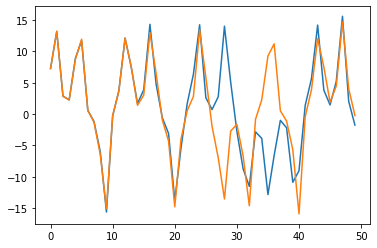

In [13]:
plt.plot(xt.values[:50,0])
plt.plot(y_pred_init[:50,0])

In [14]:
print('RMSE t+dt : ',RMSE(xt.values[1,:],y_pred_init[1,:]))
print('RMSE t+4dt : ',RMSE(xt.values[4,:],y_pred_init[4,:]))

RMSE t+dt :  0.01707410640367122
RMSE t+4dt :  0.20820477230205275


## Perfs of the trained model and integration scheme


In [15]:
#extracting integration scheme params
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()

import sympy as sp
xt, h = sp.symbols('xt h')

In [16]:
# computing analytic form of the integration scheme
k = [(modelRINN.Dyn_net_lin(xt))]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((modelRINN.Dyn_net_lin(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [17]:
# RK4 analytic integration scheme
grad = modelRINN.Dyn_net_lin(xt)
k1   = modelRINN.Dyn_net_lin(xt)
k2   = modelRINN.Dyn_net_lin(xt+0.5*h*k1)
k3   = modelRINN.Dyn_net_lin(xt+0.5*h*k2)
k4   = modelRINN.Dyn_net_lin(xt+h*k3)            
xt_1RK4 = xt +h*(k1+2*k2+2*k3+k4)/6

gRK4 = xt_1RK4.factor(xt)/xt

In [18]:
# stability graph
hi = np.arange(0,20+0.000001,0.01)
gainRK4 = np.zeros_like(hi)
for i in range(len(hi)):
    gainRK4[i] = np.abs(gRK4.evalf(subs={h: hi[i]}))
gainE = np.zeros_like(hi)
for i in range(len(hi)):
    gainE[i] = np.abs(1-0.5*hi[i])
gain = np.zeros_like(hi)
for i in range(len(hi)):
    gain[i] = np.abs(g.evalf(subs={h: hi[i]}))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


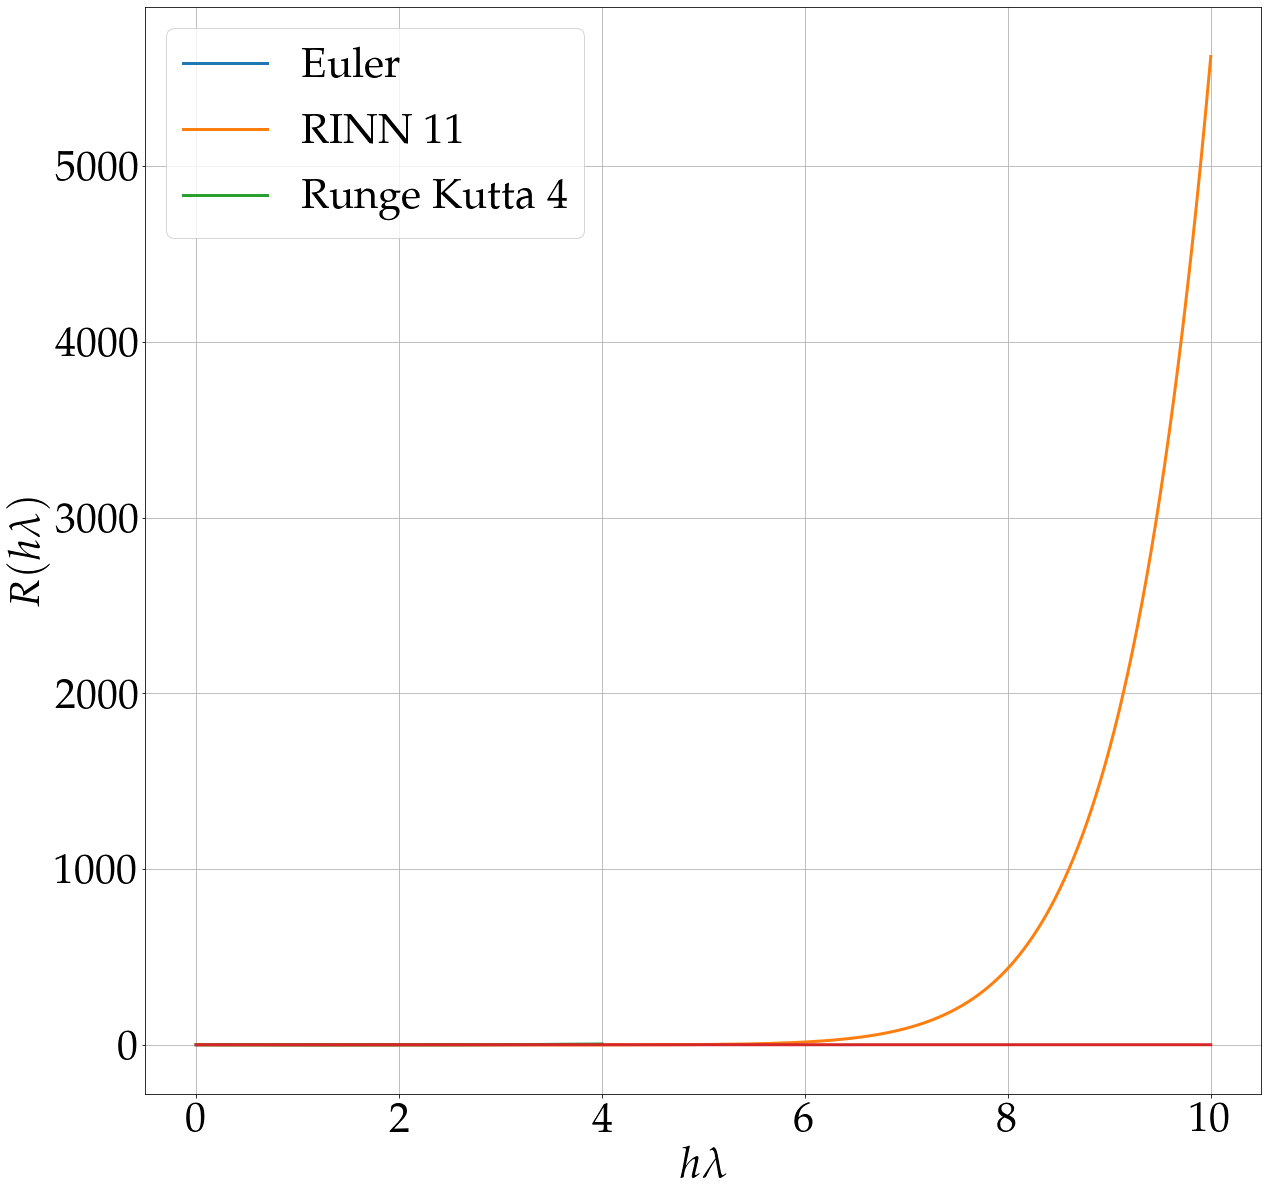

In [19]:
length_h = hi.shape[0]
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.plot(hi[:(length_h-1200)]*0.5,gainE[:(length_h-1200)],label = 'Euler',lw = 3)
plt.plot(hi[:length_h]*0.5,gain[:length_h],label = 'RINN 11',lw = 3)
plt.plot(hi[:(length_h-1200)]*0.5,gainRK4[:(length_h-1200)],label = 'Runge Kutta 4',lw = 3)
plt.plot(hi[:length_h]*0.5,np.ones_like(gainRK4[:length_h]),lw = 3)
#plt.plot(hi[:600],np.abs(ff[-1].data.numpy()[:600]))
plt.xlabel('$h\lambda$')
plt.ylabel('$R(h\lambda)$')
plt.grid()
plt.legend()

In [20]:
modelRINN.b.sum() # RK constraint respected :)

tensor(1., grad_fn=<SumBackward0>)

In [21]:
# computing analytic form of the integration scheme
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()
xt, h, lam = sp.symbols('xt h \lambda')
k = [lam*xt]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((lam*(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [22]:
g

-9.81662319011248e-8*\lambda**11*h**11 - 6.23624197660081e-7*\lambda**10*h**10 - 2.31133041697178e-6*\lambda**9*h**9 + 2.06971248610669e-6*\lambda**8*h**8 + 0.000113084405807935*\lambda**7*h**7 + 0.00113640052521328*\lambda**6*h**6 + 0.00759249695089939*\lambda**5*h**5 + 0.0401035590165084*\lambda**4*h**4 + 0.164659402602767*\lambda**3*h**3 + 0.500928405269067*\lambda**2*h**2 + 0.999999969142664*\lambda*h + 1.0

# Perfs 2D

In [23]:
# generating training data
class GD:
    model = 'Adv_Dif_1D'
    class parameters:
        w = -0.1+1.0j
        x0 = 0.5+0.5j
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 60.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
#training data
batch_size = catalog.true_solution[:-10-1,:].shape[0]
X_train_r = np.reshape(catalog.true_solution.real[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
X_train_i = np.reshape(catalog.true_solution.imag[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Y_train_r = np.reshape(catalog.true_solution.real[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Y_train_i = np.reshape(catalog.true_solution.imag[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))

In [24]:
#extracting integration scheme params
a=modelRINN.a.clone().data.numpy()[0,:,:]
b=modelRINN.b.clone().data.numpy()[0,:]
c=modelRINN.c.clone().data.numpy()[0,:]

a[:,0] = c[:] - a[:,:].sum(axis = 1)

import sympy as sp
x1,re_w,h  = sp.symbols('x1 re_w h',real=True)
x2,im_w    = sp.symbols('x2 im_w',real=True)

xt   = sp.symbols('x1+ix2')
lamb = re_w+sp.I*im_w

In [25]:
rz = np.arange(-10,10+0.000001,0.01)
iz = np.arange(-10,10+0.000001,0.01)
rz, iz = np.meshgrid(rz,iz)
z  = rz+iz*1.j

In [26]:
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
        if tmp<1:
            GRINN[i,j] = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)

100%|██████████| 2001/2001 [04:10<00:00,  7.99it/s]


In [27]:
GE = np.zeros_like(z)*np.nan
list_gE = []
list_xE = []
list_yE = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j])
        if tmp<1:
            GE[i,j] = tmp
            list_gE.append(GE[i,j].real)
            list_xE.append(z[i,j].real)
            list_yE.append(z[i,j].imag)

100%|██████████| 2001/2001 [00:08<00:00, 234.11it/s]


In [28]:
GRK4 = np.zeros_like(z)*np.nan
ark4 = np.array([[0,0,0,0],[1/2,0,0,0],[0,1/2,0,0],[0,0,1,0]])
brk4 = np.array([1/6,1/3,1/3,1/6])

list_gRK4 = []
list_xRK4 = []
list_yRK4 = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(brk4.T,np.linalg.inv(np.eye(ark4.shape[0])-z[i,j]*ark4)),np.ones_like(brk4)))
        if tmp<1:
            GRK4[i,j] = tmp
            list_gRK4.append(GRK4[i,j].real)
            list_xRK4.append(z[i,j].real)
            list_yRK4.append(z[i,j].imag)

100%|██████████| 2001/2001 [01:37<00:00, 20.49it/s]


(-7.0, 7.0)

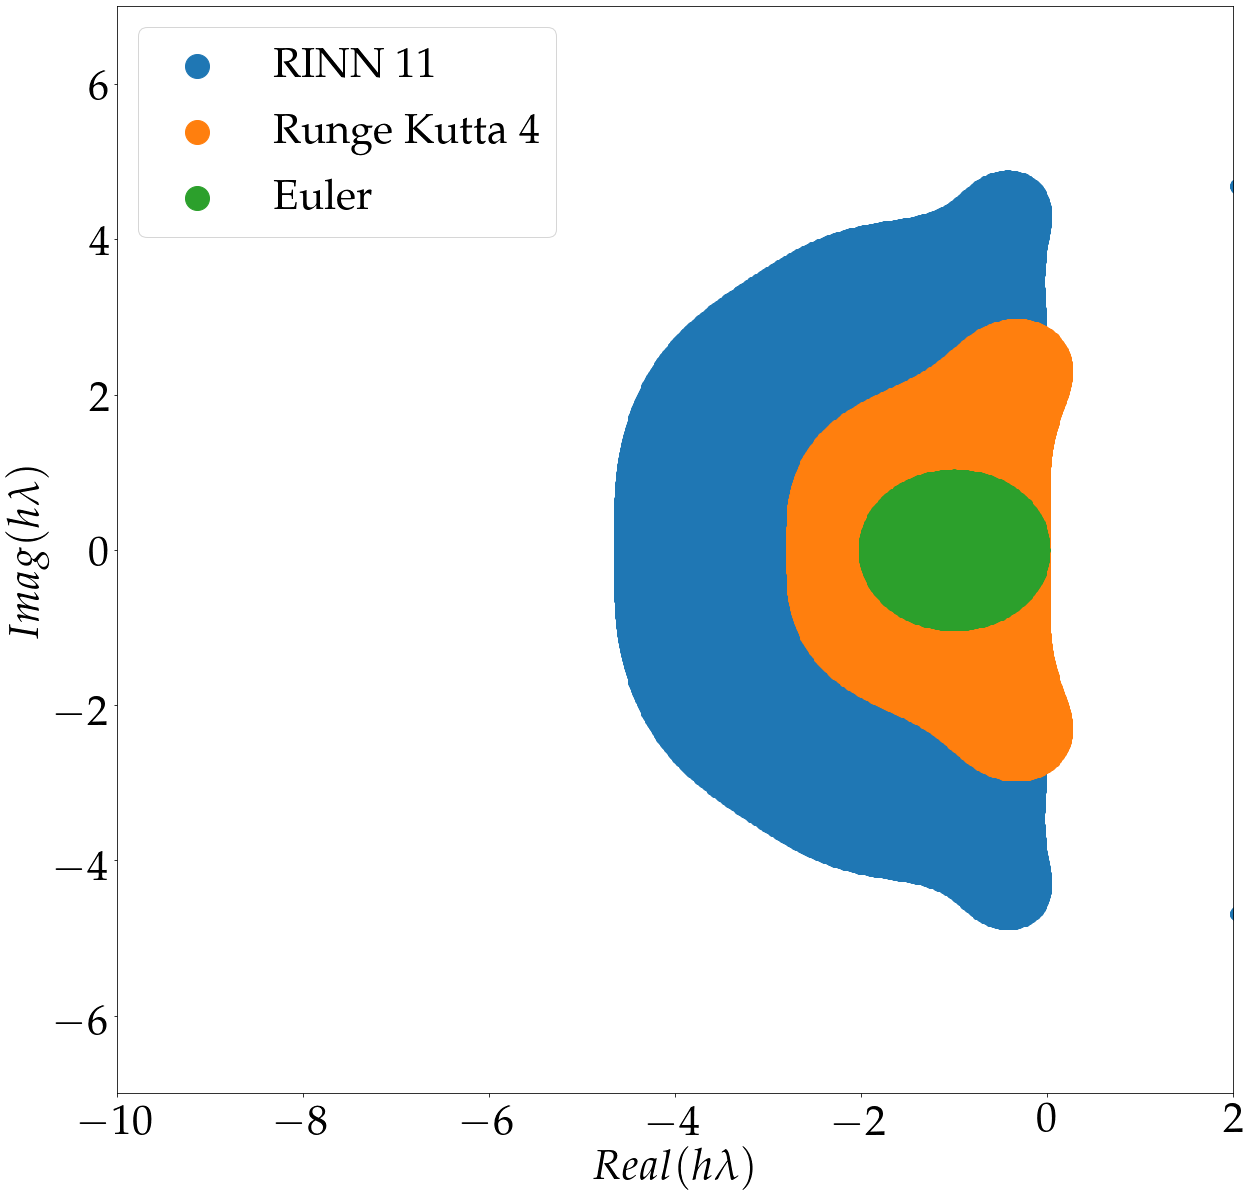

In [29]:
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))

plt.scatter(np.array(list_x),np.array(list_y), label = 'RINN 11')
plt.scatter(np.array(list_xRK4),np.array(list_yRK4), label = 'Runge Kutta 4')
plt.scatter(np.array(list_xE),np.array(list_yE), label = 'Euler')
plt.legend(markerscale=4.)
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')
plt.xlim(-10,2)
plt.ylim(-7,7)


# perfs of the integration scheme with a different (smaller) timestep

In [30]:
nb_steps_pred = 10000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(np.ones(3),(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN(tmp,0.01,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

Text(0.5, 0, '$z_3$')

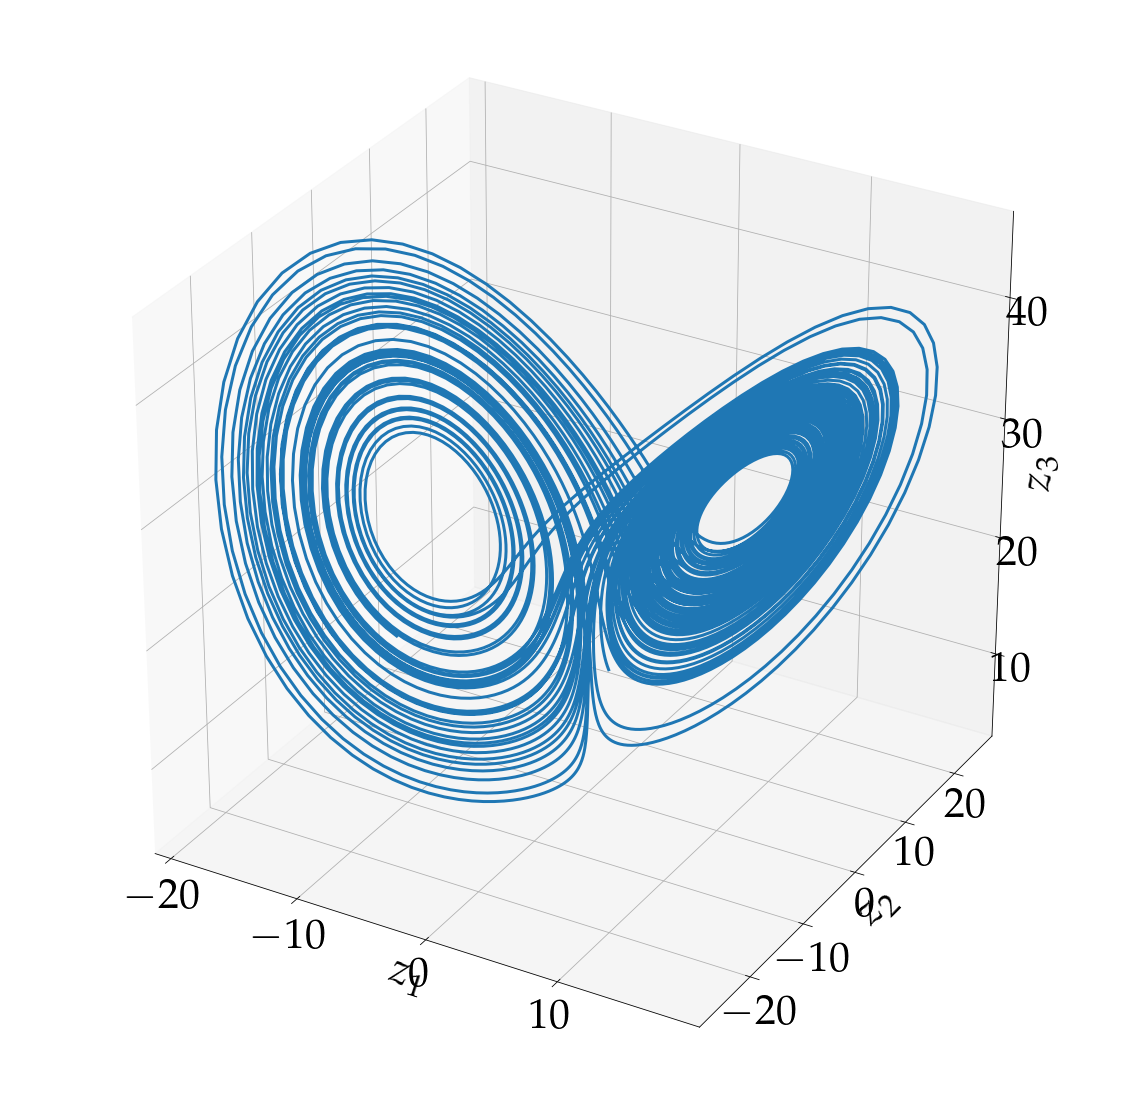

In [31]:
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig = plt.figure(figsize=(20,20))
ax=fig.gca(projection='3d')
line1,=ax.plot(y_pred[2000:,0],y_pred[2000:,1],y_pred[2000:,2],lw = 3)
ax.set_xlabel('$z_1$',labelpad = 11);ax.set_ylabel('$z_2$',labelpad = 11);ax.set_zlabel('$z_3$',labelpad = 11)

# Perfs of the RINN integration scheme on the L96 model

In [32]:
nb_steps_pred = 400
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,40))
tmp = np.ones((1,40))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp[0,20:] = 1+0.01
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN.flow_True_Model_L96(tmp,0.05,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,40))).float())

<Figure size 360x360 with 0 Axes>

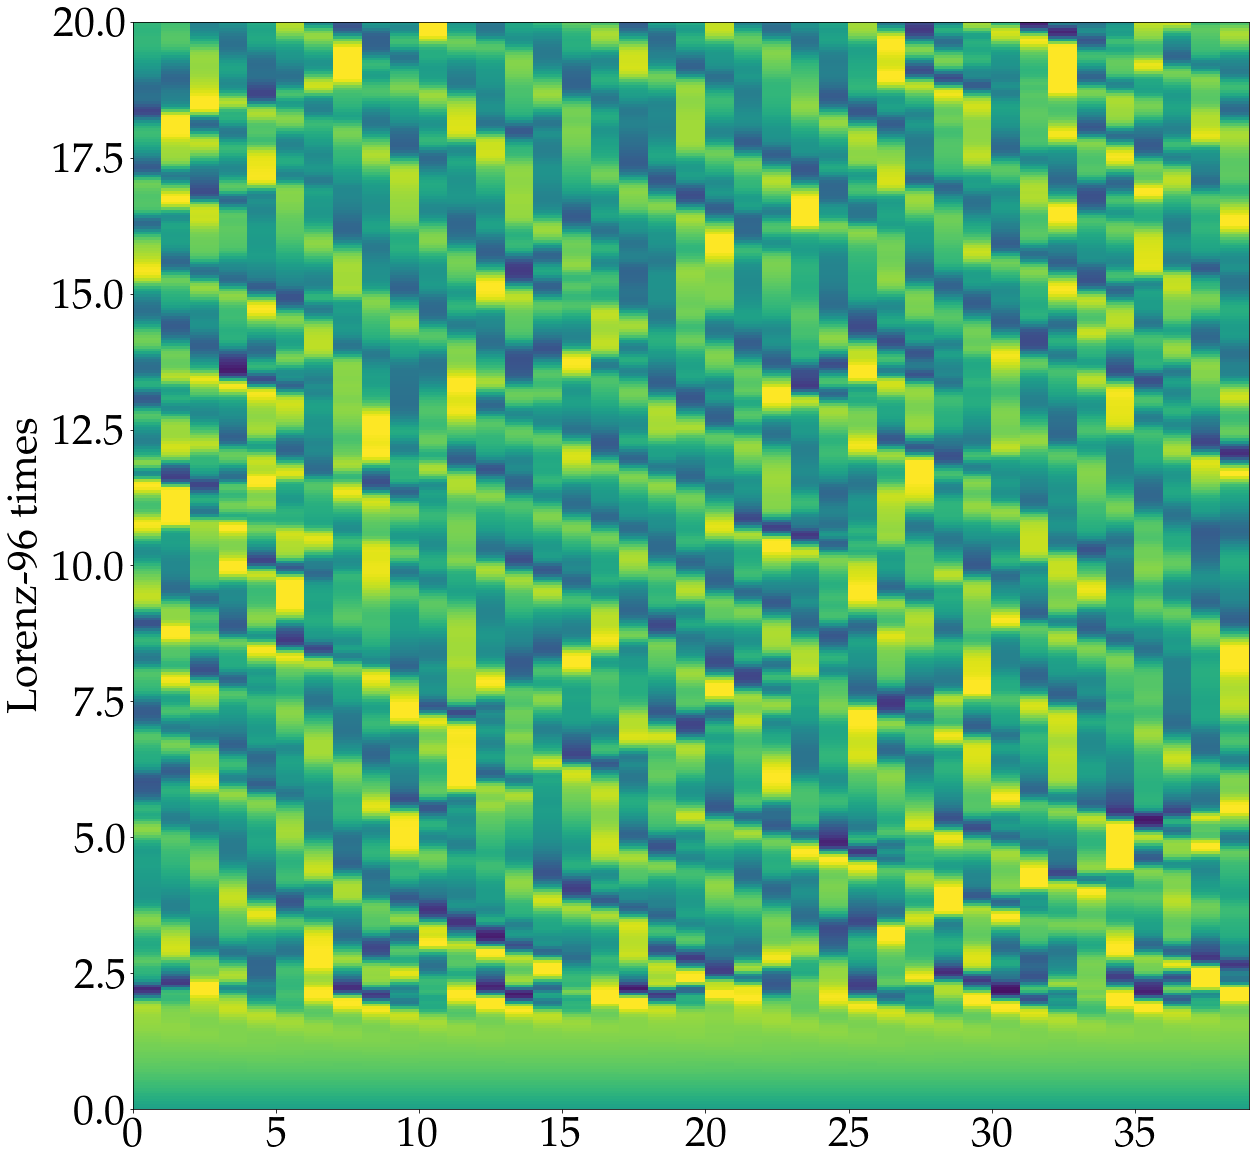

In [33]:
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(5,5))
[X,Y]= np.meshgrid(range(40),np.linspace(0,nb_steps_pred*0.05,nb_steps_pred+1))
plt.figure(figsize=(20,20))
plt.pcolor(X,Y,y_pred);
plt.xlim([0,40-1]);
plt.clim([-10,10]);
plt.ylabel('Lorenz-96 times');

# Learnt Runge-Kutta params

In [39]:
a

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.94933491e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.17592239e+00, -2.17292953e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.98541284e+00, -2.17396903e+00, -8.08439493e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.48212743e+00,  3.52130938e+00, -9.29584205e-01,
        -8.66670012e-01,  0.00000000e+00,  0.00000000e+00,
  

In [35]:
b

array([1.3326225e-04, 1.3286113e-04, 9.4992213e-02, 1.1428432e-04,
       3.3476317e-04, 3.1249253e-02, 3.9447182e-01, 6.3351251e-02,
       2.7660522e-01, 2.1919798e-02, 1.1669524e-01], dtype=float32)

In [36]:
c

array([0.        , 0.00294933, 0.00299292, 0.0030042 , 0.24292779,
       0.24293382, 0.32597739, 0.49628058, 0.7154979 , 0.8365028 ,
       1.        ], dtype=float32)

In [40]:
from tabulate import tabulate

ModuleNotFoundError: No module named 'tabulate'

In [41]:
!pip install tabulate


In [42]:
from tabulate import tabulate

In [53]:
print(tabulate(a, tablefmt="latex", floatfmt=".5f"))

\begin{tabular}{rrrrrrrrrrr}
\hline
  0.00000 &  0.00000 &  0.00000 &  0.00000 &  0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  0.00295 &  0.00000 &  0.00000 &  0.00000 &  0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  2.17592 & -2.17293 &  0.00000 &  0.00000 &  0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  2.98541 & -2.17397 & -0.80844 &  0.00000 &  0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 \\
 -1.48213 &  3.52131 & -0.92958 & -0.86667 &  0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 \\
 -1.20813 &  0.81761 &  0.44993 &  0.09160 &  0.09192 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  0.68880 & -0.37282 & -0.24275 & -0.02117 &  0.06104 &  0.21287 &  0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  0.28836 &  0.04642 & -0.17632 & -0.01809 & -0.01089 &  0.07776 &  0.28904 & 0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  0.05976 & 

In [46]:
b.shape

(11,)